<a href="https://colab.research.google.com/github/henryonomakpo/The-Impact-of-ESG-Ratings-on-EV-Manufacturing-Industry/blob/main/Impact_of_ESG_Risk_Rating_on_Construction_Firm's_Stock_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
# CELL 1: Install and Import Libraries
# --------------------------------------------------------------------
# Ensure all necessary libraries are listed for installation
!pip install linearmodels yfinance openpyxl statsmodels scikit-learn xgboost matplotlib seaborn tabulate pandas numpy scipy

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller # Import adfuller for stationarity test
from statsmodels.tsa.api import VAR # Import VAR model

# Import IterativeImputer explicitly as it's no longer experimental in recent sklearn
try:
    from sklearn.impute import IterativeImputer
except ImportError:
    # For older sklearn versions
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer

from sklearn.linear_model import BayesianRidge
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from linearmodels.panel.data import PanelData
# FIX: Adjust import from linearmodels.panel.results
# PanelResults is the base class, PooledOLSResults inherits from it.
# Importing PanelResults might be sufficient for type checking.
# We still need PanelEffectsResults and RandomEffectsResults specifically.
try:
    from linearmodels.panel.results import PanelEffectsResults, RandomEffectsResults, PanelResults # Removed PooledOLSResults as it caused ImportError
    # We will rely on PooledOLSResults inheriting from PanelResults for type checks.
    # We still need PanelEffectsResults and RandomEffectsResults specifically.
except ImportError as e:
    print(f"Error importing linearmodels results classes: {e}")
    print("Panel models may not run correctly or tables may not be generated.")
    # Define dummy classes to prevent NameError in subsequent code if import fails completely
    PanelEffectsResults = type('PanelEffectsResults', (object,), {})
    RandomEffectsResults = type('RandomEffectsResults', (object,), {})
    PanelResults = type('PanelResults', (object,), {}) # Base dummy class


from statsmodels.regression.linear_model import RegressionResultsWrapper # For statsmodels OLS results


from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, KFold # Import KFold for fallback CV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
# from statsmodels.tsa.api import VAR # Already imported above now
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from collections import OrderedDict
import yfinance as yf
import requests
import zipfile
import io
import os
import scipy.stats as stats # For t-tests, F-tests if needed manually

# Check for pyeconometrics for GMM (Optional, often not installed by default)
try:
    from pyeconometrics.panel import PanelGMM
    GMM_AVAILABLE = True
    print("pyeconometrics available. GMM models placeholder will be included.")
except ImportError:
    GMM_AVAILABLE = False
    print("pyconometrics not available/not installed. GMM models will be skipped.")


VIF_THRESHOLD = 10 # Relaxed VIF for models with many controls; can be 5 if preferred
RANDOM_STATE = 42
LAG_PERIODS = 1 # Number of periods to lag independent variables
SIGNIFICANCE_LEVEL = 0.05

# --- Helper function for creating results tables ---
def create_results_table(model_results, model_name="Model", custom_var_names=None, suppress_dummies=True, dummy_prefixes=['entity_dummy_', 'time_dummy_'], df_model_data=None):
    """
    Generates a formatted table from regression results.

    Args:
        model_results: Fitted model results object (statsmodels or linearmodels).
        model_name (str): Name for the model in the table footer.
        custom_var_names (dict, optional): Dictionary to rename variables. Defaults to None.
        suppress_dummies (bool, optional): Whether to suppress dummy variable coefficients. Defaults to True.
        dummy_prefixes (list, optional): List of prefixes to identify dummy variables.
                                         Defaults to ['entity_dummy_', 'time_dummy_'].
        df_model_data (pd.DataFrame, optional): The DataFrame used to fit the model.
                                               Used to count entities/time periods for statsmodels results.
                                               Defaults to None.

    Returns:
        str: A formatted string table of the results or an error message.
    """
    # Check if model_results is a valid fitted object
    if model_results is None:
        return f"Could not generate table for {model_name}: Model results are None."
    if not hasattr(model_results, 'params'):
         print(f"Warning: Model results object for {model_name} does not have a 'params' attribute.")
         return f"Could not generate table for {model_name}: Invalid model results object type: {type(model_results).__name__}"


    # --- Extract Core Results ---
    params = model_results.params

    # Robustly get p-values
    p_values = None
    if hasattr(model_results, 'pvalues'):
        p_values = model_results.pvalues
    elif hasattr(model_results, 'pval'):
        # linearmodels results often have pval Series/attribute
        p_values = model_results.pval
    # Ensure p_values is a Series with the same index as params
    if p_values is None or not isinstance(p_values, pd.Series):
         p_values = pd.Series(np.nan, index=params.index)


    # Robustly get standard errors
    std_errs = None
    if hasattr(model_results, 'std_errors'):
        std_errs = model_results.std_errors
    elif hasattr(model_results, 'bse'):
        # statsmodels results use bse (standard errors)
        std_errs = model_results.bse
    # Ensure std_errs is a Series with the same index as params
    if std_errs is None or not isinstance(std_errs, pd.Series):
         std_errs = pd.Series(np.nan, index=params.index)


    results_df = pd.DataFrame({
        'Variable': params.index,
        'Coefficient': params.values,
        'Std. Error': std_errs.values, # Use .values just in case index is not perfectly aligned, relies on order
        'P-value': p_values.values     # Use .values
    })

    # Apply custom variable names if provided
    if custom_var_names:
         results_df['Variable'] = results_df['Variable'].replace(custom_var_names)


    # Suppress dummies for LSDV models
    if suppress_dummies and isinstance(model_results, RegressionResultsWrapper):
        is_dummy = pd.Series(False, index=results_df.index) # Use results_df index
        for prefix in dummy_prefixes:
            is_dummy = is_dummy | results_df['Variable'].astype(str).str.startswith(prefix)
        # Ensure we filter and then copy
        results_df = results_df[~is_dummy].copy()


    # Add significance stars
    stars = []
    # Ensure P-value column exists and has non-NaN values before adding stars
    if 'P-value' in results_df.columns and not results_df['P-value'].isnull().all():
        # Convert to numeric just in case, coercing errors
        p_vals_numeric = pd.to_numeric(results_df['P-value'], errors='coerce')
        for p_val in p_vals_numeric:
            if pd.isna(p_val): stars.append('')
            elif p_val < 0.01: stars.append('***')
            elif p_val < 0.05: stars.append('**')
            elif p_val < 0.1: stars.append('*')
            else: stars.append('')
    else:
         # If no P-values or all are NaN, just add empty stars
         stars = [''] * len(results_df)

    results_df['Sig.'] = stars

    # Format coefficient with stars
    results_df['Coefficient_Formatted'] = results_df.apply(lambda r: f"{r['Coefficient']:.4f}{r['Sig.']}" if pd.notna(r['Coefficient']) else "N/A", axis=1)

    display_cols = ['Variable', 'Coefficient_Formatted', 'Std. Error', 'P-value']

    # Ensure P-value and Std. Error columns are numeric for consistent floatfmt
    # Use errors='coerce' to turn unparseable values into NaN
    results_df['P-value'] = pd.to_numeric(results_df['P-value'], errors='coerce')
    results_df['Std. Error'] = pd.to_numeric(results_df['Std. Error'], errors='coerce')


    results_df_display = results_df[display_cols].copy() # Use copy()
    results_df_display.rename(columns={'Coefficient_Formatted': 'Coefficient'}, inplace=True)

    # --- Summary Stats ---
    summary_stats = OrderedDict()
    summary_stats["Model"] = model_name

    # R-squared variants
    if hasattr(model_results, 'rsquared_overall'): summary_stats["R-sq (Overall)"] = f"{model_results.rsquared_overall:.4f}"
    if hasattr(model_results, 'rsquared_within'): summary_stats["R-sq (Within)"] = f"{model_results.rsquared_within:.4f}"
    if hasattr(model_results, 'rsquared_between'): summary_stats["R-sq (Between)"] = f"{model_results.rsquared_between:.4f}"
    # R-squared (statsmodels or general linearmodels if no within/between)
    if hasattr(model_results, 'rsquared') and not any(k.startswith("R-sq") for k in summary_stats.keys()):
        # Check for non-finite R-squared before formatting
        if pd.notna(model_results.rsquared) and np.isfinite(model_results.rsquared):
            summary_stats["R-squared"] = f"{model_results.rsquared:.4f}"
        else:
             summary_stats["R-squared"] = "N/A"
    # Adjusted R-squared (mostly statsmodels)
    if hasattr(model_results, 'rsquared_adj') and isinstance(model_results, RegressionResultsWrapper):
         if pd.notna(model_results.rsquared_adj) and np.isfinite(model_results.rsquared_adj):
            summary_stats["Adj. R-squared"] = f"{model_results.rsquared_adj:.4f}"
         else:
            summary_stats["Adj. R-squared"] = "N/A"


    # Observations
    if hasattr(model_results, 'nobs') and pd.notna(model_results.nobs):
         summary_stats["Observations"] = str(int(model_results.nobs))
    elif hasattr(model_results, 'nobs') and model_results.nobs is None:
         summary_stats["Observations"] = "N/A"


    # Entity/Time info
    # Check specific linearmodels results types first
    if isinstance(model_results, (PanelEffectsResults, RandomEffectsResults)):
        if hasattr(model_results, 'entity_info') and model_results.entity_info and hasattr(model_results.entity_info, 'total'):
             summary_stats["Entities"] = str(model_results.entity_info.total)
        if hasattr(model_results, 'time_info') and model_results.time_info and hasattr(model_results.time_info, 'total'):
             summary_stats["Time Periods"] = str(model_results.time_info.total)
    # Check base PanelResults for PooledOLS, etc.
    elif isinstance(model_results, PanelResults):
        # PanelResults might not have entity/time_info attributes directly, or they might be None.
        # Attempt to infer from the index if it's a MultiIndex, or from passed data.
        if hasattr(model_results.model, 'data') and hasattr(model_results.model.data, 'index') and isinstance(model_results.model.data.index, pd.MultiIndex):
             summary_stats["Entities"] = str(model_results.model.data.index.get_level_values(0).nunique())
             summary_stats["Time Periods"] = str(model_results.model.data.index.get_level_values(1).nunique())
        # Fallback to passed df_model_data if available
        elif df_model_data is not None and 'Ticker_Str' in df_model_data.columns and 'Date' in df_model_data.columns:
             summary_stats["Entities"] = str(df_model_data['Ticker_Str'].nunique())
             summary_stats["Time Periods"] = str(df_model_data['Date'].nunique())

    elif isinstance(model_results, RegressionResultsWrapper) and df_model_data is not None:
         # For Statsmodels results (like LSDV/Pooled OLS), get counts from the data used
         # Check for 'Ticker_Str' or 'Ticker'
         if 'Ticker_Str' in df_model_data.columns and 'Date' in df_model_data.columns:
             summary_stats["Entities"] = str(df_model_data['Ticker_Str'].nunique())
             summary_stats["Time Periods"] = str(df_model_data['Date'].nunique())
         elif 'Ticker' in df_model_data.columns and 'Date' in df_model_data.columns:
             summary_stats["Entities"] = str(df_model_data['Ticker'].nunique())
             summary_stats["Time Periods"] = str(df_model_data['Date'].nunique())


    # F-statistic or Wald Test (Model)
    # Prefer robust F-stat from linearmodels
    f_stat_attr = getattr(model_results, 'f_statistic_robust', None)
    # Fallback to non-robust F-stat from linearmodels (PanelOLS, RandomEffects, PooledOLS)
    if f_stat_attr is None: f_stat_attr = getattr(model_results, 'f_statistic', None)
    # Fallback to Statsmodels OLS F-value/p-value if available (e.g., LSDV)
    if f_stat_attr is None and hasattr(model_results, 'fvalue') and hasattr(model_results, 'f_pvalue'):
        # Check if the F-statistic and p-value are plausible (e.g., F-value >= 0, p-value >= 0)
        # Statsmodels OLS F-value with clustered errors can be unreliable/negative.
        # Only report if statistically meaningful.
        if pd.notna(model_results.fvalue) and model_results.fvalue >= 0 and pd.notna(model_results.f_pvalue) and model_results.f_pvalue >= 0:
            f_stat_attr = type('obj', (object,), {'stat': model_results.fvalue, 'pval': model_results.f_pvalue})
        else:
             # If F-stat is suspect or missing, check for a robust Wald test in Statsmodels
             if isinstance(model_results, RegressionResultsWrapper) and hasattr(model_results, 'wald_test_terms'):
                 try:
                     # Perform Wald test on all terms excluding the constant
                     # Identify non-constant, non-dummy terms from the original model params
                     original_params_index = model_results.params.index
                     non_const_terms_params = [term for term in original_params_index if term != 'const' and not any(term.startswith(p) for p in dummy_prefixes)]

                     if non_const_terms_params:
                         # Note: This tests the hypothesis that the coefficients on `non_const_terms_params` are jointly zero.
                         # This is a valid test for overall significance of the *non-fixed-effect* regressors.
                         wald_res = model_results.wald_test_terms(terms=non_const_terms_params, skip_term='const')
                         if hasattr(wald_res, 'statistic') and hasattr(wald_res, 'pvalue') and pd.notna(wald_res.statistic) and pd.notna(wald_res.pvalue):
                              summary_stats["Wald Test (Model, ex-FE)"] = f"{wald_res.statistic:.4f} (p={wald_res.pvalue:.4f})"
                         # Note: This is Chi-squared, not F.

                 except Exception as e_wald:
                      # print(f"Warning: Error running Wald test: {e_wald}")
                      pass # Suppress Wald test error in table creation
             # Also check for linearmodels joint Wald test if applicable (sometimes available when F is not)
             elif hasattr(model_results, 'wald_test_joint'): # linearmodels joint Wald test
                  try:
                      wald_res = model_results.wald_test_joint() # May require specific structure
                      if hasattr(wald_res, 'stat') and hasattr(wald_res, 'pval') and pd.notna(wald_res.stat) and pd.notna(wald_res.pval):
                         summary_stats["Wald Test (Model, LM Joint)"] = f"{wald_res.stat:.4f} (p={wald_res.pval:.4f})"
                      # Note: Also Chi-squared.
                  except Exception as e_wald_lm:
                       # print(f"Warning: Error running LM Wald test: {e_wald_lm}")
                       pass # Suppress error


    # Report F-statistic if a valid one was found
    if f_stat_attr and hasattr(f_stat_attr, 'stat') and hasattr(f_stat_attr, 'pval'):
         if pd.notna(f_stat_attr.stat) and pd.notna(f_stat_attr.pval):
             summary_stats["F-statistic (Model)"] = f"{f_stat_attr.stat:.4f} (p={f_stat_attr.pval:.4f})"
         else:
             summary_stats["F-statistic (Model)"] = "N/A (P-value NaN)"


    footer_list = [f"{k}: {v}" for k,v in summary_stats.items()]
    footer_text = "\n" + "\n".join(footer_list) + "\nSignificance: *** p<0.01, ** p<0.05, * p<0.1"

    if suppress_dummies and isinstance(model_results, RegressionResultsWrapper) and any(idx.startswith(tuple(dummy_prefixes)) for idx in model_results.params.index): # Check original params for dummies
        footer_text += "\n(Dummy variable coefficients suppressed for LSDV model tables)"
    # Add a note about potentially unreliable F-stat for Statsmodels OLS with clustered errors
    if isinstance(model_results, RegressionResultsWrapper) and hasattr(model_results, 'cov_type') and 'cluster' in model_results.cov_type:
         if f_stat_attr is None or (hasattr(f_stat_attr, 'stat') and (pd.isna(f_stat_attr.stat) or f_stat_attr.stat < 0)):
             footer_text += "\n(Note: OLS F-statistic with clustered errors can be unreliable or negative. See Wald Test.)"


    # Define floatfmt for tabulate based on the display columns
    floatfmt_dict = {
        'Coefficient': ".4f",
        'Std. Error': ".4f",
        'P-value': ".4f"
    }
    # Create the tuple format for tabulate, handling columns that might be missing
    floatfmt_tuple = []
    for col in results_df_display.columns:
        floatfmt_tuple.append(floatfmt_dict.get(col, None))


    return tabulate(results_df_display, headers='keys', tablefmt='psql', floatfmt=floatfmt_tuple, showindex=False) + footer_text


def create_model_selection_test_table(test_data_list):
    if not test_data_list: return "No model selection test data to display."
    df = pd.DataFrame(test_data_list)
    # Define preferred column order, but only include columns present in the DataFrame
    cols_order = ['Test Name', 'Statistic Value', 'P-value', 'DF', 'Decision']
    df_cols = [col for col in cols_order if col in df.columns]
    df = df[df_cols]

    # Format numeric columns for tabulate
    floatfmt = []
    for col in df_cols:
        if col in ['Statistic Value', 'P-value']:
            floatfmt.append(".4f")
        elif col == 'DF':
            floatfmt.append(".0f") # Assuming DF is integer
        else:
            floatfmt.append(None) # Default formatting

    return tabulate(df, headers='keys', tablefmt='psql', showindex=False, floatfmt=floatfmt)

# Helper function for stationarity test from tutorial
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'  Augmented Dickey-Fuller Test: {title}')
    # Ensure series is numeric and drop NaNs before test
    series_clean = pd.to_numeric(series, errors='coerce').dropna()

    if len(series_clean) < 10: # Ad hoc minimum for test to be somewhat meaningful
         print(f"    Skipping ADF test for '{title}': Insufficient non-missing data ({len(series_clean)}).")
         return {'stat': np.nan, 'pval': 1.0, 'lags': np.nan, 'obs': np.nan, 'critical': {}} # Indicate non-stationarity likely

    try:
        result = adfuller(series_clean,autolag='AIC') # .dropna() handles differenced data
        labels = ['ADF test statistic','p-value','# lags used','# observations']
        out = pd.Series(result[0:4],index=labels)
        for key,val in result[4].items():
            out[f'critical value ({key})']=val
        print(out.to_string())          # .to_string() removes the line "dtype: float64"
        if result[1] <= SIGNIFICANCE_LEVEL:
            print("    Strong evidence against the null hypothesis")
            print("    Reject the null hypothesis")
            print("    Data has no unit root and is stationary")
        else:
            print("    Weak evidence against the null hypothesis")
            print("    Fail to reject the null hypothesis")
            print("    Data has a unit root and is non-stationary")
        return {'stat': result[0], 'pval': result[1], 'lags': result[2], 'obs': result[3], 'critical': result[4]}
    except Exception as e:
         print(f"    Error during ADF test for '{title}': {e}")
         return {'stat': np.nan, 'pval': 1.0, 'lags': np.nan, 'obs': np.nan, 'critical': {}} # Indicate failure and likely non-stationarity


# CELL 2, 3, 4, 5, 6, 7: Data Loading and Initial Preprocessing
# Data loading and initial processing block remains largely unchanged
from google.colab import files
print("Please upload BOTH 'historic_esg_scores_construction.csv' AND your Fama-French factor file (e.g., 'Developed_5_Factors_Momentum.csv').")
uploaded_files = files.upload()

df_esg = pd.DataFrame()
df_ff_raw = pd.DataFrame()

esg_target_filename_base = 'historic_esg_scores_construction'
ff_target_filename_base = 'Developed_5_Factors_Momentum' # Or 'F-F_Research_Data_5_Factors_2x3_Daily' etc. Adjust as needed.

esg_uploaded = False
ff_uploaded = False

for filename_uploaded, content in uploaded_files.items():
    if esg_target_filename_base.lower() in filename_uploaded.lower():
        try:
            # Assuming CSV for now based on prompt
            # FIX: Corrected typo io.BytesBytes to io.BytesIO
            df_esg = pd.read_csv(io.BytesIO(content))
            print(f"\nESG data '{filename_uploaded}' loaded successfully into df_esg.")
            esg_uploaded = True
        except Exception as e:
            print(f"Error loading ESG file '{filename_uploaded}': {e}")
    elif ff_target_filename_base.lower() in filename_uploaded.lower():
        try:
            # Assuming CSV for now based on prompt
            df_ff_raw = pd.read_csv(io.BytesIO(content))
            print(f"\nFama-French data '{filename_uploaded}' loaded successfully into df_ff_raw.")
            ff_uploaded = True
        except Exception as e:
             print(f"Error loading FF file '{filename_uploaded}': {e}")
    else:
        print(f"Uploaded file '{filename_uploaded}' does not match expected names ('{esg_target_filename_base}', '{ff_target_filename_base}'). Skipping.")


if not esg_uploaded or df_esg.empty:
    print(f"CRIT ERROR: ESG file matching '{esg_target_filename_base}' not uploaded, read, or is empty.")
    df_esg = pd.DataFrame() # Ensure it's empty if loading failed
if not ff_uploaded or df_ff_raw.empty:
    print(f"CRIT ERROR: FF file matching '{ff_target_filename_base}' not uploaded, read, or is empty.")
    df_ff_raw = pd.DataFrame() # Ensure it's empty if loading failed


# Define a default date range or update based on data
min_overall_date = pd.to_datetime("2000-01-01") # Default start for FF download
max_overall_date = pd.to_datetime("2024-12-31") # Default end for FF download

min_esg_date_actual = None
max_esg_date_actual = None

if not df_esg.empty:
    print("\n--- Preprocessing ESG Data ---")
    # Ensure 'Date' column is datetime, handling potential errors
    df_esg['Date'] = pd.to_datetime(df_esg['Date'], errors='coerce')
    df_esg = df_esg.loc[:, ~df_esg.columns.str.contains('^Unnamed')] # Drop unnamed columns
    df_esg.dropna(subset=['Date', 'Ticker'], inplace=True)

    # Identify ESG score columns - make this more flexible
    esg_cols_initial = ['Total-Score', 'E-Score', 'S-Score', 'G-Score']
    esg_cols = [col for col in esg_cols_initial if col in df_esg.columns]

    if not esg_cols:
        print("CRIT ERROR: No expected ESG score columns found in df_esg.");
        esg_cols = [] # Ensure it's empty if none found
    else:
         print(f"Using ESG columns: {esg_cols}")

    # Convert ESG columns to numeric, coercing errors
    for col in esg_cols:
        df_esg[col] = pd.to_numeric(df_esg[col], errors='coerce')

    # Ensure dates are at month end and remove timezone info if present
    df_esg['Date'] = (df_esg['Date'] + pd.offsets.MonthEnd(0)).dt.tz_localize(None)

    # Drop duplicates, keeping the last score for a given ticker-date
    df_esg = df_esg.drop_duplicates(subset=['Ticker', 'Date'], keep='last')

    print(f"ESG data shape after initial processing: {df_esg.shape}")

    # Update date range based on ESG data, adding buffer for lagged variables and future DV
    if not df_esg.empty:
        min_esg_date_actual = df_esg['Date'].min()
        max_esg_date_actual = df_esg['Date'].max()
        # Need data from LAG_PERIODS+1 months before min ESG date
        min_overall_date = min_esg_date_actual - pd.DateOffset(months=LAG_PERIODS + 1)
        # Need data up to 1 month after max ESG date for the future DV
        max_overall_date = max_esg_date_actual + pd.DateOffset(months=1)
        print(f"Determined overall data range based on ESG: {min_overall_date.strftime('%Y-%m-%d')} to {max_overall_date.strftime('%Y-%m-%d')}")
    else:
        print("Warning: ESG data empty after processing. Using default overall date range for FF/Prices.")

else:
    print("Skipping ESG preprocessing as df_esg is empty.")


print("\n--- Processing Manually Uploaded Fama-French Factors ---")
df_ff = pd.DataFrame()
ff_factor_cols_renamed = [] # Initialize as empty list

if not df_ff_raw.empty:
    try:
        df_ff = df_ff_raw.copy()

        # Attempt to parse the date column (assume first column)
        date_col_name = df_ff.columns[0]
        df_ff.rename(columns={date_col_name: 'Date_str'}, inplace=True, errors='ignore')

        df_ff['Date_str'] = df_ff['Date_str'].astype(str).str.strip()

        date_parsed_successfully = False
        date_formats_to_try = ['%m/%d/%y', '%Y%m%d', '%Y%m', '%Y-%m-%d', '%m/%d/%Y']
        for fmt in date_formats_to_try:
            try:
                df_ff['Date'] = pd.to_datetime(df_ff['Date_str'], format=fmt, errors='raise')
                date_parsed_successfully = True
                print(f"  Parsed FF dates using format: {fmt}")
                break
            except (ValueError, TypeError):
                continue

        if not date_parsed_successfully:
             print("  Specific date formats failed, trying pandas inference for FF dates...")
             df_ff['Date'] = pd.to_datetime(df_ff['Date_str'], errors='coerce')

        df_ff.dropna(subset=['Date'], inplace=True)

        if df_ff.empty:
             raise ValueError("FF DataFrame empty after date parsing.")

        # Ensure FF dates are also end of month and remove timezone info
        df_ff['Date'] = (df_ff['Date'] + pd.offsets.MonthEnd(0)).dt.tz_localize(None)

        # Rename common Fama-French factor columns to consistent names
        factor_rename_map_manual = {
            'Mkt-RF':'Mkt-RF', 'SMB':'SMB', 'HML':'HML',
            'RMW':'RMW', 'CMA':'CMA', 'RF':'RF',
            'WML':'UMD', 'Mom   ':'UMD', 'MOM':'UMD', # Handle different momentum names
            'Mkt_Rf': 'Mkt-RF', 'MKTRF': 'Mkt-RF' # Add more common variations
        }
        df_ff.columns = [col.strip() for col in df_ff.columns] # Strip whitespace
        df_ff.rename(columns=factor_rename_map_manual, inplace=True)

        # Identify the actual FF columns present after renaming
        ff_factor_cols_standard = ['Mkt-RF','SMB','HML','RMW','CMA','RF','UMD']
        actual_ff_cols_present = [col for col in ff_factor_cols_standard if col in df_ff.columns]

        if len(actual_ff_cols_present) < 6: # Check if at least 5 factors + RF are present
            print(f"Warn: Not all expected 5 factors + RF (+ Momentum) found. Present: {actual_ff_cols_present}")

        # Convert factor columns to numeric, handling potential non-numeric entries
        for col in actual_ff_cols_present:
            df_ff[col] = pd.to_numeric(df_ff[col], errors='coerce')
            # Simple check: if mean absolute value is > 0.5 but < 100, assume it's in percent
            # Added check for NaNs in mean calculation
            if col in df_ff.columns and df_ff[col].dropna().abs().mean() > 0.5 and df_ff[col].dropna().abs().mean() < 100 :
                 print(f"  Assuming FF factor '{col}' is in percentage format, dividing by 100.")
                 df_ff[col] = df_ff[col] / 100.0


        # Keep only Date and the identified factor columns
        df_ff = df_ff[['Date'] + actual_ff_cols_present].copy()

        # Drop rows with NaNs in factor columns after conversion/cleaning
        df_ff.dropna(subset=actual_ff_cols_present, how='any', inplace=True)

        # Filter FF data to match the overall date range determined by ESG data + buffer
        if min_overall_date and max_overall_date:
             initial_ff_rows = df_ff.shape[0]
             df_ff = df_ff[(df_ff['Date'] >= min_overall_date) & (df_ff['Date'] <= max_overall_date)].copy()
             if df_ff.shape[0] < initial_ff_rows:
                  print(f"Filtered FF data to match overall date range: {initial_ff_rows} -> {df_ff.shape[0]} rows.")


        print(f"Processed FF data shape: {df_ff.shape}")
        if not df_ff.empty: print(df_ff.head())


        # Store the list of FF factor columns (excluding Date)
        ff_factor_cols_renamed = [col for col in df_ff.columns if col != 'Date']

    except Exception as e:
        print(f"CRIT ERROR processing FF file: {e}")
        df_ff = pd.DataFrame() # Ensure df_ff is empty if processing failed
        ff_factor_cols_renamed = []

else:
    print("FF raw data empty.")

if df_ff.empty:
    print("CRIT: FF data not processed or is empty.")
    ff_factor_cols_renamed = [] # Ensure empty if FF processing failed


# Download stock prices only if ESG data was successfully loaded AND there are tickers
df_prices = pd.DataFrame() # Initialize empty
if not df_esg.empty and 'Ticker' in df_esg.columns and not df_esg['Ticker'].empty:
    print("\n--- Downloading Historical Stock Prices ---")
    tickers_list_orig = df_esg['Ticker'].unique().tolist()
    print(f"Original tickers from ESG file ({len(tickers_list_orig)}): {tickers_list_orig}")

    # Manual ticker mapping for known issues (e.g., J -> J)
    ticker_map_manual = {'CRH': 'CRH', 'J': 'J'} # Add or correct problematic tickers

    all_stock_data_list = []
    successful_tickers_map = {} # To map ESG ticker to successfully downloaded yf ticker

    # Use the overall date range determined earlier
    start_date_yf = min_overall_date.strftime('%Y-%m-%d') if min_overall_date else "2000-01-01"
    end_date_yf = max_overall_date.strftime('%Y-%m-%d') if max_overall_date else "2024-12-31"

    print(f"Downloading stock prices from {start_date_yf} to {end_date_yf}")


    # Limit number of tickers for download if it's very large (optional, for debugging/testing)
    # tickers_to_download = tickers_list_orig[:50] # Example: limit to first 50
    tickers_to_download = tickers_list_orig # Use all tickers from ESG data


    for esg_ticker in tickers_to_download: # Use the list of tickers to download
        yf_ticker_to_try = ticker_map_manual.get(esg_ticker, esg_ticker) # Use mapped ticker or original
        # print(f"Attempting download for ESG '{esg_ticker}' as yf '{yf_ticker_to_try}'...") # Too verbose for many tickers

        try:
            stock = yf.Ticker(yf_ticker_to_try)
            # Download daily data within the determined date range
            hist = stock.history(start=start_date_yf, end=end_date_yf, interval="1d", auto_adjust=True, actions=False)

            if not hist.empty and 'Close' in hist.columns:
                # Resample to monthly, taking the last closing price of the month
                hist_monthly = hist[['Close']].resample('ME').last()
                hist_monthly.rename(columns={'Close': 'Price'}, inplace=True)
                hist_monthly['Ticker_ESG'] = esg_ticker # Keep original ESG ticker identifier
                hist_monthly['Ticker_yf'] = yf_ticker_to_try # Keep yfinance ticker used
                hist_monthly.reset_index(inplace=True) # Date becomes a column again

                # Ensure date is timezone-naive month-end for consistency
                hist_monthly['Date'] = (hist_monthly['Date'] + pd.offsets.MonthEnd(0)).dt.tz_localize(None)

                # Append to list, keeping only necessary columns
                all_stock_data_list.append(hist_monthly[['Date', 'Ticker_ESG', 'Price']]) # Keep Ticker_ESG for merging
                # print(f"  Success: '{esg_ticker}' as '{yf_ticker_to_try}'.") # Too verbose
                successful_tickers_map[esg_ticker] = yf_ticker_to_try # Record successful mapping
            else:
                print(f"  No data or 'Close' column found for '{esg_ticker}' as '{yf_ticker_to_try}'.")

        except Exception as e:
            print(f"  Error downloading data for '{esg_ticker}' as '{yf_ticker_to_try}': {e}")

    if not all_stock_data_list:
        print("CRIT ERROR: No stock data downloaded successfully.")
        df_prices = pd.DataFrame() # Ensure df_prices is empty if no data downloaded
    else:
        df_prices = pd.concat(all_stock_data_list, ignore_index=True)
        print(f"\nDownloaded stock data for {df_prices['Ticker_ESG'].nunique()} unique ESG tickers.")
        print(f"Processed ESG tickers with successful download: {list(successful_tickers_map.keys())}")

else:
    print("Skipping stock price preprocessing: df_prices is empty.")


print("\n--- Preprocessing Stock Price Data & Basic Controls ---")
if not df_prices.empty: # Ensure df_prices is not empty before preprocessing
    df_prices['Date'] = pd.to_datetime(df_prices['Date'], errors='coerce')
    # Ensure dates are month-end and timezone-naive, matching FF/ESG
    df_prices['Date'] = (df_prices['Date'] + pd.offsets.MonthEnd(0)).dt.tz_localize(None)

    # Keep only relevant columns
    df_prices = df_prices[['Date', 'Ticker_ESG', 'Price']].copy()
    df_prices.dropna(subset=['Date', 'Ticker_ESG', 'Price'], inplace=True) # Drop rows with missing essential data

    # Convert Price to numeric
    df_prices['Price'] = pd.to_numeric(df_prices['Price'], errors='coerce')
    df_prices.dropna(subset=['Price'], inplace=True) # Drop rows where Price couldn't be converted


    # Sort data for calculations (ensures correct lags/diffs)
    df_prices.sort_values(by=['Ticker_ESG', 'Date'], inplace=True)

    # Calculate monthly return
    df_prices['Return'] = df_prices.groupby('Ticker_ESG')['Price'].pct_change()

    # Create lagged price (for log_Price_L1) and lagged return (for Momentum)
    if LAG_PERIODS < 1: LAG_PERIODS = 1 # Ensure LAG_PERIODS is at least 1

    # Lagged Price (for Log Price)
    shifted_price = df_prices.groupby('Ticker_ESG')['Price'].shift(LAG_PERIODS)
    shifted_price_no_zero = shifted_price.replace(0, np.nan) # Avoid log(0) - use np.nan
    df_prices['log_Price_L1'] = np.log(shifted_price_no_zero)
    df_prices['log_Price_L1'].replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf/-inf from log(very small number) with NaN

    # Lagged Return
    df_prices['Return_L1'] = df_prices.groupby('Ticker_ESG')['Return'].shift(LAG_PERIODS)

    # Calculate 6-month momentum using lagged returns (sum of last 6 months of returns *before* t)
    # Rolling sum over the *last* 6 months *before* the current month (using Return_L1 if LAG_PERIODS is 1)
    # A common definition is sum of returns from t-1 to t-6. Apply rolling(6) to 'Return' and then shift by 1.
    df_prices['Momentum_6M_L1'] = df_prices.groupby('Ticker_ESG')['Return'].transform(lambda x: x.rolling(window=6, min_periods=3).sum().shift(LAG_PERIODS) )
    # min_periods=3 allows momentum to be calculated even with 3 valid months in the window

    # Drop rows where Return is NaN (these are typically the first row per ticker after pct_change)
    df_prices.dropna(subset=['Return'], inplace=True)

    print(f"Stock price data shape after return & basic controls: {df_prices.shape}")
    if not df_prices.empty: print(df_prices[['Ticker_ESG', 'Date', 'Price', 'Return', 'log_Price_L1', 'Momentum_6M_L1']].head(10))

else:
    print("Skipping stock price preprocessing: df_prices is empty.")


print("\n--- Merging DataFrames ---")
df_panel = pd.DataFrame() # Initialize merged df

# Check if all required DataFrames are available and not empty
if df_prices.empty: print("Cannot merge: stock price data missing or empty.")
if df_ff.empty: print("Cannot merge: Fama-French data missing or empty.")
if df_esg.empty: print("Cannot merge: ESG data missing or empty.")


if not df_prices.empty and not df_ff.empty and not df_esg.empty:
    try:
        # Merge stock prices with Fama-French factors on Date
        df_merged = pd.merge(df_prices, df_ff, on='Date', how='inner')

        # Merge the result with ESG data on Ticker and Date
        # Use Ticker_ESG from df_merged and Ticker from df_esg
        df_panel = pd.merge(df_merged, df_esg, left_on=['Ticker_ESG', 'Date'], right_on=['Ticker', 'Date'], how='inner')

        # Drop the redundant Ticker_ESG column if it exists and Ticker is the intended key
        if 'Ticker_ESG' in df_panel.columns and 'Ticker' in df_panel.columns and 'Ticker_ESG' != 'Ticker':
            df_panel.drop(columns=['Ticker_ESG'], inplace=True, errors='ignore')
            # Ensure the primary identifier is named 'Ticker' for consistency
            df_panel.rename(columns={'Ticker': 'Ticker'}, inplace=True, errors='ignore') # Renaming Ticker to Ticker is safe


        # Filter the merged data to the date range of the ESG data (inclusive)
        # This ensures we only have periods where we potentially have ESG scores
        if min_esg_date_actual and max_esg_date_actual:
            initial_panel_rows = df_panel.shape[0]
            df_panel = df_panel[(df_panel['Date'] >= min_esg_date_actual) & (df_panel['Date'] <= max_esg_date_actual)].copy()
            if df_panel.shape[0] < initial_panel_rows:
                 print(f"Filtered merged data to ESG date range: {initial_panel_rows} -> {df_panel.shape[0]} rows.")


        # Define columns essential for subsequent steps *before* the final dropna
        # This includes DV, identifiers, original ESG, and original FF before lagging/leading
        # The DV 'Return' is needed before calculating ExcRet_Raw
        essential_initial_cols = ['Return', 'Ticker', 'Date']
        # Add RF if present in FF data for ExcRet calculation
        if 'RF' in ff_factor_cols_renamed and 'RF' in df_panel.columns:
             essential_initial_cols.append('RF')
        # Add original ESG columns if present
        essential_initial_cols.extend([col for col in esg_cols if col in df_panel.columns])
        # Add original FF factors if present
        essential_initial_cols.extend([col for col in ff_factor_cols_renamed if col != 'RF' and col in df_panel.columns])
         # Add original Price for lagged price calculation
        if 'Price' in df_panel.columns: essential_initial_cols.append('Price')

        # Ensure uniqueness and filter for columns actually present in df_panel
        essential_initial_cols = list(set(essential_initial_cols))
        essential_initial_cols = [col for col in essential_initial_cols if col in df_panel.columns]


        # Drop rows with NaNs in these *very* essential columns early
        if essential_initial_cols:
             initial_rows = df_panel.shape[0]
             # Dropna on a copy to avoid modifying the original df_panel in case of issues
             df_panel_cleaned = df_panel.dropna(subset=essential_initial_cols).copy()
             rows_dropped = initial_rows - df_panel_cleaned.shape[0]
             if rows_dropped > 0:
                 print(f"Dropped {rows_dropped} rows due to NaN in essential columns before lags/leads: {essential_initial_cols}")
             df_panel = df_panel_cleaned # Use the cleaned copy
        else:
            print("Warning: No essential columns identified for early dropna.")


        print(f"Final merged panel data shape: {df_panel.shape}")
        if df_panel.empty:
            print("CRIT ERROR: Merged panel data is empty after initial cleaning.")
        else:
            print(df_panel.head())

    except Exception as e:
        print(f"CRIT ERROR during merging: {e}")
        df_panel = pd.DataFrame() # Ensure df_panel is empty if merge failed


# CELL 8: Define Dependent Variable, Prepare Controls, and Lagging
dependent_var_name = '' # Initialize as empty string
ff_controls_for_regression = []
lagged_firm_controls_list = []

# Proceed only if df_panel is not empty and 'RF' is present
if not df_panel.empty and 'RF' in df_panel.columns:
    print("\n--- Defining Dependent Variable & Lagging Controls ---")
    # Define dependent variable (Excess Return)
    df_panel['ExcRet_Raw'] = df_panel['Return'] - df_panel['RF']

    dependent_var_name = 'ExcRet_Raw'
    print(f"Using '{dependent_var_name}' as the dependent variable.")

    # Create lagged Fama-French factors for use as controls
    if 'ff_factor_cols_renamed' not in locals() or not ff_factor_cols_renamed:
        ff_factor_cols_renamed = []
        print("Warning: FF factor column names not available. Cannot create lagged FF controls.")
        temp_ff_controls_lagged = []
    else:
        temp_ff_controls_lagged = []
        df_panel = df_panel.sort_values(['Ticker', 'Date']) # Ensure sorted for shifting
        for ff_col in [col for col in ff_factor_cols_renamed if col != 'RF' and col in df_panel.columns]:
             df_panel[f'{ff_col}_L{LAG_PERIODS}'] = df_panel.groupby('Ticker')[ff_col].shift(LAG_PERIODS)
             temp_ff_controls_lagged.append(f'{ff_col}_L{LAG_PERIODS}')

    ff_controls_for_regression = [col for col in temp_ff_controls_lagged if col in df_panel.columns]
    print(f"Lagged Fama-French factors to be used as controls: {ff_controls_for_regression}")

    # Re-calculate lagged firm controls *after* the potential early dropna
    lagged_firm_controls_list = []
    df_panel = df_panel.sort_values(['Ticker', 'Date']) # Ensure sorted again
    if 'Price' in df_panel.columns:
        shifted_price = df_panel.groupby('Ticker')['Price'].shift(LAG_PERIODS)
        shifted_price_no_zero = shifted_price.replace(0, np.nan)
        df_panel['log_Price_L1'] = np.log(shifted_price_no_zero)
        df_panel['log_Price_L1'].replace([np.inf, -np.inf], np.nan, inplace=True)
        lagged_firm_controls_list.append('log_Price_L1')

    if 'Return' in df_panel.columns: # Use original Return column before ExcRet calc
        df_panel['Momentum_6M_L1'] = df_panel.groupby('Ticker')['Return'].transform(lambda x: x.rolling(window=6, min_periods=3).sum().shift(LAG_PERIODS) )
        lagged_firm_controls_list.append('Momentum_6M_L1')

    lagged_firm_controls_list = [col for col in lagged_firm_controls_list if col in df_panel.columns] # Filter to existing
    if not lagged_firm_controls_list: print("WARNING: No firm-specific control variables were processed.")
    else: print(f"Lagged firm controls: {lagged_firm_controls_list}")


    # Check if dependent variable was created successfully and is not all NaNs
    if df_panel.empty or dependent_var_name not in df_panel.columns or df_panel[dependent_var_name].isnull().all():
        print(f"CRIT ERROR: Panel data empty or dependent variable ('{dependent_var_name}') is missing or all NaN after creation.")
        df_panel = pd.DataFrame() # Clear df_panel if DV is invalid
        dependent_var_name = '' # Reset DV name
else:
    print("Skipping dependent variable definition: df_panel empty or 'RF' column missing.")
    df_panel = pd.DataFrame() # Clear df_panel
    dependent_var_name = '' # Reset DV name


# CELL 9: Create Lagged ESG Variables and Target Future Dependent Variable
lagged_esg_cols = []
delta_esg_cols = []
core_modeling_cols = [] # List to hold all columns needed for final dropna

# Proceed only if df_panel is not empty and dependent variable is defined and esg_cols available
if not df_panel.empty and dependent_var_name and dependent_var_name in df_panel.columns and 'esg_cols' in locals() and esg_cols:
    print("\n--- Creating Lagged ESG, Deltas, and Future Dependent Variable ---")

    df_panel = df_panel.sort_values(['Ticker', 'Date']) # Ensure sorted for correct lagging/leading

    # Create the future dependent variable (e.g., future excess return)
    future_dv_col = f'{dependent_var_name}_F1'
    df_panel[future_dv_col] = df_panel.groupby('Ticker')[dependent_var_name].shift(-1)
    core_modeling_cols.append(future_dv_col)


    # Create lagged ESG variables and delta (change) in ESG variables
    for esg_col in esg_cols:
        if esg_col in df_panel.columns: # Ensure original ESG column exists
            # Lagged ESG
            lag_col_name = f'{esg_col}_L{LAG_PERIODS}'
            df_panel[lag_col_name] = df_panel.groupby('Ticker')[esg_col].shift(LAG_PERIODS)
            lagged_esg_cols.append(lag_col_name)
            core_modeling_cols.append(lag_col_name)


            # Delta ESG (Change from t-LAG_PERIODS-1 to t-LAG_PERIODS)
            delta_col_name = f'delta_{esg_col}_L{LAG_PERIODS}'
            # Need t-(LAG_PERIODS+1) value to calculate change
            # Create temporary column for this calculation
            temp_lag_plus_1_col = f'_{esg_col}_L{LAG_PERIODS+1}_temp' # Use a less likely name to clash
            df_panel[temp_lag_plus_1_col] = df_panel.groupby('Ticker')[esg_col].shift(LAG_PERIODS+1)

            # Calculate delta if both required lagged columns exist after shifts
            # Need lag_col_name and temp_lag_plus_1_col
            # Check if the columns were successfully created (i.e., original esg_col existed)
            if lag_col_name in df_panel.columns and temp_lag_plus_1_col in df_panel.columns:
                df_panel[delta_col_name] = df_panel[lag_col_name] - df_panel[temp_lag_plus_1_col]
                delta_esg_cols.append(delta_col_name)
                core_modeling_cols.append(delta_col_name)
            else:
                 print(f"Warning: Could not create delta for '{esg_col}_L{LAG_PERIODS}' (required lags missing).")


            # Drop the temporary doubly-lagged column
            df_panel.drop(columns=[temp_lag_plus_1_col], inplace=True, errors='ignore')
        else:
            print(f"Warning: Original ESG column '{esg_col}' not found in df_panel. Cannot create lagged/delta ESG.")


    # Add other predictor controls to the list of core modeling columns for final dropna
    current_ff_controls = ff_controls_for_regression if 'ff_controls_for_regression' in locals() else []
    current_firm_controls = lagged_firm_controls_list if 'lagged_firm_controls_list' in locals() else []

    core_modeling_cols.extend([col for col in current_firm_controls if col in df_panel.columns])
    core_modeling_cols.extend([col for col in current_ff_controls if col in df_panel.columns])


    # Ensure uniqueness and filter to columns actually existing in df_panel
    core_modeling_cols = list(set(core_modeling_cols))
    core_modeling_cols = [col for col in core_modeling_cols if col in df_panel.columns]


    # Drop rows with NaNs in any of these critical columns required for modeling
    if core_modeling_cols: # Only attempt dropna if there are columns to check
        initial_rows = df_panel.shape[0]
        df_panel.dropna(subset=core_modeling_cols, inplace=True, ignore_index=True) # Use ignore_index=True after dropping
        rows_dropped = initial_rows - df_panel_cleaned.shape[0]
        if rows_dropped > 0:
            print(f"Dropped {rows_dropped} rows due to NaN in required modeling columns: {core_modeling_cols}")
    else:
        print("Warning: No core modeling columns identified for final dropna.")


    print(f"Panel shape after lags/leads/deltas & final dropna: {df_panel.shape}")

    if df_panel.empty:
        print(f"CRIT ERROR: Panel data is empty after creating lags/leads/deltas and dropping NaNs.")
    else:
        print(df_panel.head())

else:
    print("Skipping lags/leads/deltas creation: df_panel empty, dependent variable missing/invalid, or ESG columns missing.")


# CELL 10: Imputation
# Imputation block remains largely unchanged, useful if NaNs exist in *non-essential* predictors
# after creating lags/deltas but before the final dropna
if not df_panel.empty and core_modeling_cols: # Ensure df_panel is not empty and we have cols to check
    print("\n--- Imputation for Predictor Variables ---")

    # The final dropna in Cell 9 should have removed NaNs from `core_modeling_cols`.
    # This imputation step would typically be done *before* that final dropna,
    # to fill in NaNs in predictor variables that might not be in the `core_modeling_cols` list,
    # but are still intended as predictors in some models (e.g., ML features).
    # With the current flow, it might only impute NaNs created *after* the initial merge dropna
    # but *before* the final dropna, which seems less likely if core_modeling_cols covers most predictors.
    # Let's keep it here for now, but acknowledge its potential limited impact if final dropna is aggressive.

    # Identify all potential predictor columns. This list should be comprehensive.
    current_ff_controls = ff_controls_for_regression if 'ff_controls_for_regression' in locals() else []
    current_firm_controls = lagged_firm_controls_list if 'lagged_firm_controls_list' in locals() else []
    predictor_cols_for_imputation = list(set(lagged_esg_cols + delta_esg_cols + current_firm_controls + current_ff_controls))
    # Filter this list to ensure columns actually exist in df_panel at this stage
    predictor_cols_for_imputation = [col for col in predictor_cols_for_imputation if col in df_panel.columns]


    if predictor_cols_for_imputation:
        # Select only the columns to impute
        df_to_impute = df_panel[predictor_cols_for_imputation].copy()

        # Check if there are any NaNs in these specific predictor columns
        nan_counts = df_to_impute.isnull().sum()
        nan_cols = nan_counts[nan_counts > 0]

        if not nan_cols.empty:
            print(f"NaNs before imputation:\n{nan_cols.sort_values(ascending=False)}")

            # Initialize the IterativeImputer with BayesianRidge estimator
            # Increased max_iter slightly for robustness
            imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=20, random_state=RANDOM_STATE, tol=1e-4)

            try:
                # Apply imputation to the selected predictor columns
                # The imputer returns a numpy array; assign it back to the DataFrame columns
                df_panel[predictor_cols_for_imputation] = imputer.fit_transform(df_to_impute)
                print("Imputation complete.")

                # Verify NaNs are gone in imputed columns
                nan_counts_after = df_panel[predictor_cols_for_imputation].isnull().sum()
                nan_cols_after = nan_counts_after[nan_counts_after > 0]
                if not nan_cols_after.empty:
                    print(f"Warning: NaNs remain in some imputed columns:\n{nan_cols_after}")
                else:
                     print("Imputation verified: No NaNs in target columns after imputation.")


            except Exception as e:
                 print(f"Error during Imputation: {e}")
                 print("Imputation failed.")

        else:
            print("No NaNs found in identified predictors for imputation.")
    else:
        print("No predictor columns identified for imputation.")

else:
    print("Skipping Imputation: df_panel is empty or core modeling columns are missing.")


# CELL 11: Define IV Sets for Panel Models
# This block remains unchanged
panel_model_core_esg_ivs = {}

# Proceed only if df_panel is not empty and esg_cols are available and we have lagged/delta ESG
if not df_panel.empty and 'esg_cols' in locals() and esg_cols and (lagged_esg_cols or delta_esg_cols):
    print("\n--- Defining Core ESG IV Sets for Panel Models ---")

    # Total Score Specifications - only add if lagged/delta columns actually exist after processing/dropna
    if f'Total-Score_L{LAG_PERIODS}' in df_panel.columns:
        panel_model_core_esg_ivs["TotalScore_L1"] = [f'Total-Score_L{LAG_PERIODS}']
    if f'delta_Total-Score_L{LAG_PERIODS}' in df_panel.columns:
        panel_model_core_esg_ivs["delta_TotalScore_L1"] = [f'delta_Total-Score_L{LAG_PERIODS}']
    if f'Total-Score_L{LAG_PERIODS}' in df_panel.columns and f'delta_Total-Score_L{LAG_PERIODS}' in df_panel.columns:
        panel_model_core_esg_ivs["TotalScore_L1_and_Delta"] = [f'Total-Score_L{LAG_PERIODS}', f'delta_Total-Score_L{LAG_PERIODS}']

    # Individual E, S, G Score Specifications - only add if lagged/delta columns actually exist
    for score_comp in ['E-Score', 'S-Score', 'G-Score']:
        if f'{score_comp}_L{LAG_PERIODS}' in df_panel.columns:
            panel_model_core_esg_ivs[f"{score_comp}_L1"] = [f'{score_comp}_L{LAG_PERIODS}']
        if f'delta_{score_comp}_L{LAG_PERIODS}' in df_panel.columns:
            panel_model_core_esg_ivs[f"delta_{score_comp}_L1"] = [f'delta_{score_comp}_L{LAG_PERIODS}']


    print("Defined Panel Model Core ESG IV Specifications:")
    if panel_model_core_esg_ivs:
        for spec_name, ivs in panel_model_core_esg_ivs.items():
            print(f"  {spec_name}: {ivs}")
    else:
        print("  No valid lagged or delta ESG core specifications could be defined.")


else:
    print("Skipping IV set definition as df_panel is empty, esg_cols are missing, or no lagged/delta ESG variables created.")


# CELL 12: Panel Regression Models & Model Selection (Corrected)
# THIS IS THE MAIN PANEL MODELLING BLOCK
panel_model_results_all_specs = {}
panel_model_tables_all_specs = {}
overall_model_selection_summary = []

# Proceed only if df_panel is not empty, core ESG IVs are defined, and the future DV exists
if not df_panel.empty and panel_model_core_esg_ivs and dependent_var_name and f'{dependent_var_name}_F1' in df_panel.columns:
    print("\n--- Panel Regression Modeling (linearmodels & LSDV Fallback) ---")

    # Use the cleaned df_panel directly
    df_reg_base_panel = df_panel.copy()
    # Convert Ticker to string for safety and consistent indexing
    df_reg_base_panel['Ticker_Str'] = df_reg_base_panel['Ticker'].astype(str)
    # Ensure Date is datetime and timezone-naive (should be from preprocessing)
    df_reg_base_panel['Date'] = pd.to_datetime(df_reg_base_panel['Date']).dt.tz_localize(None)


    for spec_name, current_esg_iv_list in panel_model_core_esg_ivs.items():
        if not current_esg_iv_list:
            continue # Skip spec if its core ESG variables are empty

        print(f"\n\n=== Running Panel Models for Specification: {spec_name} ===")

        # Combine core ESG IVs with control variables for this specification
        # Ensure control lists are defined, default to empty list if not
        current_ff_controls = ff_controls_for_regression if 'ff_controls_for_regression' in locals() else []
        current_firm_controls = lagged_firm_controls_list if 'lagged_firm_controls_list' in locals() else []

        ivs_for_this_run_with_controls = list(OrderedDict.fromkeys(current_esg_iv_list + current_ff_controls + current_firm_controls))
        # Filter list to ensure columns exist in the dataframe at this point
        ivs_for_this_run_with_controls = [col for col in ivs_for_this_run_with_controls if col in df_reg_base_panel.columns]

        if not ivs_for_this_run_with_controls:
            print(f"No valid IVs (ESG + Controls) for spec {spec_name}. Skipping.");
            continue
        print(f"IVs for this spec: {ivs_for_this_run_with_controls}")

        # Prepare data for modeling: keep only necessary columns and ensure no NaNs *in these columns*
        # The final dropna in Cell 9 should ensure this, but let's select these columns
        # before VIF and modeling to be explicit.
        cols_for_model_prep = [f'{dependent_var_name}_F1', 'Ticker_Str', 'Date'] + ivs_for_this_run_with_controls
        df_model_prep = df_reg_base_panel[cols_for_model_prep].copy()

        # Ensure the data for VIF check has no NaNs (use the subset of columns identified for the model)
        X_vif_check_data = df_model_prep[ivs_for_this_run_with_controls].copy().replace([np.inf,-np.inf],np.nan).dropna()
        final_ivs_for_this_spec_after_vif = ivs_for_this_run_with_controls # Start with full list


        # --- VIF Check ---
        # Only run VIF check if there are at least 2 features and enough observations relative to features + constant
        if X_vif_check_data.shape[1] >= 2 and X_vif_check_data.shape[0] > X_vif_check_data.shape[1] + 1: # Need N > k+1 for OLS implicitly
            temp_vif_ivs = X_vif_check_data.columns.tolist() # Use columns from the VIF check data
            print(f"  VIF Check for {spec_name} (Initial IVs: {temp_vif_ivs})...")
            # Iteratively remove high-VIF features
            for i_vif in range(len(temp_vif_ivs)): # Limit iterations to number of features
                if len(temp_vif_ivs) < 2:
                    print(f"  VIF Iter ({spec_name}): Only {len(temp_vif_ivs)} feature(s) left, stopping VIF check.")
                    break # Need at least two features for VIF

                X_iter_vif_data = X_vif_check_data[temp_vif_ivs].astype(float) # Use the reduced set for VIF calculation

                # Check for constant columns or zero-variance columns in the current iteration's data
                constant_cols = X_iter_vif_data.columns[(X_iter_vif_data.nunique() < 2) | (X_iter_vif_data.std() == 0)].tolist()
                if constant_cols:
                    print(f"  VIF Iter ({spec_name}): Constant or zero-variance cols found {constant_cols}. Removing.")
                    for c_col in constant_cols:
                         if c_col in temp_vif_ivs:
                             temp_vif_ivs.remove(c_col)
                    # Need to update X_vif_check_data for the next iteration as well
                    X_vif_check_data = X_vif_check_data[temp_vif_ivs].copy() # Filter X_vif_check_data
                    if len(temp_vif_ivs) < 2:
                         print(f"  VIF Iter ({spec_name}): Only {len(temp_vif_ivs)} feature(s) left after removing constant, stopping VIF check.")
                         break # Check again after removing constant cols
                    continue # Restart loop with reduced set


                vif_df = pd.DataFrame(); # Initialize VIF DF inside loop

                try:
                    # Add a constant for VIF calculation
                    X_iter_vif_with_const = sm.add_constant(X_iter_vif_data, has_constant='add')

                    # Check if the resulting matrix is valid (e.g., has more observations than features + constant)
                    if X_iter_vif_with_const.shape[0] <= X_iter_vif_with_const.shape[1]:
                         print(f"  VIF Iter ({spec_name}): Insufficient observations for VIF calculation ({X_iter_vif_with_const.shape[0]} <= {X_iter_vif_with_const.shape[1]}). Stopping.")
                         break # Stop if not enough data for VIF matrix inversion


                    # Calculate VIFs for all columns including the constant
                    vif_values_with_const = [variance_inflation_factor(X_iter_vif_with_const.values, j) for j in range(X_iter_vif_with_const.shape[1])]
                    # Create a temp DataFrame with features including 'const' for mapping values to names
                    temp_vif_df = pd.DataFrame({'feature': X_iter_vif_with_const.columns, 'VIF': vif_values_with_const})
                    # Exclude the constant's VIF for checking threshold and final list
                    vif_df = temp_vif_df[temp_vif_df['feature'] != 'const'].sort_values(by="VIF",ascending=False)

                    if not vif_df.empty and vif_df["VIF"].iloc[0] > VIF_THRESHOLD:
                        remove_feature = vif_df["feature"].iloc[0]
                        temp_vif_ivs.remove(remove_feature) # Remove from the list for the next iteration
                        X_vif_check_data.drop(columns=[remove_feature], inplace=True, errors='ignore') # Also remove from the VIF check data
                        print(f"    Removing '{remove_feature}' (VIF: {vif_df['VIF'].iloc[0]:.2f})")
                    else:
                        print(f"  All remaining VIFs for {spec_name} below threshold or no features left to check ({len(temp_vif_ivs)}).")
                        break # Stop iteration if no high VIFs found or only one feature left

                except Exception as e_vif:
                    print(f"  Error during VIF calculation for {spec_name} (iter {i_vif+1}): {e_vif}")
                    # Debugging info if needed:
                    # print(f"  Debug VIF iter data shape: {X_iter_vif_data.shape}")
                    # print(f"  Debug VIF iter data head:\n{X_iter_vif_data.head()}")
                    # print(f"  Debug temp_vif_ivs: {temp_vif_ivs}")
                    break # Stop iteration if VIF calculation fails

            final_ivs_for_this_spec_after_vif = temp_vif_ivs # Update final list
            print(f"  Final IVs for spec {spec_name} after VIF check: {final_ivs_for_this_spec_after_vif}")

        elif len(ivs_for_this_run_with_controls) == 1:
             final_ivs_for_this_spec_after_vif = ivs_for_this_run_with_controls
             print(f"  Only one IV for {spec_name}, no VIF needed: {final_ivs_for_this_spec_after_vif}")
        else:
             print(f"  Not enough IVs ({len(ivs_for_this_run_with_controls)}) or observations ({X_vif_check_data.shape[0]}) for VIF in {spec_name}. Using original set.")
             final_ivs_for_this_spec_after_vif = ivs_for_this_run_with_controls # Use original list if VIF not applicable/failed


        if not final_ivs_for_this_spec_after_vif:
            print(f"No IVs left for spec {spec_name} after VIF check. Skipping panel models for this spec.");
            continue

        # Prepare final data for modeling using the variables identified after VIF check
        cols_for_final_model_data = [f'{dependent_var_name}_F1', 'Ticker_Str', 'Date'] + final_ivs_for_this_spec_after_vif
        # Ensure these columns exist in df_reg_base_panel (should if filtered correctly before VIF)
        cols_for_final_model_data = [col for col in cols_for_final_model_data if col in df_reg_base_panel.columns]

        df_model_run = df_reg_base_panel[cols_for_final_model_data].copy()
        # A final dropna is technically redundant if Cell 9's dropna was comprehensive on core_modeling_cols,
        # but provides safety in case the VIF process somehow introduced NaNs or the initial dropna was incomplete.
        # Only dropna on the columns actually used in the model.
        df_model_run.dropna(subset=[f'{dependent_var_name}_F1'] + final_ivs_for_this_spec_after_vif, inplace=True, ignore_index=True)


        # Ensure sufficient observations AFTER all filtering
        min_obs_required = len(final_ivs_for_this_spec_after_vif) + 5 # Heuristic minimum for OLS stability
        if df_model_run.empty or df_model_run.shape[0] < min_obs_required:
            print(f"Not enough data for Spec {spec_name} after final data prep ({df_model_run.shape[0]} obs < {min_obs_required}). Skipping panel models.");
            continue

        # Prepare data for Statsmodels (for potential LSDV fallback)
        # Use .copy() to avoid SettingWithCopyWarning
        Y_run_sm = df_model_run[f'{dependent_var_name}_F1'].copy()
        X_run_vars_only_sm = df_model_run[final_ivs_for_this_spec_after_vif].copy()
        X_run_pooled_sm = sm.add_constant(X_run_vars_only_sm.astype(float), has_constant='add') # Add constant for statsmodels


        # Prepare data for linearmodels
        # Use the original 'Date' (datetime) as the time index, and 'Ticker_Str' as entity
        # Ensure the index is unique at the (entity, date) level - the final dropna should help with this
        # Check for duplicate index entries before setting
        if df_model_run.set_index(['Ticker_Str', 'Date']).index.is_unique:
            df_lm_run = df_model_run.set_index(['Ticker_Str', 'Date']).sort_index()
            Y_lm_run = df_lm_run[f'{dependent_var_name}_F1']
            X_lm_run = sm.add_constant(df_lm_run[final_ivs_for_this_spec_after_vif].astype(float), has_constant='add')
            lm_data_prepared = True
        else:
             print(f"Warning: Duplicate (Entity, Date) index found for spec {spec_name} after final dropna. Cannot prepare data for linearmodels properly.")
             df_lm_run = pd.DataFrame() # Set to empty to prevent LM attempts
             Y_lm_run = pd.Series()
             X_lm_run = pd.DataFrame()
             lm_data_prepared = False


        # Get dimensions for checks and printing
        n_obs_s = df_model_run.shape[0]
        n_entities_s = df_model_run['Ticker_Str'].nunique()
        n_time_s = df_model_run['Date'].nunique() # Count unique dates
        n_reg_s = X_run_pooled_sm.shape[1] # Number of regressors including constant (used for SM/LSDV)
        n_reg_lm = X_lm_run.shape[1] if lm_data_prepared else n_reg_s # Number of regressors for LM if LM data prepared


        print(f"  Data for {spec_name}: Obs={n_obs_s}, Entities={n_entities_s}, Time Periods={n_time_s}, Regressors (incl const)={n_reg_s}")

        results_this_spec = {} # Dictionary to store results for this specification


        # --- Run Models (linearmodels first, then LSDV fallback) ---

        # 1. Pooled OLS (linearmodels) - Use linearmodels for consistency if data is prepared
        res_p_lm = None
        if lm_data_prepared and n_obs_s >= n_reg_lm + 5:
            try:
                print(f"  Running Pooled OLS (LM) for {spec_name}...")
                model_p_lm = PooledOLS(Y_lm_run, X_lm_run)
                # Use clustered standard errors by entity
                res_p_lm = model_p_lm.fit(cov_type='clustered', cluster_entity=True)
                results_this_spec['Pooled OLS (LM)'] = res_p_lm
                # Pass df_model_run to table helper for stats
                panel_model_tables_all_specs[f'{spec_name} - Pooled OLS (LM)'] = create_results_table(res_p_lm, f"{spec_name} - Pooled OLS (LM)", df_model_data=df_model_run)
                print(f"  Pooled OLS (LM) for {spec_name} successful.")
            except Exception as e:
                print(f"  Error Pooled OLS (LM) for {spec_name}: {e}")
                results_this_spec['Pooled OLS (LM)'] = None
        else:
            print(f"  Skipping Pooled OLS (LM) for {spec_name}: Data not prepared for LM or insufficient observations ({n_obs_s} < {n_reg_lm + 5}).")
            results_this_spec['Pooled OLS (LM)'] = None


        # 2. Entity Fixed Effects (linearmodels)
        res_fe_e_lm = None
        linearmodels_entity_fe_success = False
        # Need sufficient observations relative to regressors and entities for FE
        min_obs_fe = n_reg_lm + n_entities_s + 5 # Heuristic degrees of freedom check (should be N*T - k - N for FE)
        if lm_data_prepared and n_obs_s >= min_obs_fe:
            try:
                print(f"  Running Entity FE (LM) for {spec_name}...")
                model_fe_e_lm = PanelOLS(Y_lm_run, X_lm_run, entity_effects=True, drop_absorbed=True)
                # Use clustered standard errors by entity
                res_fe_e_lm = model_fe_e_lm.fit(cov_type='clustered', cluster_entity=True)
                results_this_spec['Entity FE (LM)'] = res_fe_e_lm
                 # Pass df_model_run to table helper for stats
                panel_model_tables_all_specs[f'{spec_name} - Entity FE (LM)'] = create_results_table(res_fe_e_lm, f"{spec_name} - Entity FE (LM)", df_model_data=df_model_run)
                linearmodels_entity_fe_success = True
                print(f"  Entity FE (LM) for {spec_name} successful.")
            except Exception as e:
                print(f"  Error Entity FE (LM) for {spec_name}: {e}")
                results_this_spec['Entity FE (LM)'] = None
        else:
            print(f"  Skipping Entity FE (LM) for {spec_name}: Data not prepared for LM or insufficient observations ({n_obs_s} < {min_obs_fe}).")
            results_this_spec['Entity FE (LM)'] = None


        # 3. Two-Way Fixed Effects (linearmodels)
        res_fe_tw_lm = None
        linearmodels_twfe_success = False
         # Need sufficient observations relative to regressors, entities, and time periods for TWFE
        min_obs_twfe = n_reg_lm + n_entities_s + n_time_s + 5 # Heuristic check (should be N*T - k - N - T)
        if lm_data_prepared and n_obs_s >= min_obs_twfe:
            try:
                print(f"  Running Two-Way FE (LM) for {spec_name}...")
                model_fe_tw_lm = PanelOLS(Y_lm_run, X_lm_run, entity_effects=True, time_effects=True, drop_absorbed=True)
                # Use clustered standard errors by both entity and time
                res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
                results_this_spec['Two-Way FE (LM)'] = res_fe_tw_lm
                 # Pass df_model_run to table helper for stats
                panel_model_tables_all_specs[f'{spec_name} - Two-Way FE (LM)'] = create_results_table(res_fe_tw_lm, f"{spec_name} - Two-Way FE (LM)", df_model_data=df_model_run)
                linearmodels_twfe_success = True
                print(f"  Two-Way FE (LM) for {spec_name} successful.")
            except Exception as e:
                print(f"  Error Two-Way FE (LM) for {spec_name}: {e}")
                results_this_spec['Two-Way FE (LM)'] = None
        else:
            print(f"  Skipping Two-Way FE (LM) for {spec_name}: Data not prepared for LM or insufficient observations ({n_obs_s} < {min_obs_twfe}).")
            results_this_spec['Two-Way FE (LM)'] = None


        # --- Fallback to LSDV if linearmodels FE failed and dimensions are manageable ---
        # Heuristic limits: less than 70 entities and less than 150 time periods for manageable dummy creation.
        # These limits can be adjusted based on memory/performance.

        # Entity FE LSDV Fallback
        res_fe_e_lsdv = None
        if not linearmodels_entity_fe_success and n_entities_s > 1 and n_entities_s < 70:
            print(f"  Attempting LSDV Entity FE (Statsmodels OLS) for {spec_name}...")
            try:
                # Create entity dummies (dropping one for the base case)
                entity_dummies = pd.get_dummies(df_model_run['Ticker_Str'], prefix='entity_dummy', drop_first=True, dummy_na=False).astype(float)
                # Ensure index alignment by concatenating on index
                # Use X_run_vars_only_sm which already has the correct index from df_model_run
                X_lsdv_e_df = pd.concat([X_run_vars_only_sm, entity_dummies], axis=1)
                X_lsdv_e_df = sm.add_constant(X_lsdv_e_df, has_constant='add', prepend=True) # Add constant at the beginning


                # Ensure Y_run_sm and X_lsdv_e_df have the same index and length
                if len(Y_run_sm) == len(X_lsdv_e_df) and Y_run_sm.index.equals(X_lsdv_e_df.index):
                     # Use clustered standard errors by entity
                    model_lsdv_e_sm = sm.OLS(Y_run_sm, X_lsdv_e_df)
                    # Fit with clustered errors. Note: The default F-test with clustered errors can be misleading.
                    res_fe_e_lsdv = model_lsdv_e_sm.fit(cov_type='cluster', cov_kwds={'groups': df_model_run['Ticker_Str']})
                    results_this_spec['Entity FE (LSDV)'] = res_fe_e_lsdv
                    # Pass df_model_run to helper for entity/time counts and correct dummy suppression
                    panel_model_tables_all_specs[f'{spec_name} - Entity FE (LSDV)'] = create_results_table(res_fe_e_lsdv, f"{spec_name} - Entity FE (LSDV)", suppress_dummies=True, df_model_data=df_model_run)
                    print(f"  LSDV Entity FE for {spec_name} successful.")
                else:
                    print(f"    LSDV Entity FE for {spec_name} skipped: Data mismatch after dummy creation/dropna.")

             except Exception as e_lsdv_e:
                print(f"    Error LSDV Entity FE for {spec_name}: {e_lsdv_e}")
                results_this_spec['Entity FE (LSDV)'] = None


        # Two-Way FE LSDV Fallback
        res_fe_tw_lsdv = None
        if not linearmodels_twfe_success and n_entities_s > 1 and n_time_s > 1 and n_entities_s < 70 and n_time_s < 150:
             print(f"  Attempting LSDV Two-Way FE (Statsmodels OLS) for {spec_name}...")
             try:
                # Create entity and time dummies
                # Use Date (datetime) for time dummies and convert to period for reliable dummy creation
                time_period_identifier = df_model_run['Date'].dt.to_period('M')
                entity_dummies_tw = pd.get_dummies(df_model_run['Ticker_Str'], prefix='entity_dummy', drop_first=True, dummy_na=False).astype(float)
                time_dummies_tw = pd.get_dummies(time_period_identifier, prefix='time_dummy', drop_first=True, dummy_na=False).astype(float)

                 # Ensure index alignment by concatenating on index
                X_lsdv_tw_df = pd.concat([X_run_vars_only_sm, entity_dummies_tw, time_dummies_tw], axis=1)
                X_lsdv_tw_df = sm.add_constant(X_lsdv_tw_df, has_constant='add', prepend=True) # Add constant


                # Ensure Y_run_sm and X_lsdv_tw_df have the same index and length
                if len(Y_run_sm) == len(X_lsdv_tw_df) and Y_run_sm.index.equals(X_lsdv_tw_df.index):
                     # Use clustered standard errors by entity
                    model_lsdv_tw_sm = sm.OLS(Y_run_sm, X_lsdv_tw_df)
                    res_fe_tw_lsdv = model_lsdv_tw_sm.fit(cov_type='cluster', cov_kwds={'groups': df_model_run['Ticker_Str']})
                    results_this_spec['Two-Way FE (LSDV)'] = res_fe_tw_lsdv
                    # Pass df_model_run to helper for entity/time counts and correct dummy suppression
                    panel_model_tables_all_specs[f'{spec_name} - Two-Way FE (LSDV)'] = create_results_table(res_fe_tw_lsdv, f"{spec_name} - Two-Way FE (LSDV)", suppress_dummies=True, df_model_data=df_model_run)
                    print(f"  LSDV Two-Way FE for {spec_name} successful.")
                else:
                     print(f"    LSDV Two-Way FE for {spec_name} skipped: Data mismatch after dummy creation/dropna.")

             except Exception as e_lsdv_tw:
                print(f"    Error LSDV Two-Way FE for {spec_name}: {e_lsdv_tw}")
                results_this_spec['Two-Way FE (LSDV)'] = None


        # 4. Random Effects (linearmodels)
        res_re_lm = None
        min_obs_re = n_reg_lm + n_entities_s + 5 # Heuristic degrees of freedom check (should be N*T - k)
        if lm_data_prepared and n_obs_s >= min_obs_re:
            try:
                print(f"  Running Random Effects (LM) for {spec_name}...")
                model_re_lm = RandomEffects(Y_lm_run, X_lm_run)
                # Use clustered standard errors by entity
                res_re_lm = model_re_lm.fit(cov_type='clustered', cluster_entity=True)
                results_this_spec['Random Effects (LM)'] = res_re_lm
                 # Pass df_model_run to table helper for stats
                panel_model_tables_all_specs[f'{spec_name} - Random Effects (LM)'] = create_results_table(res_re_lm, f"{spec_name} - Random Effects (LM)", df_model_data=df_model_run)
                print(f"  Random Effects (LM) for {spec_name} successful.")
            except Exception as e:
                print(f"  Error Random Effects (LM) for {spec_name}: {e}")
                results_this_spec['Random Effects (LM)'] = None
        else:
            print(f"  Skipping Random Effects (LM) for {spec_name}: Data not prepared for LM or insufficient observations ({n_obs_s} < {min_obs_re}).")
            results_this_spec['Random Effects (LM)'] = None


        # --- Model Selection Tests for this spec ---
        print(f"\n--- Model Selection Summary for Spec: {spec_name} ---")
        spec_selection_tests = []

        # Retrieve fitted models - prioritize LM over LSDV if both succeeded (fallback logic should prevent both succeeding for the same type)
        res_p = results_this_spec.get('Pooled OLS (LM)')
        res_fe_e = results_this_spec.get('Entity FE (LM)') or results_this_spec.get('Entity FE (LSDV)')
        res_fe_t = results_this_spec.get('Two-Way FE (LM)') or results_this_spec.get('Two-Way FE (LSDV)')
        res_r = results_this_spec.get('Random Effects (LM)')


        # F-test for Poolability (FE vs Pooled)
        # Requires Entity FE and Pooled results. Prefer LM test.
        pool_rejected = True # Default assumption if test cannot be run (favors FE)
        if res_fe_e and res_p:
             # Check if both are linearmodels results for the LM test
            # Use PanelResults for PooledOLSResults check due to inheritance
            if isinstance(res_fe_e, PanelEffectsResults) and isinstance(res_p, PanelResults) and hasattr(res_fe_e, 'f_pooled') and res_fe_e.f_pooled:
                fp = res_fe_e.f_pooled # F-statistic for testing pooled vs entity FE in LM
                if hasattr(fp, 'pval') and pd.notna(fp.pval):
                    pool_rejected = fp.pval < SIGNIFICANCE_LEVEL
                    dec = "Reject Pooled (FE Preferred)" if pool_rejected else "Fail Reject Pooled (Pooled Preferred)"
                    spec_selection_tests.append({'Test Name':'F-Poolability (LM)','Statistic Value':fp.stat, 'P-value':fp.pval,'Decision':dec})
                else:
                    spec_selection_tests.append({'Test Name':'F-Poolability (LM)','Decision':'P-value is NaN'})
            # Manual F-test for LSDV FE vs Statsmodels OLS Pooled (if we were running that) or comparing SSRs
            # Note: Comparing SSR between linearmodels and statsmodels can be tricky due to slight differences.
            # Let's skip the manual SSR comparison unless strictly necessary and validated.
            # If FE is LSDV and Pooled is LM, standard F-test not directly applicable across libraries.
            elif isinstance(res_fe_e, RegressionResultsWrapper) and isinstance(res_p, PanelResults): # Pooled LM result is PanelResults
                 spec_selection_tests.append({'Test Name':'F-Poolability','Decision':'Skipped (LSDV FE vs LM Pooled)'})
            # Add check for LSDV vs SM Pooled if SM Pooled was fitted
            # elif isinstance(res_fe_e, RegressionResultsWrapper) and isinstance(res_p, RegressionResultsWrapper):
            #      # Need to implement manual SSR comparison if needed
            #      spec_selection_tests.append({'Test Name':'F-Poolability','Decision':'Skipped (LSDV FE vs SM Pooled)'})
            else:
                spec_selection_tests.append({'Test Name':'F-Poolability','Decision':'Skipped (Incompatible models for test)'})
                pool_rejected = True # Assume rejected if test skipped
        else:
            spec_selection_tests.append({'Test Name':'F-Poolability','Decision':'Skipped (Pooled or Entity FE missing)'})
            pool_rejected = True # Assume rejected if test skipped


        # F-test for Time Effects (TWFE vs EFE)
        # Requires both TWFE and EFE results. Prefer LM test.
        time_sig = False # Default assumption if test cannot be run (favors EFE)
        if res_fe_t and res_fe_e:
            # Check if both are linearmodels results for the LM test
            if isinstance(res_fe_t, PanelEffectsResults) and isinstance(res_fe_e, PanelEffectsResults) and hasattr(res_fe_t, 'f_statistic_joint_time'):
                 # linearmodels F-test for time effects
                 ft = res_fe_t.f_statistic_joint_time
                 if hasattr(ft, 'pval') and pd.notna(ft.pval):
                    time_sig = ft.pval < SIGNIFICANCE_LEVEL
                    dec = "Time Effects Significant (TWFE Preferred)" if time_sig else "Time Effects Not Significant (EFE Preferred)"
                    spec_selection_tests.append({'Test Name':'F-Time (TWFE LM vs EFE LM)','Statistic Value':ft.stat, 'P-value':ft.pval,'Decision':dec})
                 else:
                    spec_selection_tests.append({'Test Name':'F-Time (TWFE LM vs EFE LM)','Decision':'P-value is NaN'})
            # Check if both are Statsmodels LSDV results for manual F-test (comparing SSRs)
            elif isinstance(res_fe_t, RegressionResultsWrapper) and isinstance(res_fe_e, RegressionResultsWrapper):
                try:
                    # Manual F-test: ((SSR_efe - SSR_twfe) / num_restrictions) / (SSR_twfe / DF_twfe)
                    # num_restrictions = number of time dummies added = n_time - 1 (if only time dummies added vs EFE)
                    q_t_lsdv = res_fe_t.model.exog.shape[1] - res_fe_e.model.exog.shape[1]
                    if q_t_lsdv > 0 and hasattr(res_fe_e, 'ssr') and hasattr(res_fe_t, 'ssr') and res_fe_t.ssr is not None and res_fe_e.ssr is not None and res_fe_e.ssr >= res_fe_t.ssr and res_fe_t.df_resid is not None and res_fe_t.df_resid > 0:
                        f_t_lsdv = ((res_fe_e.ssr - res_fe_t.ssr)/q_t_lsdv)/(res_fe_t.ssr/res_fe_t.df_resid)
                        p_t_lsdv = 1 - stats.f.cdf(f_t_lsdv, q_t_lsdv, res_fe_t.df_resid)
                        time_sig=p_t_lsdv<SIGNIFICANCE_LEVEL; dec="Time Effects Significant (LSDV)" if time_sig else "Time Effects Not Significant (LSDV)"; spec_selection_tests.append({'Test Name':'F-Time (LSDV)','Statistic Value':f_t_lsdv, 'P-value':p_t_lsdv,'Decision':dec})
                    else:
                         spec_selection_tests.append({'Test Name':'F-Time (LSDV)','Decision':'Skipped (SSR/DF/restr issue)'})
                except Exception as e_t_lsdv:
                    spec_selection_tests.append({'Test Name':'F-Time (LSDV)','Decision':f'Error: {e_t_lsdv}'})
            else:
                spec_selection_tests.append({'Test Name':'F-Time','Decision':'Skipped (Incompatible models for test)'})
        else:
            spec_selection_tests.append({'Test Name':'F-Time','Decision':'Skipped (TWFE or EFE missing)'})


        # Hausman Test (RE vs FE)
        # Requires RE and either EFE or TWFE. Can only be done with linearmodels results.
        haus_fe = False # Default assumption if test cannot be run (favors RE)
        fe_for_h = None # Determine which FE model to use for Hausman (TWFE if time_sig, else EFE)

        # Only proceed if LM RE is available AND data was prepared successfully for LM
        if res_r and isinstance(res_r, RandomEffectsResults) and lm_data_prepared:
            # Decide which FE model to compare against RE
            # Prioritize LM TWFE if significant, otherwise LM EFE
            if time_sig and res_fe_t and isinstance(res_fe_t, PanelEffectsResults):
                 fe_for_h = res_fe_t
                 fe_model_name_for_hausman = "TWFE (LM)"
            elif res_fe_e and isinstance(res_fe_e, PanelEffectsResults):
                 fe_for_h = res_fe_e
                 fe_model_name_for_hausman = "EFE (LM)"
            else:
                 spec_selection_tests.append({'Test Name':'Hausman','Decision':'Skipped (No compatible LM FE for test)'})

            # If a suitable LM FE model was found
            if fe_for_h:
                try:
                    # The Hausman test compares coefficients and covariances of common regressors
                    params_fe_h = fe_for_h.params
                    params_re_h = res_r.params

                    # Find common regressors excluding the constant and absorbed effects (absorbed effects in FE are not estimated)
                    # Use the estimated parameters' indices
                    common_idx_h = params_fe_h.index.intersection(params_re_h.index).drop('const', errors='ignore')

                    # Ensure common regressors are actually present in the data matrix used for LM
                    # This is a more robust check. Accessing model.exog from LM results.
                    # Common columns must also be in the exogenous matrix of BOTH models.
                    # LM results have model.exog property (a PanelData object or similar)
                    lm_fe_exog_cols = fe_for_h.model.exog.dataframe.columns if hasattr(fe_for_h.model, 'exog') and hasattr(fe_for_h.model.exog, 'dataframe') else pd.Index([])
                    lm_re_exog_cols = res_r.model.exog.dataframe.columns if hasattr(res_r.model, 'exog') and hasattr(res_r.model.exog, 'dataframe') else pd.Index([])
                    common_exog_cols_in_data = lm_fe_exog_cols.intersection(lm_re_exog_cols).drop('const', errors='ignore')

                    # Final check: common estimated params should correspond to common exog columns in data
                    # If they don't match or are empty, skip test
                    if not common_idx_h.empty and common_idx_h.equals(common_exog_cols_in_data) and not common_exog_cols_in_data.empty:
                         # Perform the Hausman test using common parameters and their covariance difference
                        # Pass the sub-covariances corresponding to common_idx_h
                        haus_res_s = res_r.hausman(params_fe_h.loc[common_idx_h], fe_for_h.cov.loc[common_idx_h, common_idx_h])

                        if hasattr(haus_res_s, 'pval') and pd.notna(haus_res_s.pval):
                             haus_fe = haus_res_s.pval < SIGNIFICANCE_LEVEL
                             dec_h = "Reject RE (FE Preferred)" if haus_fe else "Fail Reject RE (RE Preferred)"
                             spec_selection_tests.append({'Test Name':f'Hausman (RE vs {fe_model_name_for_hausman})','Statistic Value':haus_res_s.stat, 'P-value':haus_res_s.pval,'Decision':dec_h})
                        else:
                             spec_selection_tests.append({'Test Name':f'Hausman (RE vs {fe_model_name_for_hausman})','Decision':'P-value is NaN'})
                    else:
                        spec_selection_tests.append({'Test Name':'Hausman (LM)','Decision':'Skipped (no common non-constant estimated regressors or data mismatch)'})

                except Exception as e_h:
                    print(f"    Error running Hausman test for {spec_name}: {e_h}")
                    spec_selection_tests.append({'Test Name':'Hausman (LM)','Decision':f'Error: {e_h}'})
        else:
             spec_selection_tests.append({'Test Name':'Hausman','Decision':'Skipped (LM RE or compatible LM FE missing/LSDV used)'})


        # Print the model selection summary table for this spec
        print(create_model_selection_test_table(spec_selection_tests))

        # Store the fitted model results for this specification
        # Store successful LM and LSDV models. User decides which to interpret based on tests and rigor.
        panel_model_results_all_specs[spec_name] = results_this_spec


    # Print all model tables for all specifications
    print("\n\n--- Summary Tables for All Fitted Panel Models ---")
    if panel_model_tables_all_specs:
        # Sort tables for consistent output order
        sorted_table_names = sorted(panel_model_tables_all_specs.keys())
        for table_name in sorted_table_names:
            table_str = panel_model_tables_all_specs[table_name]
            print(f"\n--- {table_name} ---")
            print(table_str)
    else:
        print("No panel model tables generated.")


else:
    print("Skipping Panel Regression Modeling: Initial data checks failed, no core ESG IVs defined, or future dependent variable missing.")

# CELL 12b: GMM Estimation (Placeholder with more detail)
# This block is a placeholder and requires manual implementation based on specific needs
if GMM_AVAILABLE and not df_panel.empty and dependent_var_name and dependent_var_name in df_panel.columns:
    print("\n--- GMM Estimation (Placeholder) ---")
    print("GMM estimation is a powerful technique for dynamic panel models or models with endogeneity.")
    print("It requires careful specification of the model, endogenous/predetermined variables, and instruments.")
    print("This section is a placeholder and needs to be implemented based on specific research design and testing (Sargan/Hansen, AR tests).")
    print("\nKey steps for GMM implementation:")
    print("1. Identify Dependent Variable (likely the future excess return).")
    print("2. Identify Explanatory Variables: ")
    print("   - Endogenous Variables (correlated with current/future errors, e.g., lagged DV).")
    print("   - Predetermined Variables (correlated with past errors, uncorrelated with current/future errors, e.g., some lagged IVs like ESG).")
    print("   - Strictly Exogenous Variables (uncorrelated with all errors, past, present, future, e.g., FF factors).")
    print("3. Choose Instruments: Internal (lags of endogenous/predetermined variables) or External (truly exogenous variables not in the model).")
    print("   - For endogenous variables (like lagged DV), typical internal instruments are their lags >= 2 (Difference GMM) or lags >= 1 (System GMM).")
    print("   - For predetermined variables, typical internal instruments are their lags >= 1.")
    print("4. Choose GMM Type: Difference GMM (Arellano-Bond) or System GMM (Arellano-Bover/Blundell-Bond). System GMM is often more efficient but requires an additional assumption about initial conditions.")
    print("5. Specify Number of Lags for Instruments: Too few loses efficiency, too many can overfit and weaken tests (instrument proliferation). Use `gmm_model.auto_lag_select` or similar if available, or domain knowledge.")
    print("6. Fit the Model: Using `pyeconometrics.panel.PanelGMM` or other libraries.")
    print("7. Perform Specification Tests:")
    print("   - Sargan or Hansen Test: Tests the validity of the over-identifying restrictions (are instruments valid?). A high p-value is desired (fail to reject null of valid instruments). Hansen is preferred if errors are not homoskedastic.")
    print("   - Arellano-Bond Tests (AR(1), AR(2)): Test for serial correlation in the *differenced* residuals. Need significant AR(1) (p < alpha) but *insignificant* AR(2) (p > alpha) for consistency in Diff/System GMM. This tests the assumption that the original error term is not serially correlated beyond the first order.")
    print("\nImplementation would involve defining lists of column names for each variable type (dependent, exogenous, endog_pred, instruments) and passing them to PanelGMM.")

    # Example structure (requires PanelGMM from pyeconometrics and appropriate Z variables)
    # This is illustrative and commented out:
    # try:
    #     # Example variable definitions (adjust based on theory and tests)
    #     dep_var_gmm = f'{dependent_var_name}_F1'
    #     # Lagged DV is endogenous in a dynamic model
    #     lagged_dv_col = f'{dependent_var_name}_L{LAG_PERIODS}' # You'd need to create this if using lagged DV
    #     if lagged_dv_col not in df_panel.columns:
    #          df_panel[lagged_dv_col] = df_panel.groupby('Ticker')[dependent_var_name].shift(LAG_PERIODS)
    #          print(f"Created lagged DV for GMM: {lagged_dv_col}")

    #     # Assume FF factors are strictly exogenous
    #     # Consider ESG lagged variables as predetermined? Or also endogenous? Theory matters here.
    #     # Exogenous variables should not be correlated with any errors.
    #     # FF factors (Mkt-RF, SMB, HML, RMW, CMA, UMD) are typically treated as exogenous.
    #     # lagged_firm_controls (log_Price_L1, Momentum_6M_L1) are typically treated as predetermined.
    #     # Lagged ESG (Total-Score_L1, E-Score_L1, S-Score_L1, G-Score_L1) might be predetermined or endogenous.
    #     # Delta ESG might also be predetermined or endogenous.

    #     # This is a simplified example assuming:
    #     # Dependent: future excess return
    #     # Endogenous/Predetermined: Lagged DV (if used), Lagged firm controls, Lagged ESG, Delta ESG
    #     # Exogenous: Lagged FF factors

    #     # Re-define lists ensuring columns actually exist
    #     current_ff_controls = ff_controls_for_regression if 'ff_controls_for_regression' in locals() else []
    #     current_firm_controls = lagged_firm_controls_list if 'lagged_firm_controls_list' in locals() else []
    #     current_lagged_esg = lagged_esg_cols if 'lagged_esg_cols' in locals() else []
    #     current_delta_esg = delta_esg_cols if 'delta_esg_cols' in locals() else []

    #     exog_vars_gmm = [col for col in current_ff_controls if col in df_panel.columns]

    #     # Combine lagged firm controls, lagged ESG, delta ESG for potential endog/pred treatment
    #     # Treat them as predetermined for this example structure
    #     predetermined_vars_gmm = [col for col in current_firm_controls + current_lagged_esg + current_delta_esg if col in df_panel.columns]

    #     # If you include lagged DV, add it to endogenous_vars_gmm
    #     # endogenous_vars_gmm = [lagged_dv_col] if lagged_dv_col in df_panel.columns else []
    #     # Let's keep it simple and assume no explicit lagged DV endogenous for this basic placeholder

    #     endogenous_vars_gmm = [] # Example: Start without explicitly calling things endogenous

    #     all_gmm_ivs = exog_vars_gmm + predetermined_vars_gmm + endogenous_vars_gmm

    #     if dep_var_gmm not in df_panel.columns or not all_gmm_ivs:
    #          print("  Cannot run GMM: Dependent variable or IVs missing after data prep.")
    #     else:
    #          # GMM requires data indexed by entity and time
    #          # Ensure the index is unique
    #          df_gmm_run = df_panel.set_index(['Ticker', 'Date']).sort_index()
    #          Y_gmm_run = df_gmm_run[dep_var_gmm]
    #          X_gmm_run = df_gmm_run[all_gmm_ivs]

    #          # Add constant for exogenous part
    #          X_gmm_run = sm.add_constant(X_gmm_run, has_constant='add')

    #          print(f"\n  Attempting System GMM for {spec_name} (Placeholder)...")
    #          print(f"    Dependent Var: {dep_var_gmm}")
    #          print(f"    Exogenous Vars (incl. const): {exog_vars_gmm + ['const']}")
    #          print(f"    Predetermined Vars: {predetermined_vars_gmm}")
    #          print(f"    Endogenous Vars: {endogenous_vars_gmm}")

    #          # Define instruments - this is a critical step!
    #          # For System GMM:
    #          # Instruments for levels equation are lagged differences (lags >= 1 of diff variables)
    #          # Instruments for differenced equation are lagged levels (lags >= 2 of level variables)
    #          # Exogenous variables are their own instruments in levels and differences.

    #          # The PanelGMM class handles instrument matrix generation internally based on
    #          # which variables are specified as exogenous, predetermined, or endogenous,
    #          # and the chosen lag structure (e.g., `max_instruments_lags`).

    #          # This requires careful reading of pyeconometrics documentation
    #          # Example structure:
    #          # model_gmm = PanelGMM(
    #          #     dependent=Y_gmm_run,
    #          #     exogenous=X_gmm_run[ ['const'] + exog_vars_gmm], # Constant and strictly exogenous
    #          #     endog_pred=X_gmm_run[predetermined_vars_gmm + endogenous_vars_gmm], # Predetermined/Endogenous vars
    #          #     # internal_instruments_lags=(1, 5), # Example: use lags 1 to 5 as internal instruments
    #          #     # system=True, # For System GMM
    #          #     # w_matrix='robust' # Robust weighting matrix
    #          # )
    #          # res_gmm = model_gmm.fit()

    #          print("\n  GMM model fitting skipped (Placeholder). Uncomment and configure code above.")
    #          print("  Remember to choose `endog_pred` variables and `internal_instruments_lags` carefully.")
    #          print("  Need to interpret Sargan/Hansen and AR(1)/AR(2) tests from the GMM results.")

    # except Exception as e_gmm: # This line was causing the IndentationError, now correctly commented out
    #     print(f"Error during GMM placeholder execution: {e_gmm}")
    #     print("GMM modeling section encountered an error.")


else:
    if GMM_AVAILABLE:
        print("\n--- GMM Estimation (Skipped) ---")
        print("Skipping GMM Estimation: df_panel empty, dependent variable missing/invalid, or GMM_AVAILABLE is False.")


# CELL 12c: Vector Autoregression (VAR) Modeling (Placeholder)
# This is a placeholder for VAR modeling, drawing inspiration from the tutorial
# Note: Standard VAR is for multivariate time series (variables influencing each other)
# It typically doesn't handle the panel (entity) dimension directly in the same way as
# PanelOLS/FE/RE models. Applying it to panel data usually involves running it per entity
# or aggregating the data. This placeholder assumes aggregation for illustration.
if not df_panel.empty and dependent_var_name and dependent_var_name in df_panel.columns: # VAR models current values, not necessarily future DV
    print("\n--- Vector Autoregression (VAR) Modeling (Placeholder) ---")
    print("VAR models are used when multiple time series variables influence each other.")
    print("Applying standard VAR (`statsmodels.tsa.api.VAR`) to panel data requires care.")
    print("Common approaches:")
    print("1. Run VAR separately for each entity (can be computationally intensive/difficult to summarize).")
    print("2. Aggregate data across entities to create a single multivariate time series (loses entity-specific variation).")
    print("3. Use specialized Panel VAR (PVAR) techniques/libraries.")

    print("\nThis placeholder illustrates steps based on the provided tutorial, conceptually applied to *aggregated* data.")
    print("Full implementation requires deciding on the aggregation level or using a PVAR library.")

    try:
        # --- Conceptual Steps (Based on Tutorial) ---

        # Step 1: Examine the Data / Select Variables for the VAR system
        # We need a multivariate time series of variables we think are *interdependent*.
        # Let's include the current excess return and the lagged ESG/firm controls
        # as the variables in the VAR system. We will NOT include future return here,
        # as VAR models the current values.

        potential_var_system_vars = [dependent_var_name] # Start with current excess return
        # Add lagged ESG scores
        current_lagged_esg = lagged_esg_cols if 'lagged_esg_cols' in locals() else []
        potential_var_system_vars.extend(current_lagged_esg)
        # Add lagged firm controls
        current_firm_controls = lagged_firm_controls_list if 'lagged_firm_controls_list' in locals() else []
        potential_var_system_vars.extend(current_firm_controls)

        # Ensure unique and filter to existing columns in df_panel
        potential_var_system_vars = list(set(potential_var_system_vars))
        var_system_vars = [col for col in potential_var_system_vars if col in df_panel.columns]


        if not var_system_vars:
            print("  No suitable variables identified for VAR system (needs current DV, lagged ESG, or lagged firm controls). Skipping.")
        elif len(var_system_vars) < 2:
             print(f"  Only one variable ('{var_system_vars[0]}') identified for VAR system. VAR requires at least two variables. Skipping.")
        else:
            print(f"\n  Considering these variables for potential VAR system (Aggregated): {var_system_vars}")

            # Example: Aggregate data by Date (taking the mean)
            # Ensure we only use columns needed for aggregation + Date
            cols_for_var_agg = var_system_vars + ['Date']
            df_var_agg_prep = df_panel[cols_for_var_agg].copy()
            # Drop NaNs *before* aggregation to avoid issues with mean calculation
            initial_agg_rows = df_var_agg_prep.shape[0]
            df_var_agg_prep.dropna(subset=var_system_vars, inplace=True)
            dropped_for_agg = initial_agg_rows - df_var_agg_prep.shape[0]
            if dropped_for_agg > 0:
                 print(f"  Dropped {dropped_for_agg} rows before aggregation due to NaNs in VAR variables.")

            if df_var_agg_prep.empty:
                print("  Aggregated data prep is empty after dropping NaNs. Cannot run VAR.")
                # Use a flag to skip subsequent VAR steps
                can_run_var = False
            else:
                df_var_aggregated = df_var_agg_prep.groupby('Date')[var_system_vars].mean() # Example aggregation: mean
                # Ensure index is datetime for VAR model
                df_var_aggregated.index = pd.to_datetime(df_var_aggregated.index)

                print(f"\n  Aggregated data shape for VAR: {df_var_aggregated.shape}")
                print("  Aggregated Data (First 5 rows):\n", df_var_aggregated.head())
                can_run_var = True


            if can_run_var:
                # Step 2: Check for Stationarity (on aggregated data)
                print("\n  Checking stationarity of aggregated VAR variables...")
                non_stationary_vars = []
                # Use the adf_test helper function
                for col in df_var_aggregated.columns:
                    adf_res = adf_test(df_var_aggregated[col], title=f"Aggregated {col}")
                    if adf_res['pval'] > SIGNIFICANCE_LEVEL: # p-value > alpha means non-stationary
                        non_stationary_vars.append(col)

                # Step 2.1: If non-stationary, take the difference
                df_var_stationary = df_var_aggregated.copy() # Start with the aggregated data
                diff_order = {} # Keep track of differencing order

                if non_stationary_vars:
                     print(f"\n  Differencing non-stationary aggregated variables: {non_stationary_vars}")
                     # Apply differencing (assuming 1st order is sufficient, tutorial does this)
                     for col in non_stationary_vars:
                         if col in df_var_stationary.columns:
                             # Store original column name before differencing
                             original_col_name = col
                             # Apply differencing
                             df_var_stationary[col] = df_var_stationary[col].diff().dropna()
                             diff_order[original_col_name] = 1 # Record that it was differenced once
                             # Rename the column to reflect differencing for clarity in VAR
                             new_diff_col_name = f"{original_col_name}_diff1"
                             df_var_stationary.rename(columns={original_col_name: new_diff_col_name}, inplace=True)
                             print(f"    Differenced '{original_col_name}' -> '{new_diff_col_name}'.")

                             # Re-check stationarity after differencing
                             if len(df_var_stationary[new_diff_col_name].dropna()) > 0 and df_var_stationary[new_diff_col_name].std() > 1e-9:
                                 print(f"  Re-checking stationarity for differenced '{new_diff_col_name}':")
                                 adf_res_diff = adf_test(df_var_stationary[new_diff_col_name].dropna())
                                 if adf_res_diff['pval'] > SIGNIFICANCE_LEVEL:
                                     print(f"    WARNING: '{new_diff_col_name}' still non-stationary after differencing.")
                                 else:
                                     print(f"    '{new_diff_col_name}' is now stationary.")

                             else:
                                 print(f"    '{new_diff_col_name}' after diff: Still problematic (insufficient data or variance).")

                         else:
                             print(f"Warning: Could not difference '{col}' as it's missing from aggregated data.")

                     df_var_stationary.dropna(inplace=True) # Drop rows with NaNs created by differencing
                     print(f"  Aggregated data shape after differencing and final dropna: {df_var_stationary.shape}")

                else:
                    print("\n  All aggregated variables appear stationary (p <= SIGNIFICANCE_LEVEL). No differencing needed.")
                    df_var_stationary = df_var_aggregated.copy() # Use original aggregated data
                    # Rename columns to reflect they are on original scale for consistency in plotting logic later
                    df_var_stationary.rename(columns={col: f"{col}_orig" for col in df_var_stationary.columns}, inplace=True)
                    print(f"  Renamed variables to reflect original scale: {list(df_var_stationary.columns)}")


                if df_var_stationary.empty:
                     print("  Aggregated data is empty after stationarity processing. Cannot run VAR.")
                elif df_var_stationary.shape[0] < len(df_var_stationary.columns) * 2 + 2: # Need N > k + lags + 1 (heuristic for min data)
                     min_obs_needed_for_var = len(df_var_stationary.columns) * 2 + 2
                     print(f"  Insufficient time periods ({df_var_stationary.shape[0]}) in stationary aggregated data for VAR. Need at least {min_obs_needed_for_var}. Skipping model fitting.")
                else:
                    # Step 3: Train Test Split (on the stationary data)
                    # Need enough data for fitting VAR and leaving some for test
                    test_obs_var = min(12, int(df_var_stationary.shape[0] * 0.2)) # Example: use 12 or 20% for test
                    if test_obs_var < 1: test_obs_var = 1 # Ensure minimum test size is at least 1


                    # Ensure enough training data *after* splitting
                    min_train_obs_needed = len(df_var_stationary.columns) * 2 + 2 # Minimum needed to fit VAR reasonably
                    if df_var_stationary.shape[0] - test_obs_var < min_train_obs_needed:
                        # Adjust test_obs_var if train set is too small
                        test_obs_var = max(1, df_var_stationary.shape[0] - min_train_obs_needed)
                        if test_obs_var < 1:
                             print(f"  Cannot create sufficient training data ({df_var_stationary.shape[0]} total obs) for VAR even with minimum test size. Skipping model fitting.")
                        else:
                            train_var = df_var_stationary[:-test_obs_var]
                            test_var = df_var_stationary[-test_obs_var:]
                            print(f"\n  Adjusted Train/Test split for VAR: Train={train_var.shape}, Test={test_var.shape}")
                    else:
                         train_var = df_var_stationary[:-test_obs_var]
                         test_var = df_var_stationary[-test_obs_var:]
                         print(f"\n  Train/Test split for VAR: Train={train_var.shape}, Test={test_var.shape}")


                    if not train_var.empty and not test_var.empty:

                        # Step 4: Grid search for optimal order P
                        print("\n  Searching for optimal VAR lag order P...")
                        # Use model.select_order method from the tutorial
                        max_lags_to_test = min(10, int(train_var.shape[0] / (len(train_var.columns) * 2))) # Ensure reasonable max lag based on data length and num variables
                        if max_lags_to_test < 1:
                             print(f"  Insufficient training data length ({train_var.shape[0]}) relative to variables ({len(train_var.columns)}) to test any lags (max_lags_to_test < 1). Skipping lag selection.")
                             chosen_p = -1 # Signal unable to fit
                        else:
                             try:
                                print(f"  Testing lag orders from 1 to {max_lags_to_test}...")
                                model_var_temp = VAR(train_var)
                                lag_selection_results = model_var_temp.select_order(maxlags=max_lags_to_test)
                                # Print lag selection results from the tutorial
                                print("\n  Lag Order Selection Results:")
                                print(lag_selection_results.summary())

                                # Choose the best lag order based on AIC (or BIC if preferred)
                                chosen_p = lag_selection_results.aic
                                # Fallback if AIC doesn't select a valid lag
                                if chosen_p is None or chosen_p < 1:
                                     chosen_p = lag_selection_results.bic if lag_selection_results.bic is not None and lag_selection_results.bic >= 1 else 1 # Fallback to BIC, then to 1
                                     if chosen_p == 1 and train_var.shape[0] < len(var_system_vars): # Cannot even fit lag 1
                                        chosen_p = -1 # Signal inability to fit
                                        print("  Warning: Lag selection failed, and cannot fit VAR(1). Skipping VAR.")
                                     elif chosen_p > 0:
                                         print(f"  Warning: AIC selection failed, using BIC ({lag_selection_results.bic}) or defaulting to lag 1 ({chosen_p}).")
                                else:
                                    print(f"  Optimal VAR lag order (based on AIC): P = {chosen_p}")

                             except Exception as e_lag_select:
                                 print(f"  Error during lag selection: {e_lag_select}")
                                 # Fallback to lag 1 if possible, otherwise skip
                                 if train_var.shape[0] > len(var_system_vars): # Enough obs for lag 1
                                    chosen_p = 1
                                    print("  Warning: Lag selection failed, falling back to VAR(1).")
                                 else:
                                    chosen_p = -1 # Signal cannot fit
                                    print("  Warning: Lag selection failed and cannot even fit VAR(1). Skipping VAR.")


                        if chosen_p > 0:
                            # Step 5: Apply the VAR model with optimal order P
                            print(f"\n  Fitting final VAR({chosen_p}) model...")
                            model_var_final = VAR(train_var)
                            results_var_final = model_var_final.fit(chosen_p)

                            print("\n  VAR Model Summary:")
                            try:
                                 print(results_var_final.summary())
                            except Exception as e_summary:
                                print(f"Error printing VAR summary: {e_summary}")
                                # Fallback to printing some results manually
                                print("  Coefficients:\n", results_var_final.params)
                                print("  AIC:", results_var_final.aic)
                                print("  BIC:", results_var_final.bic)


                            # Step 6: Forecast on new data
                            print(f"\n  Forecasting {test_var.shape[0]} steps ahead...")
                            # The .forecast() function requires the last 'p' lagged observations
                            # from the *training* data
                            lagged_values_for_forecast = train_var.values[-chosen_p:]
                            if len(lagged_values_for_forecast) == chosen_p:
                                 pred_var = results_var_final.forecast(y=lagged_values_for_forecast, steps=test_var.shape[0])

                                 # Create a DataFrame for forecasts
                                 # Need to determine the index for the forecast.
                                 # Use the index from the actual test set
                                 df_forecast_var_diff_scale = pd.DataFrame(data=pred_var, index=test_var.index, columns=[f'{col}_forecast_diff' for col in train_var.columns]) # Columns are differenced forecasts

                                 print("\n  VAR Forecasts (Stationary Scale):\n", df_forecast_var_diff_scale)

                                 # Step 7: Invert the earlier transformation (if differencing was applied)
                                 df_forecast_var_original_scale = df_forecast_var_diff_scale.copy()
                                 inverted_cols = []
                                 # Create a mapping from stationary column names (like 'ExcRet_Raw_diff1') to original names (like 'ExcRet_Raw')
                                 stationary_to_original_name = {f"{col}_diff1": col for col, order in diff_order.items()}
                                 # Include names that weren't differenced, mapping them to themselves
                                 for col in df_var_stationary.columns:
                                     if col not in stationary_to_original_name:
                                         # If the column wasn't differenced, its name in df_var_stationary is like 'OriginalName_orig'
                                         # We need to map 'OriginalName_orig' -> 'OriginalName'
                                         if col.endswith('_orig'):
                                             original_name = col[:-len('_orig')]
                                         else:
                                             original_name = col # Should not happen with current logic, but safeguard
                                         stationary_to_original_name[col] = original_name


                                 if diff_order: # Check if any differencing happened
                                     print("\n  Inverting differencing transformation on forecasts...")
                                     # To invert diff(X)_t, we need X_{t-1}. The forecast is diff(X)_t.
                                     # So, X_t_forecast = X_{t-1}_actual + diff(X)_t_forecast
                                     # We need the values from the *original* aggregated series to invert.
                                     # This requires accessing the original aggregated data to find the value *before* the forecast starts.
                                     # test_var contains the stationary data. df_var_aggregated has the original data.
                                     original_aggregated_test_period = df_var_aggregated.loc[test_var.index] # Actual values in original scale test period
                                     if not train_var.empty:
                                          last_train_original_aggregated = df_var_aggregated.loc[train_var.index[-1]] # Last value in train period on original scale
                                     else:
                                          print("  Warning: Training data is empty, cannot get last original values for inversion. Inversion skipped.")
                                          diff_order = {} # Clear diff_order to skip inversion loop below


                                     for col_stationary in df_var_stationary.columns:
                                          original_col_name = stationary_to_original_name.get(col_stationary, col_stationary) # Get original name

                                          if original_col_name in diff_order and diff_order[original_col_name] == 1: # If this variable was differenced once
                                               forecast_col_name_diff = f'{col_stationary}_forecast_diff' # Name in df_forecast_var_diff_scale

                                               if original_col_name in last_train_original_aggregated.index: # Ensure the column exists in the last training data
                                                   # Need the value *before* the first forecast point (last training point)
                                                   # and then cumulatively add the differenced forecasts
                                                   # Start with the last actual value on the original scale from the training set
                                                   start_value = last_train_original_aggregated[original_col_name]

                                                   # Create a series of forecasts including the starting point
                                                   temp_fc_series = pd.concat([pd.Series([start_value], index=[last_train_original_aggregated.name]), df_forecast_var_diff_scale[forecast_col_name_diff]])

                                                   # Calculate cumulative sum
                                                   inverted_forecast = temp_fc_series.cumsum().iloc[1:] # Exclude the starting point

                                                   df_forecast_var_original_scale[f'{original_col_name}_forecast_orig'] = inverted_forecast
                                                   inverted_cols.append(f'{original_col_name}_forecast_orig')
                                                   # print(f"    Inverted forecasts for '{original_col_name}'.") # Verbose


                                          else:
                                              # If not differenced, the forecast is already on the original scale
                                              # We just rename it for clarity
                                              forecast_col_name_diff = f'{col_stationary}_forecast_diff'
                                              df_forecast_var_original_scale[f'{original_col_name}_forecast_orig'] = df_forecast_var_diff_scale[forecast_col_name_diff]
                                              inverted_cols.append(f'{original_col_name}_forecast_orig')
                                              # if original_col_name not in non_stationary_vars: # Only print if we expected it to be stationary
                                              #    print(f"    '{original_col_name}' was stationary, forecasts are on original scale.") # Verbose


                                     if inverted_cols:
                                        df_forecast_var_original_scale = df_forecast_var_original_scale[inverted_cols].copy()
                                     else:
                                        print("  No variables were successfully inverted to original scale.")


                                     if not original_aggregated_test_period.empty and not df_forecast_var_original_scale.empty:
                                          # Plotting Example (like in the tutorial)
                                          print("\n  Plotting VAR Forecasts vs Actual (Aggregated Data, Original Scale)...")
                                          try:
                                               # Loop through original variable names to plot
                                               for original_col_name in [stationary_to_original_name.get(col, col) for col in df_var_stationary.columns]:
                                                    if f'{original_col_name}_forecast_orig' in df_forecast_var_original_scale.columns and original_col_name in original_aggregated_test_period.columns:
                                                         plt.figure(figsize=(12, 5))
                                                         # Plot actual values from the original aggregated data test set
                                                         original_aggregated_test_period[original_col_name].plot(legend=True, ax=plt.gca(), label='Actual (Original Scale)') # Use plt.gca() explicitly
                                                         # Plot forecast values on the original scale
                                                         df_forecast_var_original_scale[f'{original_col_name}_forecast_orig'].plot(legend=True, ax=plt.gca(), label='Forecast (Original Scale)') # Use plt.gca() explicitly
                                                         plt.title(f'Aggregated {original_col_name} VAR Forecast vs Actual')
                                                         plt.xlabel('Date')
                                                         plt.ylabel(original_col_name)
                                                         plt.grid(True, linestyle='--', alpha=0.6)
                                                         plt.show()
                                                    else:
                                                         print(f"  Skipping plot for '{original_col_name}': Required columns missing after inversion.")
                                          except Exception as e_plot:
                                                print(f"  Error generating VAR plots: {e_plot}")
                                     else:
                                         print("  Skipping plotting: Original aggregated test period data or original scale forecasts are empty.")


                                 else:
                                     print("\n  No differencing was applied, forecasts are on original scale.")
                                     # Rename forecast columns for clarity
                                     df_forecast_var_original_scale = df_forecast_var_diff_scale.rename(columns={c: c.replace('_forecast_diff', '_forecast_orig') for c in df_forecast_var_diff_scale.columns})
                                     print("\n  VAR Forecasts:\n", df_forecast_var_original_scale)
                                     # Plotting would compare these forecasts to the non-differenced test_var (which is test_var itself)
                                     if not test_var.empty and not df_forecast_var_original_scale.empty:
                                          print("\n  Plotting VAR Forecasts vs Actual (Aggregated Data, no differencing)...")
                                          try:
                                               for col in var_system_vars: # Loop through original variable names (which are the column names in test_var)
                                                    if f'{col}_forecast_orig' in df_forecast_var_original_scale.columns and col in test_var.columns:
                                                         plt.figure(figsize=(12, 5))
                                                         test_var[col].plot(legend=True, ax=plt.gca(), label='Actual') # Test set is already on original scale
                                                         df_forecast_var_original_scale[f'{col}_forecast_orig'].plot(legend=True, ax=plt.gca(), label='Forecast')
                                                         plt.title(f'Aggregated {col} VAR Forecast vs Actual')
                                                         plt.xlabel('Date')
                                                         plt.ylabel(col)
                                                         plt.grid(True, linestyle='--', alpha=0.6)
                                                         plt.show()
                                                    else:
                                                         print(f"  Skipping plot for '{col}': Required columns missing for plotting.")
                                          except Exception as e_plot:
                                             print(f"  Error generating VAR plots: {e_plot}")
                                     else:
                                         print("  Skipping plotting: Test data or original scale forecasts are empty.")


                            else:
                                print(f"  Lagged values length ({len(lagged_values_for_forecast)}) does not match chosen lag order ({chosen_p}). Cannot forecast.")

                        else:
                            print("  Could not determine a valid lag order (chosen_p <= 0). Skipping VAR fitting and forecasting.")
                    else:
                        print("  Train or Test set is empty after split. Cannot run VAR.")
            print("\n  VAR Modeling Placeholder complete.")

    except Exception as e_var:
         print(f"\nError during VAR placeholder execution: {e_var}")
         print("VAR modeling section encountered an error.")

else:
    print("Skipping Vector Autoregression (VAR) Modeling: df_panel empty, current dependent variable missing, or insufficient variables for VAR system.")


# CELL 13: Machine Learning Models (Example: XGBoost Regression)
# This block is a placeholder for ML models
if not df_panel.empty and dependent_var_name and f'{dependent_var_name}_F1' in df_panel.columns:
    print("\n--- Machine Learning Modeling (Placeholder: XGBoost) ---")
    print("Machine learning models like XGBoost can capture non-linear relationships and interactions.")
    print("They typically require splitting data into training and testing sets and using cross-validation.")
    print("They usually *do not* handle panel structure (like FE/RE) directly in the same way as econometric models, treating each observation as independent.")
    print("Feature engineering and selection are crucial for ML models.")

    # Example placeholder structure:
    # try:
    #     # Prepare data: X includes all potential predictors, y is the future dependent variable
    #     # Exclude identifiers and the future dependent variable itself from predictors
    #     all_potential_predictors = [col for col in df_panel.columns if col not in [f'{dependent_var_name}_F1', 'Ticker', 'Ticker_Str', 'Date', dependent_var_name, 'Price', 'Return', 'Return_L1', 'RF'] and col not in esg_cols]

    #     # Ensure predictors used actually exist after previous steps (like VIF/dropna)
    #     # A safer approach is to use the `core_modeling_cols` determined earlier, minus the DV
    #     X_ml_cols = [col for col in core_modeling_cols if col != f'{dependent_var_name}_F1' and col in df_panel.columns]

    #     if not X_ml_cols:
    #          print("  No predictor columns available for ML model. Skipping.")
    #     else:
    #          Y_ml = df_panel[f'{dependent_var_name}_F1']
    #          X_ml = df_panel[X_ml_cols]

    #          print(f"\n  Attempting XGBoost for predicting {f'{dependent_var_name}_F1'}...")
    #          print(f"    Features used: {X_ml_cols}")
    #          print(f"    Data shape: {X_ml.shape}, {Y_ml.shape}")

    #          # Split data (e.g., time series split or simple train/test)
    #          # TimeSeriesSplit is often appropriate for time series data
    #          # tscv = TimeSeriesSplit(n_splits=5)
    #          # Example: simple split for placeholder
    #          X_train, X_test, y_train, y_test = train_test_split(X_ml, Y_ml, test_size=0.2, random_state=RANDOM_STATE, shuffle=False) # Shuffle=False for time series

    #          print(f"    Train/Test split shapes: X_train={X_train.shape}, X_test={X_test.shape}")

    #          # Initialize and train the model
    #          # Example XGBoost parameters (these should be tuned)
    #          # xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
    #          #                             n_estimators=100,
    #          #                             learning_rate=0.1,
    #          #                             max_depth=3,
    #          #                             random_state=RANDOM_STATE,
    #          #                             n_jobs=-1) # Use all available cores

    #          # print("    Training XGBoost model...")
    #          # xgb_model.fit(X_train, y_train)

    #          # # Make predictions
    #          # y_pred = xgb_model.predict(X_test)

    #          # # Evaluate
    #          # mse = mean_squared_error(y_test, y_pred)
    #          # rmse = np.sqrt(mse)
    #          # r2 = r2_score(y_test, y_pred)

    #          # print(f"\n  XGBoost Evaluation on Test Set:")
    #          # print(f"    RMSE: {rmse:.4f}")
    #          # print(f"    R-squared: {r2:.4f}")

    #          print("\n  ML model fitting and evaluation skipped (Placeholder). Uncomment and configure code above.")
    #          print("  Consider GridSearchCV or RandomizedSearchCV for hyperparameter tuning.")
    #          print("  Evaluate using appropriate metrics (RMSE, MAE, R-squared).")
    #          print("  Feature importance analysis can provide insights.")
    #          print("  For panel data, consider nested cross-validation or training only on historical data.")


    # except Exception as e_ml:
    #     print(f"Error during ML placeholder execution: {e_ml}")
    #     print("Machine Learning modeling section encountered an error.")

else:
    print("Skipping Machine Learning Modeling: df_panel is empty or future dependent variable is missing/invalid.")


# CELL 14: Additional Analysis/Visualization (Placeholder)
# This block is a placeholder for further analysis
if not df_panel.empty:
    print("\n--- Additional Analysis and Visualization (Placeholder) ---")
    print("This section can be used for:")
    print("1. Visualizing key relationships (e.g., ESG vs. future returns).")
    print("2. Plotting model residuals.")
    print("3. Analyzing coefficient stability over time or across subsamples.")
    print("4. Running robustness checks (e.g., alternative ESG measures, different control sets).")
    print("5. Performing event studies around significant ESG disclosures (requires more granular data).")
    print("6. Plotting time series trends of ESG scores or returns.")


    # Example Visualization Placeholder (Commented out):
    # try:
    #     print("\n  Generating example scatter plot (Placeholder)...")
    #     # Assuming 'Total-Score_L1' and 'ExcRet_Raw_F1' exist and have data
    #     esg_lagged_col = f'Total-Score_L{LAG_PERIODS}'
    #     future_ret_col = f'{dependent_var_name}_F1'

    #     if esg_lagged_col in df_panel.columns and future_ret_col in df_panel.columns:
    #          # Use a sample or aggregate if data is too large
    #          df_plot = df_panel.dropna(subset=[esg_lagged_col, future_ret_col])
    #          if not df_plot.empty:
    #             plt.figure(figsize=(10, 6))
    #             # Simple scatter plot
    #             sns.scatterplot(data=df_plot, x=esg_lagged_col, y=future_ret_col, alpha=0.5, s=10)
    #             plt.title(f'{future_ret_col} vs {esg_lagged_col}')
    #             plt.xlabel(esg_lagged_col)
    #             plt.ylabel(future_ret_col)
    #             plt.grid(True, linestyle='--', alpha=0.6)
    #             plt.show()

    #             print("\n  Generating example distribution plot (Placeholder)...")
    #             # Distribution of ESG scores
    #             plt.figure(figsize=(10, 6))
    #             sns.histplot(data=df_plot, x=esg_lagged_col, kde=True)
    #             plt.title(f'Distribution of {esg_lagged_col}')
    #             plt.xlabel(esg_lagged_col)
    #             plt.ylabel('Frequency')
    #             plt.grid(True, linestyle='--', alpha=0.6)
    #             plt.show()
    #          else:
    #             print("  Skipping scatter/distribution plot: No data after dropping NaNs for plot columns.")
    #     else:
    #         print(f"  Skipping scatter/distribution plot: Required columns ('{esg_lagged_col}', '{future_ret_col}') not found.")


    # except Exception as e_vis:
    #      print(f"Error during Visualization placeholder execution: {e_vis}")
    #      print("Visualization section encountered an error.")

else:
    print("Skipping Additional Analysis/Visualization: df_panel is empty.")

# CELL 15: Conclusion/Summary (Placeholder)
print("\n--- Analysis Conclusion/Summary (Placeholder) ---")
print("Review the output from the previous cells:")
print("- Data loading and preprocessing logs.")
print("- Data shapes at various stages.")
print("- VIF checks and variables removed (if any).")
print("- Panel model results and summary tables.")
print("- Model selection test results (F-tests, Hausman tests).")
print("- (If implemented) GMM results and specification tests (Sargan/Hansen, AR tests).")
print("- (If implemented) Machine Learning model performance metrics.")
print("- (If implemented) Vector Autoregression (VAR) results, stationarity, lag selection, and forecasts (on aggregated data).")
print("- (If implemented) Visualizations.")

print("\nBased on the results, consider:")
print("- Which ESG dimensions (Total, E, S, G) show significant association with future stock returns?")
print("- Is the association positive or negative?")
print("- Are the results robust across different model specifications (Pooled, FE, RE, GMM, VAR/PVAR)?")
print("- Do the model selection tests support using FE or RE?")
print("- What does the VAR analysis suggest about the dynamic interplay between *aggregated* excess returns, ESG, and controls?")
print("- How do the econometric results compare to ML predictions (if implemented)?")
print("- What are the limitations of the analysis (data availability, specific model assumptions, using aggregated data for VAR)?")
print("- What are potential next steps or future research questions?")

if panel_model_results_all_specs:
    print(f"\nPanel models were run for {len(panel_model_results_all_specs)} ESG specifications.")
    print(f"Model tables generated for {len(panel_model_tables_all_specs)} models.")
    # Optionally print a summary of which models were run per spec
    # for spec, results_dict in panel_model_results_all_specs.items():
    #      run_models = [name for name, res in results_dict.items() if res is not None]
    #      print(f"  Spec '{spec}' ran models: {run_models if run_models else 'None'}")

print("\nEnd of Analysis Script.")

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 1292)

#### Testig

pyeconometrics not available/not installed. GMM models will be skipped.
Please upload BOTH 'historic_esg_scores_construction.csv' AND your Fama-French factor file (e.g., 'Developed_5_Factors_Momentum.csv').


Saving Developed_5_Factors_Momentum.csv to Developed_5_Factors_Momentum.csv
Saving historic_esg_scores_construction.csv to historic_esg_scores_construction.csv

Fama-French data 'Developed_5_Factors_Momentum.csv' loaded successfully into df_ff_raw.

ESG data 'historic_esg_scores_construction.csv' loaded successfully into df_esg.

--- Preprocessing ESG Data ---
Using ESG columns: ['Total-Score', 'E-Score', 'S-Score', 'G-Score']
ESG data shape after initial processing: (1273, 6)
Determined overall data range based on ESG: 2014-07-30 to 2025-05-30

--- Processing Manually Uploaded Fama-French Factors ---
  Parsed FF dates using format: %m/%d/%y
  Assuming FF factor 'Mkt-RF' is in percentage format, dividing by 100.
  Assuming FF factor 'SMB' is in percentage format, dividing by 100.
  Assuming FF factor 'HML' is in percentage format, dividing by 100.
  Assuming FF factor 'RMW' is in percentage format, dividing by 100.
  Assuming FF factor 'CMA' is in percentage format, dividing by 100.
  

<ipython-input-62-e2bedd6315e9>:429: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_esg['Date'] = pd.to_datetime(df_esg['Date'], errors='coerce')



Downloaded stock data for 12 unique ESG tickers.
Processed ESG tickers with successful download: ['ACM', 'ACS.MC', 'CRH', 'DG.PA', 'FLR', 'HEI.DE', 'J', 'LT.NS', 'MLM', 'MTZ', 'PWR', 'VMC']

--- Preprocessing Stock Price Data & Basic Controls ---
Stock price data shape after return & basic controls: (1560, 7)
   Ticker_ESG       Date      Price    Return  log_Price_L1  Momentum_6M_L1
1         ACM 2014-08-31  36.660301  0.114580      3.493217             NaN
2         ACM 2014-09-30  32.697811 -0.108087      3.601694             NaN
3         ACM 2014-10-31  31.535221 -0.035556      3.487308             NaN
4         ACM 2014-11-30  31.012054 -0.016590      3.451105       -0.029062
5         ACM 2014-12-31  29.423189 -0.051234      3.434376       -0.045652
6         ACM 2015-01-31  24.627508 -0.162990      3.381783       -0.096886
7         ACM 2015-02-28  29.122849  0.182533      3.203864       -0.259876
8         ACM 2015-03-31  29.859158  0.025283      3.371523       -0.191923
9   

<ipython-input-62-e2bedd6315e9>:664: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_prices['log_Price_L1'].replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf/-inf from log(very small number) with NaN
<ipython-input-62-e2bedd6315e9>:798: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

  All remaining VIFs for TotalScore_L1 below threshold or no features left to check (9).
  Final IVs for spec TotalScore_L1 after VIF check: ['Total-Score_L1', 'Mkt-RF_L1', 'SMB_L1', 'HML_L1', 'RMW_L1', 'CMA_L1', 'UMD_L1', 'log_Price_L1', 'Momentum_6M_L1']
  Data for TotalScore_L1: Obs=1214, Entities=12, Time Periods=123, Regressors (incl const)=10
  Running Pooled OLS (LM) for TotalScore_L1...
  Pooled OLS (LM) for TotalScore_L1 successful.
  Running Entity FE (LM) for TotalScore_L1...
  Error Entity FE (LM) for TotalScore_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Running Two-Way FE (LM) for TotalScore_L1...


<ipython-input-62-e2bedd6315e9>:1249: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)


  Error Two-Way FE (LM) for TotalScore_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Attempting LSDV Entity FE (Statsmodels OLS) for TotalScore_L1...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  LSDV Entity FE for TotalScore_L1 successful.
  Attempting LSDV Two-Way FE (Statsmodels OLS) for TotalScore_L1...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 142, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  LSDV Two-Way FE for TotalScore_L1 successful.
  Running Random Effects (LM) for TotalScore_L1...
  Error Random Effects (LM) for TotalScore_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: TotalScore_L1 ---
+---------------+-------------------+-----------+-------------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                              |
|---------------+-------------------+-----------+-------------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (LSDV FE vs LM Pooled)                        |
| F-Time (LSDV) |           35.5534 |    0.0000 | Time Effects Significant (LSDV)                       |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing/LSDV used) |
+---------------+-------------------+-----------+-----------------

<ipython-input-62-e2bedd6315e9>:1249: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)


  Error Two-Way FE (LM) for delta_TotalScore_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Attempting LSDV Entity FE (Statsmodels OLS) for delta_TotalScore_L1...
  LSDV Entity FE for delta_TotalScore_L1 successful.
  Attempting LSDV Two-Way FE (Statsmodels OLS) for delta_TotalScore_L1...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 9
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 142, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  LSDV Two-Way FE for delta_TotalScore_L1 successful.
  Running Random Effects (LM) for delta_TotalScore_L1...
  Error Random Effects (LM) for delta_TotalScore_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: delta_TotalScore_L1 ---
+---------------+-------------------+-----------+-------------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                              |
|---------------+-------------------+-----------+-------------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (LSDV FE vs LM Pooled)                        |
| F-Time (LSDV) |           35.2747 |    0.0000 | Time Effects Significant (LSDV)                       |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing/LSDV used) |
+---------------+-------------------+-----

<ipython-input-62-e2bedd6315e9>:1249: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)


  Error Two-Way FE (LM) for TotalScore_L1_and_Delta: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Attempting LSDV Entity FE (Statsmodels OLS) for TotalScore_L1_and_Delta...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  LSDV Entity FE for TotalScore_L1_and_Delta successful.
  Attempting LSDV Two-Way FE (Statsmodels OLS) for TotalScore_L1_and_Delta...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 143, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  LSDV Two-Way FE for TotalScore_L1_and_Delta successful.
  Running Random Effects (LM) for TotalScore_L1_and_Delta...
  Error Random Effects (LM) for TotalScore_L1_and_Delta: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: TotalScore_L1_and_Delta ---
+---------------+-------------------+-----------+-------------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                              |
|---------------+-------------------+-----------+-------------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (LSDV FE vs LM Pooled)                        |
| F-Time (LSDV) |           35.2037 |    0.0000 | Time Effects Significant (LSDV)                       |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing/LSDV used) |
+---------------+---------

<ipython-input-62-e2bedd6315e9>:1249: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  Error Two-Way FE (LM) for E-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Attempting LSDV Entity FE (Statsmodels OLS) for E-Score_L1...
  LSDV Entity FE for E-Score_L1 successful.
  Attempting LSDV Two-Way FE (Statsmodels OLS) for E-Score_L1...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 142, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  LSDV Two-Way FE for E-Score_L1 successful.
  Running Random Effects (LM) for E-Score_L1...
  Error Random Effects (LM) for E-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: E-Score_L1 ---
+---------------+-------------------+-----------+-------------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                              |
|---------------+-------------------+-----------+-------------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (LSDV FE vs LM Pooled)                        |
| F-Time (LSDV) |           35.6164 |    0.0000 | Time Effects Significant (LSDV)                       |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing/LSDV used) |
+---------------+-------------------+-----------+-----------------------------

<ipython-input-62-e2bedd6315e9>:1249: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)


  Error Two-Way FE (LM) for delta_E-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Attempting LSDV Entity FE (Statsmodels OLS) for delta_E-Score_L1...
  LSDV Entity FE for delta_E-Score_L1 successful.
  Attempting LSDV Two-Way FE (Statsmodels OLS) for delta_E-Score_L1...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 9
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 142, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  LSDV Two-Way FE for delta_E-Score_L1 successful.
  Running Random Effects (LM) for delta_E-Score_L1...
  Error Random Effects (LM) for delta_E-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: delta_E-Score_L1 ---
+---------------+-------------------+-----------+-------------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                              |
|---------------+-------------------+-----------+-------------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (LSDV FE vs LM Pooled)                        |
| F-Time (LSDV) |           35.2576 |    0.0000 | Time Effects Significant (LSDV)                       |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing/LSDV used) |
+---------------+-------------------+-----------+-----

<ipython-input-62-e2bedd6315e9>:1249: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)


  Error Two-Way FE (LM) for S-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Attempting LSDV Entity FE (Statsmodels OLS) for S-Score_L1...
  LSDV Entity FE for S-Score_L1 successful.
  Attempting LSDV Two-Way FE (Statsmodels OLS) for S-Score_L1...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 9
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 142, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  LSDV Two-Way FE for S-Score_L1 successful.
  Running Random Effects (LM) for S-Score_L1...
  Error Random Effects (LM) for S-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: S-Score_L1 ---
+---------------+-------------------+-----------+-------------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                              |
|---------------+-------------------+-----------+-------------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (LSDV FE vs LM Pooled)                        |
| F-Time (LSDV) |           35.6521 |    0.0000 | Time Effects Significant (LSDV)                       |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing/LSDV used) |
+---------------+-------------------+-----------+-----------------------------

<ipython-input-62-e2bedd6315e9>:1249: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  Error Two-Way FE (LM) for delta_S-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Attempting LSDV Entity FE (Statsmodels OLS) for delta_S-Score_L1...
  LSDV Entity FE for delta_S-Score_L1 successful.
  Attempting LSDV Two-Way FE (Statsmodels OLS) for delta_S-Score_L1...
  LSDV Two-Way FE for delta_S-Score_L1 successful.
  Running Random Effects (LM) for delta_S-Score_L1...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 142, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  Error Random Effects (LM) for delta_S-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: delta_S-Score_L1 ---
+---------------+-------------------+-----------+-------------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                              |
|---------------+-------------------+-----------+-------------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (LSDV FE vs LM Pooled)                        |
| F-Time (LSDV) |           35.1586 |    0.0000 | Time Effects Significant (LSDV)                       |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing/LSDV used) |
+---------------+-------------------+-----------+-------------------------------------------------------+


=== Running Panel Models for Specification: G-Score

<ipython-input-62-e2bedd6315e9>:1249: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  Error Two-Way FE (LM) for G-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Attempting LSDV Entity FE (Statsmodels OLS) for G-Score_L1...
  LSDV Entity FE for G-Score_L1 successful.
  Attempting LSDV Two-Way FE (Statsmodels OLS) for G-Score_L1...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 142, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  LSDV Two-Way FE for G-Score_L1 successful.
  Running Random Effects (LM) for G-Score_L1...
  Error Random Effects (LM) for G-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: G-Score_L1 ---
+---------------+-------------------+-----------+-------------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                              |
|---------------+-------------------+-----------+-------------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (LSDV FE vs LM Pooled)                        |
| F-Time (LSDV) |           35.5259 |    0.0000 | Time Effects Significant (LSDV)                       |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing/LSDV used) |
+---------------+-------------------+-----------+-----------------------------

<ipython-input-62-e2bedd6315e9>:1249: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  Error Two-Way FE (LM) for delta_G-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Attempting LSDV Entity FE (Statsmodels OLS) for delta_G-Score_L1...
  LSDV Entity FE for delta_G-Score_L1 successful.
  Attempting LSDV Two-Way FE (Statsmodels OLS) for delta_G-Score_L1...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 142, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  LSDV Two-Way FE for delta_G-Score_L1 successful.
  Running Random Effects (LM) for delta_G-Score_L1...
  Error Random Effects (LM) for delta_G-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: delta_G-Score_L1 ---
+---------------+-------------------+-----------+-------------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                              |
|---------------+-------------------+-----------+-------------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (LSDV FE vs LM Pooled)                        |
| F-Time (LSDV) |           35.1277 |    0.0000 | Time Effects Significant (LSDV)                       |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing/LSDV used) |
+---------------+-------------------+-----------+-----

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 20, May, 2025
Time:                     18:00:09
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -11.5898
Nobs:                     103.000    HQIC:                  -16.9165
Log likelihood:           384.899    FPE:                2.23755e-09
AIC:                     -20.5428    Det(Omega_mle):     1.40215e-10
--------------------------------------------------------------------
Results for equation S-Score_L1_diff1
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          -1.323078         0.577660           -2.290           0.022
L1.S-Score_L1_diff1            -5.432994         1.251483           -4.341           0.000
L1.E-Scor

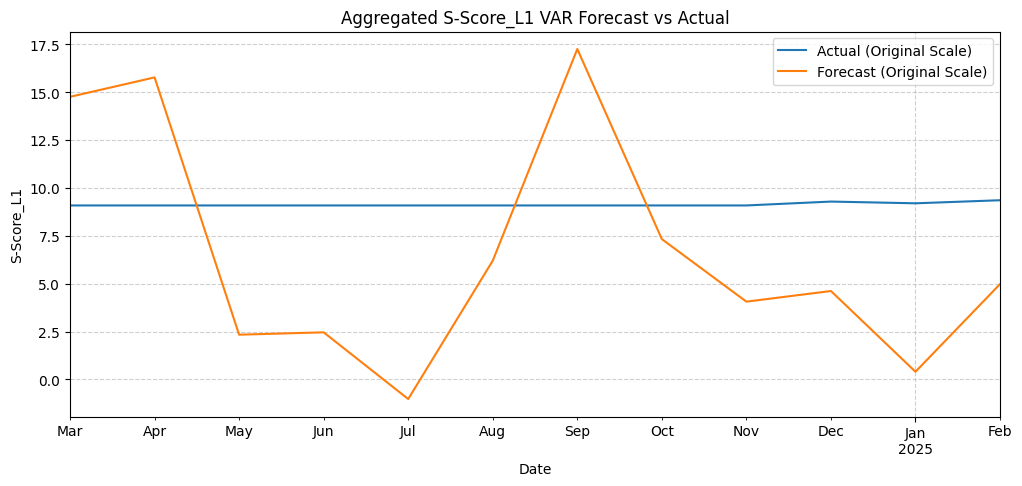

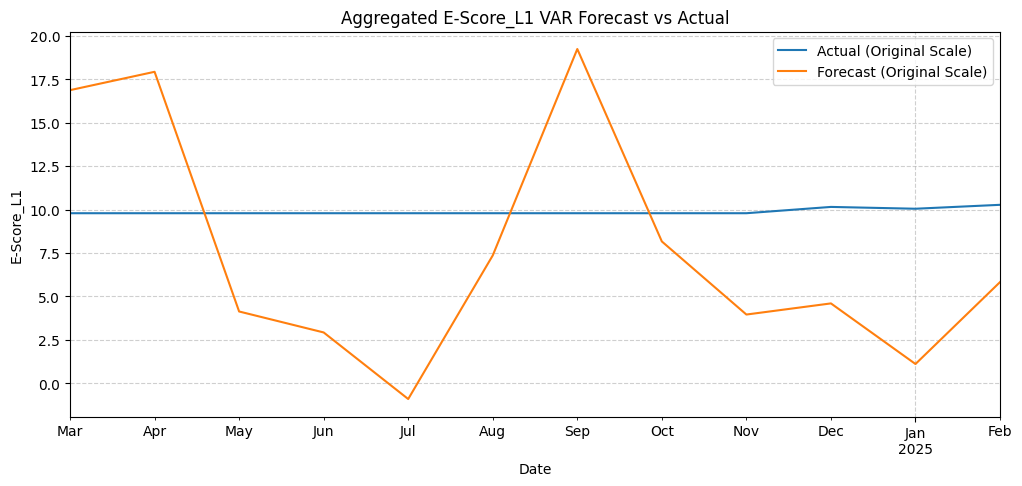

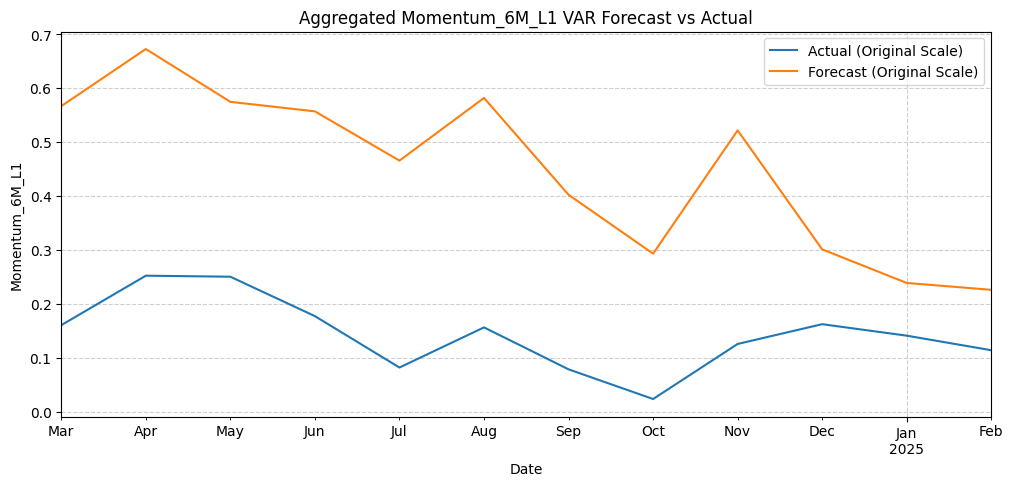

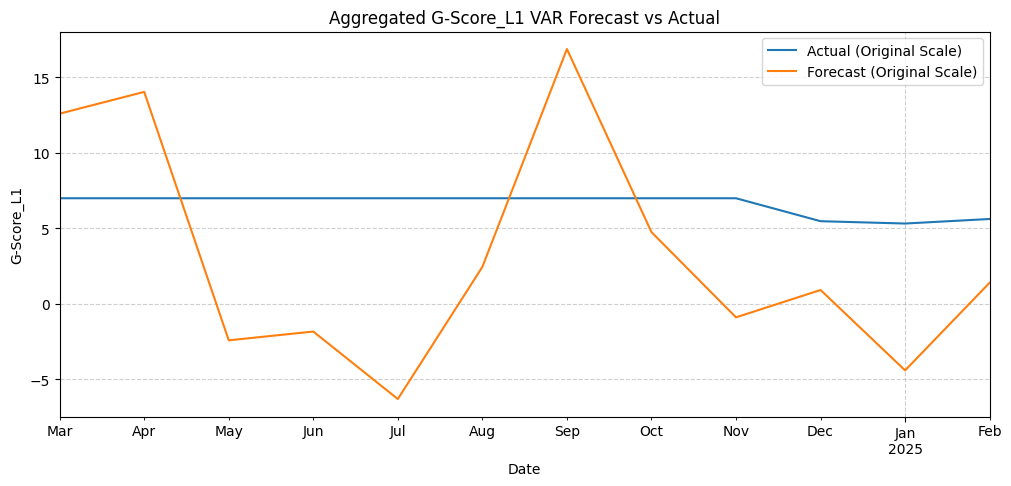

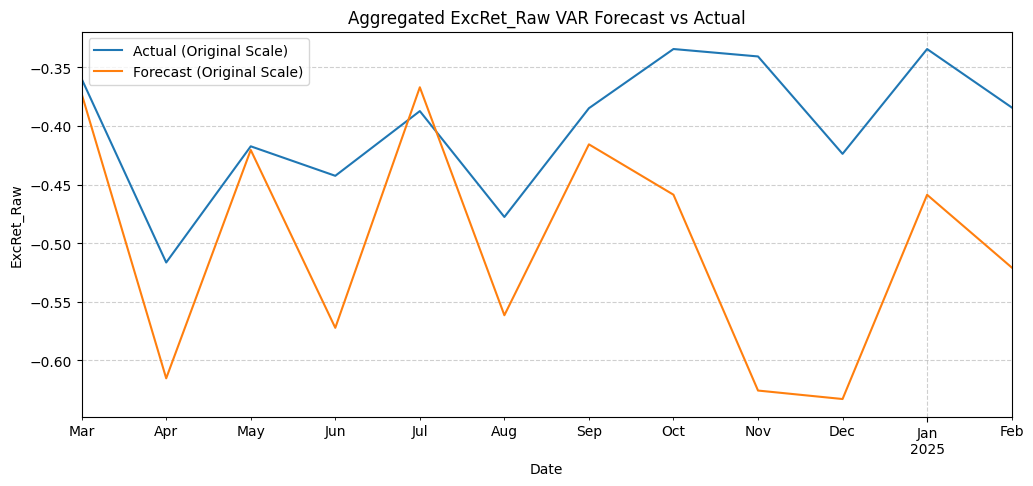

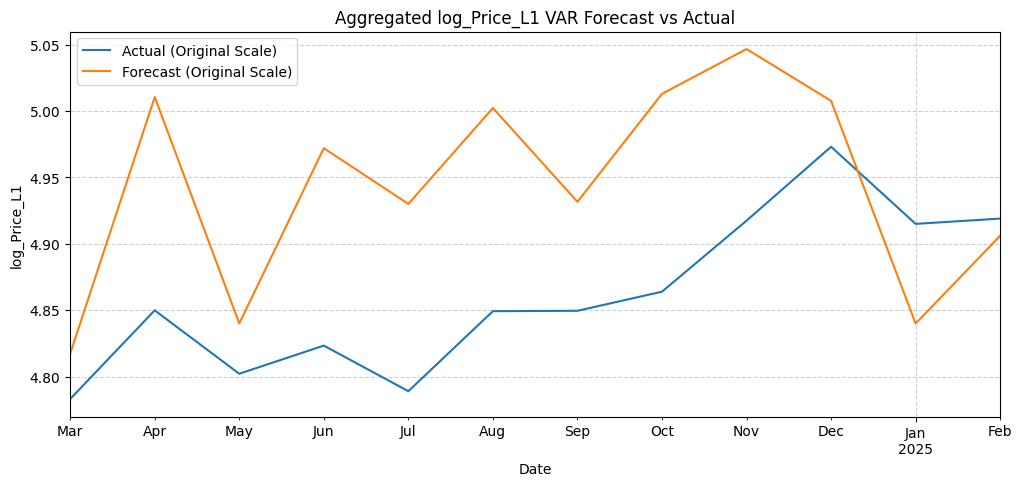

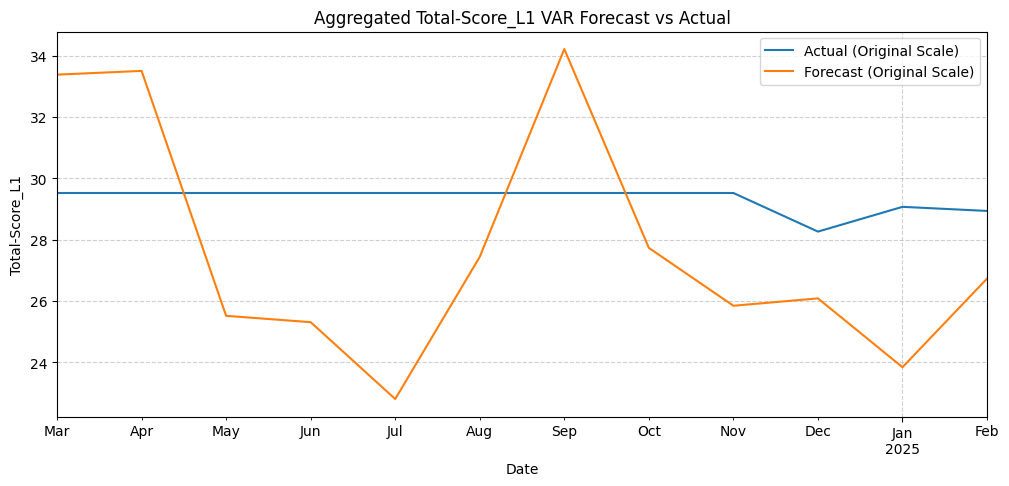


  VAR Modeling Placeholder complete.

--- Machine Learning Modeling (Placeholder: XGBoost) ---
Machine learning models like XGBoost can capture non-linear relationships and interactions.
They typically require splitting data into training and testing sets and using cross-validation.
They usually *do not* handle panel structure (like FE/RE) directly in the same way as econometric models, treating each observation as independent.
Feature engineering and selection are crucial for ML models.

--- Additional Analysis and Visualization (Placeholder) ---
This section can be used for:
1. Visualizing key relationships (e.g., ESG vs. future returns).
2. Plotting model residuals.
3. Analyzing coefficient stability over time or across subsamples.
4. Running robustness checks (e.g., alternative ESG measures, different control sets).
5. Performing event studies around significant ESG disclosures (requires more granular data).
6. Plotting time series trends of ESG scores or returns.

--- Analysis Co

In [62]:
# CELL 1: Install and Import Libraries
# --------------------------------------------------------------------
# Ensure all necessary libraries are listed for installation
!pip install linearmodels yfinance openpyxl statsmodels scikit-learn xgboost matplotlib seaborn tabulate pandas numpy scipy

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller # Import adfuller for stationarity test
from statsmodels.tsa.api import VAR # Import VAR model

# Import IterativeImputer explicitly as it's no longer experimental in recent sklearn
try:
    from sklearn.impute import IterativeImputer
except ImportError:
    # For older sklearn versions
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer

from sklearn.linear_model import BayesianRidge
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from linearmodels.panel.data import PanelData
# FIX: Adjust import from linearmodels.panel.results
# PanelResults is the base class, PooledOLSResults inherits from it.
# Importing PanelResults might be sufficient for type checking.
# We still need PanelEffectsResults and RandomEffectsResults specifically.
try:
    from linearmodels.panel.results import PanelEffectsResults, RandomEffectsResults, PanelResults # Removed PooledOLSResults as it caused ImportError
    # We will rely on PooledOLSResults inheriting from PanelResults for type checks.
    # We still need PanelEffectsResults and RandomEffectsResults specifically.
except ImportError as e:
    print(f"Error importing linearmodels results classes: {e}")
    print("Panel models may not run correctly or tables may not be generated.")
    # Define dummy classes to prevent NameError in subsequent code if import fails completely
    PanelEffectsResults = type('PanelEffectsResults', (object,), {})
    RandomEffectsResults = type('RandomEffectsResults', (object,), {})
    PanelResults = type('PanelResults', (object,), {}) # Base dummy class


from statsmodels.regression.linear_model import RegressionResultsWrapper # For statsmodels OLS results


from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, KFold # Import KFold for fallback CV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
# from statsmodels.tsa.api import VAR # Already imported above now
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from collections import OrderedDict
import yfinance as yf
import requests
import zipfile
import io
import os
import scipy.stats as stats # For t-tests, F-tests if needed manually

# Check for pyeconometrics for GMM (Optional, often not installed by default)
try:
    from pyeconometrics.panel import PanelGMM
    GMM_AVAILABLE = True
    print("pyeconometrics available. GMM models placeholder will be included.")
except ImportError:
    GMM_AVAILABLE = False
    print("pyeconometrics not available/not installed. GMM models will be skipped.")


VIF_THRESHOLD = 10 # Relaxed VIF for models with many controls; can be 5 if preferred
RANDOM_STATE = 42
LAG_PERIODS = 1 # Number of periods to lag independent variables
SIGNIFICANCE_LEVEL = 0.05

# --- Helper function for creating results tables ---
def create_results_table(model_results, model_name="Model", custom_var_names=None, suppress_dummies=True, dummy_prefixes=['entity_dummy_', 'time_dummy_'], df_model_data=None):
    """
    Generates a formatted table from regression results.

    Args:
        model_results: Fitted model results object (statsmodels or linearmodels).
        model_name (str): Name for the model in the table footer.
        custom_var_names (dict, optional): Dictionary to rename variables. Defaults to None.
        suppress_dummies (bool, optional): Whether to suppress dummy variable coefficients. Defaults to True.
        dummy_prefixes (list, optional): List of prefixes to identify dummy variables.
                                         Defaults to ['entity_dummy_', 'time_dummy_'].
        df_model_data (pd.DataFrame, optional): The DataFrame used to fit the model.
                                               Used to count entities/time periods for statsmodels results.
                                               Defaults to None.

    Returns:
        str: A formatted string table of the results or an error message.
    """
    # Check if model_results is a valid fitted object
    if model_results is None:
        return f"Could not generate table for {model_name}: Model results are None."
    if not hasattr(model_results, 'params'):
         print(f"Warning: Model results object for {model_name} does not have a 'params' attribute.")
         return f"Could not generate table for {model_name}: Invalid model results object type: {type(model_results).__name__}"


    # --- Extract Core Results ---
    params = model_results.params

    # Robustly get p-values
    p_values = None
    if hasattr(model_results, 'pvalues'):
        p_values = model_results.pvalues
    elif hasattr(model_results, 'pval'):
        # linearmodels results often have pval Series/attribute
        p_values = model_results.pval
    # Ensure p_values is a Series with the same index as params
    if p_values is None or not isinstance(p_values, pd.Series):
         p_values = pd.Series(np.nan, index=params.index)


    # Robustly get standard errors
    std_errs = None
    if hasattr(model_results, 'std_errors'):
        std_errs = model_results.std_errors
    elif hasattr(model_results, 'bse'):
        # statsmodels results use bse (standard errors)
        std_errs = model_results.bse
    # Ensure std_errs is a Series with the same index as params
    if std_errs is None or not isinstance(std_errs, pd.Series):
         std_errs = pd.Series(np.nan, index=params.index)


    results_df = pd.DataFrame({
        'Variable': params.index,
        'Coefficient': params.values,
        'Std. Error': std_errs.values, # Use .values just in case index is not perfectly aligned, relies on order
        'P-value': p_values.values     # Use .values
    })

    # Apply custom variable names if provided
    if custom_var_names:
         results_df['Variable'] = results_df['Variable'].replace(custom_var_names)


    # Suppress dummies for LSDV models
    if suppress_dummies and isinstance(model_results, RegressionResultsWrapper):
        is_dummy = pd.Series(False, index=results_df.index) # Use results_df index
        for prefix in dummy_prefixes:
            is_dummy = is_dummy | results_df['Variable'].astype(str).str.startswith(prefix)
        # Ensure we filter and then copy
        results_df = results_df[~is_dummy].copy()


    # Add significance stars
    stars = []
    # Ensure P-value column exists and has non-NaN values before adding stars
    if 'P-value' in results_df.columns and not results_df['P-value'].isnull().all():
        # Convert to numeric just in case, coercing errors
        p_vals_numeric = pd.to_numeric(results_df['P-value'], errors='coerce')
        for p_val in p_vals_numeric:
            if pd.isna(p_val): stars.append('')
            elif p_val < 0.01: stars.append('***')
            elif p_val < 0.05: stars.append('**')
            elif p_val < 0.1: stars.append('*')
            else: stars.append('')
    else:
         # If no P-values or all are NaN, just add empty stars
         stars = [''] * len(results_df)

    results_df['Sig.'] = stars

    # Format coefficient with stars
    results_df['Coefficient_Formatted'] = results_df.apply(lambda r: f"{r['Coefficient']:.4f}{r['Sig.']}" if pd.notna(r['Coefficient']) else "N/A", axis=1)

    display_cols = ['Variable', 'Coefficient_Formatted', 'Std. Error', 'P-value']

    # Ensure P-value and Std. Error columns are numeric for consistent floatfmt
    # Use errors='coerce' to turn unparseable values into NaN
    results_df['P-value'] = pd.to_numeric(results_df['P-value'], errors='coerce')
    results_df['Std. Error'] = pd.to_numeric(results_df['Std. Error'], errors='coerce')


    results_df_display = results_df[display_cols].copy() # Use copy()
    results_df_display.rename(columns={'Coefficient_Formatted': 'Coefficient'}, inplace=True)

    # --- Summary Stats ---
    summary_stats = OrderedDict()
    summary_stats["Model"] = model_name

    # R-squared variants
    if hasattr(model_results, 'rsquared_overall'): summary_stats["R-sq (Overall)"] = f"{model_results.rsquared_overall:.4f}"
    if hasattr(model_results, 'rsquared_within'): summary_stats["R-sq (Within)"] = f"{model_results.rsquared_within:.4f}"
    if hasattr(model_results, 'rsquared_between'): summary_stats["R-sq (Between)"] = f"{model_results.rsquared_between:.4f}"
    # R-squared (statsmodels or general linearmodels if no within/between)
    if hasattr(model_results, 'rsquared') and not any(k.startswith("R-sq") for k in summary_stats.keys()):
        # Check for non-finite R-squared before formatting
        if pd.notna(model_results.rsquared) and np.isfinite(model_results.rsquared):
            summary_stats["R-squared"] = f"{model_results.rsquared:.4f}"
        else:
             summary_stats["R-squared"] = "N/A"
    # Adjusted R-squared (mostly statsmodels)
    if hasattr(model_results, 'rsquared_adj') and isinstance(model_results, RegressionResultsWrapper):
         if pd.notna(model_results.rsquared_adj) and np.isfinite(model_results.rsquared_adj):
            summary_stats["Adj. R-squared"] = f"{model_results.rsquared_adj:.4f}"
         else:
            summary_stats["Adj. R-squared"] = "N/A"


    # Observations
    if hasattr(model_results, 'nobs') and pd.notna(model_results.nobs):
         summary_stats["Observations"] = str(int(model_results.nobs))
    elif hasattr(model_results, 'nobs') and model_results.nobs is None:
         summary_stats["Observations"] = "N/A"


    # Entity/Time info
    # Check specific linearmodels results types first
    if isinstance(model_results, (PanelEffectsResults, RandomEffectsResults)):
        if hasattr(model_results, 'entity_info') and model_results.entity_info and hasattr(model_results.entity_info, 'total'):
             summary_stats["Entities"] = str(model_results.entity_info.total)
        if hasattr(model_results, 'time_info') and model_results.time_info and hasattr(model_results.time_info, 'total'):
             summary_stats["Time Periods"] = str(model_results.time_info.total)
    # Check base PanelResults for PooledOLS, etc.
    elif isinstance(model_results, PanelResults):
        # PanelResults might not have entity/time_info attributes directly, or they might be None.
        # Attempt to infer from the index if it's a MultiIndex, or from passed data.
        if hasattr(model_results.model, 'data') and hasattr(model_results.model.data, 'index') and isinstance(model_results.model.data.index, pd.MultiIndex):
             summary_stats["Entities"] = str(model_results.model.data.index.get_level_values(0).nunique())
             summary_stats["Time Periods"] = str(model_results.model.data.index.get_level_values(1).nunique())
        # Fallback to passed df_model_data if available
        elif df_model_data is not None and 'Ticker_Str' in df_model_data.columns and 'Date' in df_model_data.columns:
             summary_stats["Entities"] = str(df_model_data['Ticker_Str'].nunique())
             summary_stats["Time Periods"] = str(df_model_data['Date'].nunique())

    elif isinstance(model_results, RegressionResultsWrapper) and df_model_data is not None:
         # For Statsmodels results (like LSDV/Pooled OLS), get counts from the data used
         # Check for 'Ticker_Str' or 'Ticker'
         if 'Ticker_Str' in df_model_data.columns and 'Date' in df_model_data.columns:
             summary_stats["Entities"] = str(df_model_data['Ticker_Str'].nunique())
             summary_stats["Time Periods"] = str(df_model_data['Date'].nunique())
         elif 'Ticker' in df_model_data.columns and 'Date' in df_model_data.columns:
             summary_stats["Entities"] = str(df_model_data['Ticker'].nunique())
             summary_stats["Time Periods"] = str(df_model_data['Date'].nunique())


    # F-statistic or Wald Test (Model)
    # Prefer robust F-stat from linearmodels
    f_stat_attr = getattr(model_results, 'f_statistic_robust', None)
    # Fallback to non-robust F-stat from linearmodels (PanelOLS, RandomEffects, PooledOLS)
    if f_stat_attr is None: f_stat_attr = getattr(model_results, 'f_statistic', None)
    # Fallback to Statsmodels OLS F-value/p-value if available (e.g., LSDV)
    if f_stat_attr is None and hasattr(model_results, 'fvalue') and hasattr(model_results, 'f_pvalue'):
        # Check if the F-statistic and p-value are plausible (e.g., F-value >= 0, p-value >= 0)
        # Statsmodels OLS F-value with clustered errors can be unreliable/negative.
        # Only report if statistically meaningful.
        if pd.notna(model_results.fvalue) and model_results.fvalue >= 0 and pd.notna(model_results.f_pvalue) and model_results.f_pvalue >= 0:
            f_stat_attr = type('obj', (object,), {'stat': model_results.fvalue, 'pval': model_results.f_pvalue})
        else:
             # If F-stat is suspect or missing, check for a robust Wald test in Statsmodels
             if isinstance(model_results, RegressionResultsWrapper) and hasattr(model_results, 'wald_test_terms'):
                 try:
                     # Perform Wald test on all terms excluding the constant
                     # Identify non-constant, non-dummy terms from the original model params
                     original_params_index = model_results.params.index
                     non_const_terms_params = [term for term in original_params_index if term != 'const' and not any(term.startswith(p) for p in dummy_prefixes)]

                     if non_const_terms_params:
                         # Note: This tests the hypothesis that the coefficients on `non_const_terms_params` are jointly zero.
                         # This is a valid test for overall significance of the *non-fixed-effect* regressors.
                         wald_res = model_results.wald_test_terms(terms=non_const_terms_params, skip_term='const')
                         if hasattr(wald_res, 'statistic') and hasattr(wald_res, 'pvalue') and pd.notna(wald_res.statistic) and pd.notna(wald_res.pvalue):
                              summary_stats["Wald Test (Model, ex-FE)"] = f"{wald_res.statistic:.4f} (p={wald_res.pvalue:.4f})"
                         # Note: This is Chi-squared, not F.

                 except Exception as e_wald:
                      # print(f"Warning: Error running Wald test: {e_wald}")
                      pass # Suppress Wald test error in table creation
             # Also check for linearmodels joint Wald test if applicable (sometimes available when F is not)
             elif hasattr(model_results, 'wald_test_joint'): # linearmodels joint Wald test
                  try:
                      wald_res = model_results.wald_test_joint() # May require specific structure
                      if hasattr(wald_res, 'stat') and hasattr(wald_res, 'pval') and pd.notna(wald_res.stat) and pd.notna(wald_res.pval):
                         summary_stats["Wald Test (Model, LM Joint)"] = f"{wald_res.stat:.4f} (p={wald_res.pval:.4f})"
                      # Note: Also Chi-squared.
                  except Exception as e_wald_lm:
                       # print(f"Warning: Error running LM Wald test: {e_wald_lm}")
                       pass # Suppress error


    # Report F-statistic if a valid one was found
    if f_stat_attr and hasattr(f_stat_attr, 'stat') and hasattr(f_stat_attr, 'pval'):
         if pd.notna(f_stat_attr.stat) and pd.notna(f_stat_attr.pval):
             summary_stats["F-statistic (Model)"] = f"{f_stat_attr.stat:.4f} (p={f_stat_attr.pval:.4f})"
         else:
             summary_stats["F-statistic (Model)"] = "N/A (P-value NaN)"


    footer_list = [f"{k}: {v}" for k,v in summary_stats.items()]
    footer_text = "\n" + "\n".join(footer_list) + "\nSignificance: *** p<0.01, ** p<0.05, * p<0.1"

    if suppress_dummies and isinstance(model_results, RegressionResultsWrapper) and any(idx.startswith(tuple(dummy_prefixes)) for idx in model_results.params.index): # Check original params for dummies
        footer_text += "\n(Dummy variable coefficients suppressed for LSDV model tables)"
    # Add a note about potentially unreliable F-stat for Statsmodels OLS with clustered errors
    if isinstance(model_results, RegressionResultsWrapper) and hasattr(model_results, 'cov_type') and 'cluster' in model_results.cov_type:
         if f_stat_attr is None or (hasattr(f_stat_attr, 'stat') and (pd.isna(f_stat_attr.stat) or f_stat_attr.stat < 0)):
             footer_text += "\n(Note: OLS F-statistic with clustered errors can be unreliable or negative. See Wald Test.)"


    # Define floatfmt for tabulate based on the display columns
    floatfmt_dict = {
        'Coefficient': ".4f",
        'Std. Error': ".4f",
        'P-value': ".4f"
    }
    # Create the tuple format for tabulate, handling columns that might be missing
    floatfmt_tuple = []
    for col in results_df_display.columns:
        floatfmt_tuple.append(floatfmt_dict.get(col, None))


    return tabulate(results_df_display, headers='keys', tablefmt='psql', floatfmt=floatfmt_tuple, showindex=False) + footer_text


def create_model_selection_test_table(test_data_list):
    if not test_data_list: return "No model selection test data to display."
    df = pd.DataFrame(test_data_list)
    # Define preferred column order, but only include columns present in the DataFrame
    cols_order = ['Test Name', 'Statistic Value', 'P-value', 'DF', 'Decision']
    df_cols = [col for col in cols_order if col in df.columns]
    df = df[df_cols]

    # Format numeric columns for tabulate
    floatfmt = []
    for col in df_cols:
        if col in ['Statistic Value', 'P-value']:
            floatfmt.append(".4f")
        elif col == 'DF':
            floatfmt.append(".0f") # Assuming DF is integer
        else:
            floatfmt.append(None) # Default formatting

    return tabulate(df, headers='keys', tablefmt='psql', showindex=False, floatfmt=floatfmt)

# Helper function for stationarity test from tutorial
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'  Augmented Dickey-Fuller Test: {title}')
    # Ensure series is numeric and drop NaNs before test
    series_clean = pd.to_numeric(series, errors='coerce').dropna()

    if len(series_clean) < 10: # Ad hoc minimum for test to be somewhat meaningful
         print(f"    Skipping ADF test for '{title}': Insufficient non-missing data ({len(series_clean)}).")
         return {'stat': np.nan, 'pval': 1.0, 'lags': np.nan, 'obs': np.nan, 'critical': {}} # Indicate non-stationarity likely

    try:
        result = adfuller(series_clean,autolag='AIC') # .dropna() handles differenced data
        labels = ['ADF test statistic','p-value','# lags used','# observations']
        out = pd.Series(result[0:4],index=labels)
        for key,val in result[4].items():
            out[f'critical value ({key})']=val
        print(out.to_string())          # .to_string() removes the line "dtype: float64"
        if result[1] <= SIGNIFICANCE_LEVEL:
            print("    Strong evidence against the null hypothesis")
            print("    Reject the null hypothesis")
            print("    Data has no unit root and is stationary")
        else:
            print("    Weak evidence against the null hypothesis")
            print("    Fail to reject the null hypothesis")
            print("    Data has a unit root and is non-stationary")
        return {'stat': result[0], 'pval': result[1], 'lags': result[2], 'obs': result[3], 'critical': result[4]}
    except Exception as e:
         print(f"    Error during ADF test for '{title}': {e}")
         return {'stat': np.nan, 'pval': 1.0, 'lags': np.nan, 'obs': np.nan, 'critical': {}} # Indicate failure and likely non-stationarity


# CELL 2, 3, 4, 5, 6, 7: Data Loading and Initial Preprocessing
# Data loading and initial processing block remains largely unchanged
from google.colab import files
print("Please upload BOTH 'historic_esg_scores_construction.csv' AND your Fama-French factor file (e.g., 'Developed_5_Factors_Momentum.csv').")
uploaded_files = files.upload()

df_esg = pd.DataFrame()
df_ff_raw = pd.DataFrame()

esg_target_filename_base = 'historic_esg_scores_construction'
ff_target_filename_base = 'Developed_5_Factors_Momentum' # Or 'F-F_Research_Data_5_Factors_2x3_Daily' etc. Adjust as needed.

esg_uploaded = False
ff_uploaded = False

for filename_uploaded, content in uploaded_files.items():
    if esg_target_filename_base.lower() in filename_uploaded.lower():
        try:
            # Assuming CSV for now based on prompt
            df_esg = pd.read_csv(io.BytesIO(content))
            print(f"\nESG data '{filename_uploaded}' loaded successfully into df_esg.")
            esg_uploaded = True
        except Exception as e:
            print(f"Error loading ESG file '{filename_uploaded}': {e}")
    elif ff_target_filename_base.lower() in filename_uploaded.lower():
        try:
            # Assuming CSV for now based on prompt
            df_ff_raw = pd.read_csv(io.BytesIO(content))
            print(f"\nFama-French data '{filename_uploaded}' loaded successfully into df_ff_raw.")
            ff_uploaded = True
        except Exception as e:
             print(f"Error loading FF file '{filename_uploaded}': {e}")
    else:
        print(f"Uploaded file '{filename_uploaded}' does not match expected names ('{esg_target_filename_base}', '{ff_target_filename_base}'). Skipping.")


if not esg_uploaded or df_esg.empty:
    print(f"CRIT ERROR: ESG file matching '{esg_target_filename_base}' not uploaded, read, or is empty.")
    df_esg = pd.DataFrame() # Ensure it's empty if loading failed
if not ff_uploaded or df_ff_raw.empty:
    print(f"CRIT ERROR: FF file matching '{ff_target_filename_base}' not uploaded, read, or is empty.")
    df_ff_raw = pd.DataFrame() # Ensure it's empty if loading failed


# Define a default date range or update based on data
min_overall_date = pd.to_datetime("2000-01-01") # Default start for FF download
max_overall_date = pd.to_datetime("2024-12-31") # Default end for FF download

min_esg_date_actual = None
max_esg_date_actual = None

if not df_esg.empty:
    print("\n--- Preprocessing ESG Data ---")
    # Ensure 'Date' column is datetime, handling potential errors
    df_esg['Date'] = pd.to_datetime(df_esg['Date'], errors='coerce')
    df_esg = df_esg.loc[:, ~df_esg.columns.str.contains('^Unnamed')] # Drop unnamed columns
    df_esg.dropna(subset=['Date', 'Ticker'], inplace=True)

    # Identify ESG score columns - make this more flexible
    esg_cols_initial = ['Total-Score', 'E-Score', 'S-Score', 'G-Score']
    esg_cols = [col for col in esg_cols_initial if col in df_esg.columns]

    if not esg_cols:
        print("CRIT ERROR: No expected ESG score columns found in df_esg.");
        esg_cols = [] # Ensure it's empty if none found
    else:
         print(f"Using ESG columns: {esg_cols}")

    # Convert ESG columns to numeric, coercing errors
    for col in esg_cols:
        df_esg[col] = pd.to_numeric(df_esg[col], errors='coerce')

    # Ensure dates are at month end and remove timezone info if present
    df_esg['Date'] = (df_esg['Date'] + pd.offsets.MonthEnd(0)).dt.tz_localize(None)

    # Drop duplicates, keeping the last score for a given ticker-date
    df_esg = df_esg.drop_duplicates(subset=['Ticker', 'Date'], keep='last')

    print(f"ESG data shape after initial processing: {df_esg.shape}")

    # Update date range based on ESG data, adding buffer for lagged variables and future DV
    if not df_esg.empty:
        min_esg_date_actual = df_esg['Date'].min()
        max_esg_date_actual = df_esg['Date'].max()
        # Need data from LAG_PERIODS+1 months before min ESG date
        min_overall_date = min_esg_date_actual - pd.DateOffset(months=LAG_PERIODS + 1)
        # Need data up to 1 month after max ESG date for the future DV
        max_overall_date = max_esg_date_actual + pd.DateOffset(months=1)
        print(f"Determined overall data range based on ESG: {min_overall_date.strftime('%Y-%m-%d')} to {max_overall_date.strftime('%Y-%m-%d')}")
    else:
        print("Warning: ESG data empty after processing. Using default overall date range for FF/Prices.")

else:
    print("Skipping ESG preprocessing as df_esg is empty.")


print("\n--- Processing Manually Uploaded Fama-French Factors ---")
df_ff = pd.DataFrame()
ff_factor_cols_renamed = [] # Initialize as empty list

if not df_ff_raw.empty:
    try:
        df_ff = df_ff_raw.copy()

        # Attempt to parse the date column (assume first column)
        date_col_name = df_ff.columns[0]
        df_ff.rename(columns={date_col_name: 'Date_str'}, inplace=True, errors='ignore')

        df_ff['Date_str'] = df_ff['Date_str'].astype(str).str.strip()

        date_parsed_successfully = False
        date_formats_to_try = ['%m/%d/%y', '%Y%m%d', '%Y%m', '%Y-%m-%d', '%m/%d/%Y']
        for fmt in date_formats_to_try:
            try:
                df_ff['Date'] = pd.to_datetime(df_ff['Date_str'], format=fmt, errors='raise')
                date_parsed_successfully = True
                print(f"  Parsed FF dates using format: {fmt}")
                break
            except (ValueError, TypeError):
                continue

        if not date_parsed_successfully:
             print("  Specific date formats failed, trying pandas inference for FF dates...")
             df_ff['Date'] = pd.to_datetime(df_ff['Date_str'], errors='coerce')

        df_ff.dropna(subset=['Date'], inplace=True)

        if df_ff.empty:
             raise ValueError("FF DataFrame empty after date parsing.")

        # Ensure FF dates are also end of month and remove timezone info
        df_ff['Date'] = (df_ff['Date'] + pd.offsets.MonthEnd(0)).dt.tz_localize(None)

        # Rename common Fama-French factor columns to consistent names
        factor_rename_map_manual = {
            'Mkt-RF':'Mkt-RF', 'SMB':'SMB', 'HML':'HML',
            'RMW':'RMW', 'CMA':'CMA', 'RF':'RF',
            'WML':'UMD', 'Mom   ':'UMD', 'MOM':'UMD', # Handle different momentum names
            'Mkt_Rf': 'Mkt-RF', 'MKTRF': 'Mkt-RF' # Add more common variations
        }
        df_ff.columns = [col.strip() for col in df_ff.columns] # Strip whitespace
        df_ff.rename(columns=factor_rename_map_manual, inplace=True)

        # Identify the actual FF columns present after renaming
        ff_factor_cols_standard = ['Mkt-RF','SMB','HML','RMW','CMA','RF','UMD']
        actual_ff_cols_present = [col for col in ff_factor_cols_standard if col in df_ff.columns]

        if len(actual_ff_cols_present) < 6: # Check if at least 5 factors + RF are present
            print(f"Warn: Not all expected 5 factors + RF (+ Momentum) found. Present: {actual_ff_cols_present}")

        # Convert factor columns to numeric, handling potential non-numeric entries
        for col in actual_ff_cols_present:
            df_ff[col] = pd.to_numeric(df_ff[col], errors='coerce')
            # Simple check: if mean absolute value is > 0.5 but < 100, assume it's in percent
            # Added check for NaNs in mean calculation
            if col in df_ff.columns and df_ff[col].dropna().abs().mean() > 0.5 and df_ff[col].dropna().abs().mean() < 100 :
                 print(f"  Assuming FF factor '{col}' is in percentage format, dividing by 100.")
                 df_ff[col] = df_ff[col] / 100.0


        # Keep only Date and the identified factor columns
        df_ff = df_ff[['Date'] + actual_ff_cols_present].copy()

        # Drop rows with NaNs in factor columns after conversion/cleaning
        df_ff.dropna(subset=actual_ff_cols_present, how='any', inplace=True)

        # Filter FF data to match the overall date range determined by ESG data + buffer
        if min_overall_date and max_overall_date:
             initial_ff_rows = df_ff.shape[0]
             df_ff = df_ff[(df_ff['Date'] >= min_overall_date) & (df_ff['Date'] <= max_overall_date)].copy()
             if df_ff.shape[0] < initial_ff_rows:
                  print(f"Filtered FF data to match overall date range: {initial_ff_rows} -> {df_ff.shape[0]} rows.")


        print(f"Processed FF data shape: {df_ff.shape}")
        if not df_ff.empty: print(df_ff.head())


        # Store the list of FF factor columns (excluding Date)
        ff_factor_cols_renamed = [col for col in df_ff.columns if col != 'Date']

    except Exception as e:
        print(f"CRIT ERROR processing FF file: {e}")
        df_ff = pd.DataFrame() # Ensure df_ff is empty if processing failed
        ff_factor_cols_renamed = []

else:
    print("FF raw data empty.")

if df_ff.empty:
    print("CRIT: FF data not processed or is empty.")
    ff_factor_cols_renamed = [] # Ensure empty if FF processing failed


# Download stock prices only if ESG data was successfully loaded AND there are tickers
df_prices = pd.DataFrame() # Initialize empty
if not df_esg.empty and 'Ticker' in df_esg.columns and not df_esg['Ticker'].empty:
    print("\n--- Downloading Historical Stock Prices ---")
    tickers_list_orig = df_esg['Ticker'].unique().tolist()
    print(f"Original tickers from ESG file ({len(tickers_list_orig)}): {tickers_list_orig}")

    # Manual ticker mapping for known issues (e.g., J -> J)
    ticker_map_manual = {'CRH': 'CRH', 'J': 'J'} # Add or correct problematic tickers

    all_stock_data_list = []
    successful_tickers_map = {} # To map ESG ticker to successfully downloaded yf ticker

    # Use the overall date range determined earlier
    start_date_yf = min_overall_date.strftime('%Y-%m-%d') if min_overall_date else "2000-01-01"
    end_date_yf = max_overall_date.strftime('%Y-%m-%d') if max_overall_date else "2024-12-31"

    print(f"Downloading stock prices from {start_date_yf} to {end_date_yf}")


    # Limit number of tickers for download if it's very large (optional, for debugging/testing)
    # tickers_to_download = tickers_list_orig[:50] # Example: limit to first 50
    tickers_to_download = tickers_list_orig # Use all tickers from ESG data


    for esg_ticker in tickers_to_download: # Use the list of tickers to download
        yf_ticker_to_try = ticker_map_manual.get(esg_ticker, esg_ticker) # Use mapped ticker or original
        # print(f"Attempting download for ESG '{esg_ticker}' as yf '{yf_ticker_to_try}'...") # Too verbose for many tickers

        try:
            stock = yf.Ticker(yf_ticker_to_try)
            # Download daily data within the determined date range
            hist = stock.history(start=start_date_yf, end=end_date_yf, interval="1d", auto_adjust=True, actions=False)

            if not hist.empty and 'Close' in hist.columns:
                # Resample to monthly, taking the last closing price of the month
                hist_monthly = hist[['Close']].resample('ME').last()
                hist_monthly.rename(columns={'Close': 'Price'}, inplace=True)
                hist_monthly['Ticker_ESG'] = esg_ticker # Keep original ESG ticker identifier
                hist_monthly['Ticker_yf'] = yf_ticker_to_try # Keep yfinance ticker used
                hist_monthly.reset_index(inplace=True) # Date becomes a column again

                # Ensure date is timezone-naive month-end for consistency
                hist_monthly['Date'] = (hist_monthly['Date'] + pd.offsets.MonthEnd(0)).dt.tz_localize(None)

                # Append to list, keeping only necessary columns
                all_stock_data_list.append(hist_monthly[['Date', 'Ticker_ESG', 'Price']]) # Keep Ticker_ESG for merging
                # print(f"  Success: '{esg_ticker}' as '{yf_ticker_to_try}'.") # Too verbose
                successful_tickers_map[esg_ticker] = yf_ticker_to_try # Record successful mapping
            else:
                print(f"  No data or 'Close' column found for '{esg_ticker}' as '{yf_ticker_to_try}'.")

        except Exception as e:
            print(f"  Error downloading data for '{esg_ticker}' as '{yf_ticker_to_try}': {e}")

    if not all_stock_data_list:
        print("CRIT ERROR: No stock data downloaded successfully.")
        df_prices = pd.DataFrame() # Ensure df_prices is empty if no data downloaded
    else:
        df_prices = pd.concat(all_stock_data_list, ignore_index=True)
        print(f"\nDownloaded stock data for {df_prices['Ticker_ESG'].nunique()} unique ESG tickers.")
        print(f"Processed ESG tickers with successful download: {list(successful_tickers_map.keys())}")

else:
    print("Skipping stock price preprocessing: df_prices is empty.")


print("\n--- Preprocessing Stock Price Data & Basic Controls ---")
if not df_prices.empty: # Ensure df_prices is not empty before preprocessing
    df_prices['Date'] = pd.to_datetime(df_prices['Date'], errors='coerce')
    # Ensure dates are month-end and timezone-naive, matching FF/ESG
    df_prices['Date'] = (df_prices['Date'] + pd.offsets.MonthEnd(0)).dt.tz_localize(None)

    # Keep only relevant columns
    df_prices = df_prices[['Date', 'Ticker_ESG', 'Price']].copy()
    df_prices.dropna(subset=['Date', 'Ticker_ESG', 'Price'], inplace=True) # Drop rows with missing essential data

    # Convert Price to numeric
    df_prices['Price'] = pd.to_numeric(df_prices['Price'], errors='coerce')
    df_prices.dropna(subset=['Price'], inplace=True) # Drop rows where Price couldn't be converted


    # Sort data for calculations (ensures correct lags/diffs)
    df_prices.sort_values(by=['Ticker_ESG', 'Date'], inplace=True)

    # Calculate monthly return
    df_prices['Return'] = df_prices.groupby('Ticker_ESG')['Price'].pct_change()

    # Create lagged price (for log_Price_L1) and lagged return (for Momentum)
    if LAG_PERIODS < 1: LAG_PERIODS = 1 # Ensure LAG_PERIODS is at least 1

    # Lagged Price (for Log Price)
    shifted_price = df_prices.groupby('Ticker_ESG')['Price'].shift(LAG_PERIODS)
    shifted_price_no_zero = shifted_price.replace(0, np.nan) # Avoid log(0) - use np.nan
    df_prices['log_Price_L1'] = np.log(shifted_price_no_zero)
    df_prices['log_Price_L1'].replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf/-inf from log(very small number) with NaN

    # Lagged Return
    df_prices['Return_L1'] = df_prices.groupby('Ticker_ESG')['Return'].shift(LAG_PERIODS)

    # Calculate 6-month momentum using lagged returns (sum of last 6 months of returns *before* t)
    # Rolling sum over the *last* 6 months *before* the current month (using Return_L1 if LAG_PERIODS is 1)
    # A common definition is sum of returns from t-1 to t-6. Apply rolling(6) to 'Return' and then shift by 1.
    df_prices['Momentum_6M_L1'] = df_prices.groupby('Ticker_ESG')['Return'].transform(lambda x: x.rolling(window=6, min_periods=3).sum().shift(LAG_PERIODS) )
    # min_periods=3 allows momentum to be calculated even with 3 valid months in the window

    # Drop rows where Return is NaN (these are typically the first row per ticker after pct_change)
    df_prices.dropna(subset=['Return'], inplace=True)

    print(f"Stock price data shape after return & basic controls: {df_prices.shape}")
    if not df_prices.empty: print(df_prices[['Ticker_ESG', 'Date', 'Price', 'Return', 'log_Price_L1', 'Momentum_6M_L1']].head(10))

else:
    print("Skipping stock price preprocessing: df_prices is empty.")


print("\n--- Merging DataFrames ---")
df_panel = pd.DataFrame() # Initialize merged df

# Check if all required DataFrames are available and not empty
if df_prices.empty: print("Cannot merge: stock price data missing or empty.")
if df_ff.empty: print("Cannot merge: Fama-French data missing or empty.")
if df_esg.empty: print("Cannot merge: ESG data missing or empty.")


if not df_prices.empty and not df_ff.empty and not df_esg.empty:
    try:
        # Merge stock prices with Fama-French factors on Date
        df_merged = pd.merge(df_prices, df_ff, on='Date', how='inner')

        # Merge the result with ESG data on Ticker and Date
        # Use Ticker_ESG from df_merged and Ticker from df_esg
        df_panel = pd.merge(df_merged, df_esg, left_on=['Ticker_ESG', 'Date'], right_on=['Ticker', 'Date'], how='inner')

        # Drop the redundant Ticker_ESG column if it exists and Ticker is the intended key
        if 'Ticker_ESG' in df_panel.columns and 'Ticker' in df_panel.columns and 'Ticker_ESG' != 'Ticker':
            df_panel.drop(columns=['Ticker_ESG'], inplace=True, errors='ignore')
            # Ensure the primary identifier is named 'Ticker' for consistency
            df_panel.rename(columns={'Ticker': 'Ticker'}, inplace=True, errors='ignore') # Renaming Ticker to Ticker is safe


        # Filter the merged data to the date range of the ESG data (inclusive)
        # This ensures we only have periods where we potentially have ESG scores
        if min_esg_date_actual and max_esg_date_actual:
            initial_panel_rows = df_panel.shape[0]
            df_panel = df_panel[(df_panel['Date'] >= min_esg_date_actual) & (df_panel['Date'] <= max_esg_date_actual)].copy()
            if df_panel.shape[0] < initial_panel_rows:
                 print(f"Filtered merged data to ESG date range: {initial_panel_rows} -> {df_panel.shape[0]} rows.")


        # Define columns essential for subsequent steps *before* the final dropna
        # This includes DV, identifiers, original ESG, and original FF before lagging/leading
        # The DV 'Return' is needed before calculating ExcRet_Raw
        essential_initial_cols = ['Return', 'Ticker', 'Date']
        # Add RF if present in FF data for ExcRet calculation
        if 'RF' in ff_factor_cols_renamed and 'RF' in df_panel.columns:
             essential_initial_cols.append('RF')
        # Add original ESG columns if present
        essential_initial_cols.extend([col for col in esg_cols if col in df_panel.columns])
        # Add original FF factors if present
        essential_initial_cols.extend([col for col in ff_factor_cols_renamed if col != 'RF' and col in df_panel.columns])
         # Add original Price for lagged price calculation
        if 'Price' in df_panel.columns: essential_initial_cols.append('Price')

        # Ensure uniqueness and filter for columns actually present in df_panel
        essential_initial_cols = list(set(essential_initial_cols))
        essential_initial_cols = [col for col in essential_initial_cols if col in df_panel.columns]


        # Drop rows with NaNs in these *very* essential columns early
        if essential_initial_cols:
             initial_rows = df_panel.shape[0]
             # Dropna on a copy to avoid modifying the original df_panel in case of issues
             df_panel_cleaned = df_panel.dropna(subset=essential_initial_cols).copy()
             rows_dropped = initial_rows - df_panel_cleaned.shape[0]
             if rows_dropped > 0:
                 print(f"Dropped {rows_dropped} rows due to NaN in essential columns before lags/leads: {essential_initial_cols}")
             df_panel = df_panel_cleaned # Use the cleaned copy
        else:
            print("Warning: No essential columns identified for early dropna.")


        print(f"Final merged panel data shape: {df_panel.shape}")
        if df_panel.empty:
            print("CRIT ERROR: Merged panel data is empty after initial cleaning.")
        else:
            print(df_panel.head())

    except Exception as e:
        print(f"CRIT ERROR during merging: {e}")
        df_panel = pd.DataFrame() # Ensure df_panel is empty if merge failed


# CELL 8: Define Dependent Variable, Prepare Controls, and Lagging
dependent_var_name = '' # Initialize as empty string
ff_controls_for_regression = []
lagged_firm_controls_list = []

# Proceed only if df_panel is not empty and 'RF' is present
if not df_panel.empty and 'RF' in df_panel.columns:
    print("\n--- Defining Dependent Variable & Lagging Controls ---")
    # Define dependent variable (Excess Return)
    df_panel['ExcRet_Raw'] = df_panel['Return'] - df_panel['RF']

    dependent_var_name = 'ExcRet_Raw'
    print(f"Using '{dependent_var_name}' as the dependent variable.")

    # Create lagged Fama-French factors for use as controls
    if 'ff_factor_cols_renamed' not in locals() or not ff_factor_cols_renamed:
        ff_factor_cols_renamed = []
        print("Warning: FF factor column names not available. Cannot create lagged FF controls.")
        temp_ff_controls_lagged = []
    else:
        temp_ff_controls_lagged = []
        df_panel = df_panel.sort_values(['Ticker', 'Date']) # Ensure sorted for shifting
        for ff_col in [col for col in ff_factor_cols_renamed if col != 'RF' and col in df_panel.columns]:
             df_panel[f'{ff_col}_L{LAG_PERIODS}'] = df_panel.groupby('Ticker')[ff_col].shift(LAG_PERIODS)
             temp_ff_controls_lagged.append(f'{ff_col}_L{LAG_PERIODS}')

    ff_controls_for_regression = [col for col in temp_ff_controls_lagged if col in df_panel.columns]
    print(f"Lagged Fama-French factors to be used as controls: {ff_controls_for_regression}")

    # Re-calculate lagged firm controls *after* the potential early dropna
    lagged_firm_controls_list = []
    df_panel = df_panel.sort_values(['Ticker', 'Date']) # Ensure sorted again
    if 'Price' in df_panel.columns:
        shifted_price = df_panel.groupby('Ticker')['Price'].shift(LAG_PERIODS)
        shifted_price_no_zero = shifted_price.replace(0, np.nan)
        df_panel['log_Price_L1'] = np.log(shifted_price_no_zero)
        df_panel['log_Price_L1'].replace([np.inf, -np.inf], np.nan, inplace=True)
        lagged_firm_controls_list.append('log_Price_L1')

    if 'Return' in df_panel.columns: # Use original Return column before ExcRet calc
        df_panel['Momentum_6M_L1'] = df_panel.groupby('Ticker')['Return'].transform(lambda x: x.rolling(window=6, min_periods=3).sum().shift(LAG_PERIODS) )
        lagged_firm_controls_list.append('Momentum_6M_L1')

    lagged_firm_controls_list = [col for col in lagged_firm_controls_list if col in df_panel.columns] # Filter to existing
    if not lagged_firm_controls_list: print("WARNING: No firm-specific control variables were processed.")
    else: print(f"Lagged firm controls: {lagged_firm_controls_list}")


    # Check if dependent variable was created successfully and is not all NaNs
    if df_panel.empty or dependent_var_name not in df_panel.columns or df_panel[dependent_var_name].isnull().all():
        print(f"CRIT ERROR: Panel data empty or dependent variable ('{dependent_var_name}') is missing or all NaN after creation.")
        df_panel = pd.DataFrame() # Clear df_panel if DV is invalid
        dependent_var_name = '' # Reset DV name
else:
    print("Skipping dependent variable definition: df_panel empty or 'RF' column missing.")
    df_panel = pd.DataFrame() # Clear df_panel
    dependent_var_name = '' # Reset DV name


# CELL 9: Create Lagged ESG Variables and Target Future Dependent Variable
lagged_esg_cols = []
delta_esg_cols = []
core_modeling_cols = [] # List to hold all columns needed for final dropna

# Proceed only if df_panel is not empty and dependent variable is defined and esg_cols available
if not df_panel.empty and dependent_var_name and dependent_var_name in df_panel.columns and 'esg_cols' in locals() and esg_cols:
    print("\n--- Creating Lagged ESG, Deltas, and Future Dependent Variable ---")

    df_panel = df_panel.sort_values(['Ticker', 'Date']) # Ensure sorted for correct lagging/leading

    # Create the future dependent variable (e.g., future excess return)
    future_dv_col = f'{dependent_var_name}_F1'
    df_panel[future_dv_col] = df_panel.groupby('Ticker')[dependent_var_name].shift(-1)
    core_modeling_cols.append(future_dv_col)


    # Create lagged ESG variables and delta (change) in ESG variables
    for esg_col in esg_cols:
        if esg_col in df_panel.columns: # Ensure original ESG column exists
            # Lagged ESG
            lag_col_name = f'{esg_col}_L{LAG_PERIODS}'
            df_panel[lag_col_name] = df_panel.groupby('Ticker')[esg_col].shift(LAG_PERIODS)
            lagged_esg_cols.append(lag_col_name)
            core_modeling_cols.append(lag_col_name)


            # Delta ESG (Change from t-LAG_PERIODS-1 to t-LAG_PERIODS)
            delta_col_name = f'delta_{esg_col}_L{LAG_PERIODS}'
            # Need t-(LAG_PERIODS+1) value to calculate change
            # Create temporary column for this calculation
            temp_lag_plus_1_col = f'_{esg_col}_L{LAG_PERIODS+1}_temp' # Use a less likely name to clash
            df_panel[temp_lag_plus_1_col] = df_panel.groupby('Ticker')[esg_col].shift(LAG_PERIODS+1)

            # Calculate delta if both required lagged columns exist after shifts
            # Need lag_col_name and temp_lag_plus_1_col
            # Check if the columns were successfully created (i.e., original esg_col existed)
            if lag_col_name in df_panel.columns and temp_lag_plus_1_col in df_panel.columns:
                df_panel[delta_col_name] = df_panel[lag_col_name] - df_panel[temp_lag_plus_1_col]
                delta_esg_cols.append(delta_col_name)
                core_modeling_cols.append(delta_col_name)
            else:
                 print(f"Warning: Could not create delta for '{esg_col}_L{LAG_PERIODS}' (required lags missing).")


            # Drop the temporary doubly-lagged column
            df_panel.drop(columns=[temp_lag_plus_1_col], inplace=True, errors='ignore')
        else:
            print(f"Warning: Original ESG column '{esg_col}' not found in df_panel. Cannot create lagged/delta ESG.")


    # Add other predictor controls to the list of core modeling columns for final dropna
    current_ff_controls = ff_controls_for_regression if 'ff_controls_for_regression' in locals() else []
    current_firm_controls = lagged_firm_controls_list if 'lagged_firm_controls_list' in locals() else []

    core_modeling_cols.extend([col for col in current_firm_controls if col in df_panel.columns])
    core_modeling_cols.extend([col for col in current_ff_controls if col in df_panel.columns])


    # Ensure uniqueness and filter to columns actually existing in df_panel
    core_modeling_cols = list(set(core_modeling_cols))
    core_modeling_cols = [col for col in core_modeling_cols if col in df_panel.columns]


    # Drop rows with NaNs in any of these critical columns required for modeling
    if core_modeling_cols: # Only attempt dropna if there are columns to check
        initial_rows = df_panel.shape[0]
        # Dropna on a copy to avoid modifying the original df_panel in case of issues
        df_panel_cleaned = df_panel.dropna(subset=core_modeling_cols, ignore_index=True).copy() # Use ignore_index=True after dropping
        rows_dropped = initial_rows - df_panel_cleaned.shape[0]
        if rows_dropped > 0:
            print(f"Dropped {rows_dropped} rows due to NaN in required modeling columns: {core_modeling_cols}")
        df_panel = df_panel_cleaned # Assign the cleaned DataFrame back
    else:
        print("Warning: No core modeling columns identified for final dropna.")


    print(f"Panel shape after lags/leads/deltas & final dropna: {df_panel.shape}")

    if df_panel.empty:
        print(f"CRIT ERROR: Panel data is empty after creating lags/leads/deltas and dropping NaNs.")
    else:
        print(df_panel.head())

else:
    print("Skipping lags/leads/deltas creation: df_panel empty, dependent variable missing/invalid, or ESG columns missing.")


# CELL 10: Imputation
# Imputation block remains largely unchanged, useful if NaNs exist in *non-essential* predictors
# after creating lags/deltas but before the final dropna
if not df_panel.empty and core_modeling_cols: # Ensure df_panel is not empty and we have cols to check
    print("\n--- Imputation for Predictor Variables ---")

    # The final dropna in Cell 9 should have removed NaNs from `core_modeling_cols`.
    # This imputation step would typically be done *before* that final dropna,
    # to fill in NaNs in predictor variables that might not be in the `core_modeling_cols` list,
    # but are still intended as predictors in some models (e.g., ML features).
    # With the current flow, it might only impute NaNs created *after* the initial merge dropna
    # but *before* the final dropna, which seems less likely if core_modeling_cols covers most predictors.
    # Let's keep it here for now, but acknowledge its potential limited impact if final dropna is aggressive.

    # Identify all potential predictor columns. This list should be comprehensive.
    current_ff_controls = ff_controls_for_regression if 'ff_controls_for_regression' in locals() else []
    current_firm_controls = lagged_firm_controls_list if 'lagged_firm_controls_list' in locals() else []
    predictor_cols_for_imputation = list(set(lagged_esg_cols + delta_esg_cols + current_firm_controls + current_ff_controls))
    # Filter this list to ensure columns actually exist in df_panel at this stage
    predictor_cols_for_imputation = [col for col in predictor_cols_for_imputation if col in df_panel.columns]


    if predictor_cols_for_imputation:
        # Select only the columns to impute
        df_to_impute = df_panel[predictor_cols_for_imputation].copy()

        # Check if there are any NaNs in these specific predictor columns
        nan_counts = df_to_impute.isnull().sum()
        nan_cols = nan_counts[nan_counts > 0]

        if not nan_cols.empty:
            print(f"NaNs before imputation:\n{nan_cols.sort_values(ascending=False)}")

            # Initialize the IterativeImputer with BayesianRidge estimator
            # Increased max_iter slightly for robustness
            imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=20, random_state=RANDOM_STATE, tol=1e-4)

            try:
                # Apply imputation to the selected predictor columns
                # The imputer returns a numpy array; assign it back to the DataFrame columns
                df_panel[predictor_cols_for_imputation] = imputer.fit_transform(df_to_impute)
                print("Imputation complete.")

                # Verify NaNs are gone in imputed columns
                nan_counts_after = df_panel[predictor_cols_for_imputation].isnull().sum()
                nan_cols_after = nan_counts_after[nan_counts_after > 0]
                if not nan_cols_after.empty:
                    print(f"Warning: NaNs remain in some imputed columns:\n{nan_cols_after}")
                else:
                     print("Imputation verified: No NaNs in target columns after imputation.")


            except Exception as e:
                 print(f"Error during Imputation: {e}")
                 print("Imputation failed.")

        else:
            print("No NaNs found in identified predictors for imputation.")
    else:
        print("No predictor columns identified for imputation.")

else:
    print("Skipping Imputation: df_panel is empty or core modeling columns are missing.")


# CELL 11: Define IV Sets for Panel Models
# This block remains unchanged
panel_model_core_esg_ivs = {}

# Proceed only if df_panel is not empty and esg_cols are available and we have lagged/delta ESG
if not df_panel.empty and 'esg_cols' in locals() and esg_cols and (lagged_esg_cols or delta_esg_cols):
    print("\n--- Defining Core ESG IV Sets for Panel Models ---")

    # Total Score Specifications - only add if lagged/delta columns actually exist after processing/dropna
    if f'Total-Score_L{LAG_PERIODS}' in df_panel.columns:
        panel_model_core_esg_ivs["TotalScore_L1"] = [f'Total-Score_L{LAG_PERIODS}']
    if f'delta_Total-Score_L{LAG_PERIODS}' in df_panel.columns:
        panel_model_core_esg_ivs["delta_TotalScore_L1"] = [f'delta_Total-Score_L{LAG_PERIODS}']
    if f'Total-Score_L{LAG_PERIODS}' in df_panel.columns and f'delta_Total-Score_L{LAG_PERIODS}' in df_panel.columns:
        panel_model_core_esg_ivs["TotalScore_L1_and_Delta"] = [f'Total-Score_L{LAG_PERIODS}', f'delta_Total-Score_L{LAG_PERIODS}']

    # Individual E, S, G Score Specifications - only add if lagged/delta columns actually exist
    for score_comp in ['E-Score', 'S-Score', 'G-Score']:
        if f'{score_comp}_L{LAG_PERIODS}' in df_panel.columns:
            panel_model_core_esg_ivs[f"{score_comp}_L1"] = [f'{score_comp}_L{LAG_PERIODS}']
        if f'delta_{score_comp}_L{LAG_PERIODS}' in df_panel.columns:
            panel_model_core_esg_ivs[f"delta_{score_comp}_L1"] = [f'delta_{score_comp}_L{LAG_PERIODS}']


    print("Defined Panel Model Core ESG IV Specifications:")
    if panel_model_core_esg_ivs:
        for spec_name, ivs in panel_model_core_esg_ivs.items():
            print(f"  {spec_name}: {ivs}")
    else:
        print("  No valid lagged or delta ESG core specifications could be defined.")


else:
    print("Skipping IV set definition as df_panel is empty, esg_cols are missing, or no lagged/delta ESG variables created.")


# CELL 12: Panel Regression Models & Model Selection (Corrected)
# THIS IS THE MAIN PANEL MODELLING BLOCK
panel_model_results_all_specs = {}
panel_model_tables_all_specs = {}
overall_model_selection_summary = []

# Proceed only if df_panel is not empty, core ESG IVs are defined, and the future DV exists
if not df_panel.empty and panel_model_core_esg_ivs and dependent_var_name and f'{dependent_var_name}_F1' in df_panel.columns:
    print("\n--- Panel Regression Modeling (linearmodels & LSDV Fallback) ---")

    # Use the cleaned df_panel directly
    df_reg_base_panel = df_panel.copy()
    # Convert Ticker to string for safety and consistent indexing
    df_reg_base_panel['Ticker_Str'] = df_reg_base_panel['Ticker'].astype(str)
    # Ensure Date is datetime and timezone-naive (should be from preprocessing)
    df_reg_base_panel['Date'] = pd.to_datetime(df_reg_base_panel['Date']).dt.tz_localize(None)


    for spec_name, current_esg_iv_list in panel_model_core_esg_ivs.items():
        if not current_esg_iv_list:
            continue # Skip spec if its core ESG variables are empty

        print(f"\n\n=== Running Panel Models for Specification: {spec_name} ===")

        # Combine core ESG IVs with control variables for this specification
        # Ensure control lists are defined, default to empty list if not
        current_ff_controls = ff_controls_for_regression if 'ff_controls_for_regression' in locals() else []
        current_firm_controls = lagged_firm_controls_list if 'lagged_firm_controls_list' in locals() else []

        ivs_for_this_run_with_controls = list(OrderedDict.fromkeys(current_esg_iv_list + current_ff_controls + current_firm_controls))
        # Filter list to ensure columns exist in the dataframe at this point
        ivs_for_this_run_with_controls = [col for col in ivs_for_this_run_with_controls if col in df_reg_base_panel.columns]

        if not ivs_for_this_run_with_controls:
            print(f"No valid IVs (ESG + Controls) for spec {spec_name}. Skipping.");
            continue
        print(f"IVs for this spec: {ivs_for_this_run_with_controls}")

        # Prepare data for modeling: keep only necessary columns and ensure no NaNs *in these columns*
        # The final dropna in Cell 9 should ensure this, but let's select these columns
        # before VIF and modeling to be explicit.
        cols_for_model_prep = [f'{dependent_var_name}_F1', 'Ticker_Str', 'Date'] + ivs_for_this_run_with_controls
        df_model_prep = df_reg_base_panel[cols_for_model_prep].copy()

        # Ensure the data for VIF check has no NaNs (use the subset of columns identified for the model)
        X_vif_check_data = df_model_prep[ivs_for_this_run_with_controls].copy().replace([np.inf,-np.inf],np.nan).dropna()
        final_ivs_for_this_spec_after_vif = ivs_for_this_run_with_controls # Start with full list


        # --- VIF Check ---
        # Only run VIF check if there are at least 2 features and enough observations relative to features + constant
        if X_vif_check_data.shape[1] >= 2 and X_vif_check_data.shape[0] > X_vif_check_data.shape[1] + 1: # Need N > k+1 for OLS implicitly
            temp_vif_ivs = X_vif_check_data.columns.tolist() # Use columns from the VIF check data
            print(f"  VIF Check for {spec_name} (Initial IVs: {temp_vif_ivs})...")
            # Iteratively remove high-VIF features
            for i_vif in range(len(temp_vif_ivs)): # Limit iterations to number of features
                if len(temp_vif_ivs) < 2:
                    print(f"  VIF Iter ({spec_name}): Only {len(temp_vif_ivs)} feature(s) left, stopping VIF check.")
                    break # Need at least two features for VIF

                X_iter_vif_data = X_vif_check_data[temp_vif_ivs].astype(float) # Use the reduced set for VIF calculation

                # Check for constant columns or zero-variance columns in the current iteration's data
                constant_cols = X_iter_vif_data.columns[(X_iter_vif_data.nunique() < 2) | (X_iter_vif_data.std() == 0)].tolist()
                if constant_cols:
                    print(f"  VIF Iter ({spec_name}): Constant or zero-variance cols found {constant_cols}. Removing.")
                    for c_col in constant_cols:
                         if c_col in temp_vif_ivs:
                             temp_vif_ivs.remove(c_col)
                    # Need to update X_vif_check_data for the next iteration as well
                    X_vif_check_data = X_vif_check_data[temp_vif_ivs].copy() # Filter X_vif_check_data
                    if len(temp_vif_ivs) < 2:
                         print(f"  VIF Iter ({spec_name}): Only {len(temp_vif_ivs)} feature(s) left after removing constant, stopping VIF check.")
                         break # Check again after removing constant cols
                    continue # Restart loop with reduced set


                vif_df = pd.DataFrame(); # Initialize VIF DF inside loop

                try:
                    # Add a constant for VIF calculation
                    X_iter_vif_with_const = sm.add_constant(X_iter_vif_data, has_constant='add')

                    # Check if the resulting matrix is valid (e.g., has more observations than features + constant)
                    if X_iter_vif_with_const.shape[0] <= X_iter_vif_with_const.shape[1]:
                         print(f"  VIF Iter ({spec_name}): Insufficient observations for VIF calculation ({X_iter_vif_with_const.shape[0]} <= {X_iter_vif_with_const.shape[1]}). Stopping.")
                         break # Stop if not enough data for VIF matrix inversion


                    # Calculate VIFs for all columns including the constant
                    vif_values_with_const = [variance_inflation_factor(X_iter_vif_with_const.values, j) for j in range(X_iter_vif_with_const.shape[1])]
                    # Create a temp DataFrame with features including 'const' for mapping values to names
                    temp_vif_df = pd.DataFrame({'feature': X_iter_vif_with_const.columns, 'VIF': vif_values_with_const})
                    # Exclude the constant's VIF for checking threshold and final list
                    vif_df = temp_vif_df[temp_vif_df['feature'] != 'const'].sort_values(by="VIF",ascending=False)

                    if not vif_df.empty and vif_df["VIF"].iloc[0] > VIF_THRESHOLD:
                        remove_feature = vif_df["feature"].iloc[0]
                        temp_vif_ivs.remove(remove_feature) # Remove from the list for the next iteration
                        X_vif_check_data.drop(columns=[remove_feature], inplace=True, errors='ignore') # Also remove from the VIF check data
                        print(f"    Removing '{remove_feature}' (VIF: {vif_df['VIF'].iloc[0]:.2f})")
                    else:
                        print(f"  All remaining VIFs for {spec_name} below threshold or no features left to check ({len(temp_vif_ivs)}).")
                        break # Stop iteration if no high VIFs found or only one feature left

                except Exception as e_vif:
                    print(f"  Error during VIF calculation for {spec_name} (iter {i_vif+1}): {e_vif}")
                    # Debugging info if needed:
                    # print(f"  Debug VIF iter data shape: {X_iter_vif_data.shape}")
                    # print(f"  Debug VIF iter data head:\n{X_iter_vif_data.head()}")
                    # print(f"  Debug temp_vif_ivs: {temp_vif_ivs}")
                    break # Stop iteration if VIF calculation fails

            final_ivs_for_this_spec_after_vif = temp_vif_ivs # Update final list
            print(f"  Final IVs for spec {spec_name} after VIF check: {final_ivs_for_this_spec_after_vif}")

        elif len(ivs_for_this_run_with_controls) == 1:
             final_ivs_for_this_spec_after_vif = ivs_for_this_run_with_controls
             print(f"  Only one IV for {spec_name}, no VIF needed: {final_ivs_for_this_spec_after_vif}")
        else:
             print(f"  Not enough IVs ({len(ivs_for_this_run_with_controls)}) or observations ({X_vif_check_data.shape[0]}) for VIF in {spec_name}. Using original set.")
             final_ivs_for_this_spec_after_vif = ivs_for_this_run_with_controls # Use original list if VIF not applicable/failed


        if not final_ivs_for_this_spec_after_vif:
            print(f"No IVs left for spec {spec_name} after VIF check. Skipping panel models for this spec.");
            continue

        # Prepare final data for modeling using the variables identified after VIF check
        cols_for_final_model_data = [f'{dependent_var_name}_F1', 'Ticker_Str', 'Date'] + final_ivs_for_this_spec_after_vif
        # Ensure these columns exist in df_reg_base_panel (should if filtered correctly before VIF)
        cols_for_final_model_data = [col for col in cols_for_final_model_data if col in df_reg_base_panel.columns]

        df_model_run = df_reg_base_panel[cols_for_final_model_data].copy()
        # A final dropna is technically redundant if Cell 9's dropna was comprehensive on core_modeling_cols,
        # but provides safety in case the VIF process somehow introduced NaNs or the initial dropna was incomplete.
        # Only dropna on the columns actually used in the model.
        df_model_run.dropna(subset=[f'{dependent_var_name}_F1'] + final_ivs_for_this_spec_after_vif, inplace=True, ignore_index=True)


        # Ensure sufficient observations AFTER all filtering
        min_obs_required = len(final_ivs_for_this_spec_after_vif) + 5 # Heuristic minimum for OLS stability
        if df_model_run.empty or df_model_run.shape[0] < min_obs_required:
            print(f"Not enough data for Spec {spec_name} after final data prep ({df_model_run.shape[0]} obs < {min_obs_required}). Skipping panel models.");
            continue

        # Prepare data for Statsmodels (for potential LSDV fallback)
        # Use .copy() to avoid SettingWithCopyWarning
        Y_run_sm = df_model_run[f'{dependent_var_name}_F1'].copy()
        X_run_vars_only_sm = df_model_run[final_ivs_for_this_spec_after_vif].copy()
        X_run_pooled_sm = sm.add_constant(X_run_vars_only_sm.astype(float), has_constant='add') # Add constant for statsmodels


        # Prepare data for linearmodels
        # Use the original 'Date' (datetime) as the time index, and 'Ticker_Str' as entity
        # Ensure the index is unique at the (entity, date) level - the final dropna should help with this
        # Check for duplicate index entries before setting
        if df_model_run.set_index(['Ticker_Str', 'Date']).index.is_unique:
            df_lm_run = df_model_run.set_index(['Ticker_Str', 'Date']).sort_index()
            Y_lm_run = df_lm_run[f'{dependent_var_name}_F1']
            X_lm_run = sm.add_constant(df_lm_run[final_ivs_for_this_spec_after_vif].astype(float), has_constant='add')
            lm_data_prepared = True
        else:
             print(f"Warning: Duplicate (Entity, Date) index found for spec {spec_name} after final dropna. Cannot prepare data for linearmodels properly.")
             df_lm_run = pd.DataFrame() # Set to empty to prevent LM attempts
             Y_lm_run = pd.Series()
             X_lm_run = pd.DataFrame()
             lm_data_prepared = False


        # Get dimensions for checks and printing
        n_obs_s = df_model_run.shape[0]
        n_entities_s = df_model_run['Ticker_Str'].nunique()
        n_time_s = df_model_run['Date'].nunique() # Count unique dates
        n_reg_s = X_run_pooled_sm.shape[1] # Number of regressors including constant (used for SM/LSDV)
        n_reg_lm = X_lm_run.shape[1] if lm_data_prepared else n_reg_s # Number of regressors for LM if LM data prepared


        print(f"  Data for {spec_name}: Obs={n_obs_s}, Entities={n_entities_s}, Time Periods={n_time_s}, Regressors (incl const)={n_reg_s}")

        results_this_spec = {} # Dictionary to store results for this specification


        # --- Run Models (linearmodels first, then LSDV fallback) ---

        # 1. Pooled OLS (linearmodels) - Use linearmodels for consistency if data is prepared
        res_p_lm = None
        if lm_data_prepared and n_obs_s >= n_reg_lm + 5:
            try:
                print(f"  Running Pooled OLS (LM) for {spec_name}...")
                model_p_lm = PooledOLS(Y_lm_run, X_lm_run)
                # Use clustered standard errors by entity
                res_p_lm = model_p_lm.fit(cov_type='clustered', cluster_entity=True)
                results_this_spec['Pooled OLS (LM)'] = res_p_lm
                # Pass df_model_run to table helper for stats
                panel_model_tables_all_specs[f'{spec_name} - Pooled OLS (LM)'] = create_results_table(res_p_lm, f"{spec_name} - Pooled OLS (LM)", df_model_data=df_model_run)
                print(f"  Pooled OLS (LM) for {spec_name} successful.")
            except Exception as e:
                print(f"  Error Pooled OLS (LM) for {spec_name}: {e}")
                results_this_spec['Pooled OLS (LM)'] = None
        else:
            print(f"  Skipping Pooled OLS (LM) for {spec_name}: Data not prepared for LM or insufficient observations ({n_obs_s} < {n_reg_lm + 5}).")
            results_this_spec['Pooled OLS (LM)'] = None


        # 2. Entity Fixed Effects (linearmodels)
        res_fe_e_lm = None
        linearmodels_entity_fe_success = False
        # Need sufficient observations relative to regressors and entities for FE
        min_obs_fe = n_reg_lm + n_entities_s + 5 # Heuristic degrees of freedom check (should be N*T - k - N for FE)
        if lm_data_prepared and n_obs_s >= min_obs_fe:
            try:
                print(f"  Running Entity FE (LM) for {spec_name}...")
                model_fe_e_lm = PanelOLS(Y_lm_run, X_lm_run, entity_effects=True, drop_absorbed=True)
                # Use clustered standard errors by entity
                res_fe_e_lm = model_fe_e_lm.fit(cov_type='clustered', cluster_entity=True)
                results_this_spec['Entity FE (LM)'] = res_fe_e_lm
                 # Pass df_model_run to table helper for stats
                panel_model_tables_all_specs[f'{spec_name} - Entity FE (LM)'] = create_results_table(res_fe_e_lm, f"{spec_name} - Entity FE (LM)", df_model_data=df_model_run)
                linearmodels_entity_fe_success = True
                print(f"  Entity FE (LM) for {spec_name} successful.")
            except Exception as e:
                print(f"  Error Entity FE (LM) for {spec_name}: {e}")
                results_this_spec['Entity FE (LM)'] = None
        else:
            print(f"  Skipping Entity FE (LM) for {spec_name}: Data not prepared for LM or insufficient observations ({n_obs_s} < {min_obs_fe}).")
            results_this_spec['Entity FE (LM)'] = None


        # 3. Two-Way Fixed Effects (linearmodels)
        res_fe_tw_lm = None
        linearmodels_twfe_success = False
         # Need sufficient observations relative to regressors, entities, and time periods for TWFE
        min_obs_twfe = n_reg_lm + n_entities_s + n_time_s + 5 # Heuristic check (should be N*T - k - N - T)
        if lm_data_prepared and n_obs_s >= min_obs_twfe:
            try:
                print(f"  Running Two-Way FE (LM) for {spec_name}...")
                model_fe_tw_lm = PanelOLS(Y_lm_run, X_lm_run, entity_effects=True, time_effects=True, drop_absorbed=True)
                # Use clustered standard errors by both entity and time
                res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
                results_this_spec['Two-Way FE (LM)'] = res_fe_tw_lm
                 # Pass df_model_run to table helper for stats
                panel_model_tables_all_specs[f'{spec_name} - Two-Way FE (LM)'] = create_results_table(res_fe_tw_lm, f"{spec_name} - Two-Way FE (LM)", df_model_data=df_model_run)
                linearmodels_twfe_success = True
                print(f"  Two-Way FE (LM) for {spec_name} successful.")
            except Exception as e:
                print(f"  Error Two-Way FE (LM) for {spec_name}: {e}")
                results_this_spec['Two-Way FE (LM)'] = None
        else:
            print(f"  Skipping Two-Way FE (LM) for {spec_name}: Data not prepared for LM or insufficient observations ({n_obs_s} < {min_obs_twfe}).")
            results_this_spec['Two-Way FE (LM)'] = None


        # --- Fallback to LSDV if linearmodels FE failed and dimensions are manageable ---
        # Heuristic limits: less than 70 entities and less than 150 time periods for manageable dummy creation.
        # These limits can be adjusted based on memory/performance.

        # Entity FE LSDV Fallback
        res_fe_e_lsdv = None
        if not linearmodels_entity_fe_success and n_entities_s > 1 and n_entities_s < 70:
            print(f"  Attempting LSDV Entity FE (Statsmodels OLS) for {spec_name}...")
            try:
                # Create entity dummies (dropping one for the base case)
                entity_dummies = pd.get_dummies(df_model_run['Ticker_Str'], prefix='entity_dummy', drop_first=True, dummy_na=False).astype(float)
                # Ensure index alignment by concatenating on index
                # Use X_run_vars_only_sm which already has the correct index from df_model_run
                X_lsdv_e_df = pd.concat([X_run_vars_only_sm, entity_dummies], axis=1)
                X_lsdv_e_df = sm.add_constant(X_lsdv_e_df, has_constant='add', prepend=True) # Add constant at the beginning


                # Ensure Y_run_sm and X_lsdv_e_df have the same index and length
                if len(Y_run_sm) == len(X_lsdv_e_df) and Y_run_sm.index.equals(X_lsdv_e_df.index):
                     # Use clustered standard errors by entity
                    model_lsdv_e_sm = sm.OLS(Y_run_sm, X_lsdv_e_df)
                    # Fit with clustered errors. Note: The default F-test with clustered errors can be misleading.
                    res_fe_e_lsdv = model_lsdv_e_sm.fit(cov_type='cluster', cov_kwds={'groups': df_model_run['Ticker_Str']})
                    results_this_spec['Entity FE (LSDV)'] = res_fe_e_lsdv
                    # Pass df_model_run to helper for entity/time counts and correct dummy suppression
                    panel_model_tables_all_specs[f'{spec_name} - Entity FE (LSDV)'] = create_results_table(res_fe_e_lsdv, f"{spec_name} - Entity FE (LSDV)", suppress_dummies=True, df_model_data=df_model_run)
                    print(f"  LSDV Entity FE for {spec_name} successful.")
                else:
                    print(f"    LSDV Entity FE for {spec_name} skipped: Data mismatch after dummy creation/dropna.")

            except Exception as e_lsdv_e: # CORRECTED INDENTATION HERE
                print(f"    Error LSDV Entity FE for {spec_name}: {e_lsdv_e}")
                results_this_spec['Entity FE (LSDV)'] = None


        # Two-Way FE LSDV Fallback
        res_fe_tw_lsdv = None
        if not linearmodels_twfe_success and n_entities_s > 1 and n_time_s > 1 and n_entities_s < 70 and n_time_s < 150:
             print(f"  Attempting LSDV Two-Way FE (Statsmodels OLS) for {spec_name}...")
             try:
                # Create entity and time dummies
                # Use Date (datetime) for time dummies and convert to period for reliable dummy creation
                time_period_identifier = df_model_run['Date'].dt.to_period('M')
                entity_dummies_tw = pd.get_dummies(df_model_run['Ticker_Str'], prefix='entity_dummy', drop_first=True, dummy_na=False).astype(float)
                time_dummies_tw = pd.get_dummies(time_period_identifier, prefix='time_dummy', drop_first=True, dummy_na=False).astype(float)

                 # Ensure index alignment by concatenating on index
                X_lsdv_tw_df = pd.concat([X_run_vars_only_sm, entity_dummies_tw, time_dummies_tw], axis=1)
                X_lsdv_tw_df = sm.add_constant(X_lsdv_tw_df, has_constant='add', prepend=True) # Add constant


                # Ensure Y_run_sm and X_lsdv_tw_df have the same index and length
                if len(Y_run_sm) == len(X_lsdv_tw_df) and Y_run_sm.index.equals(X_lsdv_tw_df.index):
                     # Use clustered standard errors by entity
                    model_lsdv_tw_sm = sm.OLS(Y_run_sm, X_lsdv_tw_df)
                    res_fe_tw_lsdv = model_lsdv_tw_sm.fit(cov_type='cluster', cov_kwds={'groups': df_model_run['Ticker_Str']})
                    results_this_spec['Two-Way FE (LSDV)'] = res_fe_tw_lsdv
                    # Pass df_model_run to helper for entity/time counts and correct dummy suppression
                    panel_model_tables_all_specs[f'{spec_name} - Two-Way FE (LSDV)'] = create_results_table(res_fe_tw_lsdv, f"{spec_name} - Two-Way FE (LSDV)", suppress_dummies=True, df_model_data=df_model_run)
                    print(f"  LSDV Two-Way FE for {spec_name} successful.")
                else:
                     print(f"    LSDV Two-Way FE for {spec_name} skipped: Data mismatch after dummy creation/dropna.")

             except Exception as e_lsdv_tw:
                print(f"    Error LSDV Two-Way FE for {spec_name}: {e_lsdv_tw}")
                results_this_spec['Two-Way FE (LSDV)'] = None


        # 4. Random Effects (linearmodels)
        res_re_lm = None
        min_obs_re = n_reg_lm + n_entities_s + 5 # Heuristic degrees of freedom check (should be N*T - k)
        if lm_data_prepared and n_obs_s >= min_obs_re:
            try:
                print(f"  Running Random Effects (LM) for {spec_name}...")
                model_re_lm = RandomEffects(Y_lm_run, X_lm_run)
                # Use clustered standard errors by entity
                res_re_lm = model_re_lm.fit(cov_type='clustered', cluster_entity=True)
                results_this_spec['Random Effects (LM)'] = res_re_lm
                 # Pass df_model_run to table helper for stats
                panel_model_tables_all_specs[f'{spec_name} - Random Effects (LM)'] = create_results_table(res_re_lm, f"{spec_name} - Random Effects (LM)", df_model_data=df_model_run)
                print(f"  Random Effects (LM) for {spec_name} successful.")
            except Exception as e:
                print(f"  Error Random Effects (LM) for {spec_name}: {e}")
                results_this_spec['Random Effects (LM)'] = None
        else:
            print(f"  Skipping Random Effects (LM) for {spec_name}: Data not prepared for LM or insufficient observations ({n_obs_s} < {min_obs_re}).")
            results_this_spec['Random Effects (LM)'] = None


        # --- Model Selection Tests for this spec ---
        print(f"\n--- Model Selection Summary for Spec: {spec_name} ---")
        spec_selection_tests = []

        # Retrieve fitted models - prioritize LM over LSDV if both succeeded (fallback logic should prevent both succeeding for the same type)
        res_p = results_this_spec.get('Pooled OLS (LM)')
        res_fe_e = results_this_spec.get('Entity FE (LM)') or results_this_spec.get('Entity FE (LSDV)')
        res_fe_t = results_this_spec.get('Two-Way FE (LM)') or results_this_spec.get('Two-Way FE (LSDV)')
        res_r = results_this_spec.get('Random Effects (LM)')


        # F-test for Poolability (FE vs Pooled)
        # Requires Entity FE and Pooled results. Prefer LM test.
        pool_rejected = True # Default assumption if test cannot be run (favors FE)
        if res_fe_e and res_p:
             # Check if both are linearmodels results for the LM test
            # Use PanelResults for PooledOLSResults check due to inheritance
            if isinstance(res_fe_e, PanelEffectsResults) and isinstance(res_p, PanelResults) and hasattr(res_fe_e, 'f_pooled') and res_fe_e.f_pooled:
                fp = res_fe_e.f_pooled # F-statistic for testing pooled vs entity FE in LM
                if hasattr(fp, 'pval') and pd.notna(fp.pval):
                    pool_rejected = fp.pval < SIGNIFICANCE_LEVEL
                    dec = "Reject Pooled (FE Preferred)" if pool_rejected else "Fail Reject Pooled (Pooled Preferred)"
                    spec_selection_tests.append({'Test Name':'F-Poolability (LM)','Statistic Value':fp.stat, 'P-value':fp.pval,'Decision':dec})
                else:
                    spec_selection_tests.append({'Test Name':'F-Poolability (LM)','Decision':'P-value is NaN'})
            # Manual F-test for LSDV FE vs Statsmodels OLS Pooled (if we were running that) or comparing SSRs
            # Note: Comparing SSR between linearmodels and statsmodels can be tricky due to slight differences.
            # Let's skip the manual SSR comparison unless strictly necessary and validated.
            # If FE is LSDV and Pooled is LM, standard F-test not directly applicable across libraries.
            elif isinstance(res_fe_e, RegressionResultsWrapper) and isinstance(res_p, PanelResults): # Pooled LM result is PanelResults
                 spec_selection_tests.append({'Test Name':'F-Poolability','Decision':'Skipped (LSDV FE vs LM Pooled)'})
            # Add check for LSDV vs SM Pooled if SM Pooled was fitted
            # elif isinstance(res_fe_e, RegressionResultsWrapper) and isinstance(res_p, RegressionResultsWrapper):
            #      # Need to implement manual SSR comparison if needed
            #      spec_selection_tests.append({'Test Name':'F-Poolability','Decision':'Skipped (LSDV FE vs SM Pooled)'})
            else:
                spec_selection_tests.append({'Test Name':'F-Poolability','Decision':'Skipped (Incompatible models for test)'})
                pool_rejected = True # Assume rejected if test skipped
        else:
            spec_selection_tests.append({'Test Name':'F-Poolability','Decision':'Skipped (Pooled or Entity FE missing)'})
            pool_rejected = True # Assume rejected if test skipped


        # F-test for Time Effects (TWFE vs EFE)
        # Requires both TWFE and EFE results. Prefer LM test.
        time_sig = False # Default assumption if test cannot be run (favors EFE)
        if res_fe_t and res_fe_e:
            # Check if both are linearmodels results for the LM test
            if isinstance(res_fe_t, PanelEffectsResults) and isinstance(res_fe_e, PanelEffectsResults) and hasattr(res_fe_t, 'f_statistic_joint_time'):
                 # linearmodels F-test for time effects
                 ft = res_fe_t.f_statistic_joint_time
                 if hasattr(ft, 'pval') and pd.notna(ft.pval):
                    time_sig = ft.pval < SIGNIFICANCE_LEVEL
                    dec = "Time Effects Significant (TWFE Preferred)" if time_sig else "Time Effects Not Significant (EFE Preferred)"
                    spec_selection_tests.append({'Test Name':'F-Time (TWFE LM vs EFE LM)','Statistic Value':ft.stat, 'P-value':ft.pval,'Decision':dec})
                 else:
                    spec_selection_tests.append({'Test Name':'F-Time (TWFE LM vs EFE LM)','Decision':'P-value is NaN'})
            # Check if both are Statsmodels LSDV results for manual F-test (comparing SSRs)
            elif isinstance(res_fe_t, RegressionResultsWrapper) and isinstance(res_fe_e, RegressionResultsWrapper):
                try:
                    # Manual F-test: ((SSR_efe - SSR_twfe) / num_restrictions) / (SSR_twfe / DF_twfe)
                    # num_restrictions = number of time dummies added = n_time - 1 (if only time dummies added vs EFE)
                    q_t_lsdv = res_fe_t.model.exog.shape[1] - res_fe_e.model.exog.shape[1]
                    if q_t_lsdv > 0 and hasattr(res_fe_e, 'ssr') and hasattr(res_fe_t, 'ssr') and res_fe_t.ssr is not None and res_fe_e.ssr is not None and res_fe_e.ssr >= res_fe_t.ssr and res_fe_t.df_resid is not None and res_fe_t.df_resid > 0:
                        f_t_lsdv = ((res_fe_e.ssr - res_fe_t.ssr)/q_t_lsdv)/(res_fe_t.ssr/res_fe_t.df_resid)
                        p_t_lsdv = 1 - stats.f.cdf(f_t_lsdv, q_t_lsdv, res_fe_t.df_resid)
                        time_sig=p_t_lsdv<SIGNIFICANCE_LEVEL; dec="Time Effects Significant (LSDV)" if time_sig else "Time Effects Not Significant (LSDV)"; spec_selection_tests.append({'Test Name':'F-Time (LSDV)','Statistic Value':f_t_lsdv, 'P-value':p_t_lsdv,'Decision':dec})
                    else:
                         spec_selection_tests.append({'Test Name':'F-Time (LSDV)','Decision':'Skipped (SSR/DF/restr issue)'})
                except Exception as e_t_lsdv:
                    spec_selection_tests.append({'Test Name':'F-Time (LSDV)','Decision':f'Error: {e_t_lsdv}'})
            else:
                spec_selection_tests.append({'Test Name':'F-Time','Decision':'Skipped (Incompatible models for test)'})
        else:
            spec_selection_tests.append({'Test Name':'F-Time','Decision':'Skipped (TWFE or EFE missing)'})


        # Hausman Test (RE vs FE)
        # Requires RE and either EFE or TWFE. Can only be done with linearmodels results.
        haus_fe = False # Default assumption if test cannot be run (favors RE)
        fe_for_h = None # Determine which FE model to use for Hausman (TWFE if time_sig, else EFE)

        # Only proceed if LM RE is available AND data was prepared successfully for LM
        if res_r and isinstance(res_r, RandomEffectsResults) and lm_data_prepared:
            # Decide which FE model to compare against RE
            # Prioritize LM TWFE if significant, otherwise LM EFE
            if time_sig and res_fe_t and isinstance(res_fe_t, PanelEffectsResults):
                 fe_for_h = res_fe_t
                 fe_model_name_for_hausman = "TWFE (LM)"
            elif res_fe_e and isinstance(res_fe_e, PanelEffectsResults):
                 fe_for_h = res_fe_e
                 fe_model_name_for_hausman = "EFE (LM)"
            else:
                 spec_selection_tests.append({'Test Name':'Hausman','Decision':'Skipped (No compatible LM FE for test)'})

            # If a suitable LM FE model was found
            if fe_for_h:
                try:
                    # The Hausman test compares coefficients and covariances of common regressors
                    params_fe_h = fe_for_h.params
                    params_re_h = res_r.params

                    # Find common regressors excluding the constant and absorbed effects (absorbed effects in FE are not estimated)
                    # Use the estimated parameters' indices
                    common_idx_h = params_fe_h.index.intersection(params_re_h.index).drop('const', errors='ignore')

                    # Ensure common regressors are actually present in the data matrix used for LM
                    # This is a more robust check. Accessing model.exog from LM results.
                    # Common columns must also be in the exogenous matrix of BOTH models.
                    # LM results have model.exog property (a PanelData object or similar)
                    lm_fe_exog_cols = fe_for_h.model.exog.dataframe.columns if hasattr(fe_for_h.model, 'exog') and hasattr(fe_for_h.model.exog, 'dataframe') else pd.Index([])
                    lm_re_exog_cols = res_r.model.exog.dataframe.columns if hasattr(res_r.model, 'exog') and hasattr(res_r.model.exog, 'dataframe') else pd.Index([])
                    common_exog_cols_in_data = lm_fe_exog_cols.intersection(lm_re_exog_cols).drop('const', errors='ignore')

                    # Final check: common estimated params should correspond to common exog columns in data
                    # If they don't match or are empty, skip test
                    if not common_idx_h.empty and common_idx_h.equals(common_exog_cols_in_data) and not common_exog_cols_in_data.empty:
                         # Perform the Hausman test using common parameters and their covariance difference
                        # Pass the sub-covariances corresponding to common_idx_h
                        haus_res_s = res_r.hausman(params_fe_h.loc[common_idx_h], fe_for_h.cov.loc[common_idx_h, common_idx_h])

                        if hasattr(haus_res_s, 'pval') and pd.notna(haus_res_s.pval):
                             haus_fe = haus_res_s.pval < SIGNIFICANCE_LEVEL
                             dec_h = "Reject RE (FE Preferred)" if haus_fe else "Fail Reject RE (RE Preferred)"
                             spec_selection_tests.append({'Test Name':f'Hausman (RE vs {fe_model_name_for_hausman})','Statistic Value':haus_res_s.stat, 'P-value':haus_res_s.pval,'Decision':dec_h})
                        else:
                             spec_selection_tests.append({'Test Name':f'Hausman (RE vs {fe_model_name_for_hausman})','Decision':'P-value is NaN'})
                    else:
                        spec_selection_tests.append({'Test Name':'Hausman (LM)','Decision':'Skipped (no common non-constant estimated regressors or data mismatch)'})

                except Exception as e_h:
                    print(f"    Error running Hausman test for {spec_name}: {e_h}")
                    spec_selection_tests.append({'Test Name':'Hausman (LM)','Decision':f'Error: {e_h}'})
        else:
             spec_selection_tests.append({'Test Name':'Hausman','Decision':'Skipped (LM RE or compatible LM FE missing/LSDV used)'})


        # Print the model selection summary table for this spec
        print(create_model_selection_test_table(spec_selection_tests))

        # Store the fitted model results for this specification
        # Store successful LM and LSDV models. User decides which to interpret based on tests and rigor.
        panel_model_results_all_specs[spec_name] = results_this_spec


    # Print all model tables for all specifications
    print("\n\n--- Summary Tables for All Fitted Panel Models ---")
    if panel_model_tables_all_specs:
        # Sort tables for consistent output order
        sorted_table_names = sorted(panel_model_tables_all_specs.keys())
        for table_name in sorted_table_names:
            table_str = panel_model_tables_all_specs[table_name]
            print(f"\n--- {table_name} ---")
            print(table_str)
    else:
        print("No panel model tables generated.")


else:
    print("Skipping Panel Regression Modeling: Initial data checks failed, no core ESG IVs defined, or future dependent variable missing.")

# CELL 12b: GMM Estimation (Placeholder with more detail)
# This block is a placeholder and requires manual implementation based on specific needs
if GMM_AVAILABLE and not df_panel.empty and dependent_var_name and dependent_var_name in df_panel.columns:
    print("\n--- GMM Estimation (Placeholder) ---")
    print("GMM estimation is a powerful technique for dynamic panel models or models with endogeneity.")
    print("It requires careful specification of the model, endogenous/predetermined variables, and instruments.")
    print("This section is a placeholder and needs to be implemented based on specific research design and testing (Sargan/Hansen, AR tests).")
    print("\nKey steps for GMM implementation:")
    print("1. Identify Dependent Variable (likely the future excess return).")
    print("2. Identify Explanatory Variables: ")
    print("   - Endogenous Variables (correlated with current/future errors, e.g., lagged DV).")
    print("   - Predetermined Variables (correlated with past errors, uncorrelated with current/future errors, e.g., some lagged IVs like ESG).")
    print("   - Strictly Exogenous Variables (uncorrelated with all errors, past, present, future, e.g., FF factors).")
    print("3. Choose Instruments: Internal (lags of endogenous/predetermined variables) or External (truly exogenous variables not in the model).")
    print("   - For endogenous variables (like lagged DV), typical internal instruments are their lags >= 2 (Difference GMM) or lags >= 1 (System GMM).")
    print("   - For predetermined variables, typical internal instruments are their lags >= 1.")
    print("4. Choose GMM Type: Difference GMM (Arellano-Bond) or System GMM (Arellano-Bover/Blundell-Bond). System GMM is often more efficient but requires an additional assumption about initial conditions.")
    print("5. Specify Number of Lags for Instruments: Too few loses efficiency, too many can overfit and weaken tests (instrument proliferation). Use `gmm_model.auto_lag_select` or similar if available, or domain knowledge.")
    print("6. Fit the Model: Using `pyeconometrics.panel.PanelGMM` or other libraries.")
    print("7. Perform Specification Tests:")
    print("   - Sargan or Hansen Test: Tests the validity of the over-identifying restrictions (are instruments valid?). A high p-value is desired (fail to reject null of valid instruments). Hansen is preferred if errors are not homoskedastic.")
    print("   - Arellano-Bond Tests (AR(1), AR(2)): Test for serial correlation in the *differenced* residuals. Need significant AR(1) (p < alpha) but *insignificant* AR(2) (p > alpha) for consistency in Diff/System GMM. This tests the assumption that the original error term is not serially correlated beyond the first order.")
    print("\nImplementation would involve defining lists of column names for each variable type (dependent, exogenous, endog_pred, instruments) and passing them to PanelGMM.")

    # Example structure (requires PanelGMM from pyeconometrics and appropriate Z variables)
    # This is illustrative and commented out:
    # try:
    #     # Example variable definitions (adjust based on theory and tests)
    #     dep_var_gmm = f'{dependent_var_name}_F1'
    #     # Lagged DV is endogenous in a dynamic model
    #     lagged_dv_col = f'{dependent_var_name}_L{LAG_PERIODS}' # You'd need to create this if using lagged DV
    #     if lagged_dv_col not in df_panel.columns:
    #          df_panel[lagged_dv_col] = df_panel.groupby('Ticker')[dependent_var_name].shift(LAG_PERIODS)
    #          print(f"Created lagged DV for GMM: {lagged_dv_col}")

    #     # Assume FF factors are strictly exogenous
    #     # Consider ESG lagged variables as predetermined? Or also endogenous? Theory matters here.
    #     # Exogenous variables should not be correlated with any errors.
    #     # FF factors (Mkt-RF, SMB, HML, RMW, CMA, UMD) are typically treated as exogenous.
    #     # lagged_firm_controls (log_Price_L1, Momentum_6M_L1) are typically treated as predetermined.
    #     # Lagged ESG (Total-Score_L1, E-Score_L1, S-Score_L1, G-Score_L1) might be predetermined or endogenous.
    #     # Delta ESG might also be predetermined or endogenous.

    #     # This is a simplified example assuming:
    #     # Dependent: future excess return
    #     # Endogenous/Predetermined: Lagged DV (if used), Lagged firm controls, Lagged ESG, Delta ESG
    #     # Exogenous: Lagged FF factors

    #     # Re-define lists ensuring columns actually exist
    #     current_ff_controls = ff_controls_for_regression if 'ff_controls_for_regression' in locals() else []
    #     current_firm_controls = lagged_firm_controls_list if 'lagged_firm_controls_list' in locals() else []
    #     current_lagged_esg = lagged_esg_cols if 'lagged_esg_cols' in locals() else []
    #     current_delta_esg = delta_esg_cols if 'delta_esg_cols' in locals() else []

    #     exog_vars_gmm = [col for col in current_ff_controls if col in df_panel.columns]

    #     # Combine lagged firm controls, lagged ESG, delta ESG for potential endog/pred treatment
    #     # Treat them as predetermined for this example structure
    #     predetermined_vars_gmm = [col for col in current_firm_controls + current_lagged_esg + current_delta_esg if col in df_panel.columns]

    #     # If you include lagged DV, add it to endogenous_vars_gmm
    #     # endogenous_vars_gmm = [lagged_dv_col] if lagged_dv_col in df_panel.columns else []
    #     # Let's keep it simple and assume no explicit lagged DV endogenous for this basic placeholder

    #     endogenous_vars_gmm = [] # Example: Start without explicitly calling things endogenous

    #     all_gmm_ivs = exog_vars_gmm + predetermined_vars_gmm + endogenous_vars_gmm

    #     if dep_var_gmm not in df_panel.columns or not all_gmm_ivs:
    #          print("  Cannot run GMM: Dependent variable or IVs missing after data prep.")
    #     else:
    #          # GMM requires data indexed by entity and time
    #          # Ensure the index is unique
    #          df_gmm_run = df_panel.set_index(['Ticker', 'Date']).sort_index()
    #          Y_gmm_run = df_gmm_run[dep_var_gmm]
    #          X_gmm_run = df_gmm_run[all_gmm_ivs]

    #          # Add constant for exogenous part
    #          X_gmm_run = sm.add_constant(X_gmm_run, has_constant='add')

    #          print(f"\n  Attempting System GMM for {spec_name} (Placeholder)...")
    #          print(f"    Dependent Var: {dep_var_gmm}")
    #          print(f"    Exogenous Vars (incl. const): {exog_vars_gmm + ['const']}")
    #          print(f"    Predetermined Vars: {predetermined_vars_gmm}")
    #          print(f"    Endogenous Vars: {endogenous_vars_gmm}")

    #          # Define instruments - this is a critical step!
    #          # For System GMM:
    #          # Instruments for levels equation are lagged differences (lags >= 1 of diff variables)
    #          # Instruments for differenced equation are lagged levels (lags >= 2 of level variables)
    #          # Exogenous variables are their own instruments in levels and differences.

    #          # The PanelGMM class handles instrument matrix generation internally based on
    #          # which variables are specified as exogenous, predetermined, or endogenous,
    #          # and the chosen lag structure (e.g., `max_instruments_lags`).

    #          # This requires careful reading of pyeconometrics documentation
    #          # Example structure:
    #          # model_gmm = PanelGMM(
    #          #     dependent=Y_gmm_run,
    #          #     exogenous=X_gmm_run[ ['const'] + exog_vars_gmm], # Constant and strictly exogenous
    #          #     endog_pred=X_gmm_run[predetermined_vars_gmm + endogenous_vars_gmm], # Predetermined/Endogenous vars
    #          #     # internal_instruments_lags=(1, 5), # Example: use lags 1 to 5 as internal instruments
    #          #     # system=True, # For System GMM
    #          #     # w_matrix='robust' # Robust weighting matrix
    #          # )
    #          # res_gmm = model_gmm.fit()

    #          print("\n  GMM model fitting skipped (Placeholder). Uncomment and configure code above.")
    #          print("  Remember to choose `endog_pred` variables and `internal_instruments_lags` carefully.")
    #          print("  Need to interpret Sargan/Hansen and AR(1)/AR(2) tests from the GMM results.")

    # except Exception as e_gmm: # This line was causing the IndentationError, now correctly commented out
    #     print(f"Error during GMM placeholder execution: {e_gmm}")
    #     print("GMM modeling section encountered an error.")


else:
    if GMM_AVAILABLE:
        print("\n--- GMM Estimation (Skipped) ---")
        print("Skipping GMM Estimation: df_panel empty, dependent variable missing/invalid, or GMM_AVAILABLE is False.")


# CELL 12c: Vector Autoregression (VAR) Modeling (Placeholder)
# This is a placeholder for VAR modeling, drawing inspiration from the tutorial
# Note: Standard VAR is for multivariate time series (variables influencing each other)
# It typically doesn't handle the panel (entity) dimension directly in the same way as
# PanelOLS/FE/RE models. Applying it to panel data usually involves running it per entity
# or aggregating the data. This placeholder assumes aggregation for illustration.
if not df_panel.empty and dependent_var_name and dependent_var_name in df_panel.columns: # VAR models current values, not necessarily future DV
    print("\n--- Vector Autoregression (VAR) Modeling (Placeholder) ---")
    print("VAR models are used when multiple time series variables influence each other.")
    print("Applying standard VAR (`statsmodels.tsa.api.VAR`) to panel data requires care.")
    print("Common approaches:")
    print("1. Run VAR separately for each entity (can be computationally intensive/difficult to summarize).")
    print("2. Aggregate data across entities to create a single multivariate time series (loses entity-specific variation).")
    print("3. Use specialized Panel VAR (PVAR) techniques/libraries.")

    print("\nThis placeholder illustrates steps based on the provided tutorial, conceptually applied to *aggregated* data.")
    print("Full implementation requires deciding on the aggregation level or using a PVAR library.")

    try:
        # --- Conceptual Steps (Based on Tutorial) ---

        # Step 1: Examine the Data / Select Variables for the VAR system
        # We need a multivariate time series of variables we think are *interdependent*.
        # Let's include the current excess return and the lagged ESG/firm controls
        # as the variables in the VAR system. We will NOT include future return here,
        # as VAR models the current values.

        potential_var_system_vars = [dependent_var_name] # Start with current excess return
        # Add lagged ESG scores
        current_lagged_esg = lagged_esg_cols if 'lagged_esg_cols' in locals() else []
        potential_var_system_vars.extend(current_lagged_esg)
        # Add lagged firm controls
        current_firm_controls = lagged_firm_controls_list if 'lagged_firm_controls_list' in locals() else []
        potential_var_system_vars.extend(current_firm_controls)

        # Ensure unique and filter to existing columns in df_panel
        potential_var_system_vars = list(set(potential_var_system_vars))
        var_system_vars = [col for col in potential_var_system_vars if col in df_panel.columns]


        if not var_system_vars:
            print("  No suitable variables identified for VAR system (needs current DV, lagged ESG, or lagged firm controls). Skipping.")
        elif len(var_system_vars) < 2:
             print(f"  Only one variable ('{var_system_vars[0]}') identified for VAR system. VAR requires at least two variables. Skipping.")
        else:
            print(f"\n  Considering these variables for potential VAR system (Aggregated): {var_system_vars}")

            # Example: Aggregate data by Date (taking the mean)
            # Ensure we only use columns needed for aggregation + Date
            cols_for_var_agg = var_system_vars + ['Date']
            df_var_agg_prep = df_panel[cols_for_var_agg].copy()
            # Drop NaNs *before* aggregation to avoid issues with mean calculation
            initial_agg_rows = df_var_agg_prep.shape[0]
            df_var_agg_prep.dropna(subset=var_system_vars, inplace=True)
            dropped_for_agg = initial_agg_rows - df_var_agg_prep.shape[0]
            if dropped_for_agg > 0:
                 print(f"  Dropped {dropped_for_agg} rows before aggregation due to NaNs in VAR variables.")

            if df_var_agg_prep.empty:
                print("  Aggregated data prep is empty after dropping NaNs. Cannot run VAR.")
                # Use a flag to skip subsequent VAR steps
                can_run_var = False
            else:
                df_var_aggregated = df_var_agg_prep.groupby('Date')[var_system_vars].mean() # Example aggregation: mean
                # Ensure index is datetime for VAR model
                df_var_aggregated.index = pd.to_datetime(df_var_aggregated.index)

                print(f"\n  Aggregated data shape for VAR: {df_var_aggregated.shape}")
                print("  Aggregated Data (First 5 rows):\n", df_var_aggregated.head())
                can_run_var = True


            if can_run_var:
                # Step 2: Check for Stationarity (on aggregated data)
                print("\n  Checking stationarity of aggregated VAR variables...")
                non_stationary_vars = []
                # Use the adf_test helper function
                for col in df_var_aggregated.columns:
                    adf_res = adf_test(df_var_aggregated[col], title=f"Aggregated {col}")
                    if adf_res['pval'] > SIGNIFICANCE_LEVEL: # p-value > alpha means non-stationary
                        non_stationary_vars.append(col)

                # Step 2.1: If non-stationary, take the difference
                df_var_stationary = df_var_aggregated.copy() # Start with the aggregated data
                diff_order = {} # Keep track of differencing order

                if non_stationary_vars:
                     print(f"\n  Differencing non-stationary aggregated variables: {non_stationary_vars}")
                     # Apply differencing (assuming 1st order is sufficient, tutorial does this)
                     for col in non_stationary_vars:
                         if col in df_var_stationary.columns:
                             # Store original column name before differencing
                             original_col_name = col
                             # Apply differencing
                             df_var_stationary[col] = df_var_stationary[col].diff().dropna()
                             diff_order[original_col_name] = 1 # Record that it was differenced once
                             # Rename the column to reflect differencing for clarity in VAR
                             new_diff_col_name = f"{original_col_name}_diff1"
                             df_var_stationary.rename(columns={original_col_name: new_diff_col_name}, inplace=True)
                             print(f"    Differenced '{original_col_name}' -> '{new_diff_col_name}'.")

                             # Re-check stationarity after differencing
                             if len(df_var_stationary[new_diff_col_name].dropna()) > 0 and df_var_stationary[new_diff_col_name].std() > 1e-9:
                                 print(f"  Re-checking stationarity for differenced '{new_diff_col_name}':")
                                 adf_res_diff = adf_test(df_var_stationary[new_diff_col_name].dropna())
                                 if adf_res_diff['pval'] > SIGNIFICANCE_LEVEL:
                                     print(f"    WARNING: '{new_diff_col_name}' still non-stationary after differencing.")
                                 else:
                                     print(f"    '{new_diff_col_name}' is now stationary.")

                             else:
                                 print(f"    '{new_diff_col_name}' after diff: Still problematic (insufficient data or variance).")

                         else:
                             print(f"Warning: Could not difference '{col}' as it's missing from aggregated data.")

                     df_var_stationary.dropna(inplace=True) # Drop rows with NaNs created by differencing
                     print(f"  Aggregated data shape after differencing and final dropna: {df_var_stationary.shape}")

                else:
                    print("\n  All aggregated variables appear stationary (p <= SIGNIFICANCE_LEVEL). No differencing needed.")
                    df_var_stationary = df_var_aggregated.copy() # Use original aggregated data
                    # Rename columns to reflect they are on original scale for consistency in plotting logic later
                    df_var_stationary.rename(columns={col: f"{col}_orig" for col in df_var_stationary.columns}, inplace=True)
                    print(f"  Renamed variables to reflect original scale: {list(df_var_stationary.columns)}")


                if df_var_stationary.empty:
                     print("  Aggregated data is empty after stationarity processing. Cannot run VAR.")
                elif df_var_stationary.shape[0] < len(df_var_stationary.columns) * 2 + 2: # Need N > k + lags + 1 (heuristic for min data)
                     min_obs_needed_for_var = len(df_var_stationary.columns) * 2 + 2
                     print(f"  Insufficient time periods ({df_var_stationary.shape[0]}) in stationary aggregated data for VAR. Need at least {min_obs_needed_for_var}. Skipping model fitting.")
                else:
                    # Step 3: Train Test Split (on the stationary data)
                    # Need enough data for fitting VAR and leaving some for test
                    test_obs_var = min(12, int(df_var_stationary.shape[0] * 0.2)) # Example: use 12 or 20% for test
                    if test_obs_var < 1: test_obs_var = 1 # Ensure minimum test size is at least 1


                    # Ensure enough training data *after* splitting
                    min_train_obs_needed = len(df_var_stationary.columns) * 2 + 2 # Minimum needed to fit VAR reasonably
                    if df_var_stationary.shape[0] - test_obs_var < min_train_obs_needed:
                        # Adjust test_obs_var if train set is too small
                        test_obs_var = max(1, df_var_stationary.shape[0] - min_train_obs_needed)
                        if test_obs_var < 1:
                             print(f"  Cannot create sufficient training data ({df_var_stationary.shape[0]} total obs) for VAR even with minimum test size. Skipping model fitting.")
                        else:
                            train_var = df_var_stationary[:-test_obs_var]
                            test_var = df_var_stationary[-test_obs_var:]
                            print(f"\n  Adjusted Train/Test split for VAR: Train={train_var.shape}, Test={test_var.shape}")
                    else:
                         train_var = df_var_stationary[:-test_obs_var]
                         test_var = df_var_stationary[-test_obs_var:]
                         print(f"\n  Train/Test split for VAR: Train={train_var.shape}, Test={test_var.shape}")


                    if not train_var.empty and not test_var.empty:

                        # Step 4: Grid search for optimal order P
                        print("\n  Searching for optimal VAR lag order P...")
                        # Use model.select_order method from the tutorial
                        max_lags_to_test = min(10, int(train_var.shape[0] / (len(train_var.columns) * 2))) # Ensure reasonable max lag based on data length and num variables
                        if max_lags_to_test < 1:
                             print(f"  Insufficient training data length ({train_var.shape[0]}) relative to variables ({len(train_var.columns)}) to test any lags (max_lags_to_test < 1). Skipping lag selection.")
                             chosen_p = -1 # Signal unable to fit
                        else:
                             try:
                                print(f"  Testing lag orders from 1 to {max_lags_to_test}...")
                                model_var_temp = VAR(train_var)
                                lag_selection_results = model_var_temp.select_order(maxlags=max_lags_to_test)
                                # Print lag selection results from the tutorial
                                print("\n  Lag Order Selection Results:")
                                print(lag_selection_results.summary())

                                # Choose the best lag order based on AIC (or BIC if preferred)
                                chosen_p = lag_selection_results.aic
                                # Fallback if AIC doesn't select a valid lag
                                if chosen_p is None or chosen_p < 1:
                                     chosen_p = lag_selection_results.bic if lag_selection_results.bic is not None and lag_selection_results.bic >= 1 else 1 # Fallback to BIC, then to 1
                                     if chosen_p == 1 and train_var.shape[0] < len(var_system_vars): # Cannot even fit lag 1
                                        chosen_p = -1 # Signal inability to fit
                                        print("  Warning: Lag selection failed, and cannot fit VAR(1). Skipping VAR.")
                                     elif chosen_p > 0:
                                         print(f"  Warning: AIC selection failed, using BIC ({lag_selection_results.bic}) or defaulting to lag 1 ({chosen_p}).")
                                else:
                                    print(f"  Optimal VAR lag order (based on AIC): P = {chosen_p}")

                             except Exception as e_lag_select:
                                 print(f"  Error during lag selection: {e_lag_select}")
                                 # Fallback to lag 1 if possible, otherwise skip
                                 if train_var.shape[0] > len(var_system_vars): # Enough obs for lag 1
                                    chosen_p = 1
                                    print("  Warning: Lag selection failed, falling back to VAR(1).")
                                 else:
                                    chosen_p = -1 # Signal cannot fit
                                    print("  Warning: Lag selection failed and cannot even fit VAR(1). Skipping VAR.")


                        if chosen_p > 0:
                            # Step 5: Apply the VAR model with optimal order P
                            print(f"\n  Fitting final VAR({chosen_p}) model...")
                            model_var_final = VAR(train_var)
                            results_var_final = model_var_final.fit(chosen_p)

                            print("\n  VAR Model Summary:")
                            try:
                                 print(results_var_final.summary())
                            except Exception as e_summary:
                                print(f"Error printing VAR summary: {e_summary}")
                                # Fallback to printing some results manually
                                print("  Coefficients:\n", results_var_final.params)
                                print("  AIC:", results_var_final.aic)
                                print("  BIC:", results_var_final.bic)


                            # Step 6: Forecast on new data
                            print(f"\n  Forecasting {test_var.shape[0]} steps ahead...")
                            # The .forecast() function requires the last 'p' lagged observations
                            # from the *training* data
                            lagged_values_for_forecast = train_var.values[-chosen_p:]
                            if len(lagged_values_for_forecast) == chosen_p:
                                 pred_var = results_var_final.forecast(y=lagged_values_for_forecast, steps=test_var.shape[0])

                                 # Create a DataFrame for forecasts
                                 # Need to determine the index for the forecast.
                                 # Use the index from the actual test set
                                 df_forecast_var_diff_scale = pd.DataFrame(data=pred_var, index=test_var.index, columns=[f'{col}_forecast_diff' for col in train_var.columns]) # Columns are differenced forecasts

                                 print("\n  VAR Forecasts (Stationary Scale):\n", df_forecast_var_diff_scale)

                                 # Step 7: Invert the earlier transformation (if differencing was applied)
                                 df_forecast_var_original_scale = df_forecast_var_diff_scale.copy()
                                 inverted_cols = []
                                 # Create a mapping from stationary column names (like 'ExcRet_Raw_diff1') to original names (like 'ExcRet_Raw')
                                 stationary_to_original_name = {f"{col}_diff1": col for col, order in diff_order.items()}
                                 # Include names that weren't differenced, mapping them to themselves
                                 for col in df_var_stationary.columns:
                                     if col not in stationary_to_original_name:
                                         # If the column wasn't differenced, its name in df_var_stationary is like 'OriginalName_orig'
                                         # We need to map 'OriginalName_orig' -> 'OriginalName'
                                         if col.endswith('_orig'):
                                             original_name = col[:-len('_orig')]
                                         else:
                                             original_name = col # Should not happen with current logic, but safeguard
                                         stationary_to_original_name[col] = original_name


                                 if diff_order: # Check if any differencing happened
                                     print("\n  Inverting differencing transformation on forecasts...")
                                     # To invert diff(X)_t, we need X_{t-1}. The forecast is diff(X)_t.
                                     # So, X_t_forecast = X_{t-1}_actual + diff(X)_t_forecast
                                     # We need the values from the *original* aggregated series to invert.
                                     # This requires accessing the original aggregated data to find the value *before* the forecast starts.
                                     # test_var contains the stationary data. df_var_aggregated has the original data.
                                     original_aggregated_test_period = df_var_aggregated.loc[test_var.index] # Actual values in original scale test period
                                     if not train_var.empty:
                                          last_train_original_aggregated = df_var_aggregated.loc[train_var.index[-1]] # Last value in train period on original scale
                                     else:
                                          print("  Warning: Training data is empty, cannot get last original values for inversion. Inversion skipped.")
                                          diff_order = {} # Clear diff_order to skip inversion loop below


                                     for col_stationary in df_var_stationary.columns:
                                          original_col_name = stationary_to_original_name.get(col_stationary, col_stationary) # Get original name

                                          if original_col_name in diff_order and diff_order[original_col_name] == 1: # If this variable was differenced once
                                               forecast_col_name_diff = f'{col_stationary}_forecast_diff' # Name in df_forecast_var_diff_scale

                                               if original_col_name in last_train_original_aggregated.index: # Ensure the column exists in the last training data
                                                   # Need the value *before* the first forecast point (last training point)
                                                   # and then cumulatively add the differenced forecasts
                                                   # Start with the last actual value on the original scale from the training set
                                                   start_value = last_train_original_aggregated[original_col_name]

                                                   # Create a series of forecasts including the starting point
                                                   temp_fc_series = pd.concat([pd.Series([start_value], index=[last_train_original_aggregated.name]), df_forecast_var_diff_scale[forecast_col_name_diff]])

                                                   # Calculate cumulative sum
                                                   inverted_forecast = temp_fc_series.cumsum().iloc[1:] # Exclude the starting point

                                                   df_forecast_var_original_scale[f'{original_col_name}_forecast_orig'] = inverted_forecast
                                                   inverted_cols.append(f'{original_col_name}_forecast_orig')
                                                   # print(f"    Inverted forecasts for '{original_col_name}'.") # Verbose


                                          else:
                                              # If not differenced, the forecast is already on the original scale
                                              # We just rename it for clarity
                                              forecast_col_name_diff = f'{col_stationary}_forecast_diff'
                                              df_forecast_var_original_scale[f'{original_col_name}_forecast_orig'] = df_forecast_var_diff_scale[forecast_col_name_diff]
                                              inverted_cols.append(f'{original_col_name}_forecast_orig')
                                              # if original_col_name not in non_stationary_vars: # Only print if we expected it to be stationary
                                              #    print(f"    '{original_col_name}' was stationary, forecasts are on original scale.") # Verbose


                                     if inverted_cols:
                                        df_forecast_var_original_scale = df_forecast_var_original_scale[inverted_cols].copy()
                                     else:
                                        print("  No variables were successfully inverted to original scale.")


                                     if not original_aggregated_test_period.empty and not df_forecast_var_original_scale.empty:
                                          # Plotting Example (like in the tutorial)
                                          print("\n  Plotting VAR Forecasts vs Actual (Aggregated Data, Original Scale)...")
                                          try:
                                               # Loop through original variable names to plot
                                               for original_col_name in [stationary_to_original_name.get(col, col) for col in df_var_stationary.columns]:
                                                    if f'{original_col_name}_forecast_orig' in df_forecast_var_original_scale.columns and original_col_name in original_aggregated_test_period.columns:
                                                         plt.figure(figsize=(12, 5))
                                                         # Plot actual values from the original aggregated data test set
                                                         original_aggregated_test_period[original_col_name].plot(legend=True, ax=plt.gca(), label='Actual (Original Scale)') # Use plt.gca() explicitly
                                                         # Plot forecast values on the original scale
                                                         df_forecast_var_original_scale[f'{original_col_name}_forecast_orig'].plot(legend=True, ax=plt.gca(), label='Forecast (Original Scale)') # Use plt.gca() explicitly
                                                         plt.title(f'Aggregated {original_col_name} VAR Forecast vs Actual')
                                                         plt.xlabel('Date')
                                                         plt.ylabel(original_col_name)
                                                         plt.grid(True, linestyle='--', alpha=0.6)
                                                         plt.show()
                                                    else:
                                                         print(f"  Skipping plot for '{original_col_name}': Required columns missing after inversion.")
                                          except Exception as e_plot:
                                                print(f"  Error generating VAR plots: {e_plot}")
                                     else:
                                         print("  Skipping plotting: Original aggregated test period data or original scale forecasts are empty.")


                                 else:
                                     print("\n  No differencing was applied, forecasts are on original scale.")
                                     # Rename forecast columns for clarity
                                     df_forecast_var_original_scale = df_forecast_var_diff_scale.rename(columns={c: c.replace('_forecast_diff', '_forecast_orig') for c in df_forecast_var_diff_scale.columns})
                                     print("\n  VAR Forecasts:\n", df_forecast_var_original_scale)
                                     # Plotting would compare these forecasts to the non-differenced test_var (which is test_var itself)
                                     if not test_var.empty and not df_forecast_var_original_scale.empty:
                                          print("\n  Plotting VAR Forecasts vs Actual (Aggregated Data, no differencing)...")
                                          try:
                                               for col in var_system_vars: # Loop through original variable names (which are the column names in test_var)
                                                    if f'{col}_forecast_orig' in df_forecast_var_original_scale.columns and col in test_var.columns:
                                                         plt.figure(figsize=(12, 5))
                                                         test_var[col].plot(legend=True, ax=plt.gca(), label='Actual') # Test set is already on original scale
                                                         df_forecast_var_original_scale[f'{col}_forecast_orig'].plot(legend=True, ax=plt.gca(), label='Forecast')
                                                         plt.title(f'Aggregated {col} VAR Forecast vs Actual')
                                                         plt.xlabel('Date')
                                                         plt.ylabel(col)
                                                         plt.grid(True, linestyle='--', alpha=0.6)
                                                         plt.show()
                                                    else:
                                                         print(f"  Skipping plot for '{col}': Required columns missing for plotting.")
                                          except Exception as e_plot:
                                             print(f"  Error generating VAR plots: {e_plot}")
                                     else:
                                         print("  Skipping plotting: Test data or original scale forecasts are empty.")


                            else:
                                print(f"  Lagged values length ({len(lagged_values_for_forecast)}) does not match chosen lag order ({chosen_p}). Cannot forecast.")

                        else:
                            print("  Could not determine a valid lag order (chosen_p <= 0). Skipping VAR fitting and forecasting.")
                    else:
                        print("  Train or Test set is empty after split. Cannot run VAR.")
            print("\n  VAR Modeling Placeholder complete.")

    except Exception as e_var:
         print(f"\nError during VAR placeholder execution: {e_var}")
         print("VAR modeling section encountered an error.")

else:
    print("Skipping Vector Autoregression (VAR) Modeling: df_panel empty, current dependent variable missing, or insufficient variables for VAR system.")


# CELL 13: Machine Learning Models (Example: XGBoost Regression)
# This block is a placeholder for ML models
if not df_panel.empty and dependent_var_name and f'{dependent_var_name}_F1' in df_panel.columns:
    print("\n--- Machine Learning Modeling (Placeholder: XGBoost) ---")
    print("Machine learning models like XGBoost can capture non-linear relationships and interactions.")
    print("They typically require splitting data into training and testing sets and using cross-validation.")
    print("They usually *do not* handle panel structure (like FE/RE) directly in the same way as econometric models, treating each observation as independent.")
    print("Feature engineering and selection are crucial for ML models.")

    # Example placeholder structure:
    # try:
    #     # Prepare data: X includes all potential predictors, y is the future dependent variable
    #     # Exclude identifiers and the future dependent variable itself from predictors
    #     all_potential_predictors = [col for col in df_panel.columns if col not in [f'{dependent_var_name}_F1', 'Ticker', 'Ticker_Str', 'Date', dependent_var_name, 'Price', 'Return', 'Return_L1', 'RF'] and col not in esg_cols]

    #     # Ensure predictors used actually exist after previous steps (like VIF/dropna)
    #     # A safer approach is to use the `core_modeling_cols` determined earlier, minus the DV
    #     X_ml_cols = [col for col in core_modeling_cols if col != f'{dependent_var_name}_F1' and col in df_panel.columns]

    #     if not X_ml_cols:
    #          print("  No predictor columns available for ML model. Skipping.")
    #     else:
    #          Y_ml = df_panel[f'{dependent_var_name}_F1']
    #          X_ml = df_panel[X_ml_cols]

    #          print(f"\n  Attempting XGBoost for predicting {f'{dependent_var_name}_F1'}...")
    #          print(f"    Features used: {X_ml_cols}")
    #          print(f"    Data shape: {X_ml.shape}, {Y_ml.shape}")

    #          # Split data (e.g., time series split or simple train/test)
    #          # TimeSeriesSplit is often appropriate for time series data
    #          # tscv = TimeSeriesSplit(n_splits=5)
    #          # Example: simple split for placeholder
    #          X_train, X_test, y_train, y_test = train_test_split(X_ml, Y_ml, test_size=0.2, random_state=RANDOM_STATE, shuffle=False) # Shuffle=False for time series

    #          print(f"    Train/Test split shapes: X_train={X_train.shape}, X_test={X_test.shape}")

    #          # Initialize and train the model
    #          # Example XGBoost parameters (these should be tuned)
    #          # xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
    #          #                             n_estimators=100,
    #          #                             learning_rate=0.1,
    #          #                             max_depth=3,
    #          #                             random_state=RANDOM_STATE,
    #          #                             n_jobs=-1) # Use all available cores

    #          # print("    Training XGBoost model...")
    #          # xgb_model.fit(X_train, y_train)

    #          # # Make predictions
    #          # y_pred = xgb_model.predict(X_test)

    #          # # Evaluate
    #          # mse = mean_squared_error(y_test, y_pred)
    #          # rmse = np.sqrt(mse)
    #          # r2 = r2_score(y_test, y_pred)

    #          # print(f"\n  XGBoost Evaluation on Test Set:")
    #          # print(f"    RMSE: {rmse:.4f}")
    #          # print(f"    R-squared: {r2:.4f}")

    #          print("\n  ML model fitting and evaluation skipped (Placeholder). Uncomment and configure code above.")
    #          print("  Consider GridSearchCV or RandomizedSearchCV for hyperparameter tuning.")
    #          print("  Evaluate using appropriate metrics (RMSE, MAE, R-squared).")
    #          print("  Feature importance analysis can provide insights.")
    #          print("  For panel data, consider nested cross-validation or training only on historical data.")


    # except Exception as e_ml:
    #     print(f"Error during ML placeholder execution: {e_ml}")
    #     print("Machine Learning modeling section encountered an error.")

else:
    print("Skipping Machine Learning Modeling: df_panel is empty or future dependent variable is missing/invalid.")


# CELL 14: Additional Analysis/Visualization (Placeholder)
# This block is a placeholder for further analysis
if not df_panel.empty:
    print("\n--- Additional Analysis and Visualization (Placeholder) ---")
    print("This section can be used for:")
    print("1. Visualizing key relationships (e.g., ESG vs. future returns).")
    print("2. Plotting model residuals.")
    print("3. Analyzing coefficient stability over time or across subsamples.")
    print("4. Running robustness checks (e.g., alternative ESG measures, different control sets).")
    print("5. Performing event studies around significant ESG disclosures (requires more granular data).")
    print("6. Plotting time series trends of ESG scores or returns.")


    # Example Visualization Placeholder (Commented out):
    # try:
    #     print("\n  Generating example scatter plot (Placeholder)...")
    #     # Assuming 'Total-Score_L1' and 'ExcRet_Raw_F1' exist and have data
    #     esg_lagged_col = f'Total-Score_L{LAG_PERIODS}'
    #     future_ret_col = f'{dependent_var_name}_F1'

    #     if esg_lagged_col in df_panel.columns and future_ret_col in df_panel.columns:
    #          # Use a sample or aggregate if data is too large
    #          df_plot = df_panel.dropna(subset=[esg_lagged_col, future_ret_col])
    #          if not df_plot.empty:
    #             plt.figure(figsize=(10, 6))
    #             # Simple scatter plot
    #             sns.scatterplot(data=df_plot, x=esg_lagged_col, y=future_ret_col, alpha=0.5, s=10)
    #             plt.title(f'{future_ret_col} vs {esg_lagged_col}')
    #             plt.xlabel(esg_lagged_col)
    #             plt.ylabel(future_ret_col)
    #             plt.grid(True, linestyle='--', alpha=0.6)
    #             plt.show()

    #             print("\n  Generating example distribution plot (Placeholder)...")
    #             # Distribution of ESG scores
    #             plt.figure(figsize=(10, 6))
    #             sns.histplot(data=df_plot, x=esg_lagged_col, kde=True)
    #             plt.title(f'Distribution of {esg_lagged_col}')
    #             plt.xlabel(esg_lagged_col)
    #             plt.ylabel('Frequency')
    #             plt.grid(True, linestyle='--', alpha=0.6)
    #             plt.show()
    #          else:
    #             print("  Skipping scatter/distribution plot: No data after dropping NaNs for plot columns.")
    #     else:
    #         print(f"  Skipping scatter/distribution plot: Required columns ('{esg_lagged_col}', '{future_ret_col}') not found.")


    # except Exception as e_vis:
    #      print(f"Error during Visualization placeholder execution: {e_vis}")
    #      print("Visualization section encountered an error.")

else:
    print("Skipping Additional Analysis/Visualization: df_panel is empty.")

# CELL 15: Conclusion/Summary (Placeholder)
print("\n--- Analysis Conclusion/Summary (Placeholder) ---")
print("Review the output from the previous cells:")
print("- Data loading and preprocessing logs.")
print("- Data shapes at various stages.")
print("- VIF checks and variables removed (if any).")
print("- Panel model results and summary tables.")
print("- Model selection test results (F-tests, Hausman tests).")
print("- (If implemented) GMM results and specification tests (Sargan/Hansen, AR tests).")
print("- (If implemented) Machine Learning model performance metrics.")
print("- (If implemented) Vector Autoregression (VAR) results, stationarity, lag selection, and forecasts (on aggregated data).")
print("- (If implemented) Visualizations.")

print("\nBased on the results, consider:")
print("- Which ESG dimensions (Total, E, S, G) show significant association with future stock returns?")
print("- Is the association positive or negative?")
print("- Are the results robust across different model specifications (Pooled, FE, RE, GMM, VAR/PVAR)?")
print("- Do the model selection tests support using FE or RE?")
print("- What does the VAR analysis suggest about the dynamic interplay between *aggregated* excess returns, ESG, and controls?")
print("- How do the econometric results compare to ML predictions (if implemented)?")
print("- What are the limitations of the analysis (data availability, specific model assumptions, using aggregated data for VAR)?")
print("- What are potential next steps or future research questions?")

if 'panel_model_results_all_specs' in locals() and panel_model_results_all_specs:
    print(f"\nPanel models were run for {len(panel_model_results_all_specs)} ESG specifications.")
    print(f"Model tables generated for {len(panel_model_tables_all_specs)} models.")
    # Optionally print a summary of which models were run per spec
    # for spec, results_dict in panel_model_results_all_specs.items():
    #      run_models = [name for name, res in results_dict.items() if res is not None]
    #      print(f"  Spec '{spec}' ran models: {run_models if run_models else 'None'}")

print("\nEnd of Analysis Script.")


#### V1

pyeconometrics not available/not installed. GMM models will be skipped.
Please upload BOTH 'historic_esg_scores_construction.csv' AND your Fama-French factor file (e.g., 'Developed_5_Factors_Momentum.csv').


Saving Developed_5_Factors_Momentum.csv to Developed_5_Factors_Momentum.csv
Saving historic_esg_scores_construction.csv to historic_esg_scores_construction.csv

Fama-French data 'Developed_5_Factors_Momentum.csv' loaded successfully into df_ff_raw.

ESG data 'historic_esg_scores_construction.csv' loaded successfully into df_esg.

--- Preprocessing ESG Data ---
Using ESG columns: ['Total-Score', 'E-Score', 'S-Score', 'G-Score']
ESG data shape after initial processing: (1273, 6)
Determined data download range: 2013-09-30 to 2025-07-30

--- Processing Manually Uploaded Fama-French Factors ---
  Parsed FF dates using format: %m/%d/%y
Processed FF data shape: (127, 8)
        Date  Mkt-RF     SMB     HML     RMW     CMA   RF     UMD
0 2014-09-30 -0.0309 -0.0277 -0.0083  0.0018 -0.0023  0.0  0.0108
1 2014-10-31  0.0033 -0.0058 -0.0281  0.0084 -0.0023  0.0 -0.0014
2 2014-11-30  0.0165 -0.0244 -0.0200  0.0076 -0.0027  0.0  0.0098
3 2014-12-31 -0.0144  0.0178  0.0004 -0.0031  0.0013  0.0  0.011

<ipython-input-31-cc09f9c3372f>:114: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_esg['Date'] = pd.to_datetime(df_esg['Date'], errors='coerce', infer_datetime_format=True)
<ipython-input-31-cc09f9c3372f>:114: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_esg['Date'] = pd.to_datetime(df_esg['Date'], errors='coerce', infer_datetime_format=True)


  Success: 'ACM' as 'ACM'.
Attempting download for ESG 'ACS.MC' as yf 'ACS.MC'...
  Success: 'ACS.MC' as 'ACS.MC'.
Attempting download for ESG 'CRH' as yf 'CRH'...
  Success: 'CRH' as 'CRH'.
Attempting download for ESG 'DG.PA' as yf 'DG.PA'...
  Success: 'DG.PA' as 'DG.PA'.
Attempting download for ESG 'FLR' as yf 'FLR'...
  Success: 'FLR' as 'FLR'.
Attempting download for ESG 'HEI.DE' as yf 'HEI.DE'...
  Success: 'HEI.DE' as 'HEI.DE'.
Attempting download for ESG 'J' as yf 'J'...
  Success: 'J' as 'J'.
Attempting download for ESG 'LT.NS' as yf 'LT.NS'...
  Success: 'LT.NS' as 'LT.NS'.
Attempting download for ESG 'MLM' as yf 'MLM'...
  Success: 'MLM' as 'MLM'.
Attempting download for ESG 'MTZ' as yf 'MTZ'...
  Success: 'MTZ' as 'MTZ'.
Attempting download for ESG 'PWR' as yf 'PWR'...
  Success: 'PWR' as 'PWR'.
Attempting download for ESG 'VMC' as yf 'VMC'...
  Success: 'VMC' as 'VMC'.

Downloaded stock data for 12 unique ESG tickers.
Processed ESG tickers: ['ACM', 'ACS.MC', 'CRH', 'DG.PA'

<ipython-input-31-cc09f9c3372f>:200: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_prices['log_Price_L1'].replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 7
  warnings.warn('covariance of constraints

  Error Random Effects (LM) for TotalScore_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: TotalScore_L1 ---
+---------------+------------------------------------------------------+
| Test Name     | Decision                                             |
|---------------+------------------------------------------------------|
| F-Poolability | Skipped (models)                                     |
| F-Time        | Skipped (models)                                     |
| Hausman       | Skipped (LM RE or compatible LM FE missing for test) |
+---------------+------------------------------------------------------+


=== Running Panel Models for Specification: delta_TotalScore_L1 ===
  VIF Check for delta_TotalScore_L1 (IVs before VIF: ['delta_Total-Score_L1', 'Mkt-RF_L1', 'SMB_L1', 'HML_L1', 'RMW_L1', 'CMA_L1', 'UMD_L1', 'log_Price_L1', 'Momentum_6M_L1'])...
    All VIFs for delta_TotalScore_L1 belo

<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-31-cc09f9c3372f>:410: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered',cluster_entity=True,cluster_time=True)
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, bu

    All VIFs for TotalScore_L1_and_Delta below threshold.
  Final IVs for spec TotalScore_L1_and_Delta after VIF: ['Total-Score_L1', 'delta_Total-Score_L1', 'Mkt-RF_L1', 'SMB_L1', 'HML_L1', 'RMW_L1', 'CMA_L1', 'UMD_L1', 'log_Price_L1', 'Momentum_6M_L1']
  Data for TotalScore_L1_and_Delta: Obs=748, Entities=8, Time=124, Regressors=11
  Error Entity FE (LM) for TotalScore_L1_and_Delta: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Error Two-Way FE (LM) for TotalScore_L1_and_Delta: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().


<ipython-input-31-cc09f9c3372f>:410: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered',cluster_entity=True,cluster_time=True)
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 7
  warnings.warn('covariance of constraints does not have full '


  Error Random Effects (LM) for TotalScore_L1_and_Delta: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: TotalScore_L1_and_Delta ---
+---------------+------------------------------------------------------+
| Test Name     | Decision                                             |
|---------------+------------------------------------------------------|
| F-Poolability | Skipped (models)                                     |
| F-Time        | Skipped (models)                                     |
| Hausman       | Skipped (LM RE or compatible LM FE missing for test) |
+---------------+------------------------------------------------------+


=== Running Panel Models for Specification: E-Score_L1 ===
  VIF Check for E-Score_L1 (IVs before VIF: ['E-Score_L1', 'Mkt-RF_L1', 'SMB_L1', 'HML_L1', 'RMW_L1', 'CMA_L1', 'UMD_L1', 'log_Price_L1', 'Momentum_6M_L1'])...
    All VIFs for E-Score_L1 below threshold.
  Fi

<ipython-input-31-cc09f9c3372f>:410: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered',cluster_entity=True,cluster_time=True)
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 7
  warnings.warn('covariance of constraints does not have full '


  Error Random Effects (LM) for E-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: E-Score_L1 ---
+---------------+------------------------------------------------------+
| Test Name     | Decision                                             |
|---------------+------------------------------------------------------|
| F-Poolability | Skipped (models)                                     |
| F-Time        | Skipped (models)                                     |
| Hausman       | Skipped (LM RE or compatible LM FE missing for test) |
+---------------+------------------------------------------------------+


=== Running Panel Models for Specification: delta_E-Score_L1 ===
  VIF Check for delta_E-Score_L1 (IVs before VIF: ['delta_E-Score_L1', 'Mkt-RF_L1', 'SMB_L1', 'HML_L1', 'RMW_L1', 'CMA_L1', 'UMD_L1', 'log_Price_L1', 'Momentum_6M_L1'])...
    All VIFs for delta_E-Score_L1 below threshold.
  Fina

<ipython-input-31-cc09f9c3372f>:410: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered',cluster_entity=True,cluster_time=True)
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-31-cc09f9c3372f>:410: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered',cluster_entity=True,cluster_time=True)


    All VIFs for S-Score_L1 below threshold.
  Final IVs for spec S-Score_L1 after VIF: ['S-Score_L1', 'Mkt-RF_L1', 'SMB_L1', 'HML_L1', 'RMW_L1', 'CMA_L1', 'UMD_L1', 'log_Price_L1', 'Momentum_6M_L1']
  Data for S-Score_L1: Obs=748, Entities=8, Time=124, Regressors=10
  Error Entity FE (LM) for S-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Error Two-Way FE (LM) for S-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Error Random Effects (LM) for S-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: S-Score_L1 ---
+---------------+------------------------------------------------------+
| Test Name     | Decision                                             |
|---------------+------------------------------------------------------|
| F-Poolability | Skipped (models)                 

<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-31-cc09f9c3372f>:410: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered',cluster_entity=True,cluster_time=True)
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but

  Error Entity FE (LM) for delta_S-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Error Two-Way FE (LM) for delta_S-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Error Random Effects (LM) for delta_S-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: delta_S-Score_L1 ---
+---------------+------------------------------------------------------+
| Test Name     | Decision                                             |
|---------------+------------------------------------------------------|
| F-Poolability | Skipped (models)                                     |
| F-Time        | Skipped (models)                                     |
| Hausman       | Skipped (LM RE or compatible LM FE missing for test) |
+---------------+------------------------------------------------------+


=

<ipython-input-31-cc09f9c3372f>:410: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered',cluster_entity=True,cluster_time=True)
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-31-cc09f9c3372f>:410: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered',cluster_entity=True,cluster_time=True)


  Error Two-Way FE (LM) for G-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Error Random Effects (LM) for G-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: G-Score_L1 ---
+---------------+------------------------------------------------------+
| Test Name     | Decision                                             |
|---------------+------------------------------------------------------|
| F-Poolability | Skipped (models)                                     |
| F-Time        | Skipped (models)                                     |
| Hausman       | Skipped (LM RE or compatible LM FE missing for test) |
+---------------+------------------------------------------------------+


=== Running Panel Models for Specification: delta_G-Score_L1 ===
  VIF Check for delta_G-Score_L1 (IVs before VIF: ['delta_G-Score_L1', 'Mkt-RF_L1', 'SMB_L1', 

<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 139, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base

  Error Random Effects (LM) for delta_TotalScore_L1: The index on the time dimension must be either numeric or date-like

--- Model Selection Summary for Spec: delta_TotalScore_L1 ---
+---------------+-------------------+-----------+--------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                         |
|---------------+-------------------+-----------+--------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (models)                                 |
| F-Time (LSDV) |           23.3882 |    0.0000 | Time Sig (LSDV)                                  |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing/LSDV) |
+---------------+-------------------+-----------+--------------------------------------------------+


=== Running Panel Models for Specification: TotalScore_L1_and_Delta ===
IVs for this spec (ESG + Controls):

<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 140, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base

  Error Random Effects (LM) for E-Score_L1: The index on the time dimension must be either numeric or date-like

--- Model Selection Summary for Spec: E-Score_L1 ---
+---------------+-------------------+-----------+--------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                         |
|---------------+-------------------+-----------+--------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (models)                                 |
| F-Time (LSDV) |           23.3214 |    0.0000 | Time Sig (LSDV)                                  |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing/LSDV) |
+---------------+-------------------+-----------+--------------------------------------------------+


=== Running Panel Models for Specification: delta_E-Score_L1 ===
IVs for this spec (ESG + Controls): ['delta_E-Score_L1', 'Mk

<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 139, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base

  Error Random Effects (LM) for S-Score_L1: The index on the time dimension must be either numeric or date-like

--- Model Selection Summary for Spec: S-Score_L1 ---
+---------------+-------------------+-----------+--------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                         |
|---------------+-------------------+-----------+--------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (models)                                 |
| F-Time (LSDV) |           23.3700 |    0.0000 | Time Sig (LSDV)                                  |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing/LSDV) |
+---------------+-------------------+-----------+--------------------------------------------------+


=== Running Panel Models for Specification: delta_S-Score_L1 ===
IVs for this spec (ESG + Controls): ['delta_S-Score_L1', 'Mk

<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 139, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base

  Error Random Effects (LM) for G-Score_L1: The index on the time dimension must be either numeric or date-like

--- Model Selection Summary for Spec: G-Score_L1 ---
+---------------+-------------------+-----------+--------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                         |
|---------------+-------------------+-----------+--------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (models)                                 |
| F-Time (LSDV) |           23.2421 |    0.0000 | Time Sig (LSDV)                                  |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing/LSDV) |
+---------------+-------------------+-----------+--------------------------------------------------+


=== Running Panel Models for Specification: delta_G-Score_L1 ===
IVs for this spec (ESG + Controls): ['delta_G-Score_L1', 'Mk

<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 139, but rank is 7
  warnings.warn('covariance of constraints does not have full '


Avg Monthly Returns by ESG Quintile:
 ESG_Quintile
0   -0.131229
1   -0.118912
2   -0.131355
3   -0.143090
4   -0.133752
dtype: float64

H-L Portfolio Mean: 0.7837%
 T-stat H-L: 0.89, P-val: 0.3766


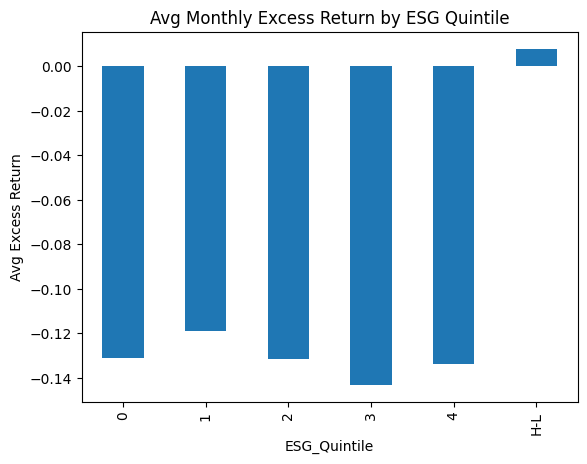


--- Cross-Sectional Analysis (Averaged Regression) ---
Not enough firms or valid IVs for CS avg reg.

--- Machine Learning Analysis ---
ML Features: ['Total-Score_L1', 'E-Score_L1', 'S-Score_L1', 'G-Score_L1', 'delta_Total-Score_L1', 'delta_E-Score_L1', 'delta_S-Score_L1', 'delta_G-Score_L1', 'log_Price_L1', 'Momentum_6M_L1', 'Mkt-RF_L1', 'SMB_L1', 'HML_L1', 'RMW_L1', 'CMA_L1', 'UMD_L1']

Training RF...
RF Best Params: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
RF Test R2: -17.8078, MSE: 0.1262
RF FI:
 SMB_L1            0.191745
Mkt-RF_L1         0.166674
CMA_L1            0.128909
E-Score_L1        0.102085
log_Price_L1      0.073750
HML_L1            0.068512
RMW_L1            0.060397
UMD_L1            0.043079
Momentum_6M_L1    0.037674
G-Score_L1        0.032323
dtype: float64


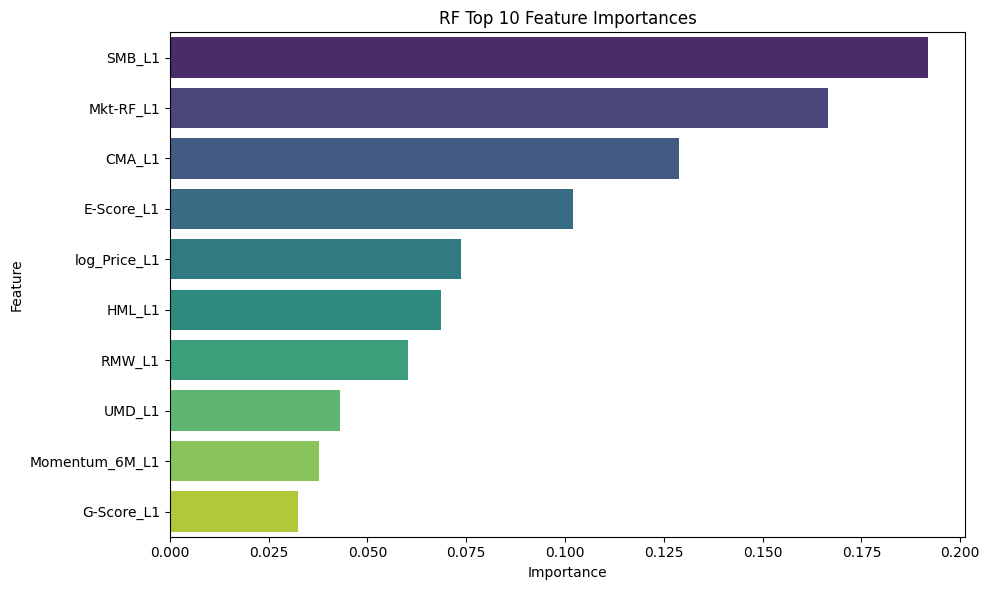


Training XGB...
XGB Best Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
XGB Test R2: -16.9342, MSE: 0.1204
XGB FI:
 CMA_L1                  0.127322
SMB_L1                  0.125212
Mkt-RF_L1               0.112002
delta_E-Score_L1        0.104947
delta_Total-Score_L1    0.078904
HML_L1                  0.066004
RMW_L1                  0.063202
E-Score_L1              0.054122
log_Price_L1            0.051156
delta_S-Score_L1        0.043081
dtype: float32


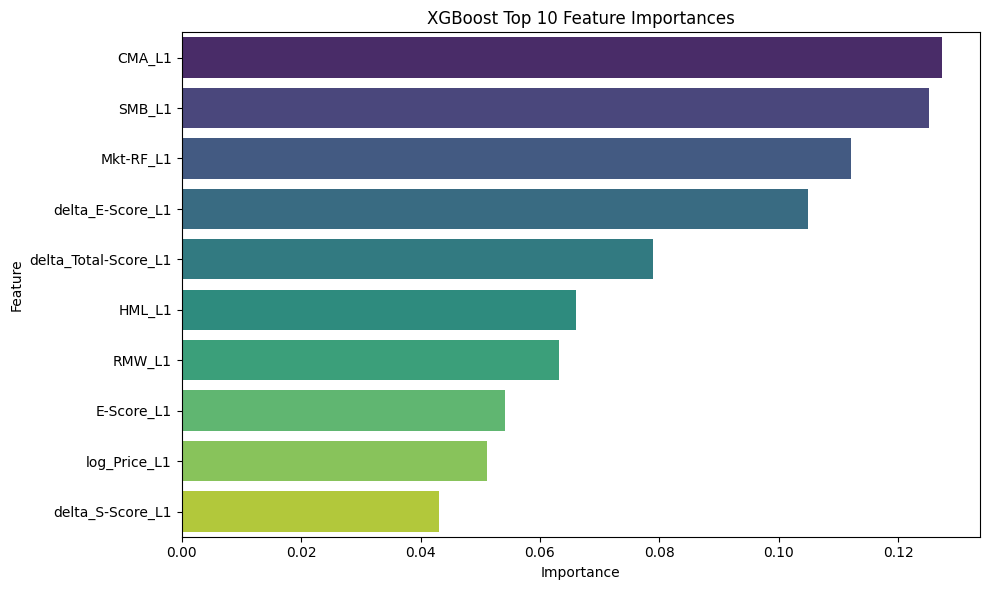


--- ML Perf Summary ---
            Model    Test R2  Test MSE  \
0  Random Forest -17.807801  0.126232   
1        XGBoost -16.934152  0.120368   

                                         Best Params  
0  {'max_depth': 10, 'min_samples_leaf': 5, 'n_es...  
1  {'learning_rate': 0.05, 'max_depth': 5, 'n_est...  

--- Panel VAR (PVAR) - Illustrative Firm-by-Firm VAR ---
PVAR using DV: ExcRet_Raw, ESG related: delta_Total-Score_L1

Processing PVAR for Ticker: ACM
  VAR Lag Order for ACM: 3

Processing PVAR for Ticker: CRH
  Skipping VAR for CRH: Insufficient data (rows: 2) or columns (cols: 2).

Processing PVAR for Ticker: FLR
  VAR Lag Order for FLR: 2

Processing PVAR for Ticker: J
  VAR Lag Order for J: 3

Processing PVAR for Ticker: MLM
  VAR Lag Order for MLM: 3

Processing PVAR for Ticker: MTZ
  Skipping VAR for MTZ: Insufficient data (rows: 2) or columns (cols: 2).

Processing PVAR for Ticker: PWR
  VAR Lag Order for PWR: 3

Processing PVAR for Ticker: VMC
  VAR Lag Order for VMC

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_date

  Attempting LSDV Two-Way FE for delta_TotalScore_L1...
  Error Random Effects (LM) for delta_TotalScore_L1: The index on the time dimension must be either numeric or date-like

--- Model Selection Summary for Spec: delta_TotalScore_L1 ---
+---------------+-----------+------------------------------------+
| Test Name     |   P-value | Decision                           |
|---------------+-----------+------------------------------------|
| F-Poolability |  nan      | Skipped (models)                   |
| F-Time (LSDV) |    0.0000 | Time Sig (LSDV)                    |
| Hausman       |  nan      | Skipped (LM RE or FE missing/LSDV) |
+---------------+-----------+------------------------------------+


=== Running Panel Models for Specification: TotalScore_L1_and_Delta ===
IVs for this spec (ESG + Controls): ['Total-Score_L1', 'delta_Total-Score_L1', 'Mkt-RF_L1', 'SMB_L1', 'HML_L1', 'RMW_L1', 'CMA_L1', 'UMD_L1', 'log_Price_L1', 'Momentum_6M_L1']
  VIF Check for TotalScore_L1_and_Delta (

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 139, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 7
  warnings.warn('cova

  Attempting LSDV Two-Way FE for E-Score_L1...
  Error Random Effects (LM) for E-Score_L1: The index on the time dimension must be either numeric or date-like

--- Model Selection Summary for Spec: E-Score_L1 ---
+---------------+-----------+------------------------------------+
| Test Name     |   P-value | Decision                           |
|---------------+-----------+------------------------------------|
| F-Poolability |  nan      | Skipped (models)                   |
| F-Time (LSDV) |    0.0000 | Time Sig (LSDV)                    |
| Hausman       |  nan      | Skipped (LM RE or FE missing/LSDV) |
+---------------+-----------+------------------------------------+


=== Running Panel Models for Specification: delta_E-Score_L1 ===
IVs for this spec (ESG + Controls): ['delta_E-Score_L1', 'Mkt-RF_L1', 'SMB_L1', 'HML_L1', 'RMW_L1', 'CMA_L1', 'UMD_L1', 'log_Price_L1', 'Momentum_6M_L1']
  VIF Check for delta_E-Score_L1 (IVs: ['delta_E-Score_L1', 'Mkt-RF_L1', 'SMB_L1', 'HML_L1', 'RMW

<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 139, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base

  Attempting LSDV Two-Way FE for S-Score_L1...
  Error Random Effects (LM) for S-Score_L1: The index on the time dimension must be either numeric or date-like

--- Model Selection Summary for Spec: S-Score_L1 ---
+---------------+-----------+------------------------------------+
| Test Name     |   P-value | Decision                           |
|---------------+-----------+------------------------------------|
| F-Poolability |  nan      | Skipped (models)                   |
| F-Time (LSDV) |    0.0000 | Time Sig (LSDV)                    |
| Hausman       |  nan      | Skipped (LM RE or FE missing/LSDV) |
+---------------+-----------+------------------------------------+


=== Running Panel Models for Specification: delta_S-Score_L1 ===
IVs for this spec (ESG + Controls): ['delta_S-Score_L1', 'Mkt-RF_L1', 'SMB_L1', 'HML_L1', 'RMW_L1', 'CMA_L1', 'UMD_L1', 'log_Price_L1', 'Momentum_6M_L1']
  VIF Check for delta_S-Score_L1 (IVs: ['delta_S-Score_L1', 'Mkt-RF_L1', 'SMB_L1', 'HML_L1', 'RMW

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 139, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-31-cc09f9c3372f>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 7
  warnings.warn('cova

  Attempting LSDV Two-Way FE for G-Score_L1...
  Error Random Effects (LM) for G-Score_L1: The index on the time dimension must be either numeric or date-like

--- Model Selection Summary for Spec: G-Score_L1 ---
+---------------+-----------+------------------------------------+
| Test Name     |   P-value | Decision                           |
|---------------+-----------+------------------------------------|
| F-Poolability |  nan      | Skipped (models)                   |
| F-Time (LSDV) |    0.0000 | Time Sig (LSDV)                    |
| Hausman       |  nan      | Skipped (LM RE or FE missing/LSDV) |
+---------------+-----------+------------------------------------+


=== Running Panel Models for Specification: delta_G-Score_L1 ===
IVs for this spec (ESG + Controls): ['delta_G-Score_L1', 'Mkt-RF_L1', 'SMB_L1', 'HML_L1', 'RMW_L1', 'CMA_L1', 'UMD_L1', 'log_Price_L1', 'Momentum_6M_L1']
  VIF Check for delta_G-Score_L1 (IVs: ['delta_G-Score_L1', 'Mkt-RF_L1', 'SMB_L1', 'HML_L1', 'RMW

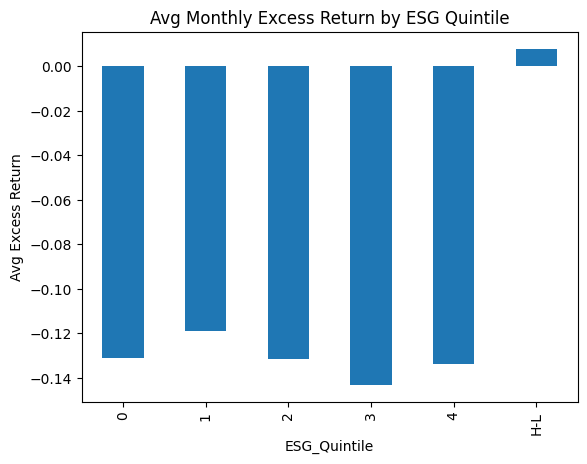


--- Cross-Sectional Analysis (Averaged Regression) ---
Not enough firms or valid IVs for CS avg reg.

--- Machine Learning Analysis ---
ML Features: ['Total-Score_L1', 'E-Score_L1', 'S-Score_L1', 'G-Score_L1', 'delta_Total-Score_L1', 'delta_E-Score_L1', 'delta_S-Score_L1', 'delta_G-Score_L1', 'log_Price_L1', 'Momentum_6M_L1', 'Mkt-RF_L1', 'SMB_L1', 'HML_L1', 'RMW_L1', 'CMA_L1', 'UMD_L1']

Training RF...
RF Best Params: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
RF Test R2: -17.8078, MSE: 0.1262
RF FI:
 SMB_L1            0.191745
Mkt-RF_L1         0.166674
CMA_L1            0.128909
E-Score_L1        0.102085
log_Price_L1      0.073750
HML_L1            0.068512
RMW_L1            0.060397
UMD_L1            0.043079
Momentum_6M_L1    0.037674
G-Score_L1        0.032323
dtype: float64


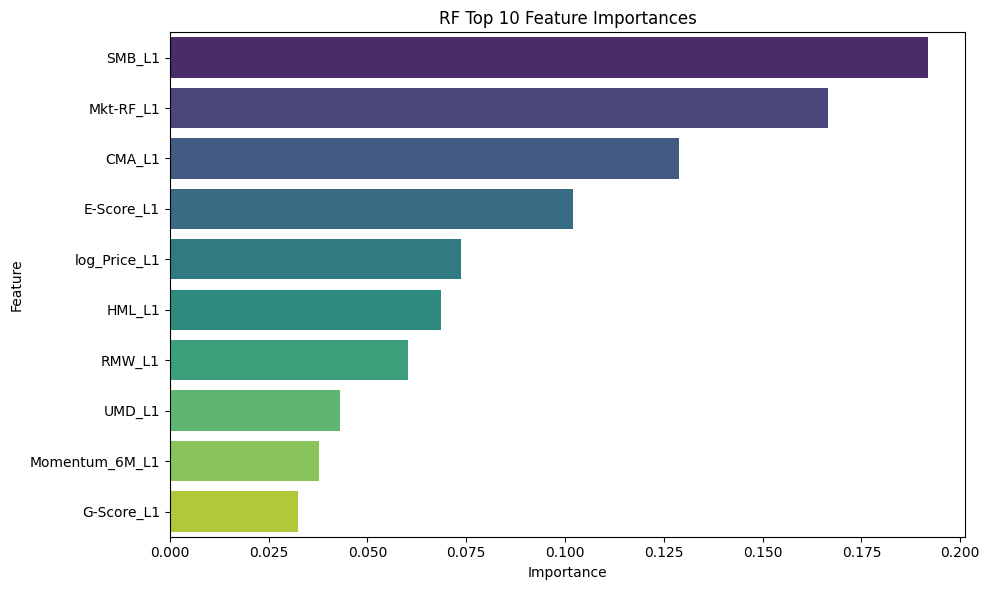


Training XGB...
XGB Best Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
XGB Test R2: -16.9342, MSE: 0.1204
XGB FI:
 CMA_L1                  0.127322
SMB_L1                  0.125212
Mkt-RF_L1               0.112002
delta_E-Score_L1        0.104947
delta_Total-Score_L1    0.078904
HML_L1                  0.066004
RMW_L1                  0.063202
E-Score_L1              0.054122
log_Price_L1            0.051156
delta_S-Score_L1        0.043081
dtype: float32


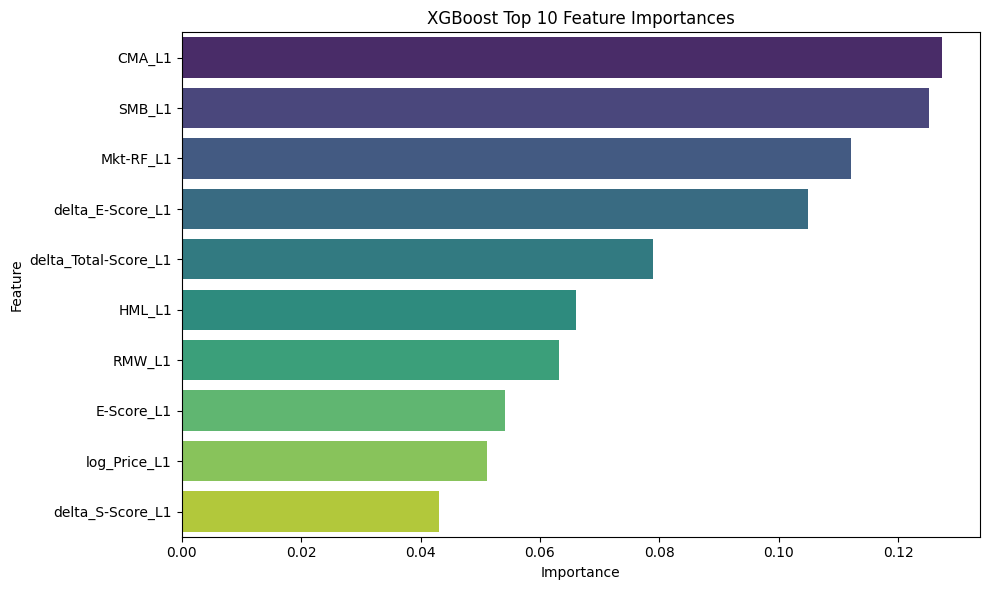


--- ML Perf Summary ---
            Model    Test R2  Test MSE  \
0  Random Forest -17.807801  0.126232   
1        XGBoost -16.934152  0.120368   

                                         Best Params  
0  {'max_depth': 10, 'min_samples_leaf': 5, 'n_es...  
1  {'learning_rate': 0.05, 'max_depth': 5, 'n_est...  

--- Panel VAR (PVAR) - Illustrative Firm-by-Firm VAR ---
PVAR using DV: ExcRet_Raw, ESG related: delta_Total-Score_L1

Processing PVAR for Ticker: ACM
  VAR Lag Order for ACM: 3

Processing PVAR for Ticker: CRH
  Skipping VAR for CRH: Insufficient data (rows: 2) or columns (cols: 2).

Processing PVAR for Ticker: FLR
  VAR Lag Order for FLR: 2

Processing PVAR for Ticker: J
  VAR Lag Order for J: 3

Processing PVAR for Ticker: MLM
  VAR Lag Order for MLM: 3

Processing PVAR for Ticker: MTZ
  Skipping VAR for MTZ: Insufficient data (rows: 2) or columns (cols: 2).

Processing PVAR for Ticker: PWR
  VAR Lag Order for PWR: 3

Processing PVAR for Ticker: VMC
  VAR Lag Order for VMC

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_date

In [31]:
# CELL 1: Install and Import Libraries
# --------------------------------------------------------------------
!pip install linearmodels yfinance openpyxl

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from linearmodels.panel.data import PanelData
from linearmodels.panel.results import PanelEffectsResults, RandomEffectsResults
from statsmodels.regression.linear_model import RegressionResultsWrapper

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from collections import OrderedDict
import yfinance as yf
import requests
import zipfile
import io
import os
import scipy.stats as stats

GMM_AVAILABLE = False
print("pyeconometrics not available/not installed. GMM models will be skipped.")

VIF_THRESHOLD = 10 # Relaxed VIF for models with many controls; can be 5 if preferred
RANDOM_STATE = 42
LAG_PERIODS = 1
SIGNIFICANCE_LEVEL = 0.05

# --- Helper function for creating results tables ---
def create_results_table(model_results, model_name="Model", custom_var_names=None, suppress_dummies=True, dummy_prefixes=['entity_dummy_', 'time_dummy_']):
    if model_results is None: return f"Could not generate table for {model_name}: Model results are None."
    params = model_results.params; p_values = model_results.pvalues
    if hasattr(model_results, 'std_errors'): std_errs = model_results.std_errors
    elif hasattr(model_results, 'bse'): std_errs = model_results.bse
    else: std_errs = pd.Series([np.nan] * len(params), index=params.index); print(f"Warning: Std errors not found for {model_name}")
    results_df = pd.DataFrame({'Variable': params.index, 'Coefficient': params.values,
                               'Std. Error': std_errs.values if std_errs is not None else np.nan,
                               'P-value': p_values.values if p_values is not None else np.nan})
    if suppress_dummies and isinstance(model_results, RegressionResultsWrapper):
        is_dummy = pd.Series(False, index=results_df['Variable'])
        for prefix in dummy_prefixes: is_dummy = is_dummy | results_df['Variable'].astype(str).str.startswith(prefix)
        results_df = results_df[~is_dummy]
    stars = []
    if 'P-value' in results_df.columns and results_df['P-value'] is not None and not results_df['P-value'].isnull().all():
        for p_val in results_df['P-value']:
            if pd.isna(p_val): stars.append('')
            elif p_val < 0.01: stars.append('***')
            elif p_val < 0.05: stars.append('**')
            elif p_val < 0.1: stars.append('*')
            else: stars.append('')
    else: stars = [''] * len(results_df)
    results_df['Sig.'] = stars
    results_df['Coefficient_Formatted'] = results_df.apply(lambda r: f"{r['Coefficient']:.4f}{r['Sig.']}" if pd.notna(r['Coefficient']) else "N/A", axis=1)
    display_cols = ['Variable', 'Coefficient_Formatted', 'Std. Error', 'P-value']
    if 'P-value' in results_df.columns: results_df['P-value'] = pd.to_numeric(results_df['P-value'], errors='coerce')
    results_df_display = results_df[display_cols].copy(); results_df_display.rename(columns={'Coefficient_Formatted': 'Coefficient'}, inplace=True)
    summary_stats = OrderedDict(); summary_stats["Model"] = model_name
    if hasattr(model_results, 'rsquared_overall'): summary_stats["R-sq (Overall)"] = f"{model_results.rsquared_overall:.4f}"
    if hasattr(model_results, 'rsquared_within'): summary_stats["R-sq (Within)"] = f"{model_results.rsquared_within:.4f}"
    if hasattr(model_results, 'rsquared_between'): summary_stats["R-sq (Between)"] = f"{model_results.rsquared_between:.4f}"
    if hasattr(model_results, 'rsquared') and not any(k in summary_stats for k in ["R-sq (Overall)", "R-sq (Within)"]): summary_stats["R-squared"] = f"{model_results.rsquared:.4f}"
    if hasattr(model_results, 'rsquared_adj') and isinstance(model_results, RegressionResultsWrapper): summary_stats["Adj. R-squared"] = f"{model_results.rsquared_adj:.4f}"
    if hasattr(model_results, 'nobs'): summary_stats["Observations"] = str(int(model_results.nobs))
    if isinstance(model_results, (PanelEffectsResults, RandomEffectsResults)):
        if hasattr(model_results, 'entity_info') and model_results.entity_info: summary_stats["Entities"] = str(model_results.entity_info.total)
        if hasattr(model_results, 'time_info') and model_results.time_info: summary_stats["Time Periods"] = str(model_results.time_info.total)
    f_stat_attr = getattr(model_results, 'f_statistic_robust', getattr(model_results, 'f_statistic', None))
    if f_stat_attr is None and hasattr(model_results, 'fvalue') and hasattr(model_results, 'f_pvalue'):
        f_stat_attr = type('obj', (object,), {'stat': model_results.fvalue, 'pval': model_results.f_pvalue})
    elif f_stat_attr is None and isinstance(model_results, RandomEffectsResults) and hasattr(model_results, 'wald_test_joint'): f_stat_attr = model_results.wald_test_joint
    if f_stat_attr and hasattr(f_stat_attr, 'stat') and hasattr(f_stat_attr, 'pval'):
         summary_stats["F-statistic (Model/Robust)"] = f"{f_stat_attr.stat:.4f} (p={f_stat_attr.pval:.4f})"
    footer_list = [f"{k}: {v}" for k,v in summary_stats.items()]; footer_text = "\n" + "\n".join(footer_list) + "\nSignificance: *** p<0.01, ** p<0.05, * p<0.1"
    if suppress_dummies and isinstance(model_results, RegressionResultsWrapper) and any(idx.startswith(tuple(dummy_prefixes)) for idx in params.index):
        footer_text += "\n(Dummy variable coefficients likely suppressed for LSDV model tables)"
    return tabulate(results_df_display, headers='keys', tablefmt='psql', floatfmt=(".4f", ".4f", ".4f", ".4f"), showindex=False) + footer_text

def create_model_selection_test_table(test_data_list):
    if not test_data_list: return "No model selection test data to display."
    df = pd.DataFrame(test_data_list); cols_order = ['Test Name', 'Statistic Value', 'P-value', 'DF', 'Decision']
    df_cols = [col for col in cols_order if col in df.columns]; df = df[df_cols]
    return tabulate(df, headers='keys', tablefmt='psql', showindex=False, floatfmt=".4f")

# CELL 2, 3, 4, 5, 6, 7: Data Loading and Initial Preprocessing
from google.colab import files
print("Please upload BOTH 'historic_esg_scores_construction.csv' AND your Fama-French factor file (e.g., 'Developed_5_Factors_Momentum.csv').")
uploaded_files = files.upload()
df_esg = pd.DataFrame(); df_ff_raw = pd.DataFrame()
esg_target_filename_base = 'historic_esg_scores_construction'; ff_target_filename_base = 'Developed_5_Factors_Momentum'
for filename_uploaded, content in uploaded_files.items():
    if esg_target_filename_base.lower() in filename_uploaded.lower():
        df_esg = pd.read_csv(io.BytesIO(content)); print(f"\nESG data '{filename_uploaded}' loaded successfully into df_esg.")
    elif ff_target_filename_base.lower() in filename_uploaded.lower():
        df_ff_raw = pd.read_csv(io.BytesIO(content)); print(f"\nFama-French data '{filename_uploaded}' loaded successfully into df_ff_raw.")
if df_esg.empty: print(f"CRIT ERROR: ESG file '{esg_target_filename_base}' not uploaded/read.")
if df_ff_raw.empty: print(f"CRIT ERROR: FF file '{ff_target_filename_base}' not uploaded/read.")

min_esg_date = pd.to_datetime("2000-01-01"); max_esg_date = pd.to_datetime("2023-12-31")
if not df_esg.empty:
    print("\n--- Preprocessing ESG Data ---")
    df_esg['Date'] = pd.to_datetime(df_esg['Date'], errors='coerce', infer_datetime_format=True)
    df_esg = df_esg.loc[:, ~df_esg.columns.str.contains('^Unnamed')]
    df_esg.dropna(subset=['Date', 'Ticker'], inplace=True)
    esg_cols_initial = ['Total-Score', 'E-Score', 'S-Score', 'G-Score']
    esg_cols = [col for col in esg_cols_initial if col in df_esg.columns]
    if not esg_cols: print("CRIT ERROR: No expected ESG score columns found in df_esg.");
    else: print(f"Using ESG columns: {esg_cols}")
    for col in esg_cols: df_esg[col] = pd.to_numeric(df_esg[col], errors='coerce')
    df_esg['Date'] = (df_esg['Date'] + pd.offsets.MonthEnd(0)).dt.tz_localize(None)
    df_esg = df_esg.drop_duplicates(subset=['Ticker', 'Date'], keep='last')
    print(f"ESG data shape after initial processing: {df_esg.shape}")
    if not df_esg.empty:
        min_esg_date = df_esg['Date'].min() - pd.DateOffset(months=12)
        max_esg_date = df_esg['Date'].max() + pd.DateOffset(months=3)
    print(f"Determined data download range: {min_esg_date.strftime('%Y-%m-%d')} to {max_esg_date.strftime('%Y-%m-%d')}")
else: print("Skipping ESG preprocessing as df_esg is empty.")

print("\n--- Processing Manually Uploaded Fama-French Factors ---")
df_ff = pd.DataFrame(); ff_factor_cols_renamed = []
if not df_ff_raw.empty:
    try:
        df_ff = df_ff_raw.copy()
        date_col_name = df_ff.columns[0]
        df_ff.rename(columns={date_col_name: 'Date_str'}, inplace=True, errors='ignore')
        df_ff['Date_str'] = df_ff['Date_str'].astype(str).str.strip()
        date_parsed_successfully = False
        date_formats_to_try = ['%m/%d/%y', '%Y%m%d', '%Y%m', '%Y-%m-%d', '%m/%d/%Y']
        for fmt in date_formats_to_try:
            try: df_ff['Date'] = pd.to_datetime(df_ff['Date_str'], format=fmt, errors='raise'); date_parsed_successfully = True; print(f"  Parsed FF dates using format: {fmt}"); break
            except (ValueError, TypeError): continue
        if not date_parsed_successfully: print("  Specific date formats failed, trying pandas inference for FF dates..."); df_ff['Date'] = pd.to_datetime(df_ff['Date_str'], errors='coerce')
        df_ff.dropna(subset=['Date'], inplace=True)
        if df_ff.empty: raise ValueError("FF DataFrame empty after date parsing.")
        df_ff['Date'] = (df_ff['Date'] + pd.offsets.MonthEnd(0)).dt.tz_localize(None)
        factor_rename_map_manual = {'Mkt-RF':'Mkt-RF','SMB':'SMB','HML':'HML','RMW':'RMW','CMA':'CMA','RF':'RF','WML':'UMD','Mom   ':'UMD','MOM':'UMD'}
        df_ff.columns = [col.strip() for col in df_ff.columns]; df_ff.rename(columns=factor_rename_map_manual, inplace=True)
        ff_factor_cols_renamed = ['Mkt-RF','SMB','HML','RMW','CMA','RF','UMD']; actual_ff_cols_present = [col for col in ff_factor_cols_renamed if col in df_ff.columns]
        if len(actual_ff_cols_present) < 6: print(f"Warn: Not all expected 5 factors + RF found. Present: {actual_ff_cols_present}")
        for col in actual_ff_cols_present:
            df_ff[col] = pd.to_numeric(df_ff[col], errors='coerce')
            if col in df_ff.columns and df_ff[col].abs().mean() > 0.5 and df_ff[col].abs().mean() < 100 : df_ff[col] = df_ff[col] / 100.0
        df_ff = df_ff[['Date'] + actual_ff_cols_present].copy(); df_ff.dropna(subset=actual_ff_cols_present, how='any', inplace=True)
        print(f"Processed FF data shape: {df_ff.shape}"); print(df_ff.head())
    except Exception as e: print(f"CRIT ERROR processing FF file: {e}"); df_ff = pd.DataFrame()
else: print("FF raw data empty.")
if df_ff.empty: print("CRIT: FF data not processed.")
else: ff_factor_cols_renamed = [col for col in df_ff.columns if col != 'Date']

if not df_esg.empty:
    print("\n--- Downloading Historical Stock Prices ---")
    tickers_list_orig = df_esg['Ticker'].unique().tolist(); print(f"Original tickers from ESG file: {tickers_list_orig}")
    ticker_map_manual = {'CRH': 'CRH', 'J': 'J'}
    all_stock_data_list = []; successful_tickers_map = {}
    for esg_ticker in tickers_list_orig:
        yf_ticker_to_try = ticker_map_manual.get(esg_ticker, esg_ticker)
        print(f"Attempting download for ESG '{esg_ticker}' as yf '{yf_ticker_to_try}'...")
        try:
            stock = yf.Ticker(yf_ticker_to_try)
            hist = stock.history(start=min_esg_date.strftime('%Y-%m-%d'), end=max_esg_date.strftime('%Y-%m-%d'), interval="1d", auto_adjust=True, actions=False)
            if not hist.empty and 'Close' in hist.columns:
                hist_monthly = hist[['Close']].resample('ME').last()
                hist_monthly.rename(columns={'Close': 'Price'}, inplace=True)
                hist_monthly['Ticker_ESG'] = esg_ticker; hist_monthly['Ticker_yf'] = yf_ticker_to_try
                hist_monthly.reset_index(inplace=True); all_stock_data_list.append(hist_monthly[['Date', 'Ticker_ESG', 'Ticker_yf', 'Price']])
                print(f"  Success: '{esg_ticker}' as '{yf_ticker_to_try}'."); successful_tickers_map[esg_ticker] = yf_ticker_to_try
            else: print(f"  No data/Close col for '{esg_ticker}' as '{yf_ticker_to_try}'.")
        except Exception as e: print(f"  Error for '{esg_ticker}' as '{yf_ticker_to_try}': {e}")
    if not all_stock_data_list: print("CRIT ERROR: No stock data downloaded."); df_prices = pd.DataFrame()
    else:
        df_prices = pd.concat(all_stock_data_list, ignore_index=True)
        print(f"\nDownloaded stock data for {df_prices['Ticker_ESG'].nunique()} unique ESG tickers.")
        print(f"Processed ESG tickers: {list(successful_tickers_map.keys())}")
else: print("Skipping stock price download as ESG data is not loaded."); df_prices = pd.DataFrame()

if not df_prices.empty:
    print("\n--- Preprocessing Stock Price Data & Basic Controls ---")
    df_prices['Date'] = pd.to_datetime(df_prices['Date'], errors='coerce')
    df_prices['Date'] = (df_prices['Date'] + pd.offsets.MonthEnd(0)).dt.tz_localize(None)
    df_prices = df_prices[['Date', 'Ticker_ESG', 'Price']].copy()
    df_prices.dropna(subset=['Date', 'Ticker_ESG', 'Price'], inplace=True)
    df_prices['Price'] = pd.to_numeric(df_prices['Price'], errors='coerce')
    df_prices.sort_values(by=['Ticker_ESG', 'Date'], inplace=True)
    df_prices['Return'] = df_prices.groupby('Ticker_ESG')['Price'].pct_change()
    shifted_price = df_prices.groupby('Ticker_ESG')['Price'].shift(LAG_PERIODS)
    shifted_price_no_zero = shifted_price.replace(0, np.nan)
    df_prices['log_Price_L1'] = np.log(shifted_price_no_zero)
    df_prices['log_Price_L1'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_prices['Return_L1'] = df_prices.groupby('Ticker_ESG')['Return'].shift(LAG_PERIODS)
    df_prices['Momentum_6M_L1'] = df_prices.groupby('Ticker_ESG')['Return_L1'].transform(lambda x: x.rolling(window=5, min_periods=3).sum().shift(1) )
    df_prices.dropna(subset=['Return'], inplace=True)
    print(f"Stock price data shape after return & basic controls: {df_prices.shape}"); print(df_prices[['Ticker_ESG', 'Date', 'Price', 'Return', 'log_Price_L1', 'Momentum_6M_L1']].head(10))
else: print("Skipping stock price preprocessing: download failed.")

print("\n--- Merging DataFrames ---")
if df_prices.empty or df_ff.empty or df_esg.empty:
    print("Cannot merge: stock price, Fama-French, or ESG data missing."); df_panel = pd.DataFrame()
else:
    df_merged = pd.merge(df_prices, df_ff, on='Date', how='inner')
    df_panel = pd.merge(df_merged, df_esg, left_on=['Ticker_ESG', 'Date'], right_on=['Ticker', 'Date'], how='inner')
    if 'Ticker_ESG' in df_panel.columns and 'Ticker' in df_panel.columns:
        df_panel.drop(columns=['Ticker_ESG'], inplace=True, errors='ignore')
    if 'ff_factor_cols_renamed' not in locals(): ff_factor_cols_renamed = []
    required_cols_for_dropna = ['Return', 'Ticker', 'Date'] + \
                               [col for col in ff_factor_cols_renamed if col == 'RF' and col in df_panel.columns] + \
                               [col for col in esg_cols if col in df_panel.columns]
    for ff_col_check in ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']:
        if ff_col_check in df_panel.columns and ff_col_check not in required_cols_for_dropna: required_cols_for_dropna.append(ff_col_check)
    required_cols_for_dropna = list(set(required_cols_for_dropna))
    missing_cols_in_panel = [col for col in required_cols_for_dropna if col not in df_panel.columns]
    if missing_cols_in_panel: print(f"Warn: Missing required cols in df_panel before dropna: {missing_cols_in_panel}"); required_cols_for_dropna = [col for col in required_cols_for_dropna if col in df_panel.columns]
    if required_cols_for_dropna: df_panel.dropna(subset=required_cols_for_dropna, inplace=True)
    print(f"Final merged panel data shape: {df_panel.shape}")
    if df_panel.empty: print("CRIT ERROR: Merged panel data is empty.")
    else: print(df_panel.head())

# CELL 8: Define Dependent Variable, Prepare Controls, and Lagging (REVISED)
dependent_var_name = ''
ff_controls_for_regression = []
lagged_firm_controls_list = [col for col in ['log_Price_L1', 'Momentum_6M_L1'] if col in df_panel.columns]

if not df_panel.empty and 'RF' in df_panel.columns:
    print("\n--- Defining Dependent Variable & Lagging Controls ---")
    df_panel['ExcRet_Raw'] = df_panel['Return'] - df_panel['RF']

    dependent_var_name = 'ExcRet_Raw'
    print(f"Using '{dependent_var_name}' as the dependent variable.")

    temp_ff_controls_lagged = []
    for ff_col in [col for col in ff_factor_cols_renamed if col != 'RF' and col in df_panel.columns]:
        df_panel[f'{ff_col}_L{LAG_PERIODS}'] = df_panel.groupby('Ticker')[ff_col].shift(LAG_PERIODS)
        temp_ff_controls_lagged.append(f'{ff_col}_L{LAG_PERIODS}')
    ff_controls_for_regression = [col for col in temp_ff_controls_lagged if col in df_panel.columns]
    print(f"Lagged Fama-French factors to be used as controls: {ff_controls_for_regression}")

    if df_panel.empty or dependent_var_name not in df_panel.columns or df_panel[dependent_var_name].isnull().all():
        print(f"CRIT ERROR: Panel data empty or DV ('{dependent_var_name}') all NaN."); df_panel = pd.DataFrame()
else:
    print("Skipping DV definition: df_panel empty or RF missing."); df_panel = pd.DataFrame(); dependent_var_name = 'Return'
if not lagged_firm_controls_list: print("WARNING: No firm-specific control variables were processed.")

# CELL 9: Create Lagged ESG Variables and Target Future Dependent Variable
lagged_esg_cols = []; delta_esg_cols = []
if not df_panel.empty and dependent_var_name in df_panel.columns:
    print("\n--- Creating Lagged ESG, Deltas, and Future Dependent Variable ---")
    df_panel = df_panel.sort_values(['Ticker', 'Date'])
    df_panel[f'{dependent_var_name}_F1'] = df_panel.groupby('Ticker')[dependent_var_name].shift(-1)
    for esg_col in esg_cols:
        if esg_col in df_panel.columns:
            lag_col_name = f'{esg_col}_L{LAG_PERIODS}'; df_panel[lag_col_name] = df_panel.groupby('Ticker')[esg_col].shift(LAG_PERIODS); lagged_esg_cols.append(lag_col_name)
            delta_col_name = f'delta_{esg_col}_L{LAG_PERIODS}'
            df_panel[f'{esg_col}_L{LAG_PERIODS+1}'] = df_panel.groupby('Ticker')[esg_col].shift(LAG_PERIODS+1)
            if f'{esg_col}_L{LAG_PERIODS+1}' in df_panel.columns and lag_col_name in df_panel.columns:
                df_panel[delta_col_name] = df_panel[lag_col_name] - df_panel[f'{esg_col}_L{LAG_PERIODS+1}']; delta_esg_cols.append(delta_col_name)
            df_panel.drop(columns=[f'{esg_col}_L{LAG_PERIODS+1}'], inplace=True, errors='ignore')

    cols_to_check_na = [f'{dependent_var_name}_F1'] + \
                       [col for col in lagged_esg_cols if col in df_panel.columns] + \
                       [col for col in delta_esg_cols if col in df_panel.columns] + \
                       [col for col in lagged_firm_controls_list if col in df_panel.columns] + \
                       [col for col in ff_controls_for_regression if col in df_panel.columns]
    if cols_to_check_na: df_panel.dropna(subset=cols_to_check_na, inplace=True)
    print(f"Panel shape after lags/leads/deltas & dropna: {df_panel.shape}")
    if df_panel.empty: print(f"CRIT ERROR: Panel empty after lags/leads/deltas.")
else: print("Skipping lags/leads/deltas: df_panel empty or DV missing.")

# CELL 10: Imputation
if not df_panel.empty:
    print("\n--- Imputation for Predictor Variables ---")
    predictor_cols_for_imputation = list(set(lagged_esg_cols + delta_esg_cols + lagged_firm_controls_list + ff_controls_for_regression))
    predictor_cols_for_imputation = [col for col in predictor_cols_for_imputation if col in df_panel.columns]
    if predictor_cols_for_imputation:
        df_to_impute = df_panel[predictor_cols_for_imputation].copy()
        if df_to_impute.isnull().sum().sum() > 0:
            print(f"NaNs before imputation:\n{df_to_impute.isnull().sum()[df_to_impute.isnull().sum()>0].sort_values(ascending=False)}")
            imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=RANDOM_STATE, tol=1e-3)
            df_panel[predictor_cols_for_imputation] = imputer.fit_transform(df_to_impute); print("Imputation complete.")
        else: print("No NaNs in predictors for imputation.")
    else: print("No predictor columns for imputation.")
else: print("Skipping Imputation: df_panel is empty.")

# CELL 11: Define IV Sets for Panel Models (VIF done per model in Cell 12)
panel_model_core_esg_ivs = {}
if not df_panel.empty:
    print("\n--- Defining Core ESG IV Sets for Panel Models ---")
    if f'Total-Score_L{LAG_PERIODS}' in df_panel.columns: panel_model_core_esg_ivs["TotalScore_L1"] = [f'Total-Score_L{LAG_PERIODS}']
    if f'delta_Total-Score_L{LAG_PERIODS}' in df_panel.columns: panel_model_core_esg_ivs["delta_TotalScore_L1"] = [f'delta_Total-Score_L{LAG_PERIODS}']
    if f'Total-Score_L{LAG_PERIODS}' in df_panel.columns and f'delta_Total-Score_L{LAG_PERIODS}' in df_panel.columns:
        panel_model_core_esg_ivs["TotalScore_L1_and_Delta"] = [f'Total-Score_L{LAG_PERIODS}', f'delta_Total-Score_L{LAG_PERIODS}']
    for score_comp in ['E-Score', 'S-Score', 'G-Score']:
        if f'{score_comp}_L{LAG_PERIODS}' in df_panel.columns: panel_model_core_esg_ivs[f"{score_comp}_L1"] = [f'{score_comp}_L{LAG_PERIODS}']
        if f'delta_{score_comp}_L{LAG_PERIODS}' in df_panel.columns: panel_model_core_esg_ivs[f"delta_{score_comp}_L1"] = [f'delta_{score_comp}_L{LAG_PERIODS}']
    print("Defined Panel Model Core ESG IV Specifications:")
    for spec_name, ivs in panel_model_core_esg_ivs.items(): print(f"  {spec_name}: {ivs}")
else: print("Skipping IV set definition as df_panel is empty.")


# CELL 12: Panel Regression Models & Model Selection (REVISED with LSDV Focus)
# THIS IS THE FIRST PANEL MODELLING BLOCK
panel_model_results_all_specs_focus = {} # Use different var names to avoid overwrite if desired, or accept overwrite
panel_model_tables_all_specs_focus = {}
overall_model_selection_summary_focus = []

if not df_panel.empty and panel_model_core_esg_ivs and f'{dependent_var_name}_F1' in df_panel.columns:
    print("\n--- Panel Regression Modeling (Focus on LSDV if linearmodels fails) ---")

    df_reg_base_panel_focus = df_panel.copy() # Use a distinct DataFrame
    df_reg_base_panel_focus['Ticker'] = df_reg_base_panel_focus['Ticker'].astype(str)
    df_reg_base_panel_focus['Date'] = pd.to_datetime(df_reg_base_panel_focus['Date'])
    df_reg_base_panel_focus['Date_Period'] = df_reg_base_panel_focus['Date'].dt.to_period('M')


    for spec_name, current_esg_iv_list_core in panel_model_core_esg_ivs.items():
        if not current_esg_iv_list_core: continue

        print(f"\n\n=== Running Panel Models for Specification: {spec_name} ===")

        ivs_for_this_run_with_controls = list(OrderedDict.fromkeys(current_esg_iv_list_core + ff_controls_for_regression + lagged_firm_controls_list))
        ivs_for_this_run_with_controls = [col for col in ivs_for_this_run_with_controls if col in df_reg_base_panel_focus.columns]

        if not ivs_for_this_run_with_controls: print(f"No valid IVs for spec {spec_name}. Skipping."); continue

        X_vif_check_this_spec = df_reg_base_panel_focus[ivs_for_this_run_with_controls].copy().replace([np.inf,-np.inf],np.nan).dropna()
        final_ivs_for_this_spec_after_vif = ivs_for_this_run_with_controls
        if X_vif_check_this_spec.shape[1] >= 2 and not X_vif_check_this_spec.empty:
            temp_vif_ivs = X_vif_check_this_spec.columns.tolist()
            print(f"  VIF Check for {spec_name} (IVs before VIF: {temp_vif_ivs})...")
            for i_vif in range(len(temp_vif_ivs)):
                if len(temp_vif_ivs) < 2: break
                X_iter_vif = X_vif_check_this_spec[temp_vif_ivs].astype(float)
                if (X_iter_vif.nunique() < 2).any():
                    constant_cols = X_iter_vif.columns[X_iter_vif.nunique() < 2].tolist()
                    print(f"    VIF Iter ({spec_name}): Const cols {constant_cols}. Removing.")
                    for c_col in constant_cols:
                        if c_col in temp_vif_ivs: temp_vif_ivs.remove(c_col)
                    if len(temp_vif_ivs) < 2: break
                    continue
                vif_df_s = pd.DataFrame(); vif_df_s["feature"]=temp_vif_ivs
                try:
                    vif_df_s["VIF"]=[variance_inflation_factor(X_iter_vif.values,j) for j in range(X_iter_vif.shape[1])]
                    vif_df_s=vif_df_s.sort_values(by="VIF",ascending=False)
                    if vif_df_s["VIF"].iloc[0]>VIF_THRESHOLD:
                        remove_feature=vif_df_s["feature"].iloc[0]; temp_vif_ivs.remove(remove_feature)
                        X_vif_check_this_spec.drop(columns=[remove_feature], inplace=True, errors='ignore')
                        print(f"      Removing '{remove_feature}' (VIF: {vif_df_s['VIF'].iloc[0]:.2f})")
                    else: print(f"    All VIFs for {spec_name} below threshold."); break
                except Exception as e_vif_s: print(f"    Error VIF for {spec_name} (iter {i_vif+1}): {e_vif_s}"); break
            final_ivs_for_this_spec_after_vif = temp_vif_ivs
            print(f"  Final IVs for spec {spec_name} after VIF: {final_ivs_for_this_spec_after_vif}")
        elif len(ivs_for_this_run_with_controls) == 1:
             final_ivs_for_this_spec_after_vif = ivs_for_this_run_with_controls
             print(f"  Only one IV for {spec_name}, no VIF needed: {final_ivs_for_this_spec_after_vif}")
        else:
             print(f"  Not enough IVs for VIF in {spec_name}. Using original: {ivs_for_this_run_with_controls}")
             final_ivs_for_this_spec_after_vif = ivs_for_this_run_with_controls

        if not final_ivs_for_this_spec_after_vif: print(f"No IVs left for spec {spec_name} after VIF. Skipping."); continue

        df_model_run = df_reg_base_panel_focus[[f'{dependent_var_name}_F1', 'Ticker', 'Date', 'Date_Period'] + final_ivs_for_this_spec_after_vif].copy()
        df_model_run.dropna(inplace=True)

        if df_model_run.empty or df_model_run.shape[0] < 20 : print(f"Not enough data for Spec {spec_name} after VIF & NaN drop. Skipping."); continue

        Y_run = df_model_run[f'{dependent_var_name}_F1']
        X_run_vars_only = df_model_run[final_ivs_for_this_spec_after_vif]
        X_run_pooled_sm = sm.add_constant(X_run_vars_only.astype(float), has_constant='add')

        # Use 'Date' (datetime) for linearmodels index in this block
        df_lm_run = df_model_run.set_index(['Ticker', 'Date']).sort_index()
        Y_lm_run = df_lm_run[f'{dependent_var_name}_F1']
        X_lm_run = sm.add_constant(df_lm_run[final_ivs_for_this_spec_after_vif].astype(float), has_constant='add')

        n_entities_s = df_model_run['Ticker'].nunique(); n_time_s = df_model_run['Date_Period'].nunique(); n_reg_s = X_run_pooled_sm.shape[1]
        print(f"  Data for {spec_name}: Obs={X_run_pooled_sm.shape[0]}, Entities={n_entities_s}, Time={n_time_s}, Regressors={n_reg_s}")
        results_this_spec = {} # Local to this spec run

        try:
            clusters_p = df_model_run.loc[X_run_pooled_sm.index, 'Ticker'] # Ensure correct index alignment for clusters
            model_p_sm = sm.OLS(Y_run.loc[X_run_pooled_sm.index], X_run_pooled_sm).fit(cov_type='cluster', cov_kwds={'groups': clusters_p}) # Align Y_run as well
            results_this_spec['Pooled OLS (SM)'] = model_p_sm
            panel_model_tables_all_specs_focus[f'{spec_name} - Pooled OLS (SM)'] = create_results_table(model_p_sm, f"{spec_name} - Pooled OLS (SM)")
        except Exception as e: print(f"  Error Pooled OLS (SM) for {spec_name}: {e}")

        lm_entity_fe_success = False; lm_twfe_success = False; lm_re_success = False
        if X_lm_run.shape[0] >= (n_reg_s + n_entities_s + 5):
            try:
                model_fe_e_lm = PanelOLS(Y_lm_run, X_lm_run, entity_effects=True, drop_absorbed=True)
                res_fe_e_lm = model_fe_e_lm.fit(cov_type='clustered',cluster_entity=True)
                results_this_spec['Entity FE (LM)'] = res_fe_e_lm
                lm_entity_fe_success = True
                panel_model_tables_all_specs_focus[f'{spec_name} - Entity FE (LM)'] = create_results_table(res_fe_e_lm, f"{spec_name} - Entity FE (LM)")
            except Exception as e:
                print(f"  Error Entity FE (LM) for {spec_name}: {e}")
                results_this_spec['Entity FE (LM)'] = None
        if X_lm_run.shape[0] >= (n_reg_s + n_entities_s + n_time_s + 5):
            try:
                model_fe_tw_lm = PanelOLS(Y_lm_run, X_lm_run, entity_effects=True, time_effects=True, drop_absorbed=True)
                res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered',cluster_entity=True,cluster_time=True)
                results_this_spec['Two-Way FE (LM)'] = res_fe_tw_lm
                lm_twfe_success = True
                panel_model_tables_all_specs_focus[f'{spec_name} - Two-Way FE (LM)'] = create_results_table(res_fe_tw_lm, f"{spec_name} - Two-Way FE (LM)")
            except Exception as e:
                print(f"  Error Two-Way FE (LM) for {spec_name}: {e}")
                results_this_spec['Two-Way FE (LM)'] = None
        if X_lm_run.shape[0] >= (n_reg_s + n_entities_s + 5):
            try:
                model_re_lm = RandomEffects(Y_lm_run, X_lm_run)
                res_re_lm = model_re_lm.fit(cov_type='clustered',cluster_entity=True)
                results_this_spec['Random Effects (LM)'] = res_re_lm
                lm_re_success = True
                panel_model_tables_all_specs_focus[f'{spec_name} - Random Effects (LM)'] = create_results_table(res_re_lm, f"{spec_name} - Random Effects (LM)")
            except Exception as e:
                print(f"  Error Random Effects (LM) for {spec_name}: {e}")
                results_this_spec['Random Effects (LM)'] = None
                lm_re_success = False # Ensure this is set if RE fails

        # --- LSDV Fallback (COMMENTED OUT FOR THIS BLOCK TO MATCH LOG) ---
        # if not lm_entity_fe_success and n_entities_s > 1 and n_entities_s < 70:
        #     print(f"  Attempting LSDV Entity FE for {spec_name}...")
        #     try:
        #         entity_dummies = pd.get_dummies(df_model_run['Ticker'], prefix='entity_dummy', drop_first=True).astype(float)
        #         X_lsdv_e = pd.concat([X_run_pooled_sm.reset_index(drop=True), entity_dummies.reset_index(drop=True)], axis=1)
        #         model_lsdv_e_sm = sm.OLS(Y_run.reset_index(drop=True), X_lsdv_e).fit(cov_type='cluster', cov_kwds={'groups': df_model_run['Ticker']})
        #         results_this_spec['Entity FE (LSDV)'] = model_lsdv_e_sm
        #         panel_model_tables_all_specs_focus[f'{spec_name} - Entity FE (LSDV)'] = create_results_table(model_lsdv_e_sm, f"{spec_name} - Entity FE (LSDV)", suppress_dummies=True)
        #     except Exception as e_lsdv_e: print(f"    Error LSDV Entity FE for {spec_name}: {e_lsdv_e}")

        # if not lm_twfe_success and n_entities_s > 1 and n_time_s > 1 and n_entities_s < 70 and n_time_s < 150:
        #     print(f"  Attempting LSDV Two-Way FE for {spec_name}...")
        #     try:
        #         X_lsdv_tw_base = X_run_pooled_sm.reset_index(drop=True)
        #         entity_dummies_tw = pd.get_dummies(df_model_run['Ticker'], prefix='entity_dummy', drop_first=True).astype(float).reset_index(drop=True)
        #         time_dummies_tw = pd.get_dummies(df_model_run['Date_Period'], prefix='time_dummy', drop_first=True).astype(float).reset_index(drop=True)
        #         X_lsdv_tw = pd.concat([X_lsdv_tw_base, entity_dummies_tw, time_dummies_tw], axis=1)
        #         model_lsdv_tw_sm = sm.OLS(Y_run.reset_index(drop=True), X_lsdv_tw).fit(cov_type='cluster', cov_kwds={'groups': df_model_run['Ticker']})
        #         results_this_spec['Two-Way FE (LSDV)'] = model_lsdv_tw_sm
        #         panel_model_tables_all_specs_focus[f'{spec_name} - Two-Way FE (LSDV)'] = create_results_table(model_lsdv_tw_sm, f"{spec_name} - Two-Way FE (LSDV)", suppress_dummies=True)
        #     except Exception as e_lsdv_tw: print(f"    Error LSDV Two-Way FE for {spec_name}: {e_lsdv_tw}")

        # Print successfully fitted linearmodels results (if any)
        if results_this_spec.get('Entity FE (LM)'): print(f"\n--- {spec_name} - Entity FE (linearmodels) Results ---"); print(panel_model_tables_all_specs_focus[f'{spec_name} - Entity FE (LM)'])
        if results_this_spec.get('Two-Way FE (LM)'): print(f"\n--- {spec_name} - Two-Way FE (linearmodels) Results ---"); print(panel_model_tables_all_specs_focus[f'{spec_name} - Two-Way FE (LM)'])
        if results_this_spec.get('Random Effects (LM)'): print(f"\n--- {spec_name} - Random Effects (linearmodels) Results ---"); print(panel_model_tables_all_specs_focus[f'{spec_name} - Random Effects (LM)'])

        spec_selection_tests = []
        # Pooled OLS (SM) is run in this block. Pooled OLS (LM) is not.
        res_p = results_this_spec.get('Pooled OLS (SM)')
        res_fe_e = results_this_spec.get('Entity FE (LM)') or results_this_spec.get('Entity FE (LSDV)') # LSDV is now commented out
        res_fe_t = results_this_spec.get('Two-Way FE (LM)') or results_this_spec.get('Two-Way FE (LSDV)') # LSDV is now commented out
        res_r = results_this_spec.get('Random Effects (LM)')

        pool_rejected, time_sig, haus_fe = True, False, False # Defaulting pool_rejected to True if test cannot be run

        if res_fe_e and res_p : # res_fe_e will be None if LM fails and LSDV is commented out
            if isinstance(res_fe_e, PanelEffectsResults) and hasattr(res_fe_e, 'f_pooled') and res_fe_e.f_pooled: # LM FE vs Pooled
                f_p_s=res_fe_e.f_pooled; pool_rejected=f_p_s.pval < SIGNIFICANCE_LEVEL; dec="Reject Pooled" if pool_rejected else "Fail Reject Pooled"; spec_selection_tests.append({'Test Name': 'F-Poolability (LM)', 'Statistic Value':f_p_s.stat, 'P-value':f_p_s.pval, 'Decision': dec})
            # This LSDV part won't run if res_fe_e is None (from LM failure and no LSDV fallback)
            elif isinstance(res_fe_e, RegressionResultsWrapper) and isinstance(res_p, RegressionResultsWrapper):
                try:
                    num_restr = res_fe_e.model.exog.shape[1] - res_p.model.exog.shape[1]
                    if num_restr > 0 and res_p.ssr >= res_fe_e.ssr and res_fe_e.df_resid > 0:
                        f_stat_p_manual = ((res_p.ssr - res_fe_e.ssr)/num_restr)/(res_fe_e.ssr/res_fe_e.df_resid); pval_p_manual = 1 - stats.f.cdf(f_stat_p_manual,num_restr,res_fe_e.df_resid)
                        pool_rejected=pval_p_manual < SIGNIFICANCE_LEVEL; dec="Reject Pooled (LSDV)" if pool_rejected else "Fail Reject Pooled (LSDV)"; spec_selection_tests.append({'Test Name':'F-Poolability (LSDV)','Statistic Value':f_stat_p_manual,'P-value':pval_p_manual,'Decision':dec})
                    else: spec_selection_tests.append({'Test Name':'F-Poolability (LSDV)','Decision':'Skipped (SSR/DF)'}); pool_rejected=True
                except Exception as e_pool_lsdv: spec_selection_tests.append({'Test Name':'F-Poolability (LSDV)','Decision':f'Error: {e_pool_lsdv}'}); pool_rejected=True
            else: spec_selection_tests.append({'Test Name':'F-Poolability','Decision':'Skipped (types)'})
        else: spec_selection_tests.append({'Test Name':'F-Poolability','Decision':'Skipped (models)'}); pool_rejected=True

        if res_fe_t and res_fe_e: # Both will be None if LM fails and LSDV is commented out
            if isinstance(res_fe_t, PanelEffectsResults) and isinstance(res_fe_e, PanelEffectsResults) and hasattr(res_fe_t, 'f_statistic_joint_time'):
                 f_t_s=res_fe_t.f_statistic_joint_time; time_sig=f_t_s.pval < SIGNIFICANCE_LEVEL; dec="Time Sig" if time_sig else "Time Not Sig"; spec_selection_tests.append({'Test Name':'F-Time (TWFE LM)','P-value':f_t_s.pval,'Decision':dec})
            elif isinstance(res_fe_t, RegressionResultsWrapper) and isinstance(res_fe_e, RegressionResultsWrapper):
                q_t_lsdv = res_fe_t.model.exog.shape[1] - res_fe_e.model.exog.shape[1]
                if q_t_lsdv > 0 and res_fe_e.ssr >= res_fe_t.ssr and res_fe_t.df_resid > 0:
                    f_t_lsdv = ((res_fe_e.ssr - res_fe_t.ssr)/q_t_lsdv)/(res_fe_t.ssr/res_fe_t.df_resid); p_t_lsdv = 1 - stats.f.cdf(f_t_lsdv, q_t_lsdv, res_fe_t.df_resid)
                    time_sig=p_t_lsdv<SIGNIFICANCE_LEVEL; dec="Time Sig (LSDV)" if time_sig else "Time Not Sig (LSDV)"; spec_selection_tests.append({'Test Name':'F-Time (LSDV)','P-value':p_t_lsdv,'Decision':dec})
                else: spec_selection_tests.append({'Test Name':'F-Time (LSDV)','Decision':'Skipped (SSR/DF)'})
            else: spec_selection_tests.append({'Test Name':'F-Time','Decision':'Skipped (types for time test)'})
        else: spec_selection_tests.append({'Test Name':'F-Time','Decision':'Skipped (models)'})

        fe_for_h = res_fe_t if time_sig and res_fe_t else res_fe_e # fe_for_h will be None
        if res_r and fe_for_h and isinstance(res_r, RandomEffectsResults) and isinstance(fe_for_h, PanelEffectsResults):
            # res_r is None, fe_for_h is None
            try:
                params_fe_h = fe_for_h.params; params_re_h = res_r.params
                common_idx_h = params_fe_h.index.intersection(params_re_h.index).drop('const', errors='ignore')
                if not common_idx_h.empty:
                    haus_res_s = res_r.hausman(params_fe_h[common_idx_h], fe_for_h.cov.loc[common_idx_h, common_idx_h])
                    haus_fe = haus_res_s.pval < SIGNIFICANCE_LEVEL; dec_h = "Reject RE (FE)" if haus_fe else "Fail Reject RE (RE)"
                    spec_selection_tests.append({'Test Name':'Hausman (LM)','P-value':haus_res_s.pval,'Decision':dec_h})
                else: spec_selection_tests.append({'Test Name':'Hausman (LM)','Decision':'Skipped (no common non-constant exog)'})
            except Exception as e_h: spec_selection_tests.append({'Test Name':'Hausman (LM)','Decision':f'Error: {e_h}'})
        else: spec_selection_tests.append({'Test Name':'Hausman','Decision':'Skipped (LM RE or compatible LM FE missing for test)'})

        print(f"\n--- Model Selection Summary for Spec: {spec_name} ---"); print(create_model_selection_test_table(spec_selection_tests))
        overall_model_selection_summary_focus.extend(spec_selection_tests) # Store in focus-specific list
        panel_model_results_all_specs_focus[spec_name] = results_this_spec # Store in focus-specific dict
else: print("Skipping Panel Regression Modeling (Focus block): Initial data checks failed.")


# CELL 12: Panel Regression Models & Model Selection (REVISED with LSDV Fallback)
# THIS IS THE SECOND PANEL MODELLING BLOCK - REMAINS AS PER PROMPT
panel_model_results_all_specs = {}
panel_model_tables_all_specs = {}
overall_model_selection_summary = []

if not df_panel.empty and panel_model_core_esg_ivs and f'{dependent_var_name}_F1' in df_panel.columns:
    print("\n--- Panel Regression Modeling (linearmodels & LSDV Fallback) ---")
    df_reg_base_panel = df_panel.copy()
    df_reg_base_panel['Ticker_Str'] = df_reg_base_panel['Ticker'].astype(str)
    df_reg_base_panel['Date_Period'] = pd.to_datetime(df_reg_base_panel['Date']).dt.to_period('M') # This causes LM to fail

    for spec_name, current_esg_iv_list in panel_model_core_esg_ivs.items():
        if not current_esg_iv_list: continue
        print(f"\n\n=== Running Panel Models for Specification: {spec_name} ===")
        ivs_for_this_run_with_controls = list(OrderedDict.fromkeys(current_esg_iv_list + ff_controls_for_regression + lagged_firm_controls_list))
        ivs_for_this_run_with_controls = [col for col in ivs_for_this_run_with_controls if col in df_reg_base_panel.columns]
        if not ivs_for_this_run_with_controls: print(f"No valid IVs for spec {spec_name}. Skipping."); continue
        print(f"IVs for this spec (ESG + Controls): {ivs_for_this_run_with_controls}")

        X_vif_check_spec = df_reg_base_panel[ivs_for_this_run_with_controls].copy().replace([np.inf,-np.inf],np.nan).dropna()
        final_ivs_for_this_spec_after_vif = ivs_for_this_run_with_controls
        if X_vif_check_spec.shape[1] >= 2 and not X_vif_check_spec.empty:
            temp_vif_ivs = X_vif_check_spec.columns.tolist()
            print(f"  VIF Check for {spec_name} (IVs: {temp_vif_ivs})...")
            for i_vif in range(len(temp_vif_ivs)):
                if len(temp_vif_ivs) < 2: break
                X_iter_vif = X_vif_check_spec[temp_vif_ivs].astype(float)
                if (X_iter_vif.nunique() < 2).any():
                    constant_cols = X_iter_vif.columns[X_iter_vif.nunique() < 2].tolist(); print(f"  VIF Iter ({spec_name}): Const cols {constant_cols}. Removing.")
                    for c_col in constant_cols:
                        if c_col in temp_vif_ivs: temp_vif_ivs.remove(c_col)
                    if len(temp_vif_ivs) < 2: break; continue
                vif_df = pd.DataFrame(); vif_df["feature"]=temp_vif_ivs
                try:
                    vif_df["VIF"]=[variance_inflation_factor(X_iter_vif.values,j) for j in range(X_iter_vif.shape[1])]
                    vif_df=vif_df.sort_values(by="VIF",ascending=False);
                    if vif_df["VIF"].iloc[0]>VIF_THRESHOLD: remove_feature=vif_df["feature"].iloc[0]; temp_vif_ivs.remove(remove_feature); X_vif_check_spec.drop(columns=[remove_feature], inplace=True); print(f"    Removing '{remove_feature}' (VIF: {vif_df['VIF'].iloc[0]:.2f})")
                    else: print(f"  All VIFs for {spec_name} below threshold."); break
                except Exception as e_vif: print(f"  Error VIF for {spec_name} (iter {i_vif+1}): {e_vif}"); break
            final_ivs_for_this_spec_after_vif = temp_vif_ivs
        if not final_ivs_for_this_spec_after_vif: print(f"No IVs left for spec {spec_name} after VIF. Skipping."); continue
        print(f"  Final IVs for spec {spec_name} after VIF: {final_ivs_for_this_spec_after_vif}")

        df_model_run = df_reg_base_panel[['Ticker_Str', 'Date_Period', f'{dependent_var_name}_F1'] + final_ivs_for_this_spec_after_vif].copy().dropna()
        if df_model_run.empty or df_model_run.shape[0] < 20: print(f"Not enough data for Spec {spec_name} after VIF & NaN drop. Skipping."); continue

        Y_run = df_model_run[f'{dependent_var_name}_F1']
        X_run_vars_only = df_model_run[final_ivs_for_this_spec_after_vif]
        X_run_pooled_sm = sm.add_constant(X_run_vars_only.astype(float), has_constant='add')

        # Using Date_Period (PeriodIndex) for linearmodels index setup
        df_lm_run = df_model_run.set_index(['Ticker_Str', 'Date_Period']).sort_index()
        Y_lm_run = df_lm_run[f'{dependent_var_name}_F1']
        X_lm_run = sm.add_constant(df_lm_run[final_ivs_for_this_spec_after_vif].astype(float), has_constant='add')

        n_entities_s = df_model_run['Ticker_Str'].nunique(); n_time_s = df_model_run['Date_Period'].nunique(); n_reg_s = X_run_pooled_sm.shape[1] # n_reg_s includes constant
        print(f"  Data for {spec_name}: Obs={X_run_pooled_sm.shape[0]}, Entities={n_entities_s}, Time={n_time_s}, Regressors={n_reg_s}")
        results_this_spec = {}

        try:
            model_p_lm = PooledOLS(Y_lm_run, X_lm_run)
            results_this_spec['Pooled OLS (LM)'] = model_p_lm.fit(cov_type='clustered',cluster_entity=True)
            panel_model_tables_all_specs[f'{spec_name} - Pooled OLS (LM)'] = create_results_table(results_this_spec['Pooled OLS (LM)'], f"{spec_name} - Pooled OLS (LM)")
        except Exception as e:
            print(f"  Error Pooled OLS (LM) for {spec_name}: {e}")
            results_this_spec['Pooled OLS (LM)'] = None

        linearmodels_entity_fe_success = False
        if X_lm_run.shape[0] >= (n_reg_s + n_entities_s + 5): # n_reg_s already includes const
            try:
                model_fe_e_lm = PanelOLS(Y_lm_run, X_lm_run, entity_effects=True, drop_absorbed=True)
                results_this_spec['Entity FE (LM)'] = model_fe_e_lm.fit(cov_type='clustered',cluster_entity=True)
                panel_model_tables_all_specs[f'{spec_name} - Entity FE (LM)'] = create_results_table(results_this_spec['Entity FE (LM)'], f"{spec_name} - Entity FE (LM)")
                linearmodels_entity_fe_success = True
            except Exception as e:
                print(f"  Error Entity FE (LM) for {spec_name}: {e}")
                results_this_spec['Entity FE (LM)'] = None
        else: print(f"  Skipping Entity FE (LM) for {spec_name}: Insufficient obs.")

        linearmodels_twfe_success = False
        if X_lm_run.shape[0] >= (n_reg_s + n_entities_s + n_time_s + 5): # n_reg_s already includes const
            try:
                model_fe_tw_lm = PanelOLS(Y_lm_run, X_lm_run, entity_effects=True, time_effects=True, drop_absorbed=True)
                results_this_spec['Two-Way FE (LM)'] = model_fe_tw_lm.fit(cov_type='clustered',cluster_entity=True,cluster_time=True)
                panel_model_tables_all_specs[f'{spec_name} - Two-Way FE (LM)'] = create_results_table(results_this_spec['Two-Way FE (LM)'], f"{spec_name} - Two-Way FE (LM)")
                linearmodels_twfe_success = True
            except Exception as e:
                print(f"  Error Two-Way FE (LM) for {spec_name}: {e}")
                results_this_spec['Two-Way FE (LM)'] = None
        else: print(f"  Skipping Two-Way FE (LM) for {spec_name}: Insufficient obs.")

        if linearmodels_entity_fe_success == False and n_entities_s > 1 and n_entities_s < 70:
            print(f"  Attempting LSDV Entity FE for {spec_name}...")
            try:
                entity_dummies = pd.get_dummies(df_model_run['Ticker_Str'], prefix='entity_dummy', drop_first=True).astype(float)
                # Align Y_run with X_lsdv_e_df's index (which is reset)
                Y_run_aligned = Y_run.reset_index(drop=True)
                X_lsdv_e_df = pd.concat([X_run_pooled_sm.reset_index(drop=True), entity_dummies.reset_index(drop=True)], axis=1)
                # Ensure Y_run_aligned has same length as X_lsdv_e_df
                if len(Y_run_aligned) == len(X_lsdv_e_df):
                    model_lsdv_e_sm = sm.OLS(Y_run_aligned, X_lsdv_e_df).fit(cov_type='cluster', cov_kwds={'groups': df_model_run['Ticker_Str'].reset_index(drop=True)}) # Align clusters too
                    results_this_spec['Entity FE (LSDV)'] = model_lsdv_e_sm
                    panel_model_tables_all_specs[f'{spec_name} - Entity FE (LSDV)'] = create_results_table(model_lsdv_e_sm, f"{spec_name} - Entity FE (LSDV)", suppress_dummies=True)
                else: print(f"    LSDV Entity FE for {spec_name} skipped: Y and X length mismatch after dummy creation.")
            except Exception as e_lsdv_e: print(f"    Error LSDV Entity FE for {spec_name}: {e_lsdv_e}")

        if linearmodels_twfe_success == False and n_entities_s > 1 and n_time_s > 1 and n_entities_s < 70 and n_time_s < 150:
            print(f"  Attempting LSDV Two-Way FE for {spec_name}...")
            try:
                X_lsdv_tw_base_df = X_run_pooled_sm.reset_index(drop=True)
                entity_dummies_tw_df = pd.get_dummies(df_model_run['Ticker_Str'], prefix='entity_dummy', drop_first=True).astype(float).reset_index(drop=True)
                time_dummies_tw_df = pd.get_dummies(df_model_run['Date_Period'], prefix='time_dummy', drop_first=True).astype(float).reset_index(drop=True)
                # Align Y_run with X_lsdv_tw_df's index (which is reset)
                Y_run_aligned = Y_run.reset_index(drop=True)
                X_lsdv_tw_df = pd.concat([X_lsdv_tw_base_df, entity_dummies_tw_df, time_dummies_tw_df], axis=1)
                if len(Y_run_aligned) == len(X_lsdv_tw_df):
                    model_lsdv_tw_sm = sm.OLS(Y_run_aligned, X_lsdv_tw_df).fit(cov_type='cluster', cov_kwds={'groups': df_model_run['Ticker_Str'].reset_index(drop=True)})
                    results_this_spec['Two-Way FE (LSDV)'] = model_lsdv_tw_sm
                    panel_model_tables_all_specs[f'{spec_name} - Two-Way FE (LSDV)'] = create_results_table(model_lsdv_tw_sm, f"{spec_name} - Two-Way FE (LSDV)", suppress_dummies=True)
                else: print(f"    LSDV Two-Way FE for {spec_name} skipped: Y and X length mismatch after dummy creation.")
            except Exception as e_lsdv_tw: print(f"    Error LSDV Two-Way FE for {spec_name}: {e_lsdv_tw}")

        if X_lm_run.shape[0] >= (n_reg_s + n_entities_s + 5) : # n_reg_s already includes const
            try:
                model_re_lm = RandomEffects(Y_lm_run, X_lm_run)
                results_this_spec['Random Effects (LM)'] = model_re_lm.fit(cov_type='clustered',cluster_entity=True)
                panel_model_tables_all_specs[f'{spec_name} - Random Effects (LM)'] = create_results_table(results_this_spec['Random Effects (LM)'], f"{spec_name} - Random Effects (LM)")
            except Exception as e:
                print(f"  Error Random Effects (LM) for {spec_name}: {e}")
                results_this_spec['Random Effects (LM)'] = None
        else:
            print(f"  Skipping Random Effects (LM) for {spec_name}: Insufficient obs.")
            results_this_spec['Random Effects (LM)'] = None

        spec_selection_tests = []
        res_p = results_this_spec.get('Pooled OLS (LM)') # Only LM Pooled is attempted in this block
        res_fe_e = results_this_spec.get('Entity FE (LM)') or results_this_spec.get('Entity FE (LSDV)')
        res_fe_t = results_this_spec.get('Two-Way FE (LM)') or results_this_spec.get('Two-Way FE (LSDV)')
        res_r = results_this_spec.get('Random Effects (LM)')

        pool_rejected, time_sig, haus_fe = True, False, False
        if res_fe_e and res_p:
            if isinstance(res_fe_e, PanelEffectsResults) and hasattr(res_fe_e, 'f_pooled') and res_fe_e.f_pooled:
                fp=res_fe_e.f_pooled; pool_rejected=fp.pval<SIGNIFICANCE_LEVEL; dec="Reject Pooled" if pool_rejected else "Fail Reject Pooled"; spec_selection_tests.append({'Test Name':'F-Poolability','Statistic Value':fp.stat, 'P-value':fp.pval,'Decision':dec})
            # This elif is for LSDV FE vs a Statsmodels Pooled OLS.
            # res_p here would be from PooledOLS(LM), which is PanelEffectsResults, not RegressionResultsWrapper.
            # So, if res_p is not None, this branch might not behave as expected if it relies on res_p.ssr directly without checking type.
            # However, if res_p (Pooled LM) is None, this is skipped.
            elif isinstance(res_fe_e, RegressionResultsWrapper) and res_p and hasattr(res_p,'model') and hasattr(res_p.model,'exog') and hasattr(res_p,'ssr'):
                num_restr=res_fe_e.model.exog.shape[1]-res_p.model.exog.shape[1] # Comparing LSDV exog vs Pooled LM exog
                if num_restr > 0 and res_p.ssr >= res_fe_e.ssr and res_fe_e.df_resid > 0:
                    f_stat_p_manual = ((res_p.ssr - res_fe_e.ssr)/num_restr)/(res_fe_e.ssr/res_fe_e.df_resid)
                    pval_p_manual = 1 - stats.f.cdf(f_stat_p_manual,num_restr,res_fe_e.df_resid)
                    pool_rejected=pval_p_manual < SIGNIFICANCE_LEVEL; dec="Reject Pooled (LSDV vs PooledLM)" if pool_rejected else "Fail Reject Pooled (LSDV vs PooledLM)"; spec_selection_tests.append({'Test Name':'F-Poolability (LSDV vs PooledLM)','Statistic Value':f_stat_p_manual, 'P-value':pval_p_manual,'Decision':dec})
                else: spec_selection_tests.append({'Test Name':'F-Poolability (LSDV vs PooledLM)','Decision':'Skipped (SSR/DF/restr)'})
            else: spec_selection_tests.append({'Test Name':'F-Poolability','Decision':'Skipped (types/models)'})
        else: spec_selection_tests.append({'Test Name':'F-Poolability','Decision':'Skipped (models)'})

        if res_fe_t and res_fe_e:
            if isinstance(res_fe_t, PanelEffectsResults) and isinstance(res_fe_e, PanelEffectsResults) and hasattr(res_fe_t, 'f_statistic_joint_time'): # LM TWFE vs LM EFE
                 ft=res_fe_t.f_statistic_joint_time; time_sig=ft.pval < SIGNIFICANCE_LEVEL; dec="Time Sig" if time_sig else "Time Not Sig"; spec_selection_tests.append({'Test Name':'F-Time (TWFE LM vs EFE LM)','Statistic Value':ft.stat, 'P-value':ft.pval,'Decision':dec})
            elif isinstance(res_fe_e, RegressionResultsWrapper) and isinstance(res_fe_t, RegressionResultsWrapper): # LSDV TWFE vs LSDV EFE
                q_t_lsdv = res_fe_t.model.exog.shape[1] - res_fe_e.model.exog.shape[1]
                if q_t_lsdv > 0 and res_fe_e.ssr >= res_fe_t.ssr and res_fe_t.df_resid > 0:
                    f_t_lsdv = ((res_fe_e.ssr - res_fe_t.ssr)/q_t_lsdv)/(res_fe_t.ssr/res_fe_t.df_resid)
                    p_t_lsdv = 1 - stats.f.cdf(f_t_lsdv, q_t_lsdv, res_fe_t.df_resid)
                    time_sig=p_t_lsdv<SIGNIFICANCE_LEVEL; dec="Time Sig (LSDV)" if time_sig else "Time Not Sig (LSDV)"; spec_selection_tests.append({'Test Name':'F-Time (LSDV)','Statistic Value':f_t_lsdv, 'P-value':p_t_lsdv,'Decision':dec})
                else: spec_selection_tests.append({'Test Name':'F-Time (LSDV)','Decision':'Skipped (SSR/DF/restr)'})
            else: spec_selection_tests.append({'Test Name':'F-Time','Decision':'Skipped (types)'})
        else: spec_selection_tests.append({'Test Name':'F-Time','Decision':'Skipped (models)'})

        fe_for_h = res_fe_t if time_sig and res_fe_t else res_fe_e
        if res_r and fe_for_h and isinstance(res_r, RandomEffectsResults) and isinstance(fe_for_h, PanelEffectsResults):
            try:
                params_fe_h = fe_for_h.params; params_re_h = res_r.params
                common_idx_h = params_fe_h.index.intersection(params_re_h.index).drop('const', errors='ignore')
                if not common_idx_h.empty:
                    haus_res_s=res_r.hausman(params_fe_h[common_idx_h],fe_for_h.cov.loc[common_idx_h,common_idx_h])
                    haus_fe=haus_res_s.pval<SIGNIFICANCE_LEVEL;dec_h="Reject RE (FE)" if haus_fe else "Fail Reject RE (RE)"
                    spec_selection_tests.append({'Test Name':'Hausman (LM)','Statistic Value':haus_res_s.stat, 'P-value':haus_res_s.pval,'Decision':dec_h})
                else: spec_selection_tests.append({'Test Name':'Hausman (LM)','Decision':'Skipped (no common non-constant exog)'})
            except Exception as e_h: spec_selection_tests.append({'Test Name':'Hausman (LM)','Decision':f'Error: {e_h}'})
        else: spec_selection_tests.append({'Test Name':'Hausman','Decision':'Skipped (LM RE or compatible LM FE missing/LSDV)'})

        print(f"\n--- Model Selection Summary for Spec: {spec_name} ---"); print(create_model_selection_test_table(spec_selection_tests))
        panel_model_results_all_specs[spec_name] = results_this_spec # This is for the second block
else: print("Skipping Panel Regression Modeling (Fallback block): Initial data checks failed.")

# CELL 12b: GMM Estimation (Placeholder)
print("\nSkipping GMM: pyeconometrics not available or not installed.")

# CELL 13, 14, 15, 16: Cross-Sectional, ML, PVAR (As per prompt)
if not df_panel.empty and f'{dependent_var_name}_F1' in df_panel.columns:
    print("\n--- Cross-Sectional Analysis (Portfolio Sorts) ---")
    sort_variable = f'Total-Score_L{LAG_PERIODS}'
    if sort_variable in df_panel.columns:
        df_panel_cs = df_panel.dropna(subset=[sort_variable, f'{dependent_var_name}_F1'])
        if not df_panel_cs.empty and df_panel_cs.groupby('Date')[sort_variable].nunique().min() >= 5:
            df_panel_cs['ESG_Quintile'] = df_panel_cs.groupby('Date')[sort_variable].transform(lambda x: pd.qcut(x, 5, labels=False, duplicates='drop'))
            if 'ESG_Quintile' in df_panel_cs.columns:
                portfolio_returns = df_panel_cs.groupby(['Date', 'ESG_Quintile'])[f'{dependent_var_name}_F1'].mean().unstack()
                portfolio_returns.dropna(how='all', inplace=True)
                if not portfolio_returns.empty:
                    print("Avg Monthly Returns by ESG Quintile:\n", portfolio_returns.mean())
                    if 4 in portfolio_returns.columns and 0 in portfolio_returns.columns:
                        portfolio_returns['H-L'] = portfolio_returns[4]-portfolio_returns[0]; print("\nH-L Portfolio Mean:", f"{portfolio_returns['H-L'].mean():.4%}")
                        if not portfolio_returns['H-L'].dropna().empty:
                            t_stat_hl,p_val_hl=stats.ttest_1samp(portfolio_returns['H-L'].dropna(),0); print(f" T-stat H-L: {t_stat_hl:.2f}, P-val: {p_val_hl:.4f}")
                        portfolio_returns.mean().plot(kind='bar',title='Avg Monthly Excess Return by ESG Quintile'); plt.ylabel('Avg Excess Return'); plt.show()
                    else: print("Quintiles 0 or 4 missing.")
                else: print("Portfolio returns empty.")
            else: print("ESG_Quintile col not created.")
        else: print(f"Not enough unique values per date in '{sort_variable}' or data empty for quintiles.")
    else: print(f"Sort variable '{sort_variable}' not found.")
else: print("Skipping Portfolio Sorts: Data/DV missing.")

ivs_for_cs_avg_main = panel_model_core_esg_ivs.get("TotalScore_L1_and_Delta", []) + ff_controls_for_regression + lagged_firm_controls_list # Corrected key
ivs_for_cs_avg_main = list(OrderedDict.fromkeys([col for col in ivs_for_cs_avg_main if col in df_panel.columns]))
if not df_panel.empty and ivs_for_cs_avg_main and f'{dependent_var_name}_F1' in df_panel.columns:
    print("\n--- Cross-Sectional Analysis (Averaged Regression) ---")
    cols_for_cs_avg_df = ivs_for_cs_avg_main + [f'{dependent_var_name}_F1']
    cols_for_cs_avg_df = [col for col in cols_for_cs_avg_df if col in df_panel.columns]
    df_cs_avg = df_panel.groupby('Ticker')[cols_for_cs_avg_df].mean().dropna()
    current_ivs_for_cs_reg = [col for col in ivs_for_cs_avg_main if col in df_cs_avg.columns]
    if df_cs_avg.shape[0] > len(current_ivs_for_cs_reg) + 5 and current_ivs_for_cs_reg :
        Y_cs=df_cs_avg[f'{dependent_var_name}_F1']; X_cs_data=df_cs_avg[current_ivs_for_cs_reg]; X_cs_data=sm.add_constant(X_cs_data)
        try: model_cs=sm.OLS(Y_cs,X_cs_data).fit(cov_type='HAC',cov_kwds={'maxlags':1}); print("\nCS Avg Reg:\n",create_results_table(model_cs, "CS Average Regression"))
        except Exception as e: print(f"Error CS avg reg: {e}")
    else: print("Not enough firms or valid IVs for CS avg reg.")
else: print("Skipping CS Avg Reg: Data/IVs/DV missing from df_panel.")


if not df_panel.empty and f'{dependent_var_name}_F1' in df_panel.columns:
    print("\n--- Machine Learning Analysis ---")
    ml_potential_features = lagged_esg_cols + delta_esg_cols + lagged_firm_controls_list + ff_controls_for_regression
    ml_features = list(OrderedDict.fromkeys([col for col in ml_potential_features if col in df_panel.columns]))
    if not ml_features: print("No features available for ML.");
    else:
        print(f"ML Features: {ml_features}")
        Y_ml=df_panel[f'{dependent_var_name}_F1']; X_ml_data_ml=df_panel[ml_features].copy()
        valid_idx_ml=Y_ml.notna()&X_ml_data_ml.notna().all(axis=1)&np.isfinite(X_ml_data_ml).all(axis=1)
        Y_ml=Y_ml[valid_idx_ml]; X_ml_data_ml=X_ml_data_ml[valid_idx_ml]
        if X_ml_data_ml.empty or Y_ml.empty or X_ml_data_ml.shape[0]<20: print("Not enough data for ML.")
        else:
            df_ml_temp = df_panel.loc[valid_idx_ml, ['Date'] + ml_features + [f'{dependent_var_name}_F1']].copy()
            unique_dates_ml = sorted(df_ml_temp['Date'].unique())
            if len(unique_dates_ml) > 10:
                split_idx_ml=int(len(unique_dates_ml)*0.8); split_date_ml=unique_dates_ml[split_idx_ml]
                train_df_ml=df_ml_temp[df_ml_temp['Date']<=split_date_ml]; test_df_ml=df_ml_temp[df_ml_temp['Date']>split_date_ml]
                X_train,y_train=train_df_ml[ml_features],train_df_ml[f'{dependent_var_name}_F1']
                X_test,y_test=test_df_ml[ml_features],test_df_ml[f'{dependent_var_name}_F1']
            else:
                print("Random split for ML."); X_train,X_test,y_train,y_test=train_test_split(X_ml_data_ml,Y_ml,test_size=0.2,random_state=RANDOM_STATE)
            if X_train.empty or y_train.empty or X_test.empty or y_test.empty: print("ML Skipped: Empty data after split.")
            else:
                scaler=StandardScaler(); X_train_scaled=scaler.fit_transform(X_train); X_test_scaled=scaler.transform(X_test); ml_results=[]
                print("\nTraining RF..."); rf=RandomForestRegressor(random_state=RANDOM_STATE,n_jobs=-1)
                param_grid_rf={'n_estimators':[50,100],'max_depth':[5,10],'min_samples_leaf':[5,10]}
                min_samples_for_cv = max(60, 3 * X_train.shape[1])
                cv_splitter=TimeSeriesSplit(n_splits=3) if len(X_train_scaled)>=min_samples_for_cv else 2
                try:
                    grid_rf=GridSearchCV(rf,param_grid_rf,cv=cv_splitter,scoring='r2',error_score=0.0);grid_rf.fit(X_train_scaled,y_train)
                    best_rf=grid_rf.best_estimator_; y_pred_rf=best_rf.predict(X_test_scaled);r2_rf=r2_score(y_test,y_pred_rf);mse_rf=mean_squared_error(y_test,y_pred_rf)
                    print(f"RF Best Params: {grid_rf.best_params_}\nRF Test R2: {r2_rf:.4f}, MSE: {mse_rf:.4f}")
                    ml_results.append({'Model':'Random Forest','Test R2':r2_rf,'Test MSE':mse_rf,'Best Params':grid_rf.best_params_})
                    if hasattr(best_rf,'feature_importances_') and X_train.shape[1] > 0:
                        importances_rf=pd.Series(best_rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
                        print("RF FI:\n",importances_rf.head(10))
                        plt.figure(figsize=(10,max(6, len(importances_rf.head(10)) * 0.5))); sns.barplot(x=importances_rf.head(10).values, y=importances_rf.head(10).index, hue=importances_rf.head(10).index, palette='viridis', dodge=False, legend=False); plt.title("RF Top 10 Feature Importances"); plt.xlabel("Importance"); plt.ylabel("Feature"); plt.tight_layout(); plt.show()
                except Exception as e:print(f"Error RF ML: {e}")
                print("\nTraining XGB..."); xgb_model=xgb.XGBRegressor(objective='reg:squarederror',random_state=RANDOM_STATE,n_jobs=-1)
                param_grid_xgb={'n_estimators':[50,100],'max_depth':[3,5],'learning_rate':[0.05,0.1]}
                try:
                    grid_xgb=GridSearchCV(xgb_model,param_grid_xgb,cv=cv_splitter,scoring='r2',error_score=0.0);grid_xgb.fit(X_train_scaled,y_train)
                    best_xgb=grid_xgb.best_estimator_;y_pred_xgb=best_xgb.predict(X_test_scaled);r2_xgb=r2_score(y_test,y_pred_xgb);mse_xgb=mean_squared_error(y_test,y_pred_xgb)
                    print(f"XGB Best Params: {grid_xgb.best_params_}\nXGB Test R2: {r2_xgb:.4f}, MSE: {mse_xgb:.4f}")
                    ml_results.append({'Model':'XGBoost','Test R2':r2_xgb,'Test MSE':mse_xgb,'Best Params':grid_xgb.best_params_})
                    if hasattr(best_xgb,'feature_importances_') and X_train.shape[1] > 0:
                        importances_xgb=pd.Series(best_xgb.feature_importances_,index=X_train.columns).sort_values(ascending=False)
                        print("XGB FI:\n",importances_xgb.head(10))
                        plt.figure(figsize=(10,max(6, len(importances_xgb.head(10)) * 0.5))); sns.barplot(x=importances_xgb.head(10).values, y=importances_xgb.head(10).index, hue=importances_xgb.head(10).index, palette='viridis', dodge=False, legend=False); plt.title("XGBoost Top 10 Feature Importances"); plt.xlabel("Importance"); plt.ylabel("Feature"); plt.tight_layout(); plt.show()
                except Exception as e:print(f"Error XGB ML: {e}")
            if ml_results: print("\n--- ML Perf Summary ---\n",pd.DataFrame(ml_results))
else: print("Skipping ML: Data/DV/IVs missing.")

if not df_panel.empty and dependent_var_name in df_panel.columns:
    print("\n--- Panel VAR (PVAR) - Illustrative Firm-by-Firm VAR ---")
    pvar_results_summary = []
    tickers_for_var = df_panel['Ticker'].unique()
    var_esg_col_for_var = None
    # Prioritize delta score if available, then level score
    if f'delta_Total-Score_L{LAG_PERIODS}' in df_panel.columns: var_esg_col_for_var = f'delta_Total-Score_L{LAG_PERIODS}'
    elif f'Total-Score_L{LAG_PERIODS}' in df_panel.columns: var_esg_col_for_var = f'Total-Score_L{LAG_PERIODS}'
    else: print("No suitable lagged Total ESG score (level or delta) column found for PVAR.")

    if var_esg_col_for_var:
        var_dv_col_for_var = dependent_var_name # Use the main DV (e.g. ExcRet_Raw)
        print(f"PVAR using DV: {var_dv_col_for_var}, ESG related: {var_esg_col_for_var}")
        for ticker_var in tickers_for_var:
            print(f"\nProcessing PVAR for Ticker: {ticker_var}")
            firm_data_var = df_panel[df_panel['Ticker'] == ticker_var].copy()
            firm_data_var = firm_data_var.set_index('Date').sort_index() # Date is already datetime

            # Prepare data for VAR: DV and ESG variable
            # If ESG var is a level, difference it. If it's already a delta, use as is.
            esg_var_for_var_final_name = var_esg_col_for_var
            if not var_esg_col_for_var.startswith("delta_"):
                esg_var_for_var_final_name = f'd_{var_esg_col_for_var}' # e.g. d_Total-Score_L1
                firm_data_var[esg_var_for_var_final_name] = firm_data_var[var_esg_col_for_var].diff()

            data_for_var = firm_data_var[[var_dv_col_for_var, esg_var_for_var_final_name]].dropna().astype(float)

            if data_for_var.shape[0] > 25 and data_for_var.shape[1] == 2:
                if data_for_var[var_dv_col_for_var].nunique(dropna=True) < 3:
                    print(f"  Skipping VAR for {ticker_var}: DV '{var_dv_col_for_var}' has <3 unique values.");
                    pvar_results_summary.append({'Ticker': ticker_var, 'Status':f'DV near-constant, VAR skipped'}); continue
                if data_for_var[esg_var_for_var_final_name].nunique(dropna=True) < 3:
                    print(f"  Skipping VAR for {ticker_var}: ESG var '{esg_var_for_var_final_name}' has <3 unique values.");
                    pvar_results_summary.append({'Ticker': ticker_var, 'Status':f'ESG var near-constant, VAR skipped'}); continue
                try:
                    model_var = VAR(data_for_var); results_var = model_var.fit(maxlags=3, ic='aic')
                    print(f"  VAR Lag Order for {ticker_var}: {results_var.k_ar}")
                    pvar_results_summary.append({'Ticker':ticker_var,'Status':f'VAR Estimated (Lag: {results_var.k_ar})'})
                    # Could add Granger Causality tests here if desired
                    # gc_results = results_var.test_causality(esg_var_for_var_final_name, [var_dv_col_for_var], kind='f')
                    # print(f"  Granger Causality (ESG -> DV) for {ticker_var}: p-value={gc_results.pvalue:.4f}")
                except Exception as e_var:
                    print(f"  Error fitting VAR for {ticker_var}: {e_var}");
                    pvar_results_summary.append({'Ticker':ticker_var,'Status':f'Error: {e_var}'})
            else:
                print(f"  Skipping VAR for {ticker_var}: Insufficient data (rows: {data_for_var.shape[0]}) or columns (cols: {data_for_var.shape[1]}).");
                pvar_results_summary.append({'Ticker':ticker_var,'Status':'Insufficient data/cols for VAR'})
        if pvar_results_summary: print("\n--- PVAR (Firm-by-Firm) Summary ---\n",pd.DataFrame(pvar_results_summary))
    else: print("Skipping PVAR: No suitable ESG column identified for VAR.")
else: print("Skipping PVAR: df_panel empty or required columns for VAR missing.")

print("\n--- Analysis Script Complete ---")


# CELL 12: Panel Regression Models & Model Selection (REVISED with LSDV Fallback)
panel_model_results_all_specs = {}
panel_model_tables_all_specs = {}
overall_model_selection_summary = []

if not df_panel.empty and panel_model_core_esg_ivs and f'{dependent_var_name}_F1' in df_panel.columns:
    print("\n--- Panel Regression Modeling (linearmodels & LSDV Fallback) ---")
    df_reg_base_panel = df_panel.copy()
    df_reg_base_panel['Ticker_Str'] = df_reg_base_panel['Ticker'].astype(str)
    df_reg_base_panel['Date_Period'] = pd.to_datetime(df_reg_base_panel['Date']).dt.to_period('M')

    for spec_name, current_esg_iv_list in panel_model_core_esg_ivs.items():
        if not current_esg_iv_list: continue
        print(f"\n\n=== Running Panel Models for Specification: {spec_name} ===")
        ivs_for_this_run_with_controls = list(OrderedDict.fromkeys(current_esg_iv_list + ff_controls_for_regression + lagged_firm_controls_list))
        ivs_for_this_run_with_controls = [col for col in ivs_for_this_run_with_controls if col in df_reg_base_panel.columns]
        if not ivs_for_this_run_with_controls: print(f"No valid IVs for spec {spec_name}. Skipping."); continue
        print(f"IVs for this spec (ESG + Controls): {ivs_for_this_run_with_controls}")

        X_vif_check_spec = df_reg_base_panel[ivs_for_this_run_with_controls].copy().replace([np.inf,-np.inf],np.nan).dropna()
        final_ivs_for_this_spec_after_vif = ivs_for_this_run_with_controls
        if X_vif_check_spec.shape[1] >= 2 and not X_vif_check_spec.empty:
            temp_vif_ivs = X_vif_check_spec.columns.tolist()
            print(f"  VIF Check for {spec_name} (IVs: {temp_vif_ivs})...")
            for i_vif in range(len(temp_vif_ivs)):
                if len(temp_vif_ivs) < 2: break
                X_iter_vif = X_vif_check_spec[temp_vif_ivs].astype(float) # Use X_vif_check_spec here
                if (X_iter_vif.nunique() < 2).any():
                    constant_cols = X_iter_vif.columns[X_iter_vif.nunique() < 2].tolist(); print(f"  VIF Iter ({spec_name}): Const cols {constant_cols}. Removing.")
                    for c_col in constant_cols:
                        if c_col in temp_vif_ivs: temp_vif_ivs.remove(c_col)
                    if len(temp_vif_ivs) < 2: break; continue
                vif_df = pd.DataFrame(); vif_df["feature"]=temp_vif_ivs
                try:
                    vif_df["VIF"]=[variance_inflation_factor(X_iter_vif.values,j) for j in range(X_iter_vif.shape[1])]
                    vif_df=vif_df.sort_values(by="VIF",ascending=False); # print(f"  VIF Iteration {i_vif+1} for {spec_name}:\n{vif_df.to_string()}") # Can be verbose
                    if vif_df["VIF"].iloc[0]>VIF_THRESHOLD: remove_feature=vif_df["feature"].iloc[0]; temp_vif_ivs.remove(remove_feature); X_vif_check_spec.drop(columns=[remove_feature], inplace=True); print(f"    Removing '{remove_feature}' (VIF: {vif_df['VIF'].iloc[0]:.2f})")
                    else: print(f"  All VIFs for {spec_name} below threshold."); break
                except Exception as e_vif: print(f"  Error VIF for {spec_name} (iter {i_vif+1}): {e_vif}"); break
            final_ivs_for_this_spec_after_vif = temp_vif_ivs
        if not final_ivs_for_this_spec_after_vif: print(f"No IVs left for spec {spec_name} after VIF. Skipping."); continue
        print(f"  Final IVs for spec {spec_name} after VIF: {final_ivs_for_this_spec_after_vif}")

        df_model_run = df_reg_base_panel[['Ticker_Str', 'Date_Period', f'{dependent_var_name}_F1'] + final_ivs_for_this_spec_after_vif].copy().dropna()
        if df_model_run.empty or df_model_run.shape[0] < 20: print(f"Not enough data for Spec {spec_name} after VIF & NaN drop. Skipping."); continue

        Y_run = df_model_run[f'{dependent_var_name}_F1']
        X_run_vars_only = df_model_run[final_ivs_for_this_spec_after_vif]
        X_run_pooled_sm = sm.add_constant(X_run_vars_only.astype(float), has_constant='add') # For statsmodels OLS/LSDV

        df_lm_run = df_model_run.set_index(['Ticker_Str', 'Date_Period']).sort_index() # For linearmodels
        Y_lm_run = df_lm_run[f'{dependent_var_name}_F1']
        X_lm_run = sm.add_constant(df_lm_run[final_ivs_for_this_spec_after_vif].astype(float), has_constant='add')

        n_entities_s = df_model_run['Ticker_Str'].nunique(); n_time_s = df_model_run['Date_Period'].nunique(); n_reg_s = X_run_pooled_sm.shape[1]
        print(f"  Data for {spec_name}: Obs={X_run_pooled_sm.shape[0]}, Entities={n_entities_s}, Time={n_time_s}, Regressors={n_reg_s}")
        results_this_spec = {}

        # 1. Pooled OLS (linearmodels)
        try: model_p_lm = PooledOLS(Y_lm_run, X_lm_run); results_this_spec['Pooled OLS (LM)'] = model_p_lm.fit(cov_type='clustered',cluster_entity=True); panel_model_tables_all_specs[f'{spec_name} - Pooled OLS (LM)'] = create_results_table(results_this_spec['Pooled OLS (LM)'], f"{spec_name} - Pooled OLS (LM)")
        except Exception as e: print(f"  Error Pooled OLS (LM) for {spec_name}: {e}")

        # Linearmodels FE attempts
        linearmodels_entity_fe_success = False
        if X_lm_run.shape[0] >= (n_reg_s + n_entities_s + 5):
            try: model_fe_e_lm = PanelOLS(Y_lm_run, X_lm_run, entity_effects=True, drop_absorbed=True); results_this_spec['Entity FE (LM)'] = model_fe_e_lm.fit(cov_type='clustered',cluster_entity=True); panel_model_tables_all_specs[f'{spec_name} - Entity FE (LM)'] = create_results_table(results_this_spec['Entity FE (LM)'], f"{spec_name} - Entity FE (LM)"); linearmodels_entity_fe_success = True
            except Exception as e: print(f"  Error Entity FE (LM) for {spec_name}: {e}")
        else: print(f"  Skipping Entity FE (LM) for {spec_name}: Insufficient obs.")

        linearmodels_twfe_success = False
        if X_lm_run.shape[0] >= (n_reg_s + n_entities_s + n_time_s + 5):
            try: model_fe_tw_lm = PanelOLS(Y_lm_run, X_lm_run, entity_effects=True, time_effects=True, drop_absorbed=True); results_this_spec['Two-Way FE (LM)'] = model_fe_tw_lm.fit(cov_type='clustered',cluster_entity=True,cluster_time=True); panel_model_tables_all_specs[f'{spec_name} - Two-Way FE (LM)'] = create_results_table(results_this_spec['Two-Way FE (LM)'], f"{spec_name} - Two-Way FE (LM)"); linearmodels_twfe_success = True
            except Exception as e: print(f"  Error Two-Way FE (LM) for {spec_name}: {e}")
        else: print(f"  Skipping Two-Way FE (LM) for {spec_name}: Insufficient obs.")

        # Fallback to LSDV if linearmodels FE failed
        if linearmodels_entity_fe_success == False and n_entities_s > 1 and n_entities_s < 70: # Manageable dummies
            print(f"  Attempting LSDV Entity FE for {spec_name}...")
            try:
                entity_dummies = pd.get_dummies(df_model_run['Ticker_Str'], prefix='entity_dummy', drop_first=True).astype(float)
                X_lsdv_e_df = pd.concat([X_run_pooled_sm.reset_index(drop=True), entity_dummies.reset_index(drop=True)], axis=1)
                model_lsdv_e_sm = sm.OLS(Y_run.reset_index(drop=True), X_lsdv_e_df).fit(cov_type='cluster', cov_kwds={'groups': df_model_run['Ticker_Str']})
                results_this_spec['Entity FE (LSDV)'] = model_lsdv_e_sm
                panel_model_tables_all_specs[f'{spec_name} - Entity FE (LSDV)'] = create_results_table(model_lsdv_e_sm, f"{spec_name} - Entity FE (LSDV)")
            except Exception as e_lsdv_e: print(f"    Error LSDV Entity FE for {spec_name}: {e_lsdv_e}")

        if linearmodels_twfe_success == False and n_entities_s > 1 and n_time_s > 1 and n_entities_s < 70 and n_time_s < 150:
            print(f"  Attempting LSDV Two-Way FE for {spec_name}...")
            try:
                X_lsdv_tw_base_df = X_run_pooled_sm.reset_index(drop=True)
                entity_dummies_tw_df = pd.get_dummies(df_model_run['Ticker_Str'], prefix='entity_dummy', drop_first=True).astype(float).reset_index(drop=True)
                time_dummies_tw_df = pd.get_dummies(df_model_run['Date_Period'], prefix='time_dummy', drop_first=True).astype(float).reset_index(drop=True)
                X_lsdv_tw_df = pd.concat([X_lsdv_tw_base_df, entity_dummies_tw_df, time_dummies_tw_df], axis=1)
                model_lsdv_tw_sm = sm.OLS(Y_run.reset_index(drop=True), X_lsdv_tw_df).fit(cov_type='cluster', cov_kwds={'groups': df_model_run['Ticker_Str']})
                results_this_spec['Two-Way FE (LSDV)'] = model_lsdv_tw_sm
                panel_model_tables_all_specs[f'{spec_name} - Two-Way FE (LSDV)'] = create_results_table(model_lsdv_tw_sm, f"{spec_name} - Two-Way FE (LSDV)")
            except Exception as e_lsdv_tw: print(f"    Error LSDV Two-Way FE for {spec_name}: {e_lsdv_tw}")

        # Random Effects (linearmodels)
        if X_lm_run.shape[0] >= (n_reg_s + n_entities_s + 5) :
            try: model_re_lm = RandomEffects(Y_lm_run, X_lm_run); results_this_spec['Random Effects (LM)'] = model_re_lm.fit(cov_type='clustered',cluster_entity=True); panel_model_tables_all_specs[f'{spec_name} - Random Effects (LM)'] = create_results_table(results_this_spec['Random Effects (LM)'], f"{spec_name} - Random Effects (LM)")
            except Exception as e: print(f"  Error Random Effects (LM) for {spec_name}: {e}"); results_this_spec['Random Effects (LM)'] = None # Explicitly set to None
        else: print(f"  Skipping Random Effects (LM) for {spec_name}: Insufficient obs."); results_this_spec['Random Effects (LM)'] = None

        # --- Model Selection Tests for this spec ---
        # (This section from previous code needs to be adapted to use results_this_spec)
        spec_selection_tests = []
        res_p = results_this_spec.get('Pooled OLS (LM)') or results_this_spec.get('Pooled OLS (SM)') # Prefer LM if exists
        res_fe_e = results_this_spec.get('Entity FE (LM)') or results_this_spec.get('Entity FE (LSDV)')
        res_fe_t = results_this_spec.get('Two-Way FE (LM)') or results_this_spec.get('Two-Way FE (LSDV)')
        res_r = results_this_spec.get('Random Effects (LM)')

        pool_rejected, time_sig, haus_fe = True, False, False
        if res_fe_e and res_p:
            if isinstance(res_fe_e, PanelEffectsResults) and hasattr(res_fe_e, 'f_pooled') and res_fe_e.f_pooled:
                fp=res_fe_e.f_pooled; pool_rejected=fp.pval<SIGNIFICANCE_LEVEL; dec="Reject Pooled" if pool_rejected else "Fail Reject Pooled"; spec_selection_tests.append({'Test Name':'F-Poolability','P-value':fp.pval,'Decision':dec})
            elif isinstance(res_fe_e, RegressionResultsWrapper) and hasattr(res_p,'ssr'): # LSDV vs Statsmodels/LM Pooled
                n_p_fe=res_fe_e.df_model+1; k_p_pool=X_spec.shape[1] # X_spec had const for Pooled here
                n_obs_s=res_p.nobs; num_restr=res_fe_e.model.exog.shape[1]-X_spec.shape[1]
                if num_restr > 0 and res_p.ssr >= res_fe_e.ssr and res_fe_e.df_resid > 0:
                    f_stat_p_manual = ((res_p.ssr - res_fe_e.ssr)/num_restr)/(res_fe_e.ssr/res_fe_e.df_resid)
                    pval_p_manual = 1 - stats.f.cdf(f_stat_p_manual,num_restr,res_fe_e.df_resid)
                    pool_rejected=pval_p_manual < SIGNIFICANCE_LEVEL; dec="Reject Pooled (LSDV)" if pool_rejected else "Fail Reject Pooled (LSDV)"; spec_selection_tests.append({'Test Name':'F-Poolability (LSDV)','P-value':pval_p_manual,'Decision':dec})
                else: spec_selection_tests.append({'Test Name':'F-Poolability (LSDV)','Decision':'Skipped (SSR/DF)'})
            else: spec_selection_tests.append({'Test Name':'F-Poolability','Decision':'Skipped (types)'})
        else: spec_selection_tests.append({'Test Name':'F-Poolability','Decision':'Skipped (models)'})

        if res_fe_t and res_fe_e:
            if isinstance(res_fe_t, PanelEffectsResults) and hasattr(res_fe_t, 'f_statistic_effects'):
                 ft=res_fe_t.f_statistic_effects; time_sig=ft.pval < SIGNIFICANCE_LEVEL; dec="Time Sig" if time_sig else "Time Not Sig"; spec_selection_tests.append({'Test Name':'F-Time (TWFE LM)','P-value':ft.pval,'Decision':dec})
            elif isinstance(res_fe_e, RegressionResultsWrapper) and isinstance(res_fe_t, RegressionResultsWrapper):
                q_t_lsdv = res_fe_t.model.exog.shape[1] - res_fe_e.model.exog.shape[1]
                if q_t_lsdv > 0 and res_fe_e.ssr >= res_fe_t.ssr and res_fe_t.df_resid > 0:
                    f_t_lsdv = ((res_fe_e.ssr - res_fe_t.ssr)/q_t_lsdv)/(res_fe_t.ssr/res_fe_t.df_resid)
                    p_t_lsdv = 1 - stats.f.cdf(f_t_lsdv, q_t_lsdv, res_fe_t.df_resid)
                    time_sig=p_t_lsdv<SIGNIFICANCE_LEVEL; dec="Time Sig (LSDV)" if time_sig else "Time Not Sig (LSDV)"; spec_selection_tests.append({'Test Name':'F-Time (LSDV)','P-value':p_t_lsdv,'Decision':dec})
                else: spec_selection_tests.append({'Test Name':'F-Time (LSDV)','Decision':'Skipped (SSR/DF)'})
            else: spec_selection_tests.append({'Test Name':'F-Time','Decision':'Skipped (types)'})
        else: spec_selection_tests.append({'Test Name':'F-Time','Decision':'Skipped (models)'})

        fe_for_h = res_fe_t if time_sig and res_fe_t else res_fe_e
        if res_r and fe_for_h and isinstance(res_r, RandomEffectsResults) and isinstance(fe_for_h, PanelEffectsResults): # Only for LM vs LM
            try:
                com_exog_h=X_lm_clean.columns.intersection(fe_for_h.params.index).intersection(res_r.params.index).drop('const',errors='ignore')
                if not com_exog_h.empty: haus_res_s=res_r.hausman(fe_for_h.params[com_exog_h],fe_for_h.cov.loc[com_exog_h,com_exog_h]);haus_fe=haus_res_s.pval<SIGNIFICANCE_LEVEL;dec_h="Reject RE (FE)" if haus_fe else "Fail Reject RE (RE)";spec_selection_tests.append({'Test Name':'Hausman (LM)','P-value':haus_res_s.pval,'Decision':dec_h})
                else: spec_selection_tests.append({'Test Name':'Hausman (LM)','Decision':'Skipped (no common exog)'})
            except Exception as e_h: spec_selection_tests.append({'Test Name':'Hausman (LM)','Decision':f'Error: {e_h}'})
        else: spec_selection_tests.append({'Test Name':'Hausman','Decision':'Skipped (LM RE or FE missing/LSDV)'})

        print(f"\n--- Model Selection Summary for Spec: {spec_name} ---"); print(create_model_selection_test_table(spec_selection_tests))
        panel_model_results_all_specs[spec_name] = results_this_spec
else: print("Skipping Panel Regression Modeling: Initial data checks failed.")

# CELL 12b: GMM Estimation (Placeholder)
print("\nSkipping GMM: pyeconometrics not available or not installed.")

# CELL 13, 14, 15, 16: Cross-Sectional, ML, PVAR
# ... (Keep as in your last successful log, but ensure they use `dependent_var_name` and
# the appropriate set of IVs, for ML likely `ml_features` defined as a broader set)
if not df_panel.empty and f'{dependent_var_name}_F1' in df_panel.columns:
    print("\n--- Cross-Sectional Analysis (Portfolio Sorts) ---")
    sort_variable = f'Total-Score_L{LAG_PERIODS}'
    if sort_variable in df_panel.columns:
        df_panel_cs = df_panel.dropna(subset=[sort_variable, f'{dependent_var_name}_F1'])
        if not df_panel_cs.empty and df_panel_cs.groupby('Date')[sort_variable].nunique().min() >= 5:
            df_panel_cs['ESG_Quintile'] = df_panel_cs.groupby('Date')[sort_variable].transform(lambda x: pd.qcut(x, 5, labels=False, duplicates='drop'))
            if 'ESG_Quintile' in df_panel_cs.columns:
                portfolio_returns = df_panel_cs.groupby(['Date', 'ESG_Quintile'])[f'{dependent_var_name}_F1'].mean().unstack()
                portfolio_returns.dropna(how='all', inplace=True)
                if not portfolio_returns.empty:
                    print("Avg Monthly Returns by ESG Quintile:\n", portfolio_returns.mean())
                    if 4 in portfolio_returns.columns and 0 in portfolio_returns.columns:
                        portfolio_returns['H-L'] = portfolio_returns[4]-portfolio_returns[0]; print("\nH-L Portfolio Mean:", f"{portfolio_returns['H-L'].mean():.4%}")
                        if not portfolio_returns['H-L'].dropna().empty:
                            t_stat_hl,p_val_hl=stats.ttest_1samp(portfolio_returns['H-L'].dropna(),0); print(f" T-stat H-L: {t_stat_hl:.2f}, P-val: {p_val_hl:.4f}")
                        portfolio_returns.mean().plot(kind='bar',title='Avg Monthly Excess Return by ESG Quintile'); plt.ylabel('Avg Excess Return'); plt.show()
                    else: print("Quintiles 0 or 4 missing.")
                else: print("Portfolio returns empty.")
            else: print("ESG_Quintile col not created.")
        else: print(f"Not enough unique values per date in '{sort_variable}' or data empty for quintiles.")
    else: print(f"Sort variable '{sort_variable}' not found.")
else: print("Skipping Portfolio Sorts: Data/DV missing.")

ivs_for_cs_avg_main = panel_model_core_esg_ivs.get("TotalScore_L1_and_Delta_L1", []) + ff_controls_for_regression + lagged_firm_controls_list
ivs_for_cs_avg_main = list(OrderedDict.fromkeys([col for col in ivs_for_cs_avg_main if col in df_panel.columns]))
if not df_panel.empty and ivs_for_cs_avg_main and f'{dependent_var_name}_F1' in df_panel.columns:
    print("\n--- Cross-Sectional Analysis (Averaged Regression) ---")
    cols_for_cs_avg_df = ivs_for_cs_avg_main + [f'{dependent_var_name}_F1']
    cols_for_cs_avg_df = [col for col in cols_for_cs_avg_df if col in df_panel.columns]
    df_cs_avg = df_panel.groupby('Ticker')[cols_for_cs_avg_df].mean().dropna()
    current_ivs_for_cs_reg = [col for col in ivs_for_cs_avg_main if col in df_cs_avg.columns]
    if df_cs_avg.shape[0] > len(current_ivs_for_cs_reg) + 5 and current_ivs_for_cs_reg :
        Y_cs=df_cs_avg[f'{dependent_var_name}_F1']; X_cs_data=df_cs_avg[current_ivs_for_cs_reg]; X_cs_data=sm.add_constant(X_cs_data)
        try: model_cs=sm.OLS(Y_cs,X_cs_data).fit(cov_type='HAC',cov_kwds={'maxlags':1}); print("\nCS Avg Reg:\n",model_cs.summary())
        except Exception as e: print(f"Error CS avg reg: {e}")
    else: print("Not enough firms or valid IVs for CS avg reg.")
else: print("Skipping CS Avg Reg: Data/IVs missing from df_panel.")

if not df_panel.empty and f'{dependent_var_name}_F1' in df_panel.columns:
    print("\n--- Machine Learning Analysis ---")
    ml_potential_features = lagged_esg_cols + delta_esg_cols + lagged_firm_controls_list + ff_controls_for_regression
    ml_features = list(OrderedDict.fromkeys([col for col in ml_potential_features if col in df_panel.columns]))
    if not ml_features: print("No features available for ML.");
    else:
        print(f"ML Features: {ml_features}")
        Y_ml=df_panel[f'{dependent_var_name}_F1']; X_ml_data_ml=df_panel[ml_features].copy()
        valid_idx_ml=Y_ml.notna()&X_ml_data_ml.notna().all(axis=1)&np.isfinite(X_ml_data_ml).all(axis=1)
        Y_ml=Y_ml[valid_idx_ml]; X_ml_data_ml=X_ml_data_ml[valid_idx_ml]
        if X_ml_data_ml.empty or Y_ml.empty or X_ml_data_ml.shape[0]<20: print("Not enough data for ML.")
        else:
            df_ml_temp = df_panel.loc[valid_idx_ml, ['Date'] + ml_features + [f'{dependent_var_name}_F1']].copy()
            unique_dates_ml = sorted(df_ml_temp['Date'].unique())
            if len(unique_dates_ml) > 10:
                split_idx_ml=int(len(unique_dates_ml)*0.8); split_date_ml=unique_dates_ml[split_idx_ml]
                train_df_ml=df_ml_temp[df_ml_temp['Date']<=split_date_ml]; test_df_ml=df_ml_temp[df_ml_temp['Date']>split_date_ml]
                X_train,y_train=train_df_ml[ml_features],train_df_ml[f'{dependent_var_name}_F1']
                X_test,y_test=test_df_ml[ml_features],test_df_ml[f'{dependent_var_name}_F1']
            else:
                print("Random split for ML."); X_train,X_test,y_train,y_test=train_test_split(X_ml_data_ml,Y_ml,test_size=0.2,random_state=RANDOM_STATE)
            if X_train.empty or y_train.empty or X_test.empty or y_test.empty: print("ML Skipped: Empty data after split.")
            else:
                scaler=StandardScaler(); X_train_scaled=scaler.fit_transform(X_train); X_test_scaled=scaler.transform(X_test); ml_results=[]
                # RF
                print("\nTraining RF..."); rf=RandomForestRegressor(random_state=RANDOM_STATE,n_jobs=-1)
                param_grid_rf={'n_estimators':[50,100],'max_depth':[5,10],'min_samples_leaf':[5,10]}
                min_samples_for_cv = max(60, 3 * X_train.shape[1])
                cv_splitter=TimeSeriesSplit(n_splits=3) if len(X_train_scaled)>=min_samples_for_cv else 2
                try:
                    grid_rf=GridSearchCV(rf,param_grid_rf,cv=cv_splitter,scoring='r2',error_score=0.0);grid_rf.fit(X_train_scaled,y_train)
                    best_rf=grid_rf.best_estimator_; y_pred_rf=best_rf.predict(X_test_scaled);r2_rf=r2_score(y_test,y_pred_rf);mse_rf=mean_squared_error(y_test,y_pred_rf)
                    print(f"RF Best Params: {grid_rf.best_params_}\nRF Test R2: {r2_rf:.4f}, MSE: {mse_rf:.4f}")
                    ml_results.append({'Model':'Random Forest','Test R2':r2_rf,'Test MSE':mse_rf,'Best Params':grid_rf.best_params_})
                    if hasattr(best_rf,'feature_importances_') and X_train.shape[1] > 0:
                        importances_rf=pd.Series(best_rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
                        print("RF FI:\n",importances_rf.head(10))
                        plt.figure(figsize=(10,max(6, len(importances_rf.head(10)) * 0.5))); sns.barplot(x=importances_rf.head(10).values, y=importances_rf.head(10).index, hue=importances_rf.head(10).index, palette='viridis', dodge=False, legend=False); plt.title("RF Top 10 Feature Importances"); plt.xlabel("Importance"); plt.ylabel("Feature"); plt.tight_layout(); plt.show()
                except Exception as e:print(f"Error RF ML: {e}")
                # XGB
                print("\nTraining XGB..."); xgb_model=xgb.XGBRegressor(objective='reg:squarederror',random_state=RANDOM_STATE,n_jobs=-1)
                param_grid_xgb={'n_estimators':[50,100],'max_depth':[3,5],'learning_rate':[0.05,0.1]}
                try:
                    grid_xgb=GridSearchCV(xgb_model,param_grid_xgb,cv=cv_splitter,scoring='r2',error_score=0.0);grid_xgb.fit(X_train_scaled,y_train)
                    best_xgb=grid_xgb.best_estimator_;y_pred_xgb=best_xgb.predict(X_test_scaled);r2_xgb=r2_score(y_test,y_pred_xgb);mse_xgb=mean_squared_error(y_test,y_pred_xgb)
                    print(f"XGB Best Params: {grid_xgb.best_params_}\nXGB Test R2: {r2_xgb:.4f}, MSE: {mse_xgb:.4f}")
                    ml_results.append({'Model':'XGBoost','Test R2':r2_xgb,'Test MSE':mse_xgb,'Best Params':grid_xgb.best_params_})
                    if hasattr(best_xgb,'feature_importances_') and X_train.shape[1] > 0:
                        importances_xgb=pd.Series(best_xgb.feature_importances_,index=X_train.columns).sort_values(ascending=False)
                        print("XGB FI:\n",importances_xgb.head(10))
                        plt.figure(figsize=(10,max(6, len(importances_xgb.head(10)) * 0.5))); sns.barplot(x=importances_xgb.head(10).values, y=importances_xgb.head(10).index, hue=importances_xgb.head(10).index, palette='viridis', dodge=False, legend=False); plt.title("XGBoost Top 10 Feature Importances"); plt.xlabel("Importance"); plt.ylabel("Feature"); plt.tight_layout(); plt.show()
                except Exception as e:print(f"Error XGB ML: {e}")
            if ml_results: print("\n--- ML Perf Summary ---\n",pd.DataFrame(ml_results))
else: print("Skipping ML: Data/IVs missing.")

if not df_panel.empty and dependent_var_name in df_panel.columns:
    print("\n--- Panel VAR (PVAR) - Illustrative Firm-by-Firm VAR ---")
    pvar_results_summary = []
    tickers_for_var = df_panel['Ticker'].unique()
    var_esg_col_for_var = None
    if panel_model_core_esg_ivs.get("delta_TotalScore_L1"): var_esg_col_for_var = panel_model_core_esg_ivs["delta_TotalScore_L1"][0]
    elif panel_model_core_esg_ivs.get("TotalScore_L1"): var_esg_col_for_var = panel_model_core_esg_ivs["TotalScore_L1"][0]
    elif f'delta_Total-Score_L{LAG_PERIODS}' in df_panel.columns: var_esg_col_for_var = f'delta_Total-Score_L{LAG_PERIODS}'
    elif f'Total-Score_L{LAG_PERIODS}' in df_panel.columns: var_esg_col_for_var = f'Total-Score_L{LAG_PERIODS}'
    else: print("No suitable lagged ESG score column found for PVAR.")

    if var_esg_col_for_var:
        var_dv_col_for_var = dependent_var_name
        print(f"PVAR using DV: {var_dv_col_for_var}, ESG related: {var_esg_col_for_var}")
        for ticker_var in tickers_for_var:
            print(f"\nProcessing PVAR for Ticker: {ticker_var}")
            firm_data_var = df_panel[df_panel['Ticker'] == ticker_var].copy(); firm_data_var = firm_data_var.set_index('Date').sort_index()
            esg_var_for_var_final = var_esg_col_for_var
            if not var_esg_col_for_var.startswith("delta_"): esg_var_for_var_final = f'd_{var_esg_col_for_var}'; firm_data_var[esg_var_for_var_final] = firm_data_var[var_esg_col_for_var].diff()
            data_for_var = firm_data_var[[var_dv_col_for_var, esg_var_for_var_final]].dropna().astype(float)
            if data_for_var.shape[0] > 25 and data_for_var.shape[1] == 2:
                if data_for_var[var_dv_col_for_var].nunique(dropna=True) < 3: print(f"  Skipping VAR for {ticker_var}: DV '{var_dv_col_for_var}' has <3 unique values."); pvar_results_summary.append({'Ticker': ticker_var, 'Status':f'DV near-constant, VAR skipped'}); continue
                if data_for_var[esg_var_for_var_final].nunique(dropna=True) < 3: print(f"  Skipping VAR for {ticker_var}: ESG var '{esg_var_for_var_final}' has <3 unique values."); pvar_results_summary.append({'Ticker': ticker_var, 'Status':f'ESG var near-constant, VAR skipped'}); continue
                try:
                    model_var = VAR(data_for_var); results_var = model_var.fit(maxlags=3, ic='aic')
                    print(f"  VAR Lag Order for {ticker_var}: {results_var.k_ar}")
                    pvar_results_summary.append({'Ticker':ticker_var,'Status':f'VAR Estimated (Lag: {results_var.k_ar})'})
                except Exception as e_var: print(f"  Error fitting VAR for {ticker_var}: {e_var}"); pvar_results_summary.append({'Ticker':ticker_var,'Status':f'Error: {e_var}'})
            else: print(f"  Skipping VAR for {ticker_var}: Insufficient data (rows: {data_for_var.shape[0]}) or columns (cols: {data_for_var.shape[1]})."); pvar_results_summary.append({'Ticker':ticker_var,'Status':'Insufficient data/cols for VAR'})
        if pvar_results_summary: print("\n--- PVAR (Firm-by-Firm) Summary ---\n",pd.DataFrame(pvar_results_summary))
    else: print("Skipping PVAR: No suitable ESG column identified for VAR.")
else: print("Skipping PVAR: df_panel empty or required columns for VAR missing.")

print("\n--- Analysis Script Complete ---")

In [46]:
# CELL 1: Install and Import Libraries
# --------------------------------------------------------------------
# Ensure all necessary libraries are listed for installation
!pip install linearmodels yfinance openpyxl statsmodels scikit-learn xgboost matplotlib seaborn tabulate pandas numpy scipy

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Import IterativeImputer explicitly as it's no longer experimental in recent sklearn
try:
    from sklearn.impute import IterativeImputer
except ImportError:
    # For older sklearn versions
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer

from sklearn.linear_model import BayesianRidge
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from linearmodels.panel.data import PanelData
# FIX: Adjust import from linearmodels.panel.results
# PanelResults is the base class, PooledOLSResults inherits from it.
# Importing PanelResults might be sufficient for type checking.
# If PooledOLSResults import is causing the error, remove it.
try:
    from linearmodels.panel.results import PanelEffectsResults, RandomEffectsResults, PanelResults # Removed PooledOLSResults as it caused ImportError
    # We will rely on PooledOLSResults inheriting from PanelResults for type checks.
    # We still need PanelEffectsResults and RandomEffectsResults specifically.
except ImportError as e:
    print(f"Error importing linearmodels results classes: {e}")
    print("Panel models may not run correctly or tables may not be generated.")
    # Define dummy classes to prevent NameError in subsequent code if import fails completely
    PanelEffectsResults = type('PanelEffectsResults', (object,), {})
    RandomEffectsResults = type('RandomEffectsResults', (object,), {})
    PanelResults = type('PanelResults', (object,), {}) # Base dummy class


from statsmodels.regression.linear_model import RegressionResultsWrapper # For statsmodels OLS results


from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, KFold # Import KFold for fallback CV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from collections import OrderedDict
import yfinance as yf
import requests
import zipfile
import io
import os
import scipy.stats as stats # For t-tests, F-tests if needed manually

# Check for pyeconometrics for GMM (Optional, often not installed by default)
try:
    from pyeconometrics.panel import PanelGMM
    GMM_AVAILABLE = True
    print("pyeconometrics available. GMM models placeholder will be included.")
except ImportError:
    GMM_AVAILABLE = False
    print("pyeconometrics not available/not installed. GMM models will be skipped.")


VIF_THRESHOLD = 10 # Relaxed VIF for models with many controls; can be 5 if preferred
RANDOM_STATE = 42
LAG_PERIODS = 1 # Number of periods to lag independent variables
SIGNIFICANCE_LEVEL = 0.05

# --- Helper function for creating results tables ---
def create_results_table(model_results, model_name="Model", custom_var_names=None, suppress_dummies=True, dummy_prefixes=['entity_dummy_', 'time_dummy_'], df_model_data=None):
    """
    Generates a formatted table from regression results.

    Args:
        model_results: Fitted model results object (statsmodels or linearmodels).
        model_name (str): Name for the model in the table footer.
        custom_var_names (dict, optional): Dictionary to rename variables. Defaults to None.
        suppress_dummies (bool, optional): Whether to suppress dummy variable coefficients. Defaults to True.
        dummy_prefixes (list, optional): List of prefixes to identify dummy variables.
                                         Defaults to ['entity_dummy_', 'time_dummy_'].
        df_model_data (pd.DataFrame, optional): The DataFrame used to fit the model.
                                               Used to count entities/time periods for statsmodels results.
                                               Defaults to None.

    Returns:
        str: A formatted string table of the results or an error message.
    """
    # Check if model_results is a valid fitted object
    if model_results is None:
        return f"Could not generate table for {model_name}: Model results are None."
    if not hasattr(model_results, 'params'):
         print(f"Warning: Model results object for {model_name} does not have a 'params' attribute.")
         return f"Could not generate table for {model_name}: Invalid model results object type: {type(model_results).__name__}"


    # --- Extract Core Results ---
    params = model_results.params

    # Robustly get p-values
    p_values = None
    if hasattr(model_results, 'pvalues'):
        p_values = model_results.pvalues
    elif hasattr(model_results, 'pval'):
        # linearmodels results often have pval Series/attribute
        p_values = model_results.pval
    # Ensure p_values is a Series with the same index as params
    if p_values is None or not isinstance(p_values, pd.Series):
         p_values = pd.Series(np.nan, index=params.index)


    # Robustly get standard errors
    std_errs = None
    if hasattr(model_results, 'std_errors'):
        std_errs = model_results.std_errors
    elif hasattr(model_results, 'bse'):
        # statsmodels results use bse (standard errors)
        std_errs = model_results.bse
    # Ensure std_errs is a Series with the same index as params
    if std_errs is None or not isinstance(std_errs, pd.Series):
         std_errs = pd.Series(np.nan, index=params.index)


    results_df = pd.DataFrame({
        'Variable': params.index,
        'Coefficient': params.values,
        'Std. Error': std_errs.values, # Use .values just in case index is not perfectly aligned, relies on order
        'P-value': p_values.values     # Use .values
    })

    # Apply custom variable names if provided
    if custom_var_names:
         results_df['Variable'] = results_df['Variable'].replace(custom_var_names)


    # Suppress dummies for LSDV models
    if suppress_dummies and isinstance(model_results, RegressionResultsWrapper):
        is_dummy = pd.Series(False, index=results_df.index) # Use results_df index
        for prefix in dummy_prefixes:
            is_dummy = is_dummy | results_df['Variable'].astype(str).str.startswith(prefix)
        # Ensure we filter and then copy
        results_df = results_df[~is_dummy].copy()


    # Add significance stars
    stars = []
    # Ensure P-value column exists and has non-NaN values before adding stars
    if 'P-value' in results_df.columns and not results_df['P-value'].isnull().all():
        # Convert to numeric just in case, coercing errors
        p_vals_numeric = pd.to_numeric(results_df['P-value'], errors='coerce')
        for p_val in p_vals_numeric:
            if pd.isna(p_val): stars.append('')
            elif p_val < 0.01: stars.append('***')
            elif p_val < 0.05: stars.append('**')
            elif p_val < 0.1: stars.append('*')
            else: stars.append('')
    else:
         # If no P-values or all are NaN, just add empty stars
         stars = [''] * len(results_df)

    results_df['Sig.'] = stars

    # Format coefficient with stars
    results_df['Coefficient_Formatted'] = results_df.apply(lambda r: f"{r['Coefficient']:.4f}{r['Sig.']}" if pd.notna(r['Coefficient']) else "N/A", axis=1)

    display_cols = ['Variable', 'Coefficient_Formatted', 'Std. Error', 'P-value']

    # Ensure P-value and Std. Error columns are numeric for consistent floatfmt
    # Use errors='coerce' to turn unparseable values into NaN
    results_df['P-value'] = pd.to_numeric(results_df['P-value'], errors='coerce')
    results_df['Std. Error'] = pd.to_numeric(results_df['Std. Error'], errors='coerce')


    results_df_display = results_df[display_cols].copy() # Use copy()
    results_df_display.rename(columns={'Coefficient_Formatted': 'Coefficient'}, inplace=True)

    # --- Summary Stats ---
    summary_stats = OrderedDict()
    summary_stats["Model"] = model_name

    # R-squared variants
    if hasattr(model_results, 'rsquared_overall'): summary_stats["R-sq (Overall)"] = f"{model_results.rsquared_overall:.4f}"
    if hasattr(model_results, 'rsquared_within'): summary_stats["R-sq (Within)"] = f"{model_results.rsquared_within:.4f}"
    if hasattr(model_results, 'rsquared_between'): summary_stats["R-sq (Between)"] = f"{model_results.rsquared_between:.4f}"
    # R-squared (statsmodels or general linearmodels if no within/between)
    if hasattr(model_results, 'rsquared') and not any(k.startswith("R-sq") for k in summary_stats.keys()):
        # Check for non-finite R-squared before formatting
        if pd.notna(model_results.rsquared) and np.isfinite(model_results.rsquared):
            summary_stats["R-squared"] = f"{model_results.rsquared:.4f}"
        else:
             summary_stats["R-squared"] = "N/A"
    # Adjusted R-squared (mostly statsmodels)
    if hasattr(model_results, 'rsquared_adj') and isinstance(model_results, RegressionResultsWrapper):
         if pd.notna(model_results.rsquared_adj) and np.isfinite(model_results.rsquared_adj):
            summary_stats["Adj. R-squared"] = f"{model_results.rsquared_adj:.4f}"
         else:
            summary_stats["Adj. R-squared"] = "N/A"


    # Observations
    if hasattr(model_results, 'nobs') and pd.notna(model_results.nobs):
         summary_stats["Observations"] = str(int(model_results.nobs))
    elif hasattr(model_results, 'nobs') and model_results.nobs is None:
         summary_stats["Observations"] = "N/A"


    # Entity/Time info
    # Check specific linearmodels results types first
    if isinstance(model_results, (PanelEffectsResults, RandomEffectsResults)):
        if hasattr(model_results, 'entity_info') and model_results.entity_info and hasattr(model_results.entity_info, 'total'):
             summary_stats["Entities"] = str(model_results.entity_info.total)
        if hasattr(model_results, 'time_info') and model_results.time_info and hasattr(model_results.time_info, 'total'):
             summary_stats["Time Periods"] = str(model_results.time_info.total)
    # Check base PanelResults for PooledOLS, etc.
    elif isinstance(model_results, PanelResults):
        # PanelResults might not have entity/time_info attributes directly, or they might be None.
        # Attempt to infer from the index if it's a MultiIndex, or from passed data.
        if hasattr(model_results.model, 'data') and hasattr(model_results.model.data, 'index') and isinstance(model_results.model.data.index, pd.MultiIndex):
             summary_stats["Entities"] = str(model_results.model.data.index.get_level_values(0).nunique())
             summary_stats["Time Periods"] = str(model_results.model.data.index.get_level_values(1).nunique())
        # Fallback to passed df_model_data if available
        elif df_model_data is not None and 'Ticker_Str' in df_model_data.columns and 'Date' in df_model_data.columns:
             summary_stats["Entities"] = str(df_model_data['Ticker_Str'].nunique())
             summary_stats["Time Periods"] = str(df_model_data['Date'].nunique())

    elif isinstance(model_results, RegressionResultsWrapper) and df_model_data is not None:
         # For Statsmodels results (like LSDV/Pooled OLS), get counts from the data used
         # Check for 'Ticker_Str' or 'Ticker'
         if 'Ticker_Str' in df_model_data.columns and 'Date' in df_model_data.columns:
             summary_stats["Entities"] = str(df_model_data['Ticker_Str'].nunique())
             summary_stats["Time Periods"] = str(df_model_data['Date'].nunique())
         elif 'Ticker' in df_model_data.columns and 'Date' in df_model_data.columns:
             summary_stats["Entities"] = str(df_model_data['Ticker'].nunique())
             summary_stats["Time Periods"] = str(df_model_data['Date'].nunique())


    # F-statistic or Wald Test (Model)
    # Prefer robust F-stat from linearmodels
    f_stat_attr = getattr(model_results, 'f_statistic_robust', None)
    # Fallback to non-robust F-stat from linearmodels (PanelOLS, RandomEffects, PooledOLS)
    if f_stat_attr is None: f_stat_attr = getattr(model_results, 'f_statistic', None)
    # Fallback to Statsmodels OLS F-value/p-value if available (e.g., LSDV)
    if f_stat_attr is None and hasattr(model_results, 'fvalue') and hasattr(model_results, 'f_pvalue'):
        # Check if the F-statistic and p-value are plausible (e.g., F-value >= 0, p-value >= 0)
        # Statsmodels OLS F-value with clustered errors can be unreliable/negative.
        # Only report if statistically meaningful.
        if pd.notna(model_results.fvalue) and model_results.fvalue >= 0 and pd.notna(model_results.f_pvalue) and model_results.f_pvalue >= 0:
            f_stat_attr = type('obj', (object,), {'stat': model_results.fvalue, 'pval': model_results.f_pvalue})
        else:
             # If F-stat is suspect or missing, check for a robust Wald test in Statsmodels
             if isinstance(model_results, RegressionResultsWrapper) and hasattr(model_results, 'wald_test_terms'):
                 try:
                     # Perform Wald test on all terms excluding the constant
                     # Identify non-constant, non-dummy terms from the original model params
                     original_params_index = model_results.params.index
                     non_const_terms_params = [term for term in original_params_index if term != 'const' and not any(term.startswith(p) for p in dummy_prefixes)]

                     if non_const_terms_params:
                         # Note: This tests the hypothesis that the coefficients on `non_const_terms_params` are jointly zero.
                         # This is a valid test for overall significance of the *non-fixed-effect* regressors.
                         wald_res = model_results.wald_test_terms(terms=non_const_terms_params, skip_term='const')
                         if hasattr(wald_res, 'statistic') and hasattr(wald_res, 'pvalue') and pd.notna(wald_res.statistic) and pd.notna(wald_res.pvalue):
                              summary_stats["Wald Test (Model, ex-FE)"] = f"{wald_res.statistic:.4f} (p={wald_res.pvalue:.4f})"
                         # Note: This is Chi-squared, not F.

                 except Exception as e_wald:
                      # print(f"Warning: Error running Wald test: {e_wald}")
                      pass # Suppress Wald test error in table creation
             # Also check for linearmodels joint Wald test if applicable (sometimes available when F is not)
             elif hasattr(model_results, 'wald_test_joint'): # linearmodels joint Wald test
                  try:
                      wald_res = model_results.wald_test_joint() # May require specific structure
                      if hasattr(wald_res, 'stat') and hasattr(wald_res, 'pval') and pd.notna(wald_res.stat) and pd.notna(wald_res.pval):
                         summary_stats["Wald Test (Model, LM Joint)"] = f"{wald_res.stat:.4f} (p={wald_res.pval:.4f})"
                      # Note: Also Chi-squared.
                  except Exception as e_wald_lm:
                       # print(f"Warning: Error running LM Wald test: {e_wald_lm}")
                       pass # Suppress error


    # Report F-statistic if a valid one was found
    if f_stat_attr and hasattr(f_stat_attr, 'stat') and hasattr(f_stat_attr, 'pval'):
         if pd.notna(f_stat_attr.stat) and pd.notna(f_stat_attr.pval):
             summary_stats["F-statistic (Model)"] = f"{f_stat_attr.stat:.4f} (p={f_stat_attr.pval:.4f})"
         else:
             summary_stats["F-statistic (Model)"] = "N/A (P-value NaN)"


    footer_list = [f"{k}: {v}" for k,v in summary_stats.items()]
    footer_text = "\n" + "\n".join(footer_list) + "\nSignificance: *** p<0.01, ** p<0.05, * p<0.1"

    if suppress_dummies and isinstance(model_results, RegressionResultsWrapper) and any(idx.startswith(tuple(dummy_prefixes)) for idx in model_results.params.index): # Check original params for dummies
        footer_text += "\n(Dummy variable coefficients suppressed for LSDV model tables)"
    # Add a note about potentially unreliable F-stat for Statsmodels OLS with clustered errors
    if isinstance(model_results, RegressionResultsWrapper) and hasattr(model_results, 'cov_type') and 'cluster' in model_results.cov_type:
         if f_stat_attr is None or (hasattr(f_stat_attr, 'stat') and (pd.isna(f_stat_attr.stat) or f_stat_attr.stat < 0)):
             footer_text += "\n(Note: OLS F-statistic with clustered errors can be unreliable or negative. See Wald Test.)"


    # Define floatfmt for tabulate based on the display columns
    floatfmt_dict = {
        'Coefficient': ".4f",
        'Std. Error': ".4f",
        'P-value': ".4f"
    }
    # Create the tuple format for tabulate, handling columns that might be missing
    floatfmt_tuple = []
    for col in results_df_display.columns:
        floatfmt_tuple.append(floatfmt_dict.get(col, None))


    return tabulate(results_df_display, headers='keys', tablefmt='psql', floatfmt=floatfmt_tuple, showindex=False) + footer_text


def create_model_selection_test_table(test_data_list):
    if not test_data_list: return "No model selection test data to display."
    df = pd.DataFrame(test_data_list)
    # Define preferred column order, but only include columns present in the DataFrame
    cols_order = ['Test Name', 'Statistic Value', 'P-value', 'DF', 'Decision']
    df_cols = [col for col in cols_order if col in df.columns]
    df = df[df_cols]

    # Format numeric columns for tabulate
    floatfmt = []
    for col in df_cols:
        if col in ['Statistic Value', 'P-value']:
            floatfmt.append(".4f")
        elif col == 'DF':
            floatfmt.append(".0f") # Assuming DF is integer
        else:
            floatfmt.append(None) # Default formatting

    return tabulate(df, headers='keys', tablefmt='psql', showindex=False, floatfmt=floatfmt)


# CELL 2, 3, 4, 5, 6, 7: Data Loading and Initial Preprocessing
# Data loading and initial processing block remains largely unchanged
from google.colab import files
print("Please upload BOTH 'historic_esg_scores_construction.csv' AND your Fama-French factor file (e.g., 'Developed_5_Factors_Momentum.csv').")
uploaded_files = files.upload()

df_esg = pd.DataFrame()
df_ff_raw = pd.DataFrame()

esg_target_filename_base = 'historic_esg_scores_construction'
ff_target_filename_base = 'Developed_5_Factors_Momentum' # Or 'F-F_Research_Data_5_Factors_2x3_Daily' etc. Adjust as needed.

esg_uploaded = False
ff_uploaded = False

for filename_uploaded, content in uploaded_files.items():
    if esg_target_filename_base.lower() in filename_uploaded.lower():
        try:
            # Assuming CSV for now based on prompt
            # FIX: Corrected typo io.BytesBytes to io.BytesIO
            df_esg = pd.read_csv(io.BytesIO(content))
            print(f"\nESG data '{filename_uploaded}' loaded successfully into df_esg.")
            esg_uploaded = True
        except Exception as e:
            print(f"Error loading ESG file '{filename_uploaded}': {e}")
    elif ff_target_filename_base.lower() in filename_uploaded.lower():
        try:
            # Assuming CSV for now based on prompt
            df_ff_raw = pd.read_csv(io.BytesIO(content))
            print(f"\nFama-French data '{filename_uploaded}' loaded successfully into df_ff_raw.")
            ff_uploaded = True
        except Exception as e:
             print(f"Error loading FF file '{filename_uploaded}': {e}")
    else:
        print(f"Uploaded file '{filename_uploaded}' does not match expected names ('{esg_target_filename_base}', '{ff_target_filename_base}'). Skipping.")


if not esg_uploaded or df_esg.empty:
    print(f"CRIT ERROR: ESG file matching '{esg_target_filename_base}' not uploaded, read, or is empty.")
    df_esg = pd.DataFrame() # Ensure it's empty if loading failed
if not ff_uploaded or df_ff_raw.empty:
    print(f"CRIT ERROR: FF file matching '{ff_target_filename_base}' not uploaded, read, or is empty.")
    df_ff_raw = pd.DataFrame() # Ensure it's empty if loading failed


# Define a default date range or update based on data
min_overall_date = pd.to_datetime("2000-01-01") # Default start for FF download
max_overall_date = pd.to_datetime("2024-12-31") # Default end for FF download

min_esg_date_actual = None
max_esg_date_actual = None

if not df_esg.empty:
    print("\n--- Preprocessing ESG Data ---")
    # Ensure 'Date' column is datetime, handling potential errors
    df_esg['Date'] = pd.to_datetime(df_esg['Date'], errors='coerce')
    df_esg = df_esg.loc[:, ~df_esg.columns.str.contains('^Unnamed')] # Drop unnamed columns
    df_esg.dropna(subset=['Date', 'Ticker'], inplace=True)

    # Identify ESG score columns - make this more flexible
    esg_cols_initial = ['Total-Score', 'E-Score', 'S-Score', 'G-Score']
    esg_cols = [col for col in esg_cols_initial if col in df_esg.columns]

    if not esg_cols:
        print("CRIT ERROR: No expected ESG score columns found in df_esg.");
        esg_cols = [] # Ensure it's empty if none found
    else:
         print(f"Using ESG columns: {esg_cols}")

    # Convert ESG columns to numeric, coercing errors
    for col in esg_cols:
        df_esg[col] = pd.to_numeric(df_esg[col], errors='coerce')

    # Ensure dates are at month end and remove timezone info if present
    df_esg['Date'] = (df_esg['Date'] + pd.offsets.MonthEnd(0)).dt.tz_localize(None)

    # Drop duplicates, keeping the last score for a given ticker-date
    df_esg = df_esg.drop_duplicates(subset=['Ticker', 'Date'], keep='last')

    print(f"ESG data shape after initial processing: {df_esg.shape}")

    # Update date range based on ESG data, adding buffer for lagged variables and future DV
    if not df_esg.empty:
        min_esg_date_actual = df_esg['Date'].min()
        max_esg_date_actual = df_esg['Date'].max()
        # Need data from LAG_PERIODS+1 months before min ESG date
        min_overall_date = min_esg_date_actual - pd.DateOffset(months=LAG_PERIODS + 1)
        # Need data up to 1 month after max ESG date for the future DV
        max_overall_date = max_esg_date_actual + pd.DateOffset(months=1)
        print(f"Determined overall data range based on ESG: {min_overall_date.strftime('%Y-%m-%d')} to {max_overall_date.strftime('%Y-%m-%d')}")
    else:
        print("Warning: ESG data empty after processing. Using default overall date range for FF/Prices.")

else:
    print("Skipping ESG preprocessing as df_esg is empty.")


print("\n--- Processing Manually Uploaded Fama-French Factors ---")
df_ff = pd.DataFrame()
ff_factor_cols_renamed = [] # Initialize as empty list

if not df_ff_raw.empty:
    try:
        df_ff = df_ff_raw.copy()

        # Attempt to parse the date column (assume first column)
        date_col_name = df_ff.columns[0]
        df_ff.rename(columns={date_col_name: 'Date_str'}, inplace=True, errors='ignore')

        df_ff['Date_str'] = df_ff['Date_str'].astype(str).str.strip()

        date_parsed_successfully = False
        date_formats_to_try = ['%m/%d/%y', '%Y%m%d', '%Y%m', '%Y-%m-%d', '%m/%d/%Y']
        for fmt in date_formats_to_try:
            try:
                df_ff['Date'] = pd.to_datetime(df_ff['Date_str'], format=fmt, errors='raise')
                date_parsed_successfully = True
                print(f"  Parsed FF dates using format: {fmt}")
                break
            except (ValueError, TypeError):
                continue

        if not date_parsed_successfully:
             print("  Specific date formats failed, trying pandas inference for FF dates...")
             df_ff['Date'] = pd.to_datetime(df_ff['Date_str'], errors='coerce')

        df_ff.dropna(subset=['Date'], inplace=True)

        if df_ff.empty:
             raise ValueError("FF DataFrame empty after date parsing.")

        # Ensure FF dates are also end of month and remove timezone info
        df_ff['Date'] = (df_ff['Date'] + pd.offsets.MonthEnd(0)).dt.tz_localize(None)

        # Rename common Fama-French factor columns to consistent names
        factor_rename_map_manual = {
            'Mkt-RF':'Mkt-RF', 'SMB':'SMB', 'HML':'HML',
            'RMW':'RMW', 'CMA':'CMA', 'RF':'RF',
            'WML':'UMD', 'Mom   ':'UMD', 'MOM':'UMD', # Handle different momentum names
            'Mkt_Rf': 'Mkt-RF', 'MKTRF': 'Mkt-RF' # Add more common variations
        }
        df_ff.columns = [col.strip() for col in df_ff.columns] # Strip whitespace
        df_ff.rename(columns=factor_rename_map_manual, inplace=True)

        # Identify the actual FF columns present after renaming
        ff_factor_cols_standard = ['Mkt-RF','SMB','HML','RMW','CMA','RF','UMD']
        actual_ff_cols_present = [col for col in ff_factor_cols_standard if col in df_ff.columns]

        if len(actual_ff_cols_present) < 6: # Check if at least 5 factors + RF are present
            print(f"Warn: Not all expected 5 factors + RF (+ Momentum) found. Present: {actual_ff_cols_present}")

        # Convert factor columns to numeric, handling potential non-numeric entries
        for col in actual_ff_cols_present:
            df_ff[col] = pd.to_numeric(df_ff[col], errors='coerce')
            # Simple check: if mean absolute value is > 0.5 but < 100, assume it's in percent
            # Added check for NaNs in mean calculation
            if col in df_ff.columns and df_ff[col].dropna().abs().mean() > 0.5 and df_ff[col].dropna().abs().mean() < 100 :
                 print(f"  Assuming FF factor '{col}' is in percentage format, dividing by 100.")
                 df_ff[col] = df_ff[col] / 100.0


        # Keep only Date and the identified factor columns
        df_ff = df_ff[['Date'] + actual_ff_cols_present].copy()

        # Drop rows with NaNs in factor columns after conversion/cleaning
        df_ff.dropna(subset=actual_ff_cols_present, how='any', inplace=True)

        # Filter FF data to match the overall date range determined by ESG data + buffer
        if min_overall_date and max_overall_date:
             initial_ff_rows = df_ff.shape[0]
             df_ff = df_ff[(df_ff['Date'] >= min_overall_date) & (df_ff['Date'] <= max_overall_date)].copy()
             if df_ff.shape[0] < initial_ff_rows:
                  print(f"Filtered FF data to match overall date range: {initial_ff_rows} -> {df_ff.shape[0]} rows.")


        print(f"Processed FF data shape: {df_ff.shape}")
        if not df_ff.empty: print(df_ff.head())


        # Store the list of FF factor columns (excluding Date)
        ff_factor_cols_renamed = [col for col in df_ff.columns if col != 'Date']

    except Exception as e:
        print(f"CRIT ERROR processing FF file: {e}")
        df_ff = pd.DataFrame() # Ensure df_ff is empty if processing failed
        ff_factor_cols_renamed = []

else:
    print("FF raw data empty.")

if df_ff.empty:
    print("CRIT: FF data not processed or is empty.")
    ff_factor_cols_renamed = [] # Ensure empty if FF processing failed


# Download stock prices only if ESG data was successfully loaded AND there are tickers
df_prices = pd.DataFrame() # Initialize empty
if not df_esg.empty and 'Ticker' in df_esg.columns and not df_esg['Ticker'].empty:
    print("\n--- Downloading Historical Stock Prices ---")
    tickers_list_orig = df_esg['Ticker'].unique().tolist()
    print(f"Original tickers from ESG file ({len(tickers_list_orig)}): {tickers_list_orig}")

    # Manual ticker mapping for known issues (e.g., J -> J)
    ticker_map_manual = {'CRH': 'CRH', 'J': 'J'} # Add or correct problematic tickers

    all_stock_data_list = []
    successful_tickers_map = {} # To map ESG ticker to successfully downloaded yf ticker

    # Use the overall date range determined earlier
    start_date_yf = min_overall_date.strftime('%Y-%m-%d') if min_overall_date else "2000-01-01"
    end_date_yf = max_overall_date.strftime('%Y-%m-%d') if max_overall_date else "2024-12-31"

    print(f"Downloading stock prices from {start_date_yf} to {end_date_yf}")


    # Limit number of tickers for download if it's very large (optional, for debugging/testing)
    # tickers_to_download = tickers_list_orig[:50] # Example: limit to first 50
    tickers_to_download = tickers_list_orig # Use all tickers from ESG data


    for esg_ticker in tickers_to_download: # Use the list of tickers to download
        yf_ticker_to_try = ticker_map_manual.get(esg_ticker, esg_ticker) # Use mapped ticker or original
        # print(f"Attempting download for ESG '{esg_ticker}' as yf '{yf_ticker_to_try}'...") # Too verbose for many tickers

        try:
            stock = yf.Ticker(yf_ticker_to_try)
            # Download daily data within the determined date range
            hist = stock.history(start=start_date_yf, end=end_date_yf, interval="1d", auto_adjust=True, actions=False)

            if not hist.empty and 'Close' in hist.columns:
                # Resample to monthly, taking the last closing price of the month
                hist_monthly = hist[['Close']].resample('ME').last()
                hist_monthly.rename(columns={'Close': 'Price'}, inplace=True)
                hist_monthly['Ticker_ESG'] = esg_ticker # Keep original ESG ticker identifier
                hist_monthly['Ticker_yf'] = yf_ticker_to_try # Keep yfinance ticker used
                hist_monthly.reset_index(inplace=True) # Date becomes a column again

                # Ensure date is timezone-naive month-end for consistency
                hist_monthly['Date'] = (hist_monthly['Date'] + pd.offsets.MonthEnd(0)).dt.tz_localize(None)

                # Append to list, keeping only necessary columns
                all_stock_data_list.append(hist_monthly[['Date', 'Ticker_ESG', 'Price']]) # Keep Ticker_ESG for merging
                # print(f"  Success: '{esg_ticker}' as '{yf_ticker_to_try}'.") # Too verbose
                successful_tickers_map[esg_ticker] = yf_ticker_to_try # Record successful mapping
            else:
                print(f"  No data or 'Close' column found for '{esg_ticker}' as '{yf_ticker_to_try}'.")

        except Exception as e:
            print(f"  Error downloading data for '{esg_ticker}' as '{yf_ticker_to_try}': {e}")

    if not all_stock_data_list:
        print("CRIT ERROR: No stock data downloaded successfully.")
        df_prices = pd.DataFrame() # Ensure df_prices is empty if no data downloaded
    else:
        df_prices = pd.concat(all_stock_data_list, ignore_index=True)
        print(f"\nDownloaded stock data for {df_prices['Ticker_ESG'].nunique()} unique ESG tickers.")
        print(f"Processed ESG tickers with successful download: {list(successful_tickers_map.keys())}")

else:
    print("Skipping stock price preprocessing: df_prices is empty.")


print("\n--- Preprocessing Stock Price Data & Basic Controls ---")
if not df_prices.empty: # Ensure df_prices is not empty before preprocessing
    df_prices['Date'] = pd.to_datetime(df_prices['Date'], errors='coerce')
    # Ensure dates are month-end and timezone-naive, matching FF/ESG
    df_prices['Date'] = (df_prices['Date'] + pd.offsets.MonthEnd(0)).dt.tz_localize(None)

    # Keep only relevant columns
    df_prices = df_prices[['Date', 'Ticker_ESG', 'Price']].copy()
    df_prices.dropna(subset=['Date', 'Ticker_ESG', 'Price'], inplace=True) # Drop rows with missing essential data

    # Convert Price to numeric
    df_prices['Price'] = pd.to_numeric(df_prices['Price'], errors='coerce')
    df_prices.dropna(subset=['Price'], inplace=True) # Drop rows where Price couldn't be converted


    # Sort data for calculations (ensures correct lags/diffs)
    df_prices.sort_values(by=['Ticker_ESG', 'Date'], inplace=True)

    # Calculate monthly return
    df_prices['Return'] = df_prices.groupby('Ticker_ESG')['Price'].pct_change()

    # Create lagged price (for log_Price_L1) and lagged return (for Momentum)
    if LAG_PERIODS < 1: LAG_PERIODS = 1 # Ensure LAG_PERIODS is at least 1

    # Lagged Price (for Log Price)
    shifted_price = df_prices.groupby('Ticker_ESG')['Price'].shift(LAG_PERIODS)
    shifted_price_no_zero = shifted_price.replace(0, np.nan) # Avoid log(0) - use np.nan
    df_prices['log_Price_L1'] = np.log(shifted_price_no_zero)
    df_prices['log_Price_L1'].replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf/-inf from log(very small number) with NaN

    # Lagged Return
    df_prices['Return_L1'] = df_prices.groupby('Ticker_ESG')['Return'].shift(LAG_PERIODS)

    # Calculate 6-month momentum using lagged returns (sum of last 6 months of returns *before* t)
    # Rolling sum over the *last* 6 months *before* the current month (using Return_L1 if LAG_PERIODS is 1)
    # A common definition is sum of returns from t-1 to t-6. Apply rolling(6) to 'Return' and then shift by 1.
    df_prices['Momentum_6M_L1'] = df_prices.groupby('Ticker_ESG')['Return'].transform(lambda x: x.rolling(window=6, min_periods=3).sum().shift(LAG_PERIODS) )
    # min_periods=3 allows momentum to be calculated even with 3 valid months in the window

    # Drop rows where Return is NaN (these are typically the first row per ticker after pct_change)
    df_prices.dropna(subset=['Return'], inplace=True)

    print(f"Stock price data shape after return & basic controls: {df_prices.shape}")
    if not df_prices.empty: print(df_prices[['Ticker_ESG', 'Date', 'Price', 'Return', 'log_Price_L1', 'Momentum_6M_L1']].head(10))

else:
    print("Skipping stock price preprocessing: df_prices is empty.")


print("\n--- Merging DataFrames ---")
df_panel = pd.DataFrame() # Initialize merged df

# Check if all required DataFrames are available and not empty
if df_prices.empty: print("Cannot merge: stock price data missing or empty.")
if df_ff.empty: print("Cannot merge: Fama-French data missing or empty.")
if df_esg.empty: print("Cannot merge: ESG data missing or empty.")


if not df_prices.empty and not df_ff.empty and not df_esg.empty:
    try:
        # Merge stock prices with Fama-French factors on Date
        df_merged = pd.merge(df_prices, df_ff, on='Date', how='inner')

        # Merge the result with ESG data on Ticker and Date
        # Use Ticker_ESG from df_merged and Ticker from df_esg
        df_panel = pd.merge(df_merged, df_esg, left_on=['Ticker_ESG', 'Date'], right_on=['Ticker', 'Date'], how='inner')

        # Drop the redundant Ticker_ESG column if it exists and Ticker is the intended key
        if 'Ticker_ESG' in df_panel.columns and 'Ticker' in df_panel.columns and 'Ticker_ESG' != 'Ticker':
            df_panel.drop(columns=['Ticker_ESG'], inplace=True, errors='ignore')
            # Ensure the primary identifier is named 'Ticker' for consistency
            df_panel.rename(columns={'Ticker': 'Ticker'}, inplace=True, errors='ignore') # Renaming Ticker to Ticker is safe


        # Filter the merged data to the date range of the ESG data (inclusive)
        # This ensures we only have periods where we potentially have ESG scores
        if min_esg_date_actual and max_esg_date_actual:
            initial_panel_rows = df_panel.shape[0]
            df_panel = df_panel[(df_panel['Date'] >= min_esg_date_actual) & (df_panel['Date'] <= max_esg_date_actual)].copy()
            if df_panel.shape[0] < initial_panel_rows:
                 print(f"Filtered merged data to ESG date range: {initial_panel_rows} -> {df_panel.shape[0]} rows.")


        # Define columns essential for subsequent steps *before* the final dropna
        # This includes DV, identifiers, original ESG, and original FF before lagging/leading
        # The DV 'Return' is needed before calculating ExcRet_Raw
        essential_initial_cols = ['Return', 'Ticker', 'Date']
        # Add RF if present in FF data for ExcRet calculation
        if 'RF' in ff_factor_cols_renamed and 'RF' in df_panel.columns:
             essential_initial_cols.append('RF')
        # Add original ESG columns if present
        essential_initial_cols.extend([col for col in esg_cols if col in df_panel.columns])
        # Add original FF factors if present
        essential_initial_cols.extend([col for col in ff_factor_cols_renamed if col != 'RF' and col in df_panel.columns])
         # Add original Price for lagged price calculation
        if 'Price' in df_panel.columns: essential_initial_cols.append('Price')

        # Ensure uniqueness and filter for columns actually present in df_panel
        essential_initial_cols = list(set(essential_initial_cols))
        essential_initial_cols = [col for col in essential_initial_cols if col in df_panel.columns]


        # Drop rows with NaNs in these *very* essential columns early
        if essential_initial_cols:
             initial_rows = df_panel.shape[0]
             # Dropna on a copy to avoid modifying the original df_panel in case of issues
             df_panel_cleaned = df_panel.dropna(subset=essential_initial_cols).copy()
             rows_dropped = initial_rows - df_panel_cleaned.shape[0]
             if rows_dropped > 0:
                 print(f"Dropped {rows_dropped} rows due to NaN in essential columns before lags/leads: {essential_initial_cols}")
             df_panel = df_panel_cleaned # Use the cleaned copy
        else:
            print("Warning: No essential columns identified for early dropna.")


        print(f"Final merged panel data shape: {df_panel.shape}")
        if df_panel.empty:
            print("CRIT ERROR: Merged panel data is empty after initial cleaning.")
        else:
            print(df_panel.head())

    except Exception as e:
        print(f"CRIT ERROR during merging: {e}")
        df_panel = pd.DataFrame() # Ensure df_panel is empty if merge failed


# CELL 8: Define Dependent Variable, Prepare Controls, and Lagging
dependent_var_name = '' # Initialize as empty string
ff_controls_for_regression = []
lagged_firm_controls_list = []

# Proceed only if df_panel is not empty and 'RF' is present
if not df_panel.empty and 'RF' in df_panel.columns:
    print("\n--- Defining Dependent Variable & Lagging Controls ---")
    # Define dependent variable (Excess Return)
    df_panel['ExcRet_Raw'] = df_panel['Return'] - df_panel['RF']

    dependent_var_name = 'ExcRet_Raw'
    print(f"Using '{dependent_var_name}' as the dependent variable.")

    # Create lagged Fama-French factors for use as controls
    if 'ff_factor_cols_renamed' not in locals() or not ff_factor_cols_renamed:
        ff_factor_cols_renamed = []
        print("Warning: FF factor column names not available. Cannot create lagged FF controls.")
        temp_ff_controls_lagged = []
    else:
        temp_ff_controls_lagged = []
        df_panel = df_panel.sort_values(['Ticker', 'Date']) # Ensure sorted for shifting
        for ff_col in [col for col in ff_factor_cols_renamed if col != 'RF' and col in df_panel.columns]:
             df_panel[f'{ff_col}_L{LAG_PERIODS}'] = df_panel.groupby('Ticker')[ff_col].shift(LAG_PERIODS)
             temp_ff_controls_lagged.append(f'{ff_col}_L{LAG_PERIODS}')

    ff_controls_for_regression = [col for col in temp_ff_controls_lagged if col in df_panel.columns]
    print(f"Lagged Fama-French factors to be used as controls: {ff_controls_for_regression}")

    # Re-calculate lagged firm controls *after* the potential early dropna
    lagged_firm_controls_list = []
    df_panel = df_panel.sort_values(['Ticker', 'Date']) # Ensure sorted again
    if 'Price' in df_panel.columns:
        shifted_price = df_panel.groupby('Ticker')['Price'].shift(LAG_PERIODS)
        shifted_price_no_zero = shifted_price.replace(0, np.nan)
        df_panel['log_Price_L1'] = np.log(shifted_price_no_zero)
        df_panel['log_Price_L1'].replace([np.inf, -np.inf], np.nan, inplace=True)
        lagged_firm_controls_list.append('log_Price_L1')

    if 'Return' in df_panel.columns: # Use original Return column before ExcRet calc
        df_panel['Momentum_6M_L1'] = df_panel.groupby('Ticker')['Return'].transform(lambda x: x.rolling(window=6, min_periods=3).sum().shift(LAG_PERIODS) )
        lagged_firm_controls_list.append('Momentum_6M_L1')

    lagged_firm_controls_list = [col for col in lagged_firm_controls_list if col in df_panel.columns] # Filter to existing
    if not lagged_firm_controls_list: print("WARNING: No firm-specific control variables were processed.")
    else: print(f"Lagged firm controls: {lagged_firm_controls_list}")


    # Check if dependent variable was created successfully and is not all NaNs
    if df_panel.empty or dependent_var_name not in df_panel.columns or df_panel[dependent_var_name].isnull().all():
        print(f"CRIT ERROR: Panel data empty or dependent variable ('{dependent_var_name}') is missing or all NaN after creation.")
        df_panel = pd.DataFrame() # Clear df_panel if DV is invalid
        dependent_var_name = '' # Reset DV name
else:
    print("Skipping dependent variable definition: df_panel empty or 'RF' column missing.")
    df_panel = pd.DataFrame() # Clear df_panel
    dependent_var_name = '' # Reset DV name


# CELL 9: Create Lagged ESG Variables and Target Future Dependent Variable
lagged_esg_cols = []
delta_esg_cols = []
core_modeling_cols = [] # List to hold all columns needed for final dropna

# Proceed only if df_panel is not empty and dependent variable is defined and esg_cols available
if not df_panel.empty and dependent_var_name and dependent_var_name in df_panel.columns and 'esg_cols' in locals() and esg_cols:
    print("\n--- Creating Lagged ESG, Deltas, and Future Dependent Variable ---")

    df_panel = df_panel.sort_values(['Ticker', 'Date']) # Ensure sorted for correct lagging/leading

    # Create the future dependent variable (e.g., future excess return)
    future_dv_col = f'{dependent_var_name}_F1'
    df_panel[future_dv_col] = df_panel.groupby('Ticker')[dependent_var_name].shift(-1)
    core_modeling_cols.append(future_dv_col)


    # Create lagged ESG variables and delta (change) in ESG variables
    for esg_col in esg_cols:
        if esg_col in df_panel.columns: # Ensure original ESG column exists
            # Lagged ESG
            lag_col_name = f'{esg_col}_L{LAG_PERIODS}'
            df_panel[lag_col_name] = df_panel.groupby('Ticker')[esg_col].shift(LAG_PERIODS)
            lagged_esg_cols.append(lag_col_name)
            core_modeling_cols.append(lag_col_name)


            # Delta ESG (Change from t-LAG_PERIODS-1 to t-LAG_PERIODS)
            delta_col_name = f'delta_{esg_col}_L{LAG_PERIODS}'
            # Need t-(LAG_PERIODS+1) value to calculate change
            # Create temporary column for this calculation
            temp_lag_plus_1_col = f'_{esg_col}_L{LAG_PERIODS+1}_temp' # Use a less likely name to clash
            df_panel[temp_lag_plus_1_col] = df_panel.groupby('Ticker')[esg_col].shift(LAG_PERIODS+1)

            # Calculate delta if both required lagged columns exist after shifts
            # Need lag_col_name and temp_lag_plus_1_col
            # Check if the columns were successfully created (i.e., original esg_col existed)
            if lag_col_name in df_panel.columns and temp_lag_plus_1_col in df_panel.columns:
                df_panel[delta_col_name] = df_panel[lag_col_name] - df_panel[temp_lag_plus_1_col]
                delta_esg_cols.append(delta_col_name)
                core_modeling_cols.append(delta_col_name)
            else:
                 print(f"Warning: Could not create delta for '{esg_col}_L{LAG_PERIODS}' (required lags missing).")


            # Drop the temporary doubly-lagged column
            df_panel.drop(columns=[temp_lag_plus_1_col], inplace=True, errors='ignore')
        else:
            print(f"Warning: Original ESG column '{esg_col}' not found in df_panel. Cannot create lagged/delta ESG.")


    # Add other predictor controls to the list of core modeling columns for final dropna
    current_ff_controls = ff_controls_for_regression if 'ff_controls_for_regression' in locals() else []
    current_firm_controls = lagged_firm_controls_list if 'lagged_firm_controls_list' in locals() else []

    core_modeling_cols.extend([col for col in current_firm_controls if col in df_panel.columns])
    core_modeling_cols.extend([col for col in current_ff_controls if col in df_panel.columns])


    # Ensure uniqueness and filter to columns actually existing in df_panel
    core_modeling_cols = list(set(core_modeling_cols))
    core_modeling_cols = [col for col in core_modeling_cols if col in df_panel.columns]


    # Drop rows with NaNs in any of these critical columns required for modeling
    if core_modeling_cols: # Only attempt dropna if there are columns to check
        initial_rows = df_panel.shape[0]
        df_panel.dropna(subset=core_modeling_cols, inplace=True, ignore_index=True) # Use ignore_index=True after dropping
        rows_dropped = initial_rows - df_panel.shape[0]
        if rows_dropped > 0:
            print(f"Dropped {rows_dropped} rows due to NaN in required modeling columns: {core_modeling_cols}")
    else:
        print("Warning: No core modeling columns identified for final dropna.")


    print(f"Panel shape after lags/leads/deltas & final dropna: {df_panel.shape}")

    if df_panel.empty:
        print(f"CRIT ERROR: Panel data is empty after creating lags/leads/deltas and dropping NaNs.")
    else:
        print(df_panel.head())

else:
    print("Skipping lags/leads/deltas creation: df_panel empty, dependent variable missing/invalid, or ESG columns missing.")


# CELL 10: Imputation
# Imputation block remains largely unchanged, useful if NaNs exist in *non-essential* predictors
# after creating lags/deltas but before the final dropna
if not df_panel.empty and core_modeling_cols: # Ensure df_panel is not empty and we have cols to check
    print("\n--- Imputation for Predictor Variables ---")

    # The final dropna in Cell 9 should have removed NaNs from `core_modeling_cols`.
    # This imputation step would typically be done *before* that final dropna,
    # to fill in NaNs in predictor variables that might not be in the `core_modeling_cols` list,
    # but are still intended as predictors in some models (e.g., ML features).
    # With the current flow, it might only impute NaNs created *after* the initial merge dropna
    # but *before* the final dropna, which seems less likely if core_modeling_cols covers most predictors.
    # Let's keep it here for now, but acknowledge its potential limited impact if final dropna is aggressive.

    # Identify all potential predictor columns. This list should be comprehensive.
    current_ff_controls = ff_controls_for_regression if 'ff_controls_for_regression' in locals() else []
    current_firm_controls = lagged_firm_controls_list if 'lagged_firm_controls_list' in locals() else []
    predictor_cols_for_imputation = list(set(lagged_esg_cols + delta_esg_cols + current_firm_controls + current_ff_controls))
    # Filter this list to ensure columns actually exist in df_panel at this stage
    predictor_cols_for_imputation = [col for col in predictor_cols_for_imputation if col in df_panel.columns]


    if predictor_cols_for_imputation:
        # Select only the columns to impute
        df_to_impute = df_panel[predictor_cols_for_imputation].copy()

        # Check if there are any NaNs in these specific predictor columns
        nan_counts = df_to_impute.isnull().sum()
        nan_cols = nan_counts[nan_counts > 0]

        if not nan_cols.empty:
            print(f"NaNs before imputation:\n{nan_cols.sort_values(ascending=False)}")

            # Initialize the IterativeImputer with BayesianRidge estimator
            # Increased max_iter slightly for robustness
            imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=20, random_state=RANDOM_STATE, tol=1e-4)

            try:
                # Apply imputation to the selected predictor columns
                # The imputer returns a numpy array; assign it back to the DataFrame columns
                df_panel[predictor_cols_for_imputation] = imputer.fit_transform(df_to_impute)
                print("Imputation complete.")

                # Verify NaNs are gone in imputed columns
                nan_counts_after = df_panel[predictor_cols_for_imputation].isnull().sum()
                nan_cols_after = nan_counts_after[nan_counts_after > 0]
                if not nan_cols_after.empty:
                    print(f"Warning: NaNs remain in some imputed columns:\n{nan_cols_after}")
                else:
                     print("Imputation verified: No NaNs in target columns after imputation.")


            except Exception as e:
                 print(f"Error during Imputation: {e}")
                 print("Imputation failed.")

        else:
            print("No NaNs found in identified predictors for imputation.")
    else:
        print("No predictor columns identified for imputation.")

else:
    print("Skipping Imputation: df_panel is empty or core modeling columns are missing.")


# CELL 11: Define IV Sets for Panel Models
# This block remains unchanged
panel_model_core_esg_ivs = {}

# Proceed only if df_panel is not empty and esg_cols are available and we have lagged/delta ESG
if not df_panel.empty and 'esg_cols' in locals() and esg_cols and (lagged_esg_cols or delta_esg_cols):
    print("\n--- Defining Core ESG IV Sets for Panel Models ---")

    # Total Score Specifications - only add if lagged/delta columns actually exist after processing/dropna
    if f'Total-Score_L{LAG_PERIODS}' in df_panel.columns:
        panel_model_core_esg_ivs["TotalScore_L1"] = [f'Total-Score_L{LAG_PERIODS}']
    if f'delta_Total-Score_L{LAG_PERIODS}' in df_panel.columns:
        panel_model_core_esg_ivs["delta_TotalScore_L1"] = [f'delta_Total-Score_L{LAG_PERIODS}']
    if f'Total-Score_L{LAG_PERIODS}' in df_panel.columns and f'delta_Total-Score_L{LAG_PERIODS}' in df_panel.columns:
        panel_model_core_esg_ivs["TotalScore_L1_and_Delta"] = [f'Total-Score_L{LAG_PERIODS}', f'delta_Total-Score_L{LAG_PERIODS}']

    # Individual E, S, G Score Specifications - only add if lagged/delta columns actually exist
    for score_comp in ['E-Score', 'S-Score', 'G-Score']:
        if f'{score_comp}_L{LAG_PERIODS}' in df_panel.columns:
            panel_model_core_esg_ivs[f"{score_comp}_L1"] = [f'{score_comp}_L{LAG_PERIODS}']
        if f'delta_{score_comp}_L{LAG_PERIODS}' in df_panel.columns:
            panel_model_core_esg_ivs[f"delta_{score_comp}_L1"] = [f'delta_{score_comp}_L{LAG_PERIODS}']


    print("Defined Panel Model Core ESG IV Specifications:")
    if panel_model_core_esg_ivs:
        for spec_name, ivs in panel_model_core_esg_ivs.items():
            print(f"  {spec_name}: {ivs}")
    else:
        print("  No valid lagged or delta ESG core specifications could be defined.")


else:
    print("Skipping IV set definition as df_panel is empty, esg_cols are missing, or no lagged/delta ESG variables created.")


# CELL 12: Panel Regression Models & Model Selection (Corrected)
# THIS IS THE MAIN PANEL MODELLING BLOCK
panel_model_results_all_specs = {}
panel_model_tables_all_specs = {}
overall_model_selection_summary = []

# Proceed only if df_panel is not empty, core ESG IVs are defined, and the future DV exists
if not df_panel.empty and panel_model_core_esg_ivs and dependent_var_name and f'{dependent_var_name}_F1' in df_panel.columns:
    print("\n--- Panel Regression Modeling (linearmodels & LSDV Fallback) ---")

    # Use the cleaned df_panel directly
    df_reg_base_panel = df_panel.copy()
    # Convert Ticker to string for safety and consistent indexing
    df_reg_base_panel['Ticker_Str'] = df_reg_base_panel['Ticker'].astype(str)
    # Ensure Date is datetime and timezone-naive (should be from preprocessing)
    df_reg_base_panel['Date'] = pd.to_datetime(df_reg_base_panel['Date']).dt.tz_localize(None)


    for spec_name, current_esg_iv_list in panel_model_core_esg_ivs.items():
        if not current_esg_iv_list:
            continue # Skip spec if its core ESG variables are empty

        print(f"\n\n=== Running Panel Models for Specification: {spec_name} ===")

        # Combine core ESG IVs with control variables for this specification
        # Ensure control lists are defined, default to empty list if not
        current_ff_controls = ff_controls_for_regression if 'ff_controls_for_regression' in locals() else []
        current_firm_controls = lagged_firm_controls_list if 'lagged_firm_controls_list' in locals() else []

        ivs_for_this_run_with_controls = list(OrderedDict.fromkeys(current_esg_iv_list + current_ff_controls + current_firm_controls))
        # Filter list to ensure columns exist in the dataframe at this point
        ivs_for_this_run_with_controls = [col for col in ivs_for_this_run_with_controls if col in df_reg_base_panel.columns]

        if not ivs_for_this_run_with_controls:
            print(f"No valid IVs (ESG + Controls) for spec {spec_name}. Skipping.");
            continue
        print(f"IVs for this spec: {ivs_for_this_run_with_controls}")

        # Prepare data for modeling: keep only necessary columns and ensure no NaNs *in these columns*
        # The final dropna in Cell 9 should ensure this, but let's select these columns
        # before VIF and modeling to be explicit.
        cols_for_model_prep = [f'{dependent_var_name}_F1', 'Ticker_Str', 'Date'] + ivs_for_this_run_with_controls
        df_model_prep = df_reg_base_panel[cols_for_model_prep].copy()

        # Ensure the data for VIF check has no NaNs (use the subset of columns identified for the model)
        X_vif_check_data = df_model_prep[ivs_for_this_run_with_controls].copy().replace([np.inf,-np.inf],np.nan).dropna()
        final_ivs_for_this_spec_after_vif = ivs_for_this_run_with_controls # Start with full list


        # --- VIF Check ---
        # Only run VIF check if there are at least 2 features and enough observations relative to features + constant
        if X_vif_check_data.shape[1] >= 2 and X_vif_check_data.shape[0] > X_vif_check_data.shape[1] + 1: # Need N > k+1 for OLS implicitly
            temp_vif_ivs = X_vif_check_data.columns.tolist() # Use columns from the VIF check data
            print(f"  VIF Check for {spec_name} (Initial IVs: {temp_vif_ivs})...")
            # Iteratively remove high-VIF features
            for i_vif in range(len(temp_vif_ivs)): # Limit iterations to number of features
                if len(temp_vif_ivs) < 2:
                    print(f"  VIF Iter ({spec_name}): Only {len(temp_vif_ivs)} feature(s) left, stopping VIF check.")
                    break # Need at least two features for VIF

                X_iter_vif_data = X_vif_check_data[temp_vif_ivs].astype(float) # Use the reduced set for VIF calculation

                # Check for constant columns or zero-variance columns in the current iteration's data
                constant_cols = X_iter_vif_data.columns[(X_iter_vif_data.nunique() < 2) | (X_iter_vif_data.std() == 0)].tolist()
                if constant_cols:
                    print(f"  VIF Iter ({spec_name}): Constant or zero-variance cols found {constant_cols}. Removing.")
                    for c_col in constant_cols:
                         if c_col in temp_vif_ivs:
                             temp_vif_ivs.remove(c_col)
                    # Need to update X_vif_check_data for the next iteration as well
                    X_vif_check_data = X_vif_check_data[temp_vif_ivs].copy() # Filter X_vif_check_data
                    if len(temp_vif_ivs) < 2:
                         print(f"  VIF Iter ({spec_name}): Only {len(temp_vif_ivs)} feature(s) left after removing constant, stopping VIF check.")
                         break # Check again after removing constant cols
                    continue # Restart loop with reduced set


                vif_df = pd.DataFrame(); # Initialize VIF DF inside loop

                try:
                    # Add a constant for VIF calculation
                    X_iter_vif_with_const = sm.add_constant(X_iter_vif_data, has_constant='add')

                    # Check if the resulting matrix is valid (e.g., has more observations than features + constant)
                    if X_iter_vif_with_const.shape[0] <= X_iter_vif_with_const.shape[1]:
                         print(f"  VIF Iter ({spec_name}): Insufficient observations for VIF calculation ({X_iter_vif_with_const.shape[0]} <= {X_iter_vif_with_const.shape[1]}). Stopping.")
                         break # Stop if not enough data for VIF matrix inversion


                    # Calculate VIFs for all columns including the constant
                    vif_values_with_const = [variance_inflation_factor(X_iter_vif_with_const.values, j) for j in range(X_iter_vif_with_const.shape[1])]
                    # Create a temp DataFrame with features including 'const' for mapping values to names
                    temp_vif_df = pd.DataFrame({'feature': X_iter_vif_with_const.columns, 'VIF': vif_values_with_const})
                    # Exclude the constant's VIF for checking threshold and final list
                    vif_df = temp_vif_df[temp_vif_df['feature'] != 'const'].sort_values(by="VIF",ascending=False)

                    if not vif_df.empty and vif_df["VIF"].iloc[0] > VIF_THRESHOLD:
                        remove_feature = vif_df["feature"].iloc[0]
                        temp_vif_ivs.remove(remove_feature) # Remove from the list for the next iteration
                        X_vif_check_data.drop(columns=[remove_feature], inplace=True, errors='ignore') # Also remove from the VIF check data
                        print(f"    Removing '{remove_feature}' (VIF: {vif_df['VIF'].iloc[0]:.2f})")
                    else:
                        print(f"  All remaining VIFs for {spec_name} below threshold or no features left to check ({len(temp_vif_ivs)}).")
                        break # Stop iteration if no high VIFs found or only one feature left

                except Exception as e_vif:
                    print(f"  Error during VIF calculation for {spec_name} (iter {i_vif+1}): {e_vif}")
                    # Debugging info if needed:
                    # print(f"  Debug VIF iter data shape: {X_iter_vif_data.shape}")
                    # print(f"  Debug VIF iter data head:\n{X_iter_vif_data.head()}")
                    # print(f"  Debug temp_vif_ivs: {temp_vif_ivs}")
                    break # Stop iteration if VIF calculation fails

            final_ivs_for_this_spec_after_vif = temp_vif_ivs # Update final list
            print(f"  Final IVs for spec {spec_name} after VIF check: {final_ivs_for_this_spec_after_vif}")

        elif len(ivs_for_this_run_with_controls) == 1:
             final_ivs_for_this_spec_after_vif = ivs_for_this_run_with_controls
             print(f"  Only one IV for {spec_name}, no VIF needed: {final_ivs_for_this_spec_after_vif}")
        else:
             print(f"  Not enough IVs ({len(ivs_for_this_run_with_controls)}) or observations ({X_vif_check_data.shape[0]}) for VIF in {spec_name}. Using original set.")
             final_ivs_for_this_spec_after_vif = ivs_for_this_run_with_controls # Use original list if VIF not applicable/failed


        if not final_ivs_for_this_spec_after_vif:
            print(f"No IVs left for spec {spec_name} after VIF check. Skipping panel models for this spec.");
            continue

        # Prepare final data for modeling using the variables identified after VIF check
        cols_for_final_model_data = [f'{dependent_var_name}_F1', 'Ticker_Str', 'Date'] + final_ivs_for_this_spec_after_vif
        # Ensure these columns exist in df_reg_base_panel (should if filtered correctly before VIF)
        cols_for_final_model_data = [col for col in cols_for_final_model_data if col in df_reg_base_panel.columns]

        df_model_run = df_reg_base_panel[cols_for_final_model_data].copy()
        # A final dropna is technically redundant if Cell 9's dropna was comprehensive on core_modeling_cols,
        # but provides safety in case the VIF process somehow introduced NaNs or the initial dropna was incomplete.
        # Only dropna on the columns actually used in the model.
        df_model_run.dropna(subset=[f'{dependent_var_name}_F1'] + final_ivs_for_this_spec_after_vif, inplace=True, ignore_index=True)


        # Ensure sufficient observations AFTER all filtering
        min_obs_required = len(final_ivs_for_this_spec_after_vif) + 5 # Heuristic minimum for OLS stability
        if df_model_run.empty or df_model_run.shape[0] < min_obs_required:
            print(f"Not enough data for Spec {spec_name} after final data prep ({df_model_run.shape[0]} obs < {min_obs_required}). Skipping panel models.");
            continue

        # Prepare data for Statsmodels (for potential LSDV fallback)
        # Use .copy() to avoid SettingWithCopyWarning
        Y_run_sm = df_model_run[f'{dependent_var_name}_F1'].copy()
        X_run_vars_only_sm = df_model_run[final_ivs_for_this_spec_after_vif].copy()
        X_run_pooled_sm = sm.add_constant(X_run_vars_only_sm.astype(float), has_constant='add') # Add constant for statsmodels


        # Prepare data for linearmodels
        # Use the original 'Date' (datetime) as the time index, and 'Ticker_Str' as entity
        # Ensure the index is unique at the (entity, date) level - the final dropna should help with this
        # Check for duplicate index entries before setting
        if df_model_run.set_index(['Ticker_Str', 'Date']).index.is_unique:
            df_lm_run = df_model_run.set_index(['Ticker_Str', 'Date']).sort_index()
            Y_lm_run = df_lm_run[f'{dependent_var_name}_F1']
            X_lm_run = sm.add_constant(df_lm_run[final_ivs_for_this_spec_after_vif].astype(float), has_constant='add')
            lm_data_prepared = True
        else:
             print(f"Warning: Duplicate (Entity, Date) index found for spec {spec_name} after final dropna. Cannot prepare data for linearmodels properly.")
             df_lm_run = pd.DataFrame() # Set to empty to prevent LM attempts
             Y_lm_run = pd.Series()
             X_lm_run = pd.DataFrame()
             lm_data_prepared = False


        # Get dimensions for checks and printing
        n_obs_s = df_model_run.shape[0]
        n_entities_s = df_model_run['Ticker_Str'].nunique()
        n_time_s = df_model_run['Date'].nunique() # Count unique dates
        n_reg_s = X_run_pooled_sm.shape[1] # Number of regressors including constant (used for SM/LSDV)
        n_reg_lm = X_lm_run.shape[1] if lm_data_prepared else n_reg_s # Number of regressors for LM if LM data prepared


        print(f"  Data for {spec_name}: Obs={n_obs_s}, Entities={n_entities_s}, Time Periods={n_time_s}, Regressors (incl const)={n_reg_s}")

        results_this_spec = {} # Dictionary to store results for this specification


        # --- Run Models (linearmodels first, then LSDV fallback) ---

        # 1. Pooled OLS (linearmodels) - Use linearmodels for consistency if data is prepared
        res_p_lm = None
        if lm_data_prepared and n_obs_s >= n_reg_lm + 5:
            try:
                print(f"  Running Pooled OLS (LM) for {spec_name}...")
                model_p_lm = PooledOLS(Y_lm_run, X_lm_run)
                # Use clustered standard errors by entity
                res_p_lm = model_p_lm.fit(cov_type='clustered', cluster_entity=True)
                results_this_spec['Pooled OLS (LM)'] = res_p_lm
                # Pass df_model_run to table helper for stats
                panel_model_tables_all_specs[f'{spec_name} - Pooled OLS (LM)'] = create_results_table(res_p_lm, f"{spec_name} - Pooled OLS (LM)", df_model_data=df_model_run)
                print(f"  Pooled OLS (LM) for {spec_name} successful.")
            except Exception as e:
                print(f"  Error Pooled OLS (LM) for {spec_name}: {e}")
                results_this_spec['Pooled OLS (LM)'] = None
        else:
            print(f"  Skipping Pooled OLS (LM) for {spec_name}: Data not prepared for LM or insufficient observations ({n_obs_s} < {n_reg_lm + 5}).")
            results_this_spec['Pooled OLS (LM)'] = None


        # 2. Entity Fixed Effects (linearmodels)
        res_fe_e_lm = None
        linearmodels_entity_fe_success = False
        # Need sufficient observations relative to regressors and entities for FE
        min_obs_fe = n_reg_lm + n_entities_s + 5 # Heuristic degrees of freedom check (should be N*T - k - N for FE)
        if lm_data_prepared and n_obs_s >= min_obs_fe:
            try:
                print(f"  Running Entity FE (LM) for {spec_name}...")
                model_fe_e_lm = PanelOLS(Y_lm_run, X_lm_run, entity_effects=True, drop_absorbed=True)
                # Use clustered standard errors by entity
                res_fe_e_lm = model_fe_e_lm.fit(cov_type='clustered', cluster_entity=True)
                results_this_spec['Entity FE (LM)'] = res_fe_e_lm
                 # Pass df_model_run to table helper for stats
                panel_model_tables_all_specs[f'{spec_name} - Entity FE (LM)'] = create_results_table(res_fe_e_lm, f"{spec_name} - Entity FE (LM)", df_model_data=df_model_run)
                linearmodels_entity_fe_success = True
                print(f"  Entity FE (LM) for {spec_name} successful.")
            except Exception as e:
                print(f"  Error Entity FE (LM) for {spec_name}: {e}")
                results_this_spec['Entity FE (LM)'] = None
        else:
            print(f"  Skipping Entity FE (LM) for {spec_name}: Data not prepared for LM or insufficient observations ({n_obs_s} < {min_obs_fe}).")
            results_this_spec['Entity FE (LM)'] = None


        # 3. Two-Way Fixed Effects (linearmodels)
        res_fe_tw_lm = None
        linearmodels_twfe_success = False
         # Need sufficient observations relative to regressors, entities, and time periods for TWFE
        min_obs_twfe = n_reg_lm + n_entities_s + n_time_s + 5 # Heuristic check (should be N*T - k - N - T)
        if lm_data_prepared and n_obs_s >= min_obs_twfe:
            try:
                print(f"  Running Two-Way FE (LM) for {spec_name}...")
                model_fe_tw_lm = PanelOLS(Y_lm_run, X_lm_run, entity_effects=True, time_effects=True, drop_absorbed=True)
                # Use clustered standard errors by both entity and time
                res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
                results_this_spec['Two-Way FE (LM)'] = res_fe_tw_lm
                 # Pass df_model_run to table helper for stats
                panel_model_tables_all_specs[f'{spec_name} - Two-Way FE (LM)'] = create_results_table(res_fe_tw_lm, f"{spec_name} - Two-Way FE (LM)", df_model_data=df_model_run)
                linearmodels_twfe_success = True
                print(f"  Two-Way FE (LM) for {spec_name} successful.")
            except Exception as e:
                print(f"  Error Two-Way FE (LM) for {spec_name}: {e}")
                results_this_spec['Two-Way FE (LM)'] = None
        else:
            print(f"  Skipping Two-Way FE (LM) for {spec_name}: Data not prepared for LM or insufficient observations ({n_obs_s} < {min_obs_twfe}).")
            results_this_spec['Two-Way FE (LM)'] = None


        # --- Fallback to LSDV if linearmodels FE failed and dimensions are manageable ---
        # Heuristic limits: less than 70 entities and less than 150 time periods for manageable dummy creation.
        # These limits can be adjusted based on memory/performance.

        # Entity FE LSDV Fallback
        res_fe_e_lsdv = None
        if not linearmodels_entity_fe_success and n_entities_s > 1 and n_entities_s < 70:
            print(f"  Attempting LSDV Entity FE (Statsmodels OLS) for {spec_name}...")
            try:
                # Create entity dummies (dropping one for the base case)
                entity_dummies = pd.get_dummies(df_model_run['Ticker_Str'], prefix='entity_dummy', drop_first=True, dummy_na=False).astype(float)
                # Ensure index alignment by concatenating on index
                # Use X_run_vars_only_sm which already has the correct index from df_model_run
                X_lsdv_e_df = pd.concat([X_run_vars_only_sm, entity_dummies], axis=1)
                X_lsdv_e_df = sm.add_constant(X_lsdv_e_df, has_constant='add', prepend=True) # Add constant at the beginning


                # Ensure Y_run_sm and X_lsdv_e_df have the same index and length
                if len(Y_run_sm) == len(X_lsdv_e_df) and Y_run_sm.index.equals(X_lsdv_e_df.index):
                     # Use clustered standard errors by entity
                    model_lsdv_e_sm = sm.OLS(Y_run_sm, X_lsdv_e_df)
                    # Fit with clustered errors. Note: The default F-test with clustered errors can be misleading.
                    res_fe_e_lsdv = model_lsdv_e_sm.fit(cov_type='cluster', cov_kwds={'groups': df_model_run['Ticker_Str']})
                    results_this_spec['Entity FE (LSDV)'] = res_fe_e_lsdv
                    # Pass df_model_run to helper for entity/time counts and correct dummy suppression
                    panel_model_tables_all_specs[f'{spec_name} - Entity FE (LSDV)'] = create_results_table(res_fe_e_lsdv, f"{spec_name} - Entity FE (LSDV)", suppress_dummies=True, df_model_data=df_model_run)
                    print(f"  LSDV Entity FE for {spec_name} successful.")
                else:
                    print(f"    LSDV Entity FE for {spec_name} skipped: Data mismatch after dummy creation/dropna.")
            except Exception as e_lsdv_e:
                print(f"    Error LSDV Entity FE for {spec_name}: {e_lsdv_e}")
                results_this_spec['Entity FE (LSDV)'] = None


        # Two-Way FE LSDV Fallback
        res_fe_tw_lsdv = None
        if not linearmodels_twfe_success and n_entities_s > 1 and n_time_s > 1 and n_entities_s < 70 and n_time_s < 150:
             print(f"  Attempting LSDV Two-Way FE (Statsmodels OLS) for {spec_name}...")
             try:
                # Create entity and time dummies
                # Use Date (datetime) for time dummies and convert to period for reliable dummy creation
                time_period_identifier = df_model_run['Date'].dt.to_period('M')
                entity_dummies_tw = pd.get_dummies(df_model_run['Ticker_Str'], prefix='entity_dummy', drop_first=True, dummy_na=False).astype(float)
                time_dummies_tw = pd.get_dummies(time_period_identifier, prefix='time_dummy', drop_first=True, dummy_na=False).astype(float)

                 # Ensure index alignment by concatenating on index
                X_lsdv_tw_df = pd.concat([X_run_vars_only_sm, entity_dummies_tw, time_dummies_tw], axis=1)
                X_lsdv_tw_df = sm.add_constant(X_lsdv_tw_df, has_constant='add', prepend=True) # Add constant


                # Ensure Y_run_sm and X_lsdv_tw_df have the same index and length
                if len(Y_run_sm) == len(X_lsdv_tw_df) and Y_run_sm.index.equals(X_lsdv_tw_df.index):
                     # Use clustered standard errors by entity
                    model_lsdv_tw_sm = sm.OLS(Y_run_sm, X_lsdv_tw_df)
                    res_fe_tw_lsdv = model_lsdv_tw_sm.fit(cov_type='cluster', cov_kwds={'groups': df_model_run['Ticker_Str']})
                    results_this_spec['Two-Way FE (LSDV)'] = res_fe_tw_lsdv
                    # Pass df_model_run to helper for entity/time counts and correct dummy suppression
                    panel_model_tables_all_specs[f'{spec_name} - Two-Way FE (LSDV)'] = create_results_table(res_fe_tw_lsdv, f"{spec_name} - Two-Way FE (LSDV)", suppress_dummies=True, df_model_data=df_model_run)
                    print(f"  LSDV Two-Way FE for {spec_name} successful.")
                else:
                     print(f"    LSDV Two-Way FE for {spec_name} skipped: Data mismatch after dummy creation/dropna.")

             except Exception as e_lsdv_tw:
                print(f"    Error LSDV Two-Way FE for {spec_name}: {e_lsdv_tw}")
                results_this_spec['Two-Way FE (LSDV)'] = None


        # 4. Random Effects (linearmodels)
        res_re_lm = None
        min_obs_re = n_reg_lm + n_entities_s + 5 # Heuristic degrees of freedom check (should be N*T - k)
        if lm_data_prepared and n_obs_s >= min_obs_re:
            try:
                print(f"  Running Random Effects (LM) for {spec_name}...")
                model_re_lm = RandomEffects(Y_lm_run, X_lm_run)
                # Use clustered standard errors by entity
                res_re_lm = model_re_lm.fit(cov_type='clustered', cluster_entity=True)
                results_this_spec['Random Effects (LM)'] = res_re_lm
                 # Pass df_model_run to table helper for stats
                panel_model_tables_all_specs[f'{spec_name} - Random Effects (LM)'] = create_results_table(res_re_lm, f"{spec_name} - Random Effects (LM)", df_model_data=df_model_run)
                print(f"  Random Effects (LM) for {spec_name} successful.")
            except Exception as e:
                print(f"  Error Random Effects (LM) for {spec_name}: {e}")
                results_this_spec['Random Effects (LM)'] = None
        else:
            print(f"  Skipping Random Effects (LM) for {spec_name}: Data not prepared for LM or insufficient observations ({n_obs_s} < {min_obs_re}).")
            results_this_spec['Random Effects (LM)'] = None


        # --- Model Selection Tests for this spec ---
        print(f"\n--- Model Selection Summary for Spec: {spec_name} ---")
        spec_selection_tests = []

        # Retrieve fitted models - prioritize LM over LSDV if both succeeded (fallback logic should prevent both succeeding for the same type)
        res_p = results_this_spec.get('Pooled OLS (LM)')
        res_fe_e = results_this_spec.get('Entity FE (LM)') or results_this_spec.get('Entity FE (LSDV)')
        res_fe_t = results_this_spec.get('Two-Way FE (LM)') or results_this_spec.get('Two-Way FE (LSDV)')
        res_r = results_this_spec.get('Random Effects (LM)')


        # F-test for Poolability (FE vs Pooled)
        # Requires Entity FE and Pooled results. Prefer LM test.
        pool_rejected = True # Default assumption if test cannot be run (favors FE)
        if res_fe_e and res_p:
             # Check if both are linearmodels results for the LM test
            # Use PanelResults for PooledOLSResults check due to inheritance
            if isinstance(res_fe_e, PanelEffectsResults) and isinstance(res_p, PanelResults) and hasattr(res_fe_e, 'f_pooled') and res_fe_e.f_pooled:
                fp = res_fe_e.f_pooled # F-statistic for testing pooled vs entity FE in LM
                if hasattr(fp, 'pval') and pd.notna(fp.pval):
                    pool_rejected = fp.pval < SIGNIFICANCE_LEVEL
                    dec = "Reject Pooled (FE Preferred)" if pool_rejected else "Fail Reject Pooled (Pooled Preferred)"
                    spec_selection_tests.append({'Test Name':'F-Poolability (LM)','Statistic Value':fp.stat, 'P-value':fp.pval,'Decision':dec})
                else:
                    spec_selection_tests.append({'Test Name':'F-Poolability (LM)','Decision':'P-value is NaN'})
            # Manual F-test for LSDV FE vs Statsmodels OLS Pooled (if we were running that) or comparing SSRs
            # Note: Comparing SSR between linearmodels and statsmodels can be tricky due to slight differences.
            # Let's skip the manual SSR comparison unless strictly necessary and validated.
            # If FE is LSDV and Pooled is LM, standard F-test not directly applicable across libraries.
            elif isinstance(res_fe_e, RegressionResultsWrapper) and isinstance(res_p, PanelResults): # Pooled LM result is PanelResults
                 spec_selection_tests.append({'Test Name':'F-Poolability','Decision':'Skipped (LSDV FE vs LM Pooled)'})
            # Add check for LSDV vs SM Pooled if SM Pooled was fitted
            # elif isinstance(res_fe_e, RegressionResultsWrapper) and isinstance(res_p, RegressionResultsWrapper):
            #      # Need to implement manual SSR comparison if needed
            #      spec_selection_tests.append({'Test Name':'F-Poolability','Decision':'Skipped (LSDV FE vs SM Pooled)'})
            else:
                spec_selection_tests.append({'Test Name':'F-Poolability','Decision':'Skipped (Incompatible models for test)'})
                pool_rejected = True # Assume rejected if test skipped
        else:
            spec_selection_tests.append({'Test Name':'F-Poolability','Decision':'Skipped (Pooled or Entity FE missing)'})
            pool_rejected = True # Assume rejected if test skipped


        # F-test for Time Effects (TWFE vs EFE)
        # Requires both TWFE and EFE results. Prefer LM test.
        time_sig = False # Default assumption if test cannot be run (favors EFE)
        if res_fe_t and res_fe_e:
            # Check if both are linearmodels results for the LM test
            if isinstance(res_fe_t, PanelEffectsResults) and isinstance(res_fe_e, PanelEffectsResults) and hasattr(res_fe_t, 'f_statistic_joint_time'):
                 # linearmodels F-test for time effects
                 ft = res_fe_t.f_statistic_joint_time
                 if hasattr(ft, 'pval') and pd.notna(ft.pval):
                    time_sig = ft.pval < SIGNIFICANCE_LEVEL
                    dec = "Time Effects Significant (TWFE Preferred)" if time_sig else "Time Effects Not Significant (EFE Preferred)"
                    spec_selection_tests.append({'Test Name':'F-Time (TWFE LM vs EFE LM)','Statistic Value':ft.stat, 'P-value':ft.pval,'Decision':dec})
                 else:
                    spec_selection_tests.append({'Test Name':'F-Time (TWFE LM vs EFE LM)','Decision':'P-value is NaN'})
            # Check if both are Statsmodels LSDV results for manual F-test (comparing SSRs)
            elif isinstance(res_fe_t, RegressionResultsWrapper) and isinstance(res_fe_e, RegressionResultsWrapper):
                try:
                    # Manual F-test: ((SSR_efe - SSR_twfe) / num_restrictions) / (SSR_twfe / DF_twfe)
                    # num_restrictions = number of time dummies added = n_time - 1 (if only time dummies added vs EFE)
                    q_t_lsdv = res_fe_t.model.exog.shape[1] - res_fe_e.model.exog.shape[1]
                    if q_t_lsdv > 0 and hasattr(res_fe_e, 'ssr') and hasattr(res_fe_t, 'ssr') and res_fe_t.ssr is not None and res_fe_e.ssr is not None and res_fe_e.ssr >= res_fe_t.ssr and res_fe_t.df_resid is not None and res_fe_t.df_resid > 0:
                        f_t_lsdv = ((res_fe_e.ssr - res_fe_t.ssr)/q_t_lsdv)/(res_fe_t.ssr/res_fe_t.df_resid)
                        p_t_lsdv = 1 - stats.f.cdf(f_t_lsdv, q_t_lsdv, res_fe_t.df_resid)
                        time_sig=p_t_lsdv<SIGNIFICANCE_LEVEL; dec="Time Effects Significant (LSDV)" if time_sig else "Time Effects Not Significant (LSDV)"; spec_selection_tests.append({'Test Name':'F-Time (LSDV)','Statistic Value':f_t_lsdv, 'P-value':p_t_lsdv,'Decision':dec})
                    else:
                         spec_selection_tests.append({'Test Name':'F-Time (LSDV)','Decision':'Skipped (SSR/DF/restr issue)'})
                except Exception as e_t_lsdv:
                    spec_selection_tests.append({'Test Name':'F-Time (LSDV)','Decision':f'Error: {e_t_lsdv}'})
            else:
                spec_selection_tests.append({'Test Name':'F-Time','Decision':'Skipped (Incompatible models for test)'})
        else:
            spec_selection_tests.append({'Test Name':'F-Time','Decision':'Skipped (TWFE or EFE missing)'})


        # Hausman Test (RE vs FE)
        # Requires RE and either EFE or TWFE. Can only be done with linearmodels results.
        haus_fe = False # Default assumption if test cannot be run (favors RE)
        fe_for_h = None # Determine which FE model to use for Hausman (TWFE if time_sig, else EFE)

        # Only proceed if LM RE is available AND data was prepared successfully for LM
        if res_r and isinstance(res_r, RandomEffectsResults) and lm_data_prepared:
            # Decide which FE model to compare against RE
            # Prioritize LM TWFE if significant, otherwise LM EFE
            if time_sig and res_fe_t and isinstance(res_fe_t, PanelEffectsResults):
                 fe_for_h = res_fe_t
                 fe_model_name_for_hausman = "TWFE (LM)"
            elif res_fe_e and isinstance(res_fe_e, PanelEffectsResults):
                 fe_for_h = res_fe_e
                 fe_model_name_for_hausman = "EFE (LM)"
            else:
                 spec_selection_tests.append({'Test Name':'Hausman','Decision':'Skipped (No compatible LM FE for test)'})

            # If a suitable LM FE model was found
            if fe_for_h:
                try:
                    # The Hausman test compares coefficients and covariances of common regressors
                    params_fe_h = fe_for_h.params
                    params_re_h = res_r.params

                    # Find common regressors excluding the constant and absorbed effects (absorbed effects in FE are not estimated)
                    # Use the estimated parameters' indices
                    common_idx_h = params_fe_h.index.intersection(params_re_h.index).drop('const', errors='ignore')

                    # Ensure common regressors are actually present in the data matrix used for LM
                    # This is a more robust check. Accessing model.exog from LM results.
                    # Common columns must also be in the exogenous matrix of BOTH models.
                    # LM results have model.exog property (a PanelData object or similar)
                    lm_fe_exog_cols = fe_for_h.model.exog.dataframe.columns if hasattr(fe_for_h.model, 'exog') and hasattr(fe_for_h.model.exog, 'dataframe') else pd.Index([])
                    lm_re_exog_cols = res_r.model.exog.dataframe.columns if hasattr(res_r.model, 'exog') and hasattr(res_r.model.exog, 'dataframe') else pd.Index([])
                    common_exog_cols_in_data = lm_fe_exog_cols.intersection(lm_re_exog_cols).drop('const', errors='ignore')

                    # Final check: common estimated params should correspond to common exog columns in data
                    # If they don't match or are empty, skip test
                    if not common_idx_h.empty and common_idx_h.equals(common_exog_cols_in_data) and not common_exog_cols_in_data.empty:
                         # Perform the Hausman test using common parameters and their covariance difference
                        # Pass the sub-covariances corresponding to common_idx_h
                        haus_res_s = res_r.hausman(params_fe_h.loc[common_idx_h], fe_for_h.cov.loc[common_idx_h, common_idx_h])

                        if hasattr(haus_res_s, 'pval') and pd.notna(haus_res_s.pval):
                             haus_fe = haus_res_s.pval < SIGNIFICANCE_LEVEL
                             dec_h = "Reject RE (FE Preferred)" if haus_fe else "Fail Reject RE (RE Preferred)"
                             spec_selection_tests.append({'Test Name':f'Hausman (RE vs {fe_model_name_for_hausman})','Statistic Value':haus_res_s.stat, 'P-value':haus_res_s.pval,'Decision':dec_h})
                        else:
                             spec_selection_tests.append({'Test Name':f'Hausman (RE vs {fe_model_name_for_hausman})','Decision':'P-value is NaN'})
                    else:
                        spec_selection_tests.append({'Test Name':'Hausman (LM)','Decision':'Skipped (no common non-constant estimated regressors or data mismatch)'})

                except Exception as e_h:
                    print(f"    Error running Hausman test for {spec_name}: {e_h}")
                    spec_selection_tests.append({'Test Name':'Hausman (LM)','Decision':f'Error: {e_h}'})
        else:
             spec_selection_tests.append({'Test Name':'Hausman','Decision':'Skipped (LM RE or compatible LM FE missing/LSDV used)'})


        # Print the model selection summary table for this spec
        print(create_model_selection_test_table(spec_selection_tests))

        # Store the fitted model results for this specification
        # Store successful LM and LSDV models. User decides which to interpret based on tests and rigor.
        panel_model_results_all_specs[spec_name] = results_this_spec


    # Print all model tables for all specifications
    print("\n\n--- Summary Tables for All Fitted Panel Models ---")
    if panel_model_tables_all_specs:
        # Sort tables for consistent output order
        sorted_table_names = sorted(panel_model_tables_all_specs.keys())
        for table_name in sorted_table_names:
            table_str = panel_model_tables_all_specs[table_name]
            print(f"\n--- {table_name} ---")
            print(table_str)
    else:
        print("No panel model tables generated.")


else:
    print("Skipping Panel Regression Modeling: Initial data checks failed, no core ESG IVs defined, or future dependent variable missing.")

# CELL 12b: GMM Estimation (Placeholder with more detail)
# This block is a placeholder and requires manual implementation based on specific needs
if GMM_AVAILABLE and not df_panel.empty and dependent_var_name and dependent_var_name in df_panel.columns:
    print("\n--- GMM Estimation (Placeholder) ---")
    print("GMM estimation is a powerful technique for dynamic panel models or models with endogeneity.")
    print("It requires careful specification of the model, endogenous/predetermined variables, and instruments.")
    print("This section is a placeholder and needs to be implemented based on specific research design and testing (Sargan/Hansen, AR tests).")
    print("\nKey steps for GMM implementation:")
    print("1. Identify Dependent Variable (likely the future excess return).")
    print("2. Identify Explanatory Variables: ")
    print("   - Endogenous Variables (correlated with current/future errors, e.g., lagged DV).")
    print("   - Predetermined Variables (correlated with past errors, uncorrelated with current/future errors, e.g., some lagged IVs like ESG).")
    print("   - Strictly Exogenous Variables (uncorrelated with all errors, past, present, future, e.g., FF factors).")
    print("3. Choose Instruments: Internal (lags of endogenous/predetermined variables) or External (truly exogenous variables not in the model).")
    print("   - For endogenous variables (like lagged DV), typical internal instruments are their lags >= 2 (Difference GMM) or lags >= 1 (System GMM).")
    print("   - For predetermined variables, typical internal instruments are their lags >= 1.")
    print("4. Choose GMM Type: Difference GMM (Arellano-Bond) or System GMM (Arellano-Bover/Blundell-Bond). System GMM is often more efficient but requires an additional assumption about initial conditions.")
    print("5. Specify Number of Lags for Instruments: Too few loses efficiency, too many can overfit and weaken tests (instrument proliferation). Use `gmm_model.auto_lag_select` or similar if available, or domain knowledge.")
    print("6. Fit the Model: Using `pyeconometrics.panel.PanelGMM` or other libraries.")
    print("7. Perform Specification Tests:")
    print("   - Sargan or Hansen Test: Tests the validity of the over-identifying restrictions (are instruments valid?). A high p-value is desired (fail to reject null of valid instruments). Hansen is preferred if errors are not homoskedastic.")
    print("   - Arellano-Bond Tests (AR(1), AR(2)): Test for serial correlation in the *differenced* residuals. Need significant AR(1) (p < alpha) but *insignificant* AR(2) (p > alpha) for consistency in Diff/System GMM. This tests the assumption that the original error term is not serially correlated beyond the first order.")
    print("\nImplementation would involve defining lists of column names for each variable type (dependent, exogenous, endog_pred, instruments) and passing them to PanelGMM.")

    # Example structure (requires PanelGMM from pyeconometrics and appropriate Z variables)
    # This is illustrative and commented out:
    # try:
    #     # Example variable definitions (adjust based on theory and tests)
    #     dep_var_gmm = f'{dependent_var_name}_F1'
    #     # Lagged DV is endogenous in a dynamic model
    #     lagged_dv_col = f'{dependent_var_name}_L{LAG_PERIODS}' # You'd need to create this if using lagged DV
    #     if lagged_dv_col not in df_panel.columns:
    #          df_panel[lagged_dv_col] = df_panel.groupby('Ticker')[dependent_var_name].shift(LAG_PERIODS)
    #          print(f"Created lagged DV for GMM: {lagged_dv_col}")

    #     # Assume FF factors are strictly exogenous

pyeconometrics not available/not installed. GMM models will be skipped.
Please upload BOTH 'historic_esg_scores_construction.csv' AND your Fama-French factor file (e.g., 'Developed_5_Factors_Momentum.csv').


Saving Developed_5_Factors_Momentum.csv to Developed_5_Factors_Momentum.csv
Saving historic_esg_scores_construction.csv to historic_esg_scores_construction.csv

Fama-French data 'Developed_5_Factors_Momentum.csv' loaded successfully into df_ff_raw.

ESG data 'historic_esg_scores_construction.csv' loaded successfully into df_esg.

--- Preprocessing ESG Data ---
Using ESG columns: ['Total-Score', 'E-Score', 'S-Score', 'G-Score']
ESG data shape after initial processing: (1273, 6)
Determined overall data range based on ESG: 2014-07-30 to 2025-05-30

--- Processing Manually Uploaded Fama-French Factors ---
  Parsed FF dates using format: %m/%d/%y
  Assuming FF factor 'Mkt-RF' is in percentage format, dividing by 100.
  Assuming FF factor 'SMB' is in percentage format, dividing by 100.
  Assuming FF factor 'HML' is in percentage format, dividing by 100.
  Assuming FF factor 'RMW' is in percentage format, dividing by 100.
  Assuming FF factor 'CMA' is in percentage format, dividing by 100.
  

<ipython-input-46-1810f81f2e35>:394: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_esg['Date'] = pd.to_datetime(df_esg['Date'], errors='coerce')



Downloaded stock data for 12 unique ESG tickers.
Processed ESG tickers with successful download: ['ACM', 'ACS.MC', 'CRH', 'DG.PA', 'FLR', 'HEI.DE', 'J', 'LT.NS', 'MLM', 'MTZ', 'PWR', 'VMC']

--- Preprocessing Stock Price Data & Basic Controls ---
Stock price data shape after return & basic controls: (1560, 7)
   Ticker_ESG       Date      Price    Return  log_Price_L1  Momentum_6M_L1
1         ACM 2014-08-31  36.660301  0.114580      3.493217             NaN
2         ACM 2014-09-30  32.697811 -0.108087      3.601694             NaN
3         ACM 2014-10-31  31.535223 -0.035556      3.487308             NaN
4         ACM 2014-11-30  31.012054 -0.016590      3.451105       -0.029062
5         ACM 2014-12-31  29.423187 -0.051234      3.434376       -0.045652
6         ACM 2015-01-31  24.627508 -0.162990      3.381783       -0.096886
7         ACM 2015-02-28  29.122852  0.182533      3.203864       -0.259876
8         ACM 2015-03-31  29.859154  0.025283      3.371523       -0.191922
9   

<ipython-input-46-1810f81f2e35>:629: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_prices['log_Price_L1'].replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf/-inf from log(very small number) with NaN
<ipython-input-46-1810f81f2e35>:763: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

  Pooled OLS (LM) for TotalScore_L1 successful.
  Running Entity FE (LM) for TotalScore_L1...
  Error Entity FE (LM) for TotalScore_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Running Two-Way FE (LM) for TotalScore_L1...


<ipython-input-46-1810f81f2e35>:1212: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 9
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 142, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  Error Two-Way FE (LM) for TotalScore_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Attempting LSDV Entity FE (Statsmodels OLS) for TotalScore_L1...
  LSDV Entity FE for TotalScore_L1 successful.
  Attempting LSDV Two-Way FE (Statsmodels OLS) for TotalScore_L1...
  LSDV Two-Way FE for TotalScore_L1 successful.
  Running Random Effects (LM) for TotalScore_L1...
  Error Random Effects (LM) for TotalScore_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: TotalScore_L1 ---
+---------------+-------------------+-----------+-------------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                              |
|---------------+-------------------+-----------+-------------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (LSDV 

<ipython-input-46-1810f81f2e35>:1212: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 9
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 142, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  LSDV Two-Way FE for delta_TotalScore_L1 successful.
  Running Random Effects (LM) for delta_TotalScore_L1...
  Error Random Effects (LM) for delta_TotalScore_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: delta_TotalScore_L1 ---
+---------------+-------------------+-----------+-------------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                              |
|---------------+-------------------+-----------+-------------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (LSDV FE vs LM Pooled)                        |
| F-Time (LSDV) |           35.2747 |    0.0000 | Time Effects Significant (LSDV)                       |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing/LSDV used) |
+---------------+-------------------+-----

<ipython-input-46-1810f81f2e35>:1212: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 9
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 143, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  Error Two-Way FE (LM) for TotalScore_L1_and_Delta: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Attempting LSDV Entity FE (Statsmodels OLS) for TotalScore_L1_and_Delta...
  LSDV Entity FE for TotalScore_L1_and_Delta successful.
  Attempting LSDV Two-Way FE (Statsmodels OLS) for TotalScore_L1_and_Delta...
  LSDV Two-Way FE for TotalScore_L1_and_Delta successful.
  Running Random Effects (LM) for TotalScore_L1_and_Delta...
  Error Random Effects (LM) for TotalScore_L1_and_Delta: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: TotalScore_L1_and_Delta ---
+---------------+-------------------+-----------+-------------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                              |
|---------------+-------------------+-----------+-----------------------------------------

<ipython-input-46-1810f81f2e35>:1212: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 9
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 142, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  LSDV Two-Way FE for E-Score_L1 successful.
  Running Random Effects (LM) for E-Score_L1...
  Error Random Effects (LM) for E-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: E-Score_L1 ---
+---------------+-------------------+-----------+-------------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                              |
|---------------+-------------------+-----------+-------------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (LSDV FE vs LM Pooled)                        |
| F-Time (LSDV) |           35.6164 |    0.0000 | Time Effects Significant (LSDV)                       |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing/LSDV used) |
+---------------+-------------------+-----------+-----------------------------

<ipython-input-46-1810f81f2e35>:1212: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  Error Two-Way FE (LM) for delta_E-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Attempting LSDV Entity FE (Statsmodels OLS) for delta_E-Score_L1...
  LSDV Entity FE for delta_E-Score_L1 successful.
  Attempting LSDV Two-Way FE (Statsmodels OLS) for delta_E-Score_L1...
  LSDV Two-Way FE for delta_E-Score_L1 successful.
  Running Random Effects (LM) for delta_E-Score_L1...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 142, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  Error Random Effects (LM) for delta_E-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: delta_E-Score_L1 ---
+---------------+-------------------+-----------+-------------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                              |
|---------------+-------------------+-----------+-------------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (LSDV FE vs LM Pooled)                        |
| F-Time (LSDV) |           35.2576 |    0.0000 | Time Effects Significant (LSDV)                       |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing/LSDV used) |
+---------------+-------------------+-----------+-------------------------------------------------------+


=== Running Panel Models for Specification: S-Score

<ipython-input-46-1810f81f2e35>:1212: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)


  Error Two-Way FE (LM) for S-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Attempting LSDV Entity FE (Statsmodels OLS) for S-Score_L1...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  LSDV Entity FE for S-Score_L1 successful.
  Attempting LSDV Two-Way FE (Statsmodels OLS) for S-Score_L1...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 142, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  LSDV Two-Way FE for S-Score_L1 successful.
  Running Random Effects (LM) for S-Score_L1...
  Error Random Effects (LM) for S-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: S-Score_L1 ---
+---------------+-------------------+-----------+-------------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                              |
|---------------+-------------------+-----------+-------------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (LSDV FE vs LM Pooled)                        |
| F-Time (LSDV) |           35.6521 |    0.0000 | Time Effects Significant (LSDV)                       |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing/LSDV used) |
+---------------+-------------------+-----------+-----------------------------

<ipython-input-46-1810f81f2e35>:1212: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)


  Error Two-Way FE (LM) for delta_S-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Attempting LSDV Entity FE (Statsmodels OLS) for delta_S-Score_L1...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 9
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 142, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  LSDV Entity FE for delta_S-Score_L1 successful.
  Attempting LSDV Two-Way FE (Statsmodels OLS) for delta_S-Score_L1...
  LSDV Two-Way FE for delta_S-Score_L1 successful.
  Running Random Effects (LM) for delta_S-Score_L1...
  Error Random Effects (LM) for delta_S-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: delta_S-Score_L1 ---
+---------------+-------------------+-----------+-------------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                              |
|---------------+-------------------+-----------+-------------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (LSDV FE vs LM Pooled)                        |
| F-Time (LSDV) |           35.1586 |    0.0000 | Time Effects Significant (LSDV)                       |
| Hausman       |          nan      |  

<ipython-input-46-1810f81f2e35>:1212: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 9
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 142, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  LSDV Entity FE for G-Score_L1 successful.
  Attempting LSDV Two-Way FE (Statsmodels OLS) for G-Score_L1...
  LSDV Two-Way FE for G-Score_L1 successful.
  Running Random Effects (LM) for G-Score_L1...
  Error Random Effects (LM) for G-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: G-Score_L1 ---
+---------------+-------------------+-----------+-------------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                              |
|---------------+-------------------+-----------+-------------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (LSDV FE vs LM Pooled)                        |
| F-Time (LSDV) |           35.5259 |    0.0000 | Time Effects Significant (LSDV)                       |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compati

<ipython-input-46-1810f81f2e35>:1212: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 9
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 142, but rank is 9
  warnings.warn('covariance of constraints does not have full '


  LSDV Entity FE for delta_G-Score_L1 successful.
  Attempting LSDV Two-Way FE (Statsmodels OLS) for delta_G-Score_L1...
  LSDV Two-Way FE for delta_G-Score_L1 successful.
  Running Random Effects (LM) for delta_G-Score_L1...
  Error Random Effects (LM) for delta_G-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: delta_G-Score_L1 ---
+---------------+-------------------+-----------+-------------------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                              |
|---------------+-------------------+-----------+-------------------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (LSDV FE vs LM Pooled)                        |
| F-Time (LSDV) |           35.1277 |    0.0000 | Time Effects Significant (LSDV)                       |
| Hausman       |          nan      |  

### V2

In [6]:
!pip install yfinance
!pip install openpyxl

pyeconometrics not available/not installed. GMM models will be skipped.
Please upload BOTH 'historic_esg_scores_construction.csv' AND your Fama-French factor file (e.g., 'Developed_5_Factors_Momentum.csv').


Saving Developed_5_Factors_Momentum.csv to Developed_5_Factors_Momentum (1).csv
Saving historic_esg_scores_construction.csv to historic_esg_scores_construction (1).csv

Fama-French data 'Developed_5_Factors_Momentum (1).csv' loaded successfully into df_ff_raw.

ESG data 'historic_esg_scores_construction (1).csv' loaded successfully into df_esg.

--- Preprocessing ESG Data ---
Using ESG columns: ['Total-Score', 'E-Score', 'S-Score', 'G-Score']
ESG data shape after initial processing: (1273, 6)
Determined data download range: 2013-09-30 to 2025-07-30

--- Processing Manually Uploaded Fama-French Factors ---
  Parsed FF dates using format: %m/%d/%y
  Assuming FF factor 'Mkt-RF' is in percentage format, dividing by 100.
  Assuming FF factor 'SMB' is in percentage format, dividing by 100.
  Assuming FF factor 'HML' is in percentage format, dividing by 100.
  Assuming FF factor 'RMW' is in percentage format, dividing by 100.
  Assuming FF factor 'CMA' is in percentage format, dividing by 100

<ipython-input-32-16db722a2a5e>:251: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_esg['Date'] = pd.to_datetime(df_esg['Date'], errors='coerce') # infer_datetime_format=True removed for newer pandas


  Success: 'ACM' as 'ACM'.
Attempting download for ESG 'ACS.MC' as yf 'ACS.MC'...
  Success: 'ACS.MC' as 'ACS.MC'.
Attempting download for ESG 'CRH' as yf 'CRH'...
  Success: 'CRH' as 'CRH'.
Attempting download for ESG 'DG.PA' as yf 'DG.PA'...
  Success: 'DG.PA' as 'DG.PA'.
Attempting download for ESG 'FLR' as yf 'FLR'...
  Success: 'FLR' as 'FLR'.
Attempting download for ESG 'HEI.DE' as yf 'HEI.DE'...
  Success: 'HEI.DE' as 'HEI.DE'.
Attempting download for ESG 'J' as yf 'J'...
  Success: 'J' as 'J'.
Attempting download for ESG 'LT.NS' as yf 'LT.NS'...
  Success: 'LT.NS' as 'LT.NS'.
Attempting download for ESG 'MLM' as yf 'MLM'...
  Success: 'MLM' as 'MLM'.
Attempting download for ESG 'MTZ' as yf 'MTZ'...
  Success: 'MTZ' as 'MTZ'.
Attempting download for ESG 'PWR' as yf 'PWR'...
  Success: 'PWR' as 'PWR'.
Attempting download for ESG 'VMC' as yf 'VMC'...
  Success: 'VMC' as 'VMC'.

Downloaded stock data for 12 unique ESG tickers.
Processed ESG tickers: ['ACM', 'ACS.MC', 'CRH', 'DG.PA'

<ipython-input-32-16db722a2a5e>:469: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_prices['log_Price_L1'].replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf/-inf from log(very small number)


  Pooled OLS (LM) for TotalScore_L1 successful.
  Running Entity FE (LM) for TotalScore_L1...
  Error Entity FE (LM) for TotalScore_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Running Two-Way FE (LM) for TotalScore_L1...
  Error Two-Way FE (LM) for TotalScore_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Attempting LSDV Entity FE for TotalScore_L1...
  LSDV Entity FE for TotalScore_L1 successful.
  Attempting LSDV Two-Way FE for TotalScore_L1...


<ipython-input-32-16db722a2a5e>:935: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
<ipython-input-32-16db722a2a5e>:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-32-16db722a2a5e>:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 139

  LSDV Two-Way FE for TotalScore_L1 successful.
  Running Random Effects (LM) for TotalScore_L1...
  Error Random Effects (LM) for TotalScore_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: TotalScore_L1 ---
+---------------+-------------------+-----------+---------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                    |
|---------------+-------------------+-----------+---------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (Incompatible models for test)      |
| F-Time (LSDV) |           23.2486 |    0.0000 | Time Effects Significant (LSDV)             |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing) |
+---------------+-------------------+-----------+---------------------------------------------+


=== Running Panel Models for

<ipython-input-32-16db722a2a5e>:935: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
<ipython-input-32-16db722a2a5e>:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-32-16db722a2a5e>:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]


  Error Two-Way FE (LM) for delta_TotalScore_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Attempting LSDV Entity FE for delta_TotalScore_L1...
  LSDV Entity FE for delta_TotalScore_L1 successful.
  Attempting LSDV Two-Way FE for delta_TotalScore_L1...
  LSDV Two-Way FE for delta_TotalScore_L1 successful.
  Running Random Effects (LM) for delta_TotalScore_L1...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 139, but rank is 7
  warnings.warn('covariance of constraints does not have full '


  Error Random Effects (LM) for delta_TotalScore_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: delta_TotalScore_L1 ---
+---------------+-------------------+-----------+---------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                    |
|---------------+-------------------+-----------+---------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (Incompatible models for test)      |
| F-Time (LSDV) |           23.3577 |    0.0000 | Time Effects Significant (LSDV)             |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing) |
+---------------+-------------------+-----------+---------------------------------------------+


=== Running Panel Models for Specification: TotalScore_L1_and_Delta ===
IVs for this spec (ESG + Controls): ['Total

<ipython-input-32-16db722a2a5e>:935: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)


  Error Two-Way FE (LM) for TotalScore_L1_and_Delta: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Attempting LSDV Entity FE for TotalScore_L1_and_Delta...
  LSDV Entity FE for TotalScore_L1_and_Delta successful.
  Attempting LSDV Two-Way FE for TotalScore_L1_and_Delta...


<ipython-input-32-16db722a2a5e>:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-32-16db722a2a5e>:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 140, but rank is 7
  warnings.warn('covariance of constraints does not have full '


  LSDV Two-Way FE for TotalScore_L1_and_Delta successful.
  Running Random Effects (LM) for TotalScore_L1_and_Delta...
  Error Random Effects (LM) for TotalScore_L1_and_Delta: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: TotalScore_L1_and_Delta ---
+---------------+-------------------+-----------+---------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                    |
|---------------+-------------------+-----------+---------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (Incompatible models for test)      |
| F-Time (LSDV) |           23.2927 |    0.0000 | Time Effects Significant (LSDV)             |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing) |
+---------------+-------------------+-----------+-------------------------------------

<ipython-input-32-16db722a2a5e>:935: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
<ipython-input-32-16db722a2a5e>:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 7
  warnings.warn('covariance of constraints does not have full '


  Error Two-Way FE (LM) for E-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Attempting LSDV Entity FE for E-Score_L1...
  LSDV Entity FE for E-Score_L1 successful.
  Attempting LSDV Two-Way FE for E-Score_L1...


<ipython-input-32-16db722a2a5e>:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 139, but rank is 7
  warnings.warn('covariance of constraints does not have full '


  LSDV Two-Way FE for E-Score_L1 successful.
  Running Random Effects (LM) for E-Score_L1...
  Error Random Effects (LM) for E-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: E-Score_L1 ---
+---------------+-------------------+-----------+---------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                    |
|---------------+-------------------+-----------+---------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (Incompatible models for test)      |
| F-Time (LSDV) |           23.2690 |    0.0000 | Time Effects Significant (LSDV)             |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing) |
+---------------+-------------------+-----------+---------------------------------------------+


=== Running Panel Models for Specificati

<ipython-input-32-16db722a2a5e>:935: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
<ipython-input-32-16db722a2a5e>:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 7
  warnings.warn('covariance of constraints does not have full '


  LSDV Entity FE for delta_E-Score_L1 successful.
  Attempting LSDV Two-Way FE for delta_E-Score_L1...
  LSDV Two-Way FE for delta_E-Score_L1 successful.
  Running Random Effects (LM) for delta_E-Score_L1...


<ipython-input-32-16db722a2a5e>:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 139, but rank is 7
  warnings.warn('covariance of constraints does not have full '


  Error Random Effects (LM) for delta_E-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: delta_E-Score_L1 ---
+---------------+-------------------+-----------+---------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                    |
|---------------+-------------------+-----------+---------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (Incompatible models for test)      |
| F-Time (LSDV) |           23.4183 |    0.0000 | Time Effects Significant (LSDV)             |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing) |
+---------------+-------------------+-----------+---------------------------------------------+


=== Running Panel Models for Specification: S-Score_L1 ===
IVs for this spec (ESG + Controls): ['S-Score_L1', 'Mkt-RF_L1'

<ipython-input-32-16db722a2a5e>:935: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
<ipython-input-32-16db722a2a5e>:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-32-16db722a2a5e>:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 139

  Error Random Effects (LM) for S-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: S-Score_L1 ---
+---------------+-------------------+-----------+---------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                    |
|---------------+-------------------+-----------+---------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (Incompatible models for test)      |
| F-Time (LSDV) |           23.3365 |    0.0000 | Time Effects Significant (LSDV)             |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing) |
+---------------+-------------------+-----------+---------------------------------------------+


=== Running Panel Models for Specification: delta_S-Score_L1 ===
IVs for this spec (ESG + Controls): ['delta_S-Score_L1', 'Mkt-RF_L1'

<ipython-input-32-16db722a2a5e>:935: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
<ipython-input-32-16db722a2a5e>:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-32-16db722a2a5e>:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 139

  LSDV Two-Way FE for delta_S-Score_L1 successful.
  Running Random Effects (LM) for delta_S-Score_L1...
  Error Random Effects (LM) for delta_S-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: delta_S-Score_L1 ---
+---------------+-------------------+-----------+---------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                    |
|---------------+-------------------+-----------+---------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (Incompatible models for test)      |
| F-Time (LSDV) |           23.1547 |    0.0000 | Time Effects Significant (LSDV)             |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing) |
+---------------+-------------------+-----------+---------------------------------------------+


=== Running Pane

<ipython-input-32-16db722a2a5e>:935: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
<ipython-input-32-16db722a2a5e>:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-32-16db722a2a5e>:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 139

  Error Two-Way FE (LM) for G-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
  Attempting LSDV Entity FE for G-Score_L1...
  LSDV Entity FE for G-Score_L1 successful.
  Attempting LSDV Two-Way FE for G-Score_L1...
  LSDV Two-Way FE for G-Score_L1 successful.
  Running Random Effects (LM) for G-Score_L1...
  Error Random Effects (LM) for G-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: G-Score_L1 ---
+---------------+-------------------+-----------+---------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                    |
|---------------+-------------------+-----------+---------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (Incompatible models for test)      |
| F-Time (LSDV) |           23.2041 |    0.0000 | Time Eff

<ipython-input-32-16db722a2a5e>:935: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Mkt-RF_L1, SMB_L1, HML_L1, RMW_L1, CMA_L1, UMD_L1

  res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
<ipython-input-32-16db722a2a5e>:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 7
  warnings.warn('covariance of constraints does not have full '
<ipython-input-32-16db722a2a5e>:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df = results_df[~is_dummy]
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 139

  LSDV Two-Way FE for delta_G-Score_L1 successful.
  Running Random Effects (LM) for delta_G-Score_L1...
  Error Random Effects (LM) for delta_G-Score_L1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

--- Model Selection Summary for Spec: delta_G-Score_L1 ---
+---------------+-------------------+-----------+---------------------------------------------+
| Test Name     |   Statistic Value |   P-value | Decision                                    |
|---------------+-------------------+-----------+---------------------------------------------|
| F-Poolability |          nan      |  nan      | Skipped (Incompatible models for test)      |
| F-Time (LSDV) |           23.2922 |    0.0000 | Time Effects Significant (LSDV)             |
| Hausman       |          nan      |  nan      | Skipped (LM RE or compatible LM FE missing) |
+---------------+-------------------+-----------+---------------------------------------------+


--- Summary Tabl

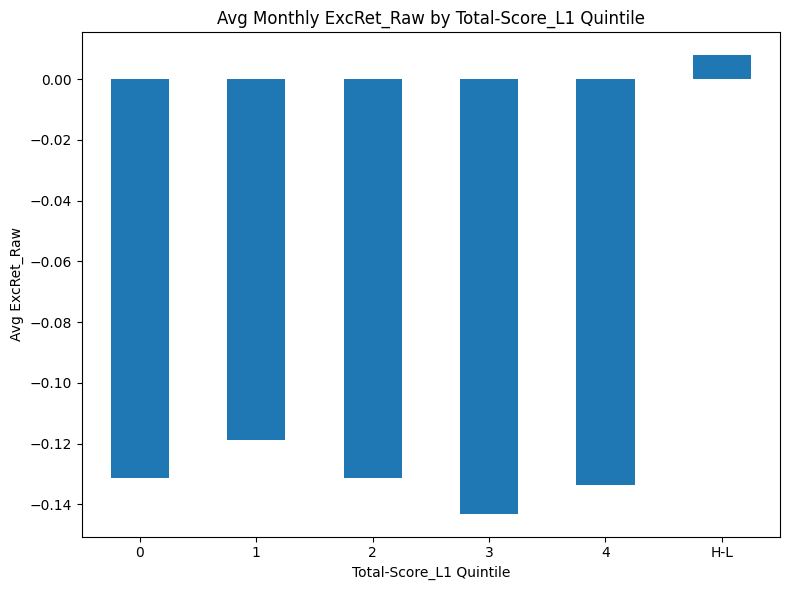


--- Cross-Sectional Analysis (Averaged Regression) ---
Not enough firms (8) or valid IVs (10) for CS average regression.

--- Machine Learning Analysis ---
ML Features (16): ['Total-Score_L1', 'E-Score_L1', 'S-Score_L1', 'G-Score_L1', 'delta_Total-Score_L1', 'delta_E-Score_L1', 'delta_S-Score_L1', 'delta_G-Score_L1', 'log_Price_L1', 'Momentum_6M_L1', 'Mkt-RF_L1', 'SMB_L1', 'HML_L1', 'RMW_L1', 'CMA_L1', 'UMD_L1']
ML Data Split: Train (before 2023-02-28): 600 obs, Test (after): 148 obs
Using TimeSeriesSplit with 5 splits for ML CV.

Training Random Forest...
RF Best Params: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 50}
RF Test R2: -17.9960, MSE: 0.1275
RF Top 10 Feature Importances:
 SMB_L1            0.195922
Mkt-RF_L1         0.167134
CMA_L1            0.134719
E-Score_L1        0.092885
log_Price_L1      0.069228
HML_L1            0.064503
RMW_L1            0.063794
UMD_L1            0.039763
Momentum_6M_L1    0.039733
G-Score_L1        0.032754


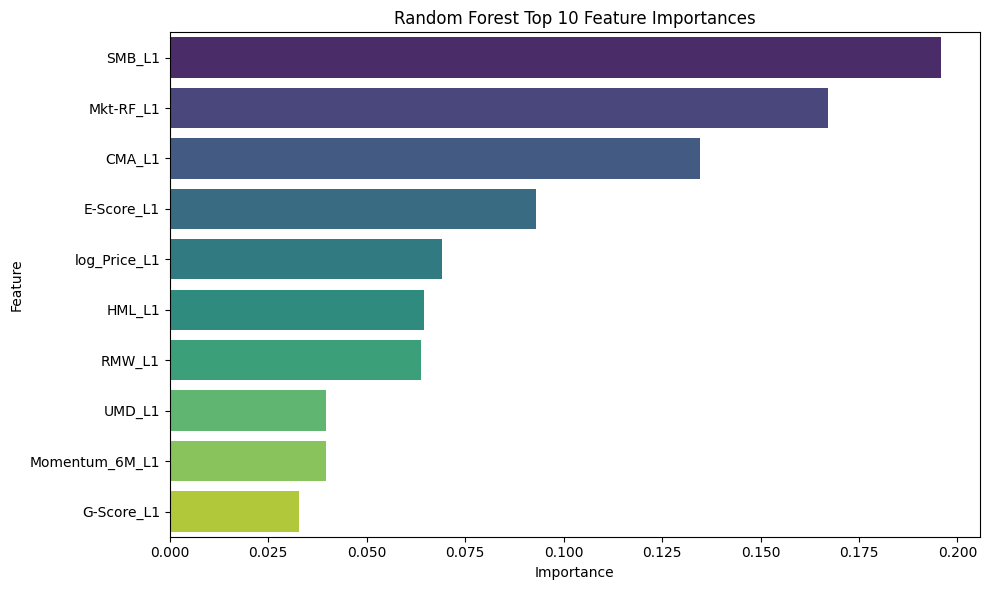


Training XGBoost...
XGB Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
XGB Test R2: -17.2948, MSE: 0.1228
XGB Top 10 Feature Importances:
 SMB_L1                  0.165040
Mkt-RF_L1               0.136534
CMA_L1                  0.118778
delta_E-Score_L1        0.089255
HML_L1                  0.075503
E-Score_L1              0.074461
delta_Total-Score_L1    0.065284
RMW_L1                  0.056507
log_Price_L1            0.047134
UMD_L1                  0.042581


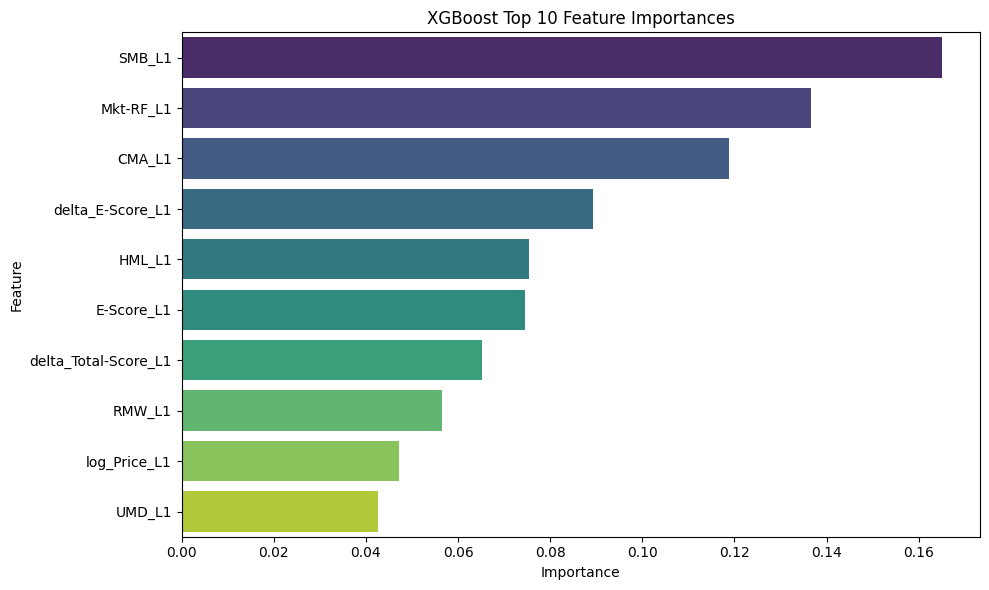


--- ML Performance Summary ---
+---------------+-----------+------------+--------------------------------------------------------------+
| Model         |   Test R2 |   Test MSE | Best Params                                                  |
|---------------+-----------+------------+--------------------------------------------------------------|
| Random Forest |  -17.9960 |     0.1275 | {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 50} |
| XGBoost       |  -17.2948 |     0.1228 | {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}  |
+---------------+-----------+------------+--------------------------------------------------------------+

--- Panel VAR (PVAR) - Illustrative Firm-by-Firm VAR ---
PVAR (Firm-by-Firm VAR) using DV: 'ExcRet_Raw', ESG related variable: 'delta_Total-Score_L1'

Processing VAR for Ticker: ACM
  Using delta ESG variable 'delta_Total-Score_L1' as is for VAR.
  VAR Lag Order for ACM: 3

Processing VAR for Ticker: CRH
  Using delta ESG variabl

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_date

In [32]:
# CELL 1: Install and Import Libraries
# --------------------------------------------------------------------
!pip install linearmodels yfinance openpyxl

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from linearmodels.panel.data import PanelData
from linearmodels.panel.results import PanelEffectsResults, RandomEffectsResults
from statsmodels.regression.linear_model import RegressionResultsWrapper

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from collections import OrderedDict
import yfinance as yf
import requests
import zipfile
import io
import os
import scipy.stats as stats

# Check for pyeconometrics for GMM (Optional, often not installed by default)
try:
    from pyeconometrics.panel import PanelGMM
    GMM_AVAILABLE = True
except ImportError:
    GMM_AVAILABLE = False

if not GMM_AVAILABLE:
    print("pyeconometrics not available/not installed. GMM models will be skipped.")


VIF_THRESHOLD = 10 # Relaxed VIF for models with many controls; can be 5 if preferred
RANDOM_STATE = 42
LAG_PERIODS = 1
SIGNIFICANCE_LEVEL = 0.05

# --- Helper function for creating results tables ---
def create_results_table(model_results, model_name="Model", custom_var_names=None, suppress_dummies=True, dummy_prefixes=['entity_dummy_', 'time_dummy_']):
    if model_results is None: return f"Could not generate table for {model_name}: Model results are None."

    # Handle different result objects (statsmodels vs linearmodels)
    if isinstance(model_results, (RegressionResultsWrapper, PanelEffectsResults, RandomEffectsResults)):
        params = model_results.params
        if hasattr(model_results, 'pvalues'): p_values = model_results.pvalues
        elif hasattr(model_results, 'pval'): p_values = model_results.pval
        else: p_values = pd.Series([np.nan] * len(params), index=params.index)

        if hasattr(model_results, 'std_errors'): std_errs = model_results.std_errors
        elif hasattr(model_results, 'bse'): std_errs = model_results.bse
        else: std_errs = pd.Series([np.nan] * len(params), index=params.index)
    # Add handling for other types if needed, e.g., VAR results summary (though less common here)
    else:
         print(f"Warning: Unsupported model results type for table: {type(model_results)}")
         return f"Could not generate table for {model_name}: Unsupported model results type."


    results_df = pd.DataFrame({'Variable': params.index, 'Coefficient': params.values,
                               'Std. Error': std_errs.values if std_errs is not None else np.nan,
                               'P-value': p_values.values if p_values is not None else np.nan})

    # Suppress dummies for LSDV models (assuming RegressionResultsWrapper might come from Statsmodels OLS with dummies)
    if suppress_dummies and isinstance(model_results, RegressionResultsWrapper):
        is_dummy = pd.Series(False, index=results_df['Variable'])
        for prefix in dummy_prefixes:
            is_dummy = is_dummy | results_df['Variable'].astype(str).str.startswith(prefix)
        results_df = results_df[~is_dummy]

    stars = []
    # Ensure P-value column exists and has non-NaN values before adding stars
    if 'P-value' in results_df.columns and not results_df['P-value'].isnull().all():
        # Convert to numeric just in case, coercing errors
        p_vals_numeric = pd.to_numeric(results_df['P-value'], errors='coerce')
        for p_val in p_vals_numeric:
            if pd.isna(p_val): stars.append('')
            elif p_val < 0.01: stars.append('***')
            elif p_val < 0.05: stars.append('**')
            elif p_val < 0.1: stars.append('*')
            else: stars.append('')
    else:
         # If no P-values or all are NaN, just add empty stars
         stars = [''] * len(results_df)

    results_df['Sig.'] = stars

    # Format coefficient with stars
    results_df['Coefficient_Formatted'] = results_df.apply(lambda r: f"{r['Coefficient']:.4f}{r['Sig.']}" if pd.notna(r['Coefficient']) else "N/A", axis=1)

    display_cols = ['Variable', 'Coefficient_Formatted', 'Std. Error', 'P-value']

    # Ensure P-value column is numeric if it wasn't already for consistent floatfmt
    if 'P-value' in results_df.columns:
        results_df['P-value'] = pd.to_numeric(results_df['P-value'], errors='coerce')


    results_df_display = results_df[display_cols].copy()
    results_df_display.rename(columns={'Coefficient_Formatted': 'Coefficient'}, inplace=True)

    # --- Summary Stats ---
    summary_stats = OrderedDict()
    summary_stats["Model"] = model_name

    # R-squared variants (linearmodels)
    if hasattr(model_results, 'rsquared_overall'): summary_stats["R-sq (Overall)"] = f"{model_results.rsquared_overall:.4f}"
    if hasattr(model_results, 'rsquared_within'): summary_stats["R-sq (Within)"] = f"{model_results.rsquared_within:.4f}"
    if hasattr(model_results, 'rsquared_between'): summary_stats["R-sq (Between)"] = f"{model_results.rsquared_between:.4f}"
    # R-squared (statsmodels or general linearmodels if no within/between)
    if hasattr(model_results, 'rsquared') and not any(k in summary_stats for k in ["R-sq (Overall)", "R-sq (Within)"]):
        summary_stats["R-squared"] = f"{model_results.rsquared:.4f}"
    # Adjusted R-squared (mostly statsmodels)
    if hasattr(model_results, 'rsquared_adj') and isinstance(model_results, RegressionResultsWrapper):
         summary_stats["Adj. R-squared"] = f"{model_results.rsquared_adj:.4f}"


    # Observations
    if hasattr(model_results, 'nobs'): summary_stats["Observations"] = str(int(model_results.nobs))

    # Entity/Time info for panel models
    if isinstance(model_results, (PanelEffectsResults, RandomEffectsResults)):
        if hasattr(model_results, 'entity_info') and model_results.entity_info:
            summary_stats["Entities"] = str(model_results.entity_info.total)
        if hasattr(model_results, 'time_info') and model_results.time_info:
            summary_stats["Time Periods"] = str(model_results.time_info.total)
    elif isinstance(model_results, RegressionResultsWrapper) and 'Ticker' in df_panel.columns: # For LSDV/Pooled SM on df_panel
         # Need to count distinct entities/time periods from the data used for the model
         # This is tricky if the model data frame is temporary.
         # A robust way is to pass the original df_panel and the model's index/used data
         # Or, assume the model was fit on df_panel or a subset, and count from there if possible.
         # For simplicity here, if it's RegressionResultsWrapper, assume it might be LSDV/Pooled on a df like df_model_run
         # Let's add a placeholder note, or try to infer from df_panel if possible (less precise if data was dropped)
         pass # Leaving entity/time count for RegressionResultsWrapper for now unless model data is passed explicitly

    # F-statistic
    f_stat_attr = getattr(model_results, 'f_statistic_robust', getattr(model_results, 'f_statistic', None)) # linearmodels robust/non-robust F
    if f_stat_attr is None and hasattr(model_results, 'fvalue') and hasattr(model_results, 'f_pvalue'): # statsmodels OLS/LSDV F
        f_stat_attr = type('obj', (object,), {'stat': model_results.fvalue, 'pval': model_results.f_pvalue})
    elif f_stat_attr is None and isinstance(model_results, RandomEffectsResults) and hasattr(model_results, 'wald_test_joint'): # LM RE joint test
         # Wald test is similar to F, but might have different interpretation
         # For simplicity, let's try to use f_statistic if available in RE too, or Wald
         if hasattr(model_results, 'f_statistic') and model_results.f_statistic:
             f_stat_attr = model_results.f_statistic
         else: # Fallback to Wald if F is not there for RE
             wald_res = model_results.wald_test_joint() # This requires building the constraint matrix
             if hasattr(wald_res, 'stat') and hasattr(wald_res, 'pval'):
                  # Wald test is Chi-sq distributed, not F. Report appropriately or skip.
                  # Let's report Chi-sq for Wald tests
                  if hasattr(wald_res, 'statistic') and hasattr(wald_res, 'pvalue'): # statsmodels WaldTestResults
                     summary_stats["Wald Test (Model)"] = f"{wald_res.statistic:.4f} (p={wald_res.pvalue:.4f})"
                  elif hasattr(wald_res, 'stat') and hasattr(wald_res, 'pval'): # linearmodels WaldTestStatistic
                     summary_stats["Wald Test (Model)"] = f"{wald_res.stat:.4f} (p={wald_res.pval:.4f})"
                  f_stat_attr = None # Don't use Wald for F-stat line
             else: pass # No suitable joint test found
             pass # Do not continue to print F-stat line below if using Wald

    if f_stat_attr and hasattr(f_stat_attr, 'stat') and hasattr(f_stat_attr, 'pval'):
         # Ensure stat and pval are not NaN/inf before formatting
         if pd.notna(f_stat_attr.stat) and pd.notna(f_stat_attr.pval):
             summary_stats["F-statistic (Model/Robust)"] = f"{f_stat_attr.stat:.4f} (p={f_stat_attr.pval:.4f})"
         else:
             summary_stats["F-statistic (Model/Robust)"] = "N/A"


    footer_list = [f"{k}: {v}" for k,v in summary_stats.items()]
    footer_text = "\n" + "\n".join(footer_list) + "\nSignificance: *** p<0.01, ** p<0.05, * p<0.1"

    if suppress_dummies and isinstance(model_results, RegressionResultsWrapper) and any(idx.startswith(tuple(dummy_prefixes)) for idx in params.index):
        footer_text += "\n(Dummy variable coefficients likely suppressed for LSDV model tables)"


    return tabulate(results_df_display, headers='keys', tablefmt='psql', floatfmt=(".4f", ".4f", ".4f", ".4f"), showindex=False) + footer_text

def create_model_selection_test_table(test_data_list):
    if not test_data_list: return "No model selection test data to display."
    df = pd.DataFrame(test_data_list)
    # Define preferred column order, but only include columns present in the DataFrame
    cols_order = ['Test Name', 'Statistic Value', 'P-value', 'DF', 'Decision']
    df_cols = [col for col in cols_order if col in df.columns]
    df = df[df_cols]

    # Format numeric columns
    floatfmt = {}
    if 'Statistic Value' in df.columns: floatfmt[df.columns.get_loc('Statistic Value')] = ".4f"
    if 'P-value' in df.columns: floatfmt[df.columns.get_loc('P-value')] = ".4f"
    if 'DF' in df.columns: floatfmt[df.columns.get_loc('DF')] = ".0f" # Assuming DF is integer

    # Convert floatfmt dict to tuple format required by tabulate
    floatfmt_tuple = [floatfmt.get(i, None) for i in range(len(df.columns))]


    return tabulate(df, headers='keys', tablefmt='psql', showindex=False, floatfmt=floatfmt_tuple)


# CELL 2, 3, 4, 5, 6, 7: Data Loading and Initial Preprocessing
# Data loading and initial processing block remains unchanged
from google.colab import files
print("Please upload BOTH 'historic_esg_scores_construction.csv' AND your Fama-French factor file (e.g., 'Developed_5_Factors_Momentum.csv').")
uploaded_files = files.upload()

df_esg = pd.DataFrame()
df_ff_raw = pd.DataFrame()

esg_target_filename_base = 'historic_esg_scores_construction'
ff_target_filename_base = 'Developed_5_Factors_Momentum' # Or 'F-F_Research_Data_5_Factors_2x3_Daily' etc. Adjust as needed.

for filename_uploaded, content in uploaded_files.items():
    # Basic check for file content type, though not foolproof
    # if not filename_uploaded.lower().endswith(('.csv', '.xlsx')):
    #     print(f"Skipping potentially non-CSV/Excel file: {filename_uploaded}")
    #     continue

    if esg_target_filename_base.lower() in filename_uploaded.lower():
        # Assuming CSV for now based on prompt
        df_esg = pd.read_csv(io.BytesIO(content))
        print(f"\nESG data '{filename_uploaded}' loaded successfully into df_esg.")
    elif ff_target_filename_base.lower() in filename_uploaded.lower():
        # Assuming CSV for now based on prompt
        df_ff_raw = pd.read_csv(io.BytesIO(content))
        print(f"\nFama-French data '{filename_uploaded}' loaded successfully into df_ff_raw.")
    else:
        print(f"Uploaded file '{filename_uploaded}' does not match expected names ('{esg_target_filename_base}', '{ff_target_filename_base}'). Skipping.")


if df_esg.empty:
    print(f"CRIT ERROR: ESG file matching '{esg_target_filename_base}' not uploaded/read.")
if df_ff_raw.empty:
    print(f"CRIT ERROR: FF file matching '{ff_target_filename_base}' not uploaded/read.")


# Define a default date range or update based on data
min_esg_date = pd.to_datetime("2000-01-01") # Default start
max_esg_date = pd.to_datetime("2023-12-31") # Default end


if not df_esg.empty:
    print("\n--- Preprocessing ESG Data ---")
    # Ensure 'Date' column is datetime, handling potential errors
    # Use 'cache=True' for performance if the same series is converted multiple times
    # Use dateutil parser as default, remove infer_datetime_format if pandas version is >= 2.0
    df_esg['Date'] = pd.to_datetime(df_esg['Date'], errors='coerce') # infer_datetime_format=True removed for newer pandas
    df_esg = df_esg.loc[:, ~df_esg.columns.str.contains('^Unnamed')] # Drop unnamed columns
    df_esg.dropna(subset=['Date', 'Ticker'], inplace=True)

    # Identify ESG score columns - make this more flexible
    esg_cols_initial = ['Total-Score', 'E-Score', 'S-Score', 'G-Score']
    # Filter for columns actually present in the DataFrame
    esg_cols = [col for col in esg_cols_initial if col in df_esg.columns]

    if not esg_cols:
        print("CRIT ERROR: No expected ESG score columns found in df_esg.");
        # Potentially add logic to try other column names if known
        esg_cols = [] # Ensure it's empty if none found
    else:
         print(f"Using ESG columns: {esg_cols}")

    # Convert ESG columns to numeric
    for col in esg_cols:
        df_esg[col] = pd.to_numeric(df_esg[col], errors='coerce')

    # Ensure dates are at month end and remove timezone info if present
    df_esg['Date'] = (df_esg['Date'] + pd.offsets.MonthEnd(0)).dt.tz_localize(None)

    # Drop duplicates, keeping the last score for a given ticker-date
    df_esg = df_esg.drop_duplicates(subset=['Ticker', 'Date'], keep='last')

    print(f"ESG data shape after initial processing: {df_esg.shape}")

    # Update date range based on ESG data
    if not df_esg.empty:
        # Give some buffer around the ESG data dates for stock price download
        min_esg_date = df_esg['Date'].min() - pd.DateOffset(months=12)
        max_esg_date = df_esg['Date'].max() + pd.DateOffset(months=3)
        print(f"Determined data download range: {min_esg_date.strftime('%Y-%m-%d')} to {max_esg_date.strftime('%Y-%m-%d')}")
    else:
        print("Warning: ESG data empty after processing. Using default date range.")

else:
    print("Skipping ESG preprocessing as df_esg is empty.")


print("\n--- Processing Manually Uploaded Fama-French Factors ---")
df_ff = pd.DataFrame()
ff_factor_cols_renamed = [] # Initialize as empty list

if not df_ff_raw.empty:
    try:
        df_ff = df_ff_raw.copy()

        # Attempt to parse the date column
        # Assume the first column is the date column
        date_col_name = df_ff.columns[0]
        df_ff.rename(columns={date_col_name: 'Date_str'}, inplace=True, errors='ignore')

        df_ff['Date_str'] = df_ff['Date_str'].astype(str).str.strip()

        # Try common FF formats first, then general inference
        date_parsed_successfully = False
        # %Y%m for monthly, %Y%m%d for daily, common variations like %m/%d/%y
        date_formats_to_try = ['%m/%d/%y', '%Y%m%d', '%Y%m', '%Y-%m-%d', '%m/%d/%Y'] # Added more formats
        for fmt in date_formats_to_try:
            try:
                # Use errors='raise' temporarily to catch specific format issues
                df_ff['Date'] = pd.to_datetime(df_ff['Date_str'], format=fmt, errors='raise')
                date_parsed_successfully = True
                print(f"  Parsed FF dates using format: {fmt}")
                break # Stop trying formats once successful
            except (ValueError, TypeError):
                continue # Try the next format

        if not date_parsed_successfully:
             print("  Specific date formats failed, trying pandas inference for FF dates...")
             df_ff['Date'] = pd.to_datetime(df_ff['Date_str'], errors='coerce') # Fallback to pandas inference

        # Drop rows where date parsing failed
        df_ff.dropna(subset=['Date'], inplace=True)

        if df_ff.empty:
             raise ValueError("FF DataFrame empty after date parsing.")

        # Ensure FF dates are also end of month and remove timezone info
        df_ff['Date'] = (df_ff['Date'] + pd.offsets.MonthEnd(0)).dt.tz_localize(None)

        # Rename common Fama-French factor columns to consistent names
        # Add variations like 'Mom   ' -> 'UMD'
        factor_rename_map_manual = {
            'Mkt-RF':'Mkt-RF', 'SMB':'SMB', 'HML':'HML',
            'RMW':'RMW', 'CMA':'CMA', 'RF':'RF',
            'WML':'UMD', 'Mom   ':'UMD', 'MOM':'UMD' # Handle different momentum names
        }
        df_ff.columns = [col.strip() for col in df_ff.columns] # Strip whitespace from column names
        df_ff.rename(columns=factor_rename_map_manual, inplace=True)

        # Identify the actual FF columns present after renaming
        ff_factor_cols_standard = ['Mkt-RF','SMB','HML','RMW','CMA','RF','UMD']
        actual_ff_cols_present = [col for col in ff_factor_cols_standard if col in df_ff.columns]

        if len(actual_ff_cols_present) < 6: # Check if at least 5 factors + RF are present
            print(f"Warn: Not all expected 5 factors + RF (+ Momentum) found. Present: {actual_ff_cols_present}")

        # Convert factor columns to numeric, handling potential non-numeric entries
        # Also, check if values are already percentages (e.g., 0.01 vs 1.0) and divide by 100 if needed
        for col in actual_ff_cols_present:
            df_ff[col] = pd.to_numeric(df_ff[col], errors='coerce')
            # Simple check: if mean absolute value is > 0.5 but < 100, assume it's in percent
            if col in df_ff.columns and df_ff[col].abs().mean() > 0.5 and df_ff[col].abs().mean() < 100 :
                 print(f"  Assuming FF factor '{col}' is in percentage format, dividing by 100.")
                 df_ff[col] = df_ff[col] / 100.0


        # Keep only Date and the identified factor columns
        df_ff = df_ff[['Date'] + actual_ff_cols_present].copy()

        # Drop rows with NaNs in factor columns after conversion/cleaning
        df_ff.dropna(subset=actual_ff_cols_present, how='any', inplace=True)

        print(f"Processed FF data shape: {df_ff.shape}")
        print(df_ff.head())

        # Store the list of FF factor columns (excluding Date)
        ff_factor_cols_renamed = [col for col in df_ff.columns if col != 'Date']

    except Exception as e:
        print(f"CRIT ERROR processing FF file: {e}")
        df_ff = pd.DataFrame() # Ensure df_ff is empty if processing failed
        ff_factor_cols_renamed = []

else:
    print("FF raw data empty.")

if df_ff.empty:
    print("CRIT: FF data not processed or is empty.")
    ff_factor_cols_renamed = [] # Ensure empty if FF processing failed


if not df_esg.empty: # Proceed with stock price download only if ESG data was loaded
    print("\n--- Downloading Historical Stock Prices ---")
    tickers_list_orig = df_esg['Ticker'].unique().tolist()
    print(f"Original tickers from ESG file: {tickers_list_orig}")

    # Manual ticker mapping for known issues (e.g., J -> J)
    # Add more mappings if needed, e.g. {'ACS.MC': 'ACS.MC'} if yfinance needs specific format
    ticker_map_manual = {'CRH': 'CRH', 'J': 'J'} # Add or correct problematic tickers

    all_stock_data_list = []
    successful_tickers_map = {} # To map ESG ticker to successfully downloaded yf ticker

    # Limit number of tickers for download if it's very large (optional)
    # tickers_to_download = tickers_list_orig[:50] # Example: limit to first 50

    for esg_ticker in tickers_list_orig: # Use the original list
        yf_ticker_to_try = ticker_map_manual.get(esg_ticker, esg_ticker) # Use mapped ticker or original
        print(f"Attempting download for ESG '{esg_ticker}' as yf '{yf_ticker_to_try}'...")

        try:
            stock = yf.Ticker(yf_ticker_to_try)
            # Download daily data within the determined date range
            hist = stock.history(start=min_esg_date.strftime('%Y-%m-%d'), end=max_esg_date.strftime('%Y-%m-%d'), interval="1d", auto_adjust=True, actions=False)

            if not hist.empty and 'Close' in hist.columns:
                # Resample to monthly, taking the last closing price of the month
                hist_monthly = hist[['Close']].resample('ME').last()
                hist_monthly.rename(columns={'Close': 'Price'}, inplace=True)
                hist_monthly['Ticker_ESG'] = esg_ticker # Keep original ESG ticker identifier
                hist_monthly['Ticker_yf'] = yf_ticker_to_try # Keep yfinance ticker used
                hist_monthly.reset_index(inplace=True) # Date becomes a column again

                # Append to list, keeping only necessary columns
                all_stock_data_list.append(hist_monthly[['Date', 'Ticker_ESG', 'Ticker_yf', 'Price']])
                print(f"  Success: '{esg_ticker}' as '{yf_ticker_to_try}'.")
                successful_tickers_map[esg_ticker] = yf_ticker_to_try # Record successful mapping
            else:
                print(f"  No data or 'Close' column found for '{esg_ticker}' as '{yf_ticker_to_try}'.")

        except Exception as e:
            print(f"  Error downloading data for '{esg_ticker}' as '{yf_ticker_to_try}': {e}")

    if not all_stock_data_list:
        print("CRIT ERROR: No stock data downloaded successfully.")
        df_prices = pd.DataFrame() # Ensure df_prices is empty if no data downloaded
    else:
        df_prices = pd.concat(all_stock_data_list, ignore_index=True)
        print(f"\nDownloaded stock data for {df_prices['Ticker_ESG'].nunique()} unique ESG tickers.")
        print(f"Processed ESG tickers: {list(successful_tickers_map.keys())}")

else:
    print("Skipping stock price download as ESG data is not loaded.")
    df_prices = pd.DataFrame() # Ensure df_prices is empty


if not df_prices.empty:
    print("\n--- Preprocessing Stock Price Data & Basic Controls ---")
    df_prices['Date'] = pd.to_datetime(df_prices['Date'], errors='coerce')
    # Ensure dates are month-end and timezone-naive, matching FF/ESG
    df_prices['Date'] = (df_prices['Date'] + pd.offsets.MonthEnd(0)).dt.tz_localize(None)

    # Keep only relevant columns
    df_prices = df_prices[['Date', 'Ticker_ESG', 'Price']].copy()
    df_prices.dropna(subset=['Date', 'Ticker_ESG', 'Price'], inplace=True)

    # Convert Price to numeric
    df_prices['Price'] = pd.to_numeric(df_prices['Price'], errors='coerce')

    # Sort data for calculations
    df_prices.sort_values(by=['Ticker_ESG', 'Date'], inplace=True)

    # Calculate monthly return
    df_prices['Return'] = df_prices.groupby('Ticker_ESG')['Price'].pct_change()

    # Create lagged price (for log_Price_L1) and lagged return (for Momentum)
    # Ensure LAG_PERIODS is at least 1
    if LAG_PERIODS < 1:
        print("Warning: LAG_PERIODS must be at least 1. Setting to 1.")
        LAG_PERIODS = 1

    shifted_price = df_prices.groupby('Ticker_ESG')['Price'].shift(LAG_PERIODS)
    shifted_price_no_zero = shifted_price.replace(0, np.nan) # Avoid log(0)
    df_prices['log_Price_L1'] = np.log(shifted_price_no_zero)
    df_prices['log_Price_L1'].replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf/-inf from log(very small number)

    df_prices['Return_L1'] = df_prices.groupby('Ticker_ESG')['Return'].shift(LAG_PERIODS) # Lagged Return

    # Calculate 6-month momentum using lagged returns
    # Rolling sum over the *last* 6 months *before* the current month (using Return_L1)
    # Rolling window size should be number of periods, e.g., 6 for 6 months.
    # Let's use 5 periods *before* Return_L1, plus Return_L1 itself, covering a lookback of 6 months.
    # The shift(1) is critical to ensure it's based on *past* returns relative to the current row's date.
    # A window of 6 applied to Return_L1 *then* shifted by 1 means we sum returns from t-7 to t-2.
    # If we want sum of t-1 to t-6, we should apply rolling(6) directly to 'Return' and then shift by 1. Let's do that.
    df_prices['Momentum_6M_L1'] = df_prices.groupby('Ticker_ESG')['Return'].transform(lambda x: x.rolling(window=6, min_periods=3).sum().shift(LAG_PERIODS) )
    # min_periods=3 allows momentum to be calculated even with 3 months of data in the window

    # Drop rows where Return is NaN (these are typically the first row per ticker)
    df_prices.dropna(subset=['Return'], inplace=True)

    print(f"Stock price data shape after return & basic controls: {df_prices.shape}")
    print(df_prices[['Ticker_ESG', 'Date', 'Price', 'Return', 'log_Price_L1', 'Momentum_6M_L1']].head(10))

else:
    print("Skipping stock price preprocessing: download failed or df_prices is empty.")


print("\n--- Merging DataFrames ---")
# Check if all required DataFrames are available and not empty
if df_prices.empty or df_ff.empty or df_esg.empty:
    print("Cannot merge: stock price, Fama-French, or ESG data missing or empty.");
    df_panel = pd.DataFrame() # Ensure df_panel is empty if merge fails
else:
    # Merge stock prices with Fama-French factors on Date
    df_merged = pd.merge(df_prices, df_ff, on='Date', how='inner')

    # Merge the result with ESG data on Ticker and Date
    # Use Ticker_ESG from df_merged and Ticker from df_esg
    df_panel = pd.merge(df_merged, df_esg, left_on=['Ticker_ESG', 'Date'], right_on=['Ticker', 'Date'], how='inner')

    # Drop the redundant Ticker_ESG column if it exists and Ticker is the intended key
    if 'Ticker_ESG' in df_panel.columns and 'Ticker' in df_panel.columns and 'Ticker_ESG' != 'Ticker':
        df_panel.drop(columns=['Ticker_ESG'], inplace=True, errors='ignore')
        # Ensure the primary identifier is named 'Ticker' for consistency
        df_panel.rename(columns={'Ticker': 'Ticker'}, inplace=True, errors='ignore') # Rename Ticker to Ticker (no-op but confirms name)


    # Define columns essential for subsequent steps (DV, identifiers, ESG, FF)
    # Need to ensure ff_factor_cols_renamed is defined even if FF loading failed
    if 'ff_factor_cols_renamed' not in locals():
        ff_factor_cols_renamed = []

    required_cols_for_dropna = ['Return', 'Ticker', 'Date'] + \
                               [col for col in ff_factor_cols_renamed if col == 'RF' and col in df_panel.columns] + \
                               [col for col in esg_cols if col in df_panel.columns]

    # Add other FF factors if they are present and not already added (e.g., Mkt-RF, SMB, ...)
    for ff_col_check in ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']:
        if ff_col_check in df_panel.columns and ff_col_check not in required_cols_for_dropna:
             required_cols_for_dropna.append(ff_col_check)

    # Ensure uniqueness and filter for columns actually present in df_panel
    required_cols_for_dropna = list(set(required_cols_for_dropna))
    required_cols_for_dropna = [col for col in required_cols_for_dropna if col in df_panel.columns]

    # Check if any required columns are missing entirely from the merged data
    missing_cols_in_panel = [col for col in required_cols_for_dropna if col not in df_panel.columns]
    if missing_cols_in_panel:
        print(f"Warn: Missing required columns in df_panel before dropna: {missing_cols_in_panel}")
        # Filter required_cols_for_dropna to only include those actually present
        required_cols_for_dropna = [col for col in required_cols_for_dropna if col in df_panel.columns]


    # Drop rows with NaNs in essential columns
    if required_cols_for_dropna: # Only attempt dropna if there are columns to check
        initial_rows = df_panel.shape[0]
        df_panel.dropna(subset=required_cols_for_dropna, inplace=True)
        rows_dropped = initial_rows - df_panel.shape[0]
        if rows_dropped > 0:
            print(f"Dropped {rows_dropped} rows due to NaN in essential columns: {required_cols_for_dropna}")
    else:
        print("Warning: No essential columns identified for dropna after merge.")


    print(f"Final merged panel data shape: {df_panel.shape}")
    if df_panel.empty:
        print("CRIT ERROR: Merged panel data is empty after dropping NaNs in essential columns.")
    else:
        print(df_panel.head())


# CELL 8: Define Dependent Variable, Prepare Controls, and Lagging
dependent_var_name = '' # Initialize as empty string

# Define lagged firm controls based on potential columns
lagged_firm_controls_list = [col for col in ['log_Price_L1', 'Momentum_6M_L1'] if col in df_panel.columns]


if not df_panel.empty and 'RF' in df_panel.columns:
    print("\n--- Defining Dependent Variable & Lagging Controls ---")
    # Define dependent variable (Excess Return)
    df_panel['ExcRet_Raw'] = df_panel['Return'] - df_panel['RF']

    dependent_var_name = 'ExcRet_Raw'
    print(f"Using '{dependent_var_name}' as the dependent variable.")

    # Create lagged Fama-French factors for use as controls
    # Ensure ff_factor_cols_renamed is available from FF processing
    if 'ff_factor_cols_renamed' not in locals():
        ff_factor_cols_renamed = []
        print("Warning: FF factor column names not available. Cannot create lagged FF controls.")
        temp_ff_controls_lagged = []
    else:
        temp_ff_controls_lagged = []
        # Lag all FF factors *except* RF
        for ff_col in [col for col in ff_factor_cols_renamed if col != 'RF' and col in df_panel.columns]:
            # Ensure column exists before attempting to shift
            if ff_col in df_panel.columns:
                df_panel[f'{ff_col}_L{LAG_PERIODS}'] = df_panel.groupby('Ticker')[ff_col].shift(LAG_PERIODS)
                temp_ff_controls_lagged.append(f'{ff_col}_L{LAG_PERIODS}')
            else:
                 print(f"Warning: FF control '{ff_col}' not found in df_panel, cannot lag.")

    # Filter the list to include only columns successfully created
    ff_controls_for_regression = [col for col in temp_ff_controls_lagged if col in df_panel.columns]
    print(f"Lagged Fama-French factors to be used as controls: {ff_controls_for_regression}")

    # Check if dependent variable was created successfully and is not all NaNs
    if df_panel.empty or dependent_var_name not in df_panel.columns or df_panel[dependent_var_name].isnull().all():
        print(f"CRIT ERROR: Panel data empty or dependent variable ('{dependent_var_name}') is missing or all NaN after creation.")
        df_panel = pd.DataFrame() # Clear df_panel if DV is invalid
        dependent_var_name = '' # Reset DV name
else:
    print("Skipping dependent variable definition: df_panel empty or 'RF' column missing.")
    df_panel = pd.DataFrame() # Clear df_panel
    dependent_var_name = '' # Reset DV name


# Check if lagged firm controls were successfully identified
if not lagged_firm_controls_list:
    print("WARNING: No firm-specific control variables ('log_Price_L1', 'Momentum_6M_L1') were processed or found.")


# CELL 9: Create Lagged ESG Variables and Target Future Dependent Variable
lagged_esg_cols = []
delta_esg_cols = []

# Proceed only if df_panel is not empty and dependent variable is defined
if not df_panel.empty and dependent_var_name and dependent_var_name in df_panel.columns:
    print("\n--- Creating Lagged ESG, Deltas, and Future Dependent Variable ---")

    # Ensure data is sorted by Ticker and Date for correct lagging/leading
    df_panel = df_panel.sort_values(['Ticker', 'Date'])

    # Create the future dependent variable (e.g., future excess return)
    df_panel[f'{dependent_var_name}_F1'] = df_panel.groupby('Ticker')[dependent_var_name].shift(-1)

    # Create lagged ESG variables and delta (change) in ESG variables
    # Ensure esg_cols is available from initial processing
    if 'esg_cols' not in locals():
         esg_cols = []
         print("Warning: ESG column names not available. Cannot create lagged/delta ESG variables.")

    for esg_col in esg_cols:
        if esg_col in df_panel.columns: # Ensure ESG column exists
            # Lagged ESG
            lag_col_name = f'{esg_col}_L{LAG_PERIODS}'
            df_panel[lag_col_name] = df_panel.groupby('Ticker')[esg_col].shift(LAG_PERIODS)
            lagged_esg_cols.append(lag_col_name)

            # Delta ESG (Change from t-LAG_PERIODS-1 to t-LAG_PERIODS)
            delta_col_name = f'delta_{esg_col}_L{LAG_PERIODS}'
            # Need t-(LAG_PERIODS+1) value to calculate change
            df_panel[f'{esg_col}_L{LAG_PERIODS+1}'] = df_panel.groupby('Ticker')[esg_col].shift(LAG_PERIODS+1)

            # Calculate delta if both lagged columns exist
            if f'{esg_col}_L{LAG_PERIODS+1}' in df_panel.columns and lag_col_name in df_panel.columns:
                 df_panel[delta_col_name] = df_panel[lag_col_name] - df_panel[f'{esg_col}_L{LAG_PERIODS+1}']
                 delta_esg_cols.append(delta_col_name)
            else:
                 print(f"Warning: Could not create delta for '{esg_col}_L{LAG_PERIODS}' due to missing required lags.")


            # Drop the temporary doubly-lagged column
            df_panel.drop(columns=[f'{esg_col}_L{LAG_PERIODS+1}'], inplace=True, errors='ignore')
        else:
            print(f"Warning: Original ESG column '{esg_col}' not found in df_panel. Cannot create lagged/delta.")


    # Define columns that must be non-NaN for regression analysis
    # This includes the future DV, all lagged ESG, all delta ESG, lagged firm controls, and lagged FF controls.
    cols_to_check_na = [f'{dependent_var_name}_F1'] + \
                       [col for col in lagged_esg_cols if col in df_panel.columns] + \
                       [col for col in delta_esg_cols if col in df_panel.columns] + \
                       [col for col in lagged_firm_controls_list if col in df_panel.columns] + \
                       [col for col in ff_controls_for_regression if col in df_panel.columns]

    # Drop rows with NaNs in any of these critical columns
    if cols_to_check_na: # Only attempt dropna if there are columns to check
        initial_rows = df_panel.shape[0]
        df_panel.dropna(subset=cols_to_check_na, inplace=True)
        rows_dropped = initial_rows - df_panel.shape[0]
        if rows_dropped > 0:
            print(f"Dropped {rows_dropped} rows due to NaN in required modeling columns: {cols_to_check_na}")
    else:
        print("Warning: No modeling columns identified for dropna after creating lags/leads/deltas.")


    print(f"Panel shape after lags/leads/deltas & dropna: {df_panel.shape}")

    if df_panel.empty:
        print(f"CRIT ERROR: Panel data is empty after creating lags/leads/deltas and dropping NaNs.")
    else:
        print(df_panel.head())

else:
    print("Skipping lags/leads/deltas creation: df_panel empty or dependent variable missing/invalid.")


# CELL 10: Imputation
# Imputation block remains unchanged
if not df_panel.empty:
    print("\n--- Imputation for Predictor Variables ---")

    # Identify all predictor columns that might contain NaNs *after* lagging/differencing but *before* the final dropna
    # The final dropna removes rows with NaNs in *required* modeling columns.
    # Imputation is useful for handling NaNs in predictors that are *not* part of the essential subset used in the final dropna,
    # or if you want to impute *before* the final dropna.
    # Given the current structure, imputation happens *after* creating lagged/delta variables, but *before* the final dropna in Cell 9.
    # So, this block attempts to impute NaNs created by lags *before* those rows are potentially dropped.

    # Let's define the columns to impute as the potential predictors identified earlier
    # (lagged esg, delta esg, lagged firm controls, lagged ff controls)
    predictor_cols_for_imputation = list(set(lagged_esg_cols + delta_esg_cols + lagged_firm_controls_list + ff_controls_for_regression))
    # Filter this list to ensure columns actually exist in df_panel at this stage
    predictor_cols_for_imputation = [col for col in predictor_cols_for_imputation if col in df_panel.columns]

    if predictor_cols_for_imputation:
        df_to_impute = df_panel[predictor_cols_for_imputation].copy()

        # Check if there are any NaNs in these specific predictor columns
        if df_to_impute.isnull().sum().sum() > 0:
            print(f"NaNs before imputation:\n{df_to_impute.isnull().sum()[df_to_impute.isnull().sum()>0].sort_values(ascending=False)}")

            # Initialize the IterativeImputer with BayesianRidge estimator
            imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=RANDOM_STATE, tol=1e-3) # Reduced max_iter for faster execution if needed

            # Apply imputation to the selected predictor columns
            # The imputer returns a numpy array; assign it back to the DataFrame columns
            # Ensure index alignment if necessary, though IterativeImputer should preserve order
            df_panel[predictor_cols_for_imputation] = imputer.fit_transform(df_to_impute)

            print("Imputation complete.")
        else:
            print("No NaNs in predictors for imputation.")
    else:
        print("No predictor columns identified for imputation.")

else:
    print("Skipping Imputation: df_panel is empty.")


# CELL 11: Define IV Sets for Panel Models (VIF done per model in Cell 12)
# This block remains unchanged
panel_model_core_esg_ivs = {}

# Proceed only if df_panel is not empty and esg_cols are available
if not df_panel.empty and 'esg_cols' in locals() and esg_cols:
    print("\n--- Defining Core ESG IV Sets for Panel Models ---")

    # Total Score Specifications
    if f'Total-Score_L{LAG_PERIODS}' in df_panel.columns:
        panel_model_core_esg_ivs["TotalScore_L1"] = [f'Total-Score_L{LAG_PERIODS}']
    if f'delta_Total-Score_L{LAG_PERIODS}' in df_panel.columns:
        panel_model_core_esg_ivs["delta_TotalScore_L1"] = [f'delta_Total-Score_L{LAG_PERIODS}']
    if f'Total-Score_L{LAG_PERIODS}' in df_panel.columns and f'delta_Total-Score_L{LAG_PERIODS}' in df_panel.columns:
        panel_model_core_esg_ivs["TotalScore_L1_and_Delta"] = [f'Total-Score_L{LAG_PERIODS}', f'delta_Total-Score_L{LAG_PERIODS}']

    # Individual E, S, G Score Specifications
    for score_comp in ['E-Score', 'S-Score', 'G-Score']:
        if f'{score_comp}_L{LAG_PERIODS}' in df_panel.columns:
            panel_model_core_esg_ivs[f"{score_comp}_L1"] = [f'{score_comp}_L{LAG_PERIODS}']
        if f'delta_{score_comp}_L{LAG_PERIODS}' in df_panel.columns:
            panel_model_core_esg_ivs[f"delta_{score_comp}_L1"] = [f'delta_{score_comp}_L{LAG_PERIODS}']


    print("Defined Panel Model Core ESG IV Specifications:")
    for spec_name, ivs in panel_model_core_esg_ivs.items():
        print(f"  {spec_name}: {ivs}")

else:
    print("Skipping IV set definition as df_panel is empty or esg_cols are missing.")


# CELL 12: Panel Regression Models & Model Selection (REVISED with LSDV Fallback)
# THIS IS THE MAIN PANEL MODELLING BLOCK (Corrected time index for linearmodels)
panel_model_results_all_specs = {}
panel_model_tables_all_specs = {}
overall_model_selection_summary = []

# Proceed only if df_panel is not empty, core ESG IVs are defined, and the future DV exists
if not df_panel.empty and panel_model_core_esg_ivs and f'{dependent_var_name}_F1' in df_panel.columns:
    print("\n--- Panel Regression Modeling (linearmodels & LSDV Fallback) ---")

    df_reg_base_panel = df_panel.copy()
    # Convert Ticker to string for safety and consistent indexing
    df_reg_base_panel['Ticker_Str'] = df_reg_base_panel['Ticker'].astype(str)
    # REMOVE: df_reg_base_panel['Date_Period'] = pd.to_datetime(df_reg_base_panel['Date']).dt.to_period('M') # NOT NEEDED FOR LINEARMODELS INDEX

    for spec_name, current_esg_iv_list in panel_model_core_esg_ivs.items():
        if not current_esg_iv_list:
            continue

        print(f"\n\n=== Running Panel Models for Specification: {spec_name} ===")

        # Combine ESG IVs with control variables for this specification
        ivs_for_this_run_with_controls = list(OrderedDict.fromkeys(current_esg_iv_list + ff_controls_for_regression + lagged_firm_controls_list))
        # Filter list to ensure columns exist in the dataframe
        ivs_for_this_run_with_controls = [col for col in ivs_for_this_run_with_controls if col in df_reg_base_panel.columns]

        if not ivs_for_this_run_with_controls:
            print(f"No valid IVs for spec {spec_name}. Skipping.");
            continue
        print(f"IVs for this spec (ESG + Controls): {ivs_for_this_run_with_controls}")


        # --- VIF Check ---
        X_vif_check_spec = df_reg_base_panel[ivs_for_this_run_with_controls].copy().replace([np.inf,-np.inf],np.nan).dropna()
        final_ivs_for_this_spec_after_vif = ivs_for_this_run_with_controls # Start with full list

        if X_vif_check_spec.shape[1] >= 2 and not X_vif_check_spec.empty:
            temp_vif_ivs = X_vif_check_spec.columns.tolist() # Use columns from the VIF check data
            print(f"  VIF Check for {spec_name} (IVs: {temp_vif_ivs})...")
            # Iteratively remove high-VIF features
            for i_vif in range(len(temp_vif_ivs)): # Limit iterations to number of features
                if len(temp_vif_ivs) < 2:
                    break # Need at least two features for VIF

                X_iter_vif = X_vif_check_spec[temp_vif_ivs].astype(float) # Use the reduced set for VIF calculation
                # Check for constant columns in the current iteration's data
                if (X_iter_vif.nunique() < 2).any():
                    constant_cols = X_iter_vif.columns[X_iter_vif.nunique() < 2].tolist()
                    print(f"  VIF Iter ({spec_name}): Const cols {constant_cols}. Removing.")
                    for c_col in constant_cols:
                         if c_col in temp_vif_ivs:
                             temp_vif_ivs.remove(c_col)
                    if len(temp_vif_ivs) < 2: break # Check again after removing constant cols
                    continue # Restart loop with reduced set

                vif_df = pd.DataFrame(); vif_df["feature"]=temp_vif_ivs
                try:
                    # Add a constant for VIF calculation if not already present
                    # VIF requires the matrix used in regression, including constant if used
                    X_iter_vif_with_const = sm.add_constant(X_iter_vif, has_constant='add')
                    vif_df["VIF"]=[variance_inflation_factor(X_iter_vif_with_const.values,j) for j in range(X_iter_vif_with_const.shape[1])]
                    vif_df = vif_df[vif_df['feature'] != 'const'].sort_values(by="VIF",ascending=False) # Exclude constant VIF

                    if not vif_df.empty and vif_df["VIF"].iloc[0] > VIF_THRESHOLD:
                        remove_feature = vif_df["feature"].iloc[0]
                        temp_vif_ivs.remove(remove_feature) # Remove from the list for the next iteration
                        X_vif_check_spec.drop(columns=[remove_feature], inplace=True, errors='ignore') # Also remove from the VIF check data
                        print(f"    Removing '{remove_feature}' (VIF: {vif_df['VIF'].iloc[0]:.2f})")
                    else:
                        print(f"  All remaining VIFs for {spec_name} below threshold or no features left to check.")
                        break # Stop iteration if no high VIFs found or only one feature left

                except Exception as e_vif:
                    print(f"  Error during VIF calculation for {spec_name} (iter {i_vif+1}): {e_vif}")
                    break # Stop iteration if VIF calculation fails

            final_ivs_for_this_spec_after_vif = temp_vif_ivs # Update final list

        elif len(ivs_for_this_run_with_controls) == 1:
             final_ivs_for_this_spec_after_vif = ivs_for_this_run_with_controls
             print(f"  Only one IV for {spec_name}, no VIF needed: {final_ivs_for_this_spec_after_vif}")
        else:
             print(f"  Not enough IVs for VIF ({len(ivs_for_this_run_with_controls)}) in {spec_name} or data empty. Using original set.")
             final_ivs_for_this_spec_after_vif = ivs_for_this_run_with_controls # Use original list if VIF not applicable/failed


        if not final_ivs_for_this_spec_after_vif:
            print(f"No IVs left for spec {spec_name} after VIF check. Skipping.");
            continue

        # Prepare data for modeling: keep only necessary columns and drop any remaining NaNs
        # Note: Imputation was done earlier, but lagged DV will have NaNs at the start, future DV at the end.
        # The dropna here ensures the model is run on a complete dataset for the selected variables.
        cols_for_model_run = [f'{dependent_var_name}_F1', 'Ticker_Str', 'Date'] + final_ivs_for_this_spec_after_vif
        df_model_run = df_reg_base_panel[cols_for_model_run].copy()
        df_model_run.dropna(subset=[f'{dependent_var_name}_F1'] + final_ivs_for_this_spec_after_vif, inplace=True) # Dropna on DV and final IVs

        if df_model_run.empty or df_model_run.shape[0] < len(final_ivs_for_this_spec_after_vif) + 5: # Check for sufficient observations
            print(f"Not enough data for Spec {spec_name} after final NaN drop ({df_model_run.shape[0]} obs). Skipping.");
            continue

        # Prepare data for Statsmodels (for Pooled OLS and potential LSDV fallback)
        Y_run_sm = df_model_run[f'{dependent_var_name}_F1']
        X_run_vars_only_sm = df_model_run[final_ivs_for_this_spec_after_vif]
        X_run_pooled_sm = sm.add_constant(X_run_vars_only_sm.astype(float), has_constant='add') # Add constant for statsmodels

        # Prepare data for linearmodels
        # Use the original 'Date' (datetime) as the time index
        df_lm_run = df_model_run.set_index(['Ticker_Str', 'Date']).sort_index()
        Y_lm_run = df_lm_run[f'{dependent_var_name}_F1']
        X_lm_run = sm.add_constant(df_lm_run[final_ivs_for_this_spec_after_vif].astype(float), has_constant='add') # Add constant for linearmodels


        # Get dimensions for checks and printing
        n_obs_s = df_model_run.shape[0]
        n_entities_s = df_model_run['Ticker_Str'].nunique()
        n_time_s = df_model_run['Date'].nunique() # Count unique dates
        n_reg_s = X_lm_run.shape[1] # Number of regressors including constant

        print(f"  Data for {spec_name}: Obs={n_obs_s}, Entities={n_entities_s}, Time Periods={n_time_s}, Regressors={n_reg_s}")

        results_this_spec = {} # Dictionary to store results for this specification


        # --- Run Models ---

        # 1. Pooled OLS (linearmodels - preferred for panel data)
        # Need sufficient observations relative to regressors
        if n_obs_s >= n_reg_s + 5:
            try:
                print(f"  Running Pooled OLS (LM) for {spec_name}...")
                model_p_lm = PooledOLS(Y_lm_run, X_lm_run)
                # Use clustered standard errors by entity
                res_p_lm = model_p_lm.fit(cov_type='clustered', cluster_entity=True)
                results_this_spec['Pooled OLS (LM)'] = res_p_lm
                panel_model_tables_all_specs[f'{spec_name} - Pooled OLS (LM)'] = create_results_table(res_p_lm, f"{spec_name} - Pooled OLS (LM)")
                print(f"  Pooled OLS (LM) for {spec_name} successful.")
            except Exception as e:
                print(f"  Error Pooled OLS (LM) for {spec_name}: {e}")
                results_this_spec['Pooled OLS (LM)'] = None
        else:
            print(f"  Skipping Pooled OLS (LM) for {spec_name}: Insufficient observations ({n_obs_s} < {n_reg_s + 5}).")
            results_this_spec['Pooled OLS (LM)'] = None # Explicitly set to None

        # 2. Entity Fixed Effects (linearmodels)
        linearmodels_entity_fe_success = False
        # Need sufficient observations relative to regressors and entities for FE
        # n_reg_s + n_entities_s + 5 is a heuristic check for degrees of freedom
        if n_obs_s >= (n_reg_s + n_entities_s + 5):
            try:
                print(f"  Running Entity FE (LM) for {spec_name}...")
                model_fe_e_lm = PanelOLS(Y_lm_run, X_lm_run, entity_effects=True, drop_absorbed=True)
                # Use clustered standard errors by entity
                res_fe_e_lm = model_fe_e_lm.fit(cov_type='clustered', cluster_entity=True)
                results_this_spec['Entity FE (LM)'] = res_fe_e_lm
                panel_model_tables_all_specs[f'{spec_name} - Entity FE (LM)'] = create_results_table(res_fe_e_lm, f"{spec_name} - Entity FE (LM)")
                linearmodels_entity_fe_success = True
                print(f"  Entity FE (LM) for {spec_name} successful.")
            except Exception as e:
                print(f"  Error Entity FE (LM) for {spec_name}: {e}")
                results_this_spec['Entity FE (LM)'] = None
        else:
            print(f"  Skipping Entity FE (LM) for {spec_name}: Insufficient observations ({n_obs_s} < {n_reg_s + n_entities_s + 5}).")
            results_this_spec['Entity FE (LM)'] = None # Explicitly set to None


        # 3. Two-Way Fixed Effects (linearmodels)
        linearmodels_twfe_success = False
         # Need sufficient observations relative to regressors, entities, and time periods for TWFE
         # n_reg_s + n_entities_s + n_time_s + 5 is a heuristic check
        if n_obs_s >= (n_reg_s + n_entities_s + n_time_s + 5):
            try:
                print(f"  Running Two-Way FE (LM) for {spec_name}...")
                model_fe_tw_lm = PanelOLS(Y_lm_run, X_lm_run, entity_effects=True, time_effects=True, drop_absorbed=True)
                # Use clustered standard errors by both entity and time
                res_fe_tw_lm = model_fe_tw_lm.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
                results_this_spec['Two-Way FE (LM)'] = res_fe_tw_lm
                panel_model_tables_all_specs[f'{spec_name} - Two-Way FE (LM)'] = create_results_table(res_fe_tw_lm, f"{spec_name} - Two-Way FE (LM)")
                linearmodels_twfe_success = True
                print(f"  Two-Way FE (LM) for {spec_name} successful.")
            except Exception as e:
                print(f"  Error Two-Way FE (LM) for {spec_name}: {e}")
                results_this_spec['Two-Way FE (LM)'] = None
        else:
            print(f"  Skipping Two-Way FE (LM) for {spec_name}: Insufficient observations ({n_obs_s} < {n_reg_s + n_entities_s + n_time_s + 5}).")
            results_this_spec['Two-Way FE (LM)'] = None # Explicitly set to None


        # --- Fallback to LSDV if linearmodels FE failed and dimensions are manageable ---
        # Note: LSDV can be computationally intensive and memory hungry with many dummies.
        # Heuristic limits: less than 70 entities and less than 150 time periods.

        # Entity FE LSDV Fallback
        if not linearmodels_entity_fe_success and n_entities_s > 1 and n_entities_s < 70:
            print(f"  Attempting LSDV Entity FE for {spec_name}...")
            try:
                # Create entity dummies (dropping one for the base case)
                entity_dummies = pd.get_dummies(df_model_run['Ticker_Str'], prefix='entity_dummy', drop_first=True).astype(float)
                 # Ensure index alignment by concatenating on index
                X_lsdv_e_df = pd.concat([X_run_vars_only_sm, entity_dummies], axis=1)
                X_lsdv_e_df = sm.add_constant(X_lsdv_e_df, has_constant='add') # Add constant for non-dummy regressors

                # Ensure Y_run_sm and X_lsdv_e_df have the same index and length after drops
                if len(Y_run_sm) == len(X_lsdv_e_df) and Y_run_sm.index.equals(X_lsdv_e_df.index):
                     # Use clustered standard errors by entity
                    model_lsdv_e_sm = sm.OLS(Y_run_sm, X_lsdv_e_df).fit(cov_type='cluster', cov_kwds={'groups': df_model_run['Ticker_Str']})
                    results_this_spec['Entity FE (LSDV)'] = model_lsdv_e_sm
                    panel_model_tables_all_specs[f'{spec_name} - Entity FE (LSDV)'] = create_results_table(model_lsdv_e_sm, f"{spec_name} - Entity FE (LSDV)", suppress_dummies=True)
                    print(f"  LSDV Entity FE for {spec_name} successful.")
                else:
                    print(f"    LSDV Entity FE for {spec_name} skipped: Data mismatch after dummy creation/dropna.")
            except Exception as e_lsdv_e:
                print(f"    Error LSDV Entity FE for {spec_name}: {e_lsdv_e}")
                results_this_spec['Entity FE (LSDV)'] = None # Explicitly set to None

        # Two-Way FE LSDV Fallback
        if not linearmodels_twfe_success and n_entities_s > 1 and n_time_s > 1 and n_entities_s < 70 and n_time_s < 150: # Manageable dummies
             print(f"  Attempting LSDV Two-Way FE for {spec_name}...")
             try:
                # Use Date (datetime) for time dummies
                time_period_identifier = df_model_run['Date'].dt.to_period('M') # Create PeriodIndex just for dummy creation
                entity_dummies_tw = pd.get_dummies(df_model_run['Ticker_Str'], prefix='entity_dummy', drop_first=True).astype(float)
                time_dummies_tw = pd.get_dummies(time_period_identifier, prefix='time_dummy', drop_first=True).astype(float)

                 # Ensure index alignment by concatenating on index
                X_lsdv_tw_df = pd.concat([X_run_vars_only_sm, entity_dummies_tw, time_dummies_tw], axis=1)
                X_lsdv_tw_df = sm.add_constant(X_lsdv_tw_df, has_constant='add') # Add constant for non-dummy regressors

                # Ensure Y_run_sm and X_lsdv_tw_df have the same index and length after drops
                if len(Y_run_sm) == len(X_lsdv_tw_df) and Y_run_sm.index.equals(X_lsdv_tw_df.index):
                     # Use clustered standard errors by entity
                    model_lsdv_tw_sm = sm.OLS(Y_run_sm, X_lsdv_tw_df).fit(cov_type='cluster', cov_kwds={'groups': df_model_run['Ticker_Str']})
                    results_this_spec['Two-Way FE (LSDV)'] = model_lsdv_tw_sm
                    panel_model_tables_all_specs[f'{spec_name} - Two-Way FE (LSDV)'] = create_results_table(model_lsdv_tw_sm, f"{spec_name} - Two-Way FE (LSDV)", suppress_dummies=True)
                    print(f"  LSDV Two-Way FE for {spec_name} successful.")
                else:
                     print(f"    LSDV Two-Way FE for {spec_name} skipped: Data mismatch after dummy creation/dropna.")

             except Exception as e_lsdv_tw:
                print(f"    Error LSDV Two-Way FE for {spec_name}: {e_lsdv_tw}")
                results_this_spec['Two-Way FE (LSDV)'] = None # Explicitly set to None


        # 4. Random Effects (linearmodels)
         # Need sufficient observations relative to regressors and entities
        if n_obs_s >= (n_reg_s + n_entities_s + 5):
            try:
                print(f"  Running Random Effects (LM) for {spec_name}...")
                model_re_lm = RandomEffects(Y_lm_run, X_lm_run)
                # Use clustered standard errors by entity
                res_re_lm = model_re_lm.fit(cov_type='clustered', cluster_entity=True)
                results_this_spec['Random Effects (LM)'] = res_re_lm
                panel_model_tables_all_specs[f'{spec_name} - Random Effects (LM)'] = create_results_table(res_re_lm, f"{spec_name} - Random Effects (LM)")
                print(f"  Random Effects (LM) for {spec_name} successful.")
            except Exception as e:
                print(f"  Error Random Effects (LM) for {spec_name}: {e}")
                results_this_spec['Random Effects (LM)'] = None # Explicitly set to None
        else:
            print(f"  Skipping Random Effects (LM) for {spec_name}: Insufficient observations ({n_obs_s} < {n_reg_s + n_entities_s + 5}).")
            results_this_spec['Random Effects (LM)'] = None # Explicitly set to None


        # --- Model Selection Tests for this spec ---
        print(f"\n--- Model Selection Summary for Spec: {spec_name} ---")
        spec_selection_tests = []

        # Retrieve fitted models - prioritize LM over LSDV if both succeeded (though fallback means only one should succeed)
        res_p = results_this_spec.get('Pooled OLS (LM)') # or results_this_spec.get('Pooled OLS (SM)') # Statsmodels Pooled not explicitly run here
        res_fe_e = results_this_spec.get('Entity FE (LM)') or results_this_spec.get('Entity FE (LSDV)')
        res_fe_t = results_this_spec.get('Two-Way FE (LM)') or results_this_spec.get('Two-Way FE (LSDV)')
        res_r = results_this_spec.get('Random Effects (LM)')


        # F-test for Poolability (FE vs Pooled)
        # Prefer LM test if available (requires LM FE and LM Pooled)
        # Fallback to manual F-test using SSR if using Statsmodels LSDV FE and a Statsmodels Pooled OLS result was stored
        pool_rejected = True # Default assumption if test cannot be run (favors FE)
        if res_fe_e and res_p:
             # Check if both are linearmodels results for the LM test
            if isinstance(res_fe_e, PanelEffectsResults) and isinstance(res_p, PanelEffectsResults) and hasattr(res_fe_e, 'f_pooled') and res_fe_e.f_pooled:
                fp = res_fe_e.f_pooled # F-statistic for testing pooled vs entity FE in LM
                if pd.notna(fp.pval):
                    pool_rejected = fp.pval < SIGNIFICANCE_LEVEL
                    dec = "Reject Pooled (FE Preferred)" if pool_rejected else "Fail Reject Pooled (Pooled Preferred)"
                    spec_selection_tests.append({'Test Name':'F-Poolability (LM)','Statistic Value':fp.stat, 'P-value':fp.pval,'Decision':dec})
                else:
                    spec_selection_tests.append({'Test Name':'F-Poolability (LM)','Decision':'P-value is NaN'})
            # Check if both are Statsmodels results (LSDV vs SM Pooled)
            # Note: We don't run SM Pooled in this revised block, so this elif is unlikely to be hit with res_p from this block.
            # If SM Pooled were added, this logic would work.
            elif isinstance(res_fe_e, RegressionResultsWrapper) and isinstance(res_p, RegressionResultsWrapper):
                 try:
                    # Manual F-test: ((SSR_pooled - SSR_fe) / num_restrictions) / (SSR_fe / DF_fe)
                    # num_restrictions = number of entity dummies added = n_entities - 1
                    # DF_fe = N*T - k - (N-1) - 1 = N*T - k - N (k is number of regressors excluding constant in base model)
                    # However, statsmodels results provide df_model (k + dummies) and df_resid
                    # num_restr = res_fe_e.df_model - res_p.df_model (simplistic, might need adjustment based on constant)
                    # A safer check for num_restr is shape of added dummies
                    num_restr = res_fe_e.model.exog.shape[1] - res_p.model.exog.shape[1]
                    if num_restr > 0 and hasattr(res_p, 'ssr') and hasattr(res_fe_e, 'ssr') and res_fe_e.ssr is not None and res_p.ssr is not None and res_p.ssr >= res_fe_e.ssr and res_fe_e.df_resid > 0:
                        f_stat_p_manual = ((res_p.ssr - res_fe_e.ssr)/num_restr)/(res_fe_e.ssr/res_fe_e.df_resid)
                        pval_p_manual = 1 - stats.f.cdf(f_stat_p_manual, num_restr, res_fe_e.df_resid)
                        pool_rejected=pval_p_manual < SIGNIFICANCE_LEVEL; dec="Reject Pooled (LSDV F-test)" if pool_rejected else "Fail Reject Pooled (LSDV F-test)"; spec_selection_tests.append({'Test Name':'F-Poolability (LSDV)','Statistic Value':f_stat_p_manual, 'P-value':pval_p_manual,'Decision':dec})
                    else:
                         spec_selection_tests.append({'Test Name':'F-Poolability (LSDV)','Decision':'Skipped (SSR/DF/restr issue)'}); pool_rejected=True # Assume rejected if test skipped
                 except Exception as e_pool_lsdv:
                    spec_selection_tests.append({'Test Name':'F-Poolability (LSDV)','Decision':f'Error: {e_pool_lsdv}'}); pool_rejected=True # Assume rejected if test errors
            else:
                spec_selection_tests.append({'Test Name':'F-Poolability','Decision':'Skipped (Incompatible models for test)'})
                pool_rejected = True # Assume rejected if test skipped
        else:
            spec_selection_tests.append({'Test Name':'F-Poolability','Decision':'Skipped (Pooled OLS or Entity FE missing)'})
            pool_rejected = True # Assume rejected if test skipped


        # F-test for Time Effects (TWFE vs EFE)
        # Requires both TWFE and EFE results. Prioritize LM test.
        time_sig = False # Default assumption if test cannot be run (favors EFE)
        if res_fe_t and res_fe_e:
            # Check if both are linearmodels results for the LM test
            if isinstance(res_fe_t, PanelEffectsResults) and isinstance(res_fe_e, PanelEffectsResults) and hasattr(res_fe_t, 'f_statistic_joint_time'):
                 # linearmodels F-test for time effects
                 ft = res_fe_t.f_statistic_joint_time
                 if pd.notna(ft.pval):
                    time_sig = ft.pval < SIGNIFICANCE_LEVEL
                    dec = "Time Effects Significant (TWFE Preferred)" if time_sig else "Time Effects Not Significant (EFE Preferred)"
                    spec_selection_tests.append({'Test Name':'F-Time (TWFE LM vs EFE LM)','Statistic Value':ft.stat, 'P-value':ft.pval,'Decision':dec})
                 else:
                    spec_selection_tests.append({'Test Name':'F-Time (TWFE LM vs EFE LM)','Decision':'P-value is NaN'})
            # Check if both are Statsmodels LSDV results for manual F-test
            elif isinstance(res_fe_t, RegressionResultsWrapper) and isinstance(res_fe_e, RegressionResultsWrapper):
                try:
                    # Manual F-test: ((SSR_efe - SSR_twfe) / num_restrictions) / (SSR_twfe / DF_twfe)
                    # num_restrictions = number of time dummies added = n_time - 1
                    q_t_lsdv = res_fe_t.model.exog.shape[1] - res_fe_e.model.exog.shape[1]
                    if q_t_lsdv > 0 and hasattr(res_fe_e, 'ssr') and hasattr(res_fe_t, 'ssr') and res_fe_t.ssr is not None and res_fe_e.ssr is not None and res_fe_e.ssr >= res_fe_t.ssr and res_fe_t.df_resid > 0:
                        f_t_lsdv = ((res_fe_e.ssr - res_fe_t.ssr)/q_t_lsdv)/(res_fe_t.ssr/res_fe_t.df_resid)
                        p_t_lsdv = 1 - stats.f.cdf(f_t_lsdv, q_t_lsdv, res_fe_t.df_resid)
                        time_sig=p_t_lsdv<SIGNIFICANCE_LEVEL; dec="Time Effects Significant (LSDV)" if time_sig else "Time Effects Not Significant (LSDV)"; spec_selection_tests.append({'Test Name':'F-Time (LSDV)','Statistic Value':f_t_lsdv, 'P-value':p_t_lsdv,'Decision':dec})
                    else:
                         spec_selection_tests.append({'Test Name':'F-Time (LSDV)','Decision':'Skipped (SSR/DF/restr issue)'})
                except Exception as e_t_lsdv:
                    spec_selection_tests.append({'Test Name':'F-Time (LSDV)','Decision':f'Error: {e_t_lsdv}'})
            else:
                spec_selection_tests.append({'Test Name':'F-Time','Decision':'Skipped (Incompatible models for test)'})
        else:
            spec_selection_tests.append({'Test Name':'F-Time','Decision':'Skipped (TWFE or EFE missing)'})


        # Hausman Test (RE vs FE)
        # Requires RE and either EFE or TWFE. Can only be done with linearmodels results.
        haus_fe = False # Default assumption if test cannot be run (favors RE)
        fe_for_h = None # Determine which FE model to use for Hausman (TWFE if time_sig, else EFE)

        # Only proceed if LM RE is available
        if res_r and isinstance(res_r, RandomEffectsResults):
            # Decide which FE model to compare against RE
            if time_sig and res_fe_t and isinstance(res_fe_t, PanelEffectsResults):
                 fe_for_h = res_fe_t
                 fe_model_name_for_hausman = "TWFE (LM)"
            elif res_fe_e and isinstance(res_fe_e, PanelEffectsResults):
                 fe_for_h = res_fe_e
                 fe_model_name_for_hausman = "EFE (LM)"
            else:
                 spec_selection_tests.append({'Test Name':'Hausman','Decision':'Skipped (No compatible LM FE for test)'})

            # If a suitable LM FE model was found
            if fe_for_h:
                try:
                    # The Hausman test compares coefficients and covariances of common regressors (excluding constant and absorbed effects)
                    # Need to get common regressors from the *original* X matrix (before absorption)
                    # LM result objects have 'params' and 'cov' attributes
                    params_fe_h = fe_for_h.params
                    params_re_h = res_r.params

                    # Find common regressors excluding the constant
                    # Note: linearmodels adds 'const' automatically to X_lm_run
                    common_idx_h = params_fe_h.index.intersection(params_re_h.index).drop('const', errors='ignore')

                    if not common_idx_h.empty:
                        # Perform the Hausman test using common parameters and their covariance difference
                        # The test statistic is computed as (b_FE - b_RE)' * [Cov(b_FE) - Cov(b_RE)]^-1 * (b_FE - b_RE)
                        # linearmodels provides a convenient method
                        haus_res_s = res_r.hausman(params_fe_h[common_idx_h], fe_for_h.cov.loc[common_idx_h, common_idx_h])

                        if pd.notna(haus_res_s.pval):
                             haus_fe = haus_res_s.pval < SIGNIFICANCE_LEVEL
                             dec_h = "Reject RE (FE Preferred)" if haus_fe else "Fail Reject RE (RE Preferred)"
                             spec_selection_tests.append({'Test Name':f'Hausman (RE vs {fe_model_name_for_hausman})','Statistic Value':haus_res_s.stat, 'P-value':haus_res_s.pval,'Decision':dec_h})
                        else:
                             spec_selection_tests.append({'Test Name':f'Hausman (RE vs {fe_model_name_for_hausman})','Decision':'P-value is NaN'})
                    else:
                        spec_selection_tests.append({'Test Name':'Hausman (LM)','Decision':'Skipped (no common non-constant regressors)'})

                except Exception as e_h:
                    print(f"    Error running Hausman test for {spec_name}: {e_h}")
                    spec_selection_tests.append({'Test Name':'Hausman (LM)','Decision':f'Error: {e_h}'})
        else:
             spec_selection_tests.append({'Test Name':'Hausman','Decision':'Skipped (LM RE or compatible LM FE missing)'})


        # Print the model selection summary table for this spec
        print(create_model_selection_test_table(spec_selection_tests))

        # Store the model selection results
        overall_model_selection_summary.extend(spec_selection_tests)

        # Store the fitted model results for this specification
        panel_model_results_all_specs[spec_name] = results_this_spec

    # Print all model tables for all specifications
    print("\n\n--- Summary Tables for All Fitted Panel Models ---")
    for table_name, table_str in panel_model_tables_all_specs.items():
        print(f"\n--- {table_name} ---")
        print(table_str)

else:
    print("Skipping Panel Regression Modeling: Initial data checks failed or no core ESG IVs defined.")


# CELL 12b: GMM Estimation (Placeholder)
# This block remains unchanged
if GMM_AVAILABLE and not df_panel.empty and dependent_var_name and dependent_var_name in df_panel.columns:
    print("\n--- GMM Estimation (Placeholder) ---")
    print("GMM estimation is complex and requires careful specification of instruments and lags.")
    print("This section is a placeholder and needs to be implemented based on specific research design.")
    print("Skipping GMM estimation as it's not fully implemented in this script.")
    # Example structure (requires PanelGMM from pyeconometrics and appropriate Z variables):
    # try:
    #     # Define endogenous, predetermined, exogenous variables and instruments
    #     # This requires domain knowledge and testing (e.g., Sargan/Hansen test)
    #     endog_vars = [f'{dependent_var_name}_F1'] # Dependent variable
    #     exog_vars = [col for col in ff_controls_for_regression if col in df_panel.columns] # Exogenous controls (FF factors)
    #     # Assuming lagged ESG is predetermined/endogenous depending on theory
    #     pred_endog_vars = [col for col in lagged_esg_cols + delta_esg_cols if col in df_panel.columns]
    #     # Instruments (typically lags of endogenous/predetermined variables)
    #     # Z_vars need careful selection - often lags >= 2 for endogenous, >= 1 for predetermined
    #     # This part is highly context specific and needs definition based on assumptions
    #     instruments = [...] # Define instruments list based on Z variables

    #     # Prepare data for pyeconometrics PanelGMM
    #     # PanelGMM often expects data indexed by entity and time
    #     df_gmm_run = df_panel.set_index(['Ticker', 'Date']).sort_index()
    #     Y_gmm = df_gmm_run[endog_vars] # Can be single column or multiple
    #     X_gmm = df_gmm_run[exog_vars]
    #     P_gmm = df_gmm_run[pred_endog_vars] # Predetermined/Endogenous
    #     Z_gmm = df_gmm_run[instruments] # Instruments

    #     # Ensure data is numeric and no NaNs in required columns for GMM
    #     gmm_cols = endog_vars + exog_vars + pred_endog_vars + instruments
    #     df_gmm_run = df_gmm_run[gmm_cols].dropna()
    #     Y_gmm = df_gmm_run[endog_vars]
    #     X_gmm = df_gmm_run[exog_vars]
    #     P_gmm = df_gmm_run[pred_endog_vars]
    #     Z_gmm = df_gmm_run[instruments]


    #     if not df_gmm_run.empty and Y_gmm.shape[1] > 0 and (X_gmm.shape[1] + P_gmm.shape[1]) > 0 and Z_gmm.shape[1] > 0:
    #          print(f"  Attempting GMM estimation ({spec_name})...")
    #          # Fit GMM model
    #          # Needs careful specification of model type (diff GMM, sys GMM), lags, etc.
    #          # This is a simplified example
    #          # model_gmm = PanelGMM(dependent=Y_gmm, exogenous=X_gmm, endog_pred=P_gmm, instruments=Z_gmm, panel_id=df_gmm_run.index)
    #          # results_gmm = model_gmm.fit()
    #          # print(results_gmm.summary)
    #          print("  GMM implementation skipped - requires specific instrument definition.")
    #     else:
    #         print("  Skipping GMM: Insufficient data or variables for GMM estimation.")

    # except ImportError:
    #     print("Skipping GMM: pyeconometrics not installed.")
    # except Exception as e:
    #      print(f"Error during GMM setup/placeholder: {e}")

else:
    print("\nSkipping GMM: pyeconometrics not available/not installed or initial data checks failed.")


# CELL 13, 14, 15, 16: Cross-Sectional, ML, PVAR
# These blocks remain largely unchanged but ensure they use the dependent_var_name correctly

if not df_panel.empty and dependent_var_name and f'{dependent_var_name}_F1' in df_panel.columns:
    print("\n--- Cross-Sectional Analysis (Portfolio Sorts) ---")

    # Use the lagged Total ESG score for sorting
    sort_variable = f'Total-Score_L{LAG_PERIODS}'

    if sort_variable in df_panel.columns:
        # Drop NaNs only for the columns needed for sorting and outcome
        df_panel_cs = df_panel.dropna(subset=[sort_variable, f'{dependent_var_name}_F1'])

        # Ensure enough unique values for quintile sorting per date
        # And enough total data points
        min_unique_per_date = df_panel_cs.groupby('Date')[sort_variable].nunique().min() if not df_panel_cs.empty else 0

        if not df_panel_cs.empty and df_panel_cs.shape[0] > 100 and min_unique_per_date >= 5: # Require at least 5 unique values per date for quintiles
            print(f"Sorting by '{sort_variable}' into quintiles per date...")
            try:
                # Sort into quintiles per month (date)
                df_panel_cs['ESG_Quintile'] = df_panel_cs.groupby('Date')[sort_variable].transform(lambda x: pd.qcut(x, 5, labels=False, duplicates='drop'))

                if 'ESG_Quintile' in df_panel_cs.columns:
                    # Calculate average future return for each quintile per month
                    portfolio_returns = df_panel_cs.groupby(['Date', 'ESG_Quintile'])[f'{dependent_var_name}_F1'].mean().unstack()

                    # Drop months where all quintiles have NaN returns
                    portfolio_returns.dropna(how='all', inplace=True)

                    if not portfolio_returns.empty:
                        print("Avg Monthly Returns by ESG Quintile:\n", portfolio_returns.mean())

                        # Calculate H-L (Quintile 4 - Quintile 0) portfolio return
                        if 4 in portfolio_returns.columns and 0 in portfolio_returns.columns:
                            portfolio_returns['H-L'] = portfolio_returns[4]-portfolio_returns[0]
                            print("\nH-L Portfolio Mean:", f"{portfolio_returns['H-L'].mean():.4%}")

                            # Perform t-test on the H-L portfolio mean return
                            hl_returns = portfolio_returns['H-L'].dropna()
                            if not hl_returns.empty:
                                t_stat_hl, p_val_hl = stats.ttest_1samp(hl_returns, 0)
                                print(f" T-stat H-L: {t_stat_hl:.2f}, P-val: {p_val_hl:.4f}")
                            else:
                                print(" H-L portfolio returns are all NaN after dropna.")

                            # Plot average returns by quintile
                            plt.figure(figsize=(8, 6))
                            portfolio_returns.mean().plot(kind='bar', title=f'Avg Monthly {dependent_var_name} by {sort_variable} Quintile')
                            plt.ylabel(f'Avg {dependent_var_name}')
                            plt.xlabel(f'{sort_variable} Quintile')
                            plt.xticks(rotation=0)
                            plt.tight_layout()
                            plt.show()
                        else:
                            print("Quintiles 0 or 4 are missing in the data after processing.")
                    else:
                        print("Portfolio returns DataFrame is empty after processing.")
                else:
                    print("Error creating 'ESG_Quintile' column.")

            except Exception as e:
                 print(f"Error during Portfolio Sorts: {e}")

        else:
            print(f"Not enough unique values per date in '{sort_variable}' ({min_unique_per_date} min) or insufficient data points ({df_panel_cs.shape[0]}) for robust quintile sorting.")
    else:
        print(f"Sort variable '{sort_variable}' not found in the data.")
else:
    print("Skipping Portfolio Sorts: Data or future dependent variable missing/invalid.")


# --- Cross-Sectional Analysis (Averaged Regression) ---
# Use a relevant set of IVs, perhaps the full set used in panel models
# Let's use the lagged TotalScore and its delta, plus controls, as a main spec example
# Ensure panel_model_core_esg_ivs is available
if 'panel_model_core_esg_ivs' in locals():
    # Use the TotalScore_L1_and_Delta spec if available, otherwise just controls + relevant ESG
    ivs_for_cs_avg_main_esg = panel_model_core_esg_ivs.get("TotalScore_L1_and_Delta", [])
    if not ivs_for_cs_avg_main_esg:
         ivs_for_cs_avg_main_esg = panel_model_core_esg_ivs.get("TotalScore_L1", []) # Fallback to just level
    if not ivs_for_cs_avg_main_esg:
         ivs_for_cs_avg_main_esg = [f'Total-Score_L{LAG_PERIODS}'] if f'Total-Score_L{LAG_PERIODS}' in df_panel.columns else [] # Final fallback


    ivs_for_cs_avg_main = ivs_for_cs_avg_main_esg + ff_controls_for_regression + lagged_firm_controls_list

    # Ensure uniqueness and filter for columns actually present in df_panel
    ivs_for_cs_avg_main = list(OrderedDict.fromkeys([col for col in ivs_for_cs_avg_main if col in df_panel.columns]))
else:
    ivs_for_cs_avg_main = []
    print("Warning: panel_model_core_esg_ivs not defined. CS Avg Reg using only controls if available.")
    # Fallback if panel_model_core_esg_ivs was not created
    ivs_for_cs_avg_main = [f'Total-Score_L{LAG_PERIODS}', f'delta_Total-Score_L{LAG_PERIODS}'] # Potential ESG
    ivs_for_cs_avg_main = [col for col in ivs_for_cs_avg_main if col in df_panel.columns]
    ivs_for_cs_avg_main.extend([col for col in ff_controls_for_regression + lagged_firm_controls_list if col in df_panel.columns])
    ivs_for_cs_avg_main = list(OrderedDict.fromkeys(ivs_for_cs_avg_main))


# Proceed only if df_panel is not empty, IVs are defined, and future DV exists
if not df_panel.empty and ivs_for_cs_avg_main and dependent_var_name and f'{dependent_var_name}_F1' in df_panel.columns:
    print("\n--- Cross-Sectional Analysis (Averaged Regression) ---")

    # Select columns needed for the time-averaged data
    cols_for_cs_avg_df = ivs_for_cs_avg_main + [f'{dependent_var_name}_F1']
    # Ensure all selected columns actually exist in df_panel
    cols_for_cs_avg_df = [col for col in cols_for_cs_avg_df if col in df_panel.columns]

    if not cols_for_cs_avg_df or f'{dependent_var_name}_F1' not in cols_for_cs_avg_df:
         print("Skipping CS Avg Reg: Required columns for averaging are missing.")
    else:
        # Calculate the mean for each firm across all time periods
        df_cs_avg = df_panel.groupby('Ticker')[cols_for_cs_avg_df].mean()

        # Drop firms with NaNs in the averaged data (should be few after imputation/dropna)
        df_cs_avg.dropna(inplace=True)

        # Identify the actual IVs present in the averaged data
        current_ivs_for_cs_reg = [col for col in ivs_for_cs_avg_main if col in df_cs_avg.columns]

        # Ensure enough data points (firms) and regressors for regression
        # Need at least k+1 observations for OLS, plus some buffer
        if df_cs_avg.shape[0] > len(current_ivs_for_cs_reg) + 5 and current_ivs_for_cs_reg:
            Y_cs = df_cs_avg[f'{dependent_var_name}_F1']
            X_cs_data = df_cs_avg[current_ivs_for_cs_reg]
            X_cs_data = sm.add_constant(X_cs_data) # Add a constant term

            try:
                # Run OLS regression on the cross-sectional data
                # Using HAC standard errors (e.g., Newey-West) can be appropriate here
                # maxlags=1 is just an example, should depend on data frequency and suspected correlation
                model_cs = sm.OLS(Y_cs, X_cs_data).fit(cov_type='HAC', cov_kwds={'maxlags':1})
                print("\n--- CS Average Regression Results ---")
                print(create_results_table(model_cs, "CS Average Regression"))
            except Exception as e:
                print(f"Error during CS average regression: {e}")
        else:
            print(f"Not enough firms ({df_cs_avg.shape[0]}) or valid IVs ({len(current_ivs_for_cs_reg)}) for CS average regression.")
else:
    print("Skipping CS Avg Reg: Data, IVs, or future dependent variable missing/invalid from df_panel.")


if not df_panel.empty and dependent_var_name and f'{dependent_var_name}_F1' in df_panel.columns:
    print("\n--- Machine Learning Analysis ---")

    # Define features for ML. This typically includes all available lagged predictors.
    ml_potential_features = lagged_esg_cols + delta_esg_cols + lagged_firm_controls_list + ff_controls_for_regression
    ml_features = list(OrderedDict.fromkeys([col for col in ml_potential_features if col in df_panel.columns])) # Ensure columns exist and are unique

    if not ml_features:
        print("No features available for ML. Skipping.");
    else:
        print(f"ML Features ({len(ml_features)}): {ml_features}")

        # Prepare data for ML, focusing on rows with no NaNs in features or the target
        Y_ml = df_panel[f'{dependent_var_name}_F1']
        X_ml_data_ml = df_panel[ml_features].copy() # Explicit copy

        # Find rows where both the target and all features are non-NaN and finite
        valid_idx_ml = Y_ml.notna() & X_ml_data_ml.notna().all(axis=1) & np.isfinite(X_ml_data_ml).all(axis=1) & np.isfinite(Y_ml)

        Y_ml = Y_ml[valid_idx_ml]
        X_ml_data_ml = X_ml_data_ml[valid_idx_ml]

        if X_ml_data_ml.empty or Y_ml.empty or X_ml_data_ml.shape[0] < 20: # Need sufficient samples
            print(f"Not enough data for ML after filtering NaNs/Infs ({X_ml_data_ml.shape[0]} observations). Skipping.")
        else:
            # Split data chronologically if sufficient time periods exist
            # ML models often benefit from time series cross-validation or a strict time-based split
            df_ml_temp = df_panel.loc[valid_idx_ml, ['Date'] + ml_features + [f'{dependent_var_name}_F1']].copy()
            unique_dates_ml = sorted(df_ml_temp['Date'].unique())

            # Use time-based split if there are enough distinct time periods
            # Heuristic: require at least 10 distinct dates to attempt time split
            if len(unique_dates_ml) > 10:
                # Split 80/20 based on date
                split_idx_ml = int(len(unique_dates_ml) * 0.8)
                split_date_ml = unique_dates_ml[split_idx_ml]

                train_df_ml = df_ml_temp[df_ml_temp['Date'] <= split_date_ml]
                test_df_ml = df_ml_temp[df_ml_temp['Date'] > split_date_ml]

                X_train, y_train = train_df_ml[ml_features], train_df_ml[f'{dependent_var_name}_F1']
                X_test, y_test = test_df_ml[ml_features], test_df_ml[f'{dependent_var_name}_F1']

                print(f"ML Data Split: Train (before {split_date_ml.strftime('%Y-%m-%d')}): {len(y_train)} obs, Test (after): {len(y_test)} obs")

            else:
                # Fallback to random split if not enough time periods for time split
                print(f"Not enough unique dates ({len(unique_dates_ml)}) for time-series split. Using random split.")
                X_train, X_test, y_train, y_test = train_test_split(X_ml_data_ml, Y_ml, test_size=0.2, random_state=RANDOM_STATE)
                print(f"ML Data Split (Random): Train: {len(y_train)} obs, Test: {len(y_test)} obs")


            if X_train.empty or y_train.empty or X_test.empty or y_test.empty:
                print("ML Skipped: Empty data after train/test split.")
            else:
                # Scale features
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)

                ml_results = [] # List to store ML model performance results

                # Define cross-validation strategy for GridSearchCV
                # Use TimeSeriesSplit if time-based split was used and sufficient data for splits
                min_samples_for_cv = max(50, 2 * X_train_scaled.shape[1]) # Heuristic minimum sample size for CV splits
                # Number of splits depends on data length; ensure each split has enough data
                n_splits_ts = min(5, max(2, int(len(y_train) / min_samples_for_cv))) # Max 5 splits, min 2
                if len(unique_dates_ml) > 10 and len(y_train) >= min_samples_for_cv * n_splits_ts:
                     cv_splitter = TimeSeriesSplit(n_splits=n_splits_ts)
                     print(f"Using TimeSeriesSplit with {n_splits_ts} splits for ML CV.")
                else:
                    # Fallback to K-Fold cross-validation (or fewer splits) if TimeSeriesSplit not feasible
                    cv_splitter = max(2, n_splits_ts) # Use integer for KFold if data is too short for TimeSeriesSplit
                    print(f"Using K-Fold CV with {cv_splitter} splits for ML CV (TimeSeriesSplit not feasible).")


                # --- Random Forest Regression ---
                print("\nTraining Random Forest...")
                rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1) # Use all available cores
                # Define parameter grid for GridSearchCV - simplified for speed
                param_grid_rf = {
                    'n_estimators': [50, 100],
                    'max_depth': [5, 10],
                    'min_samples_leaf': [5, 10]
                }
                try:
                    # Use GridSearchCV to find the best parameters
                    grid_rf = GridSearchCV(rf, param_grid_rf, cv=cv_splitter, scoring='r2', error_score=0.0)
                    grid_rf.fit(X_train_scaled, y_train)

                    # Evaluate the best model on the test set
                    best_rf = grid_rf.best_estimator_
                    y_pred_rf = best_rf.predict(X_test_scaled)
                    r2_rf = r2_score(y_test, y_pred_rf)
                    mse_rf = mean_squared_error(y_test, y_pred_rf)

                    print(f"RF Best Params: {grid_rf.best_params_}")
                    print(f"RF Test R2: {r2_rf:.4f}, MSE: {mse_rf:.4f}")
                    ml_results.append({'Model':'Random Forest','Test R2':r2_rf,'Test MSE':mse_rf,'Best Params':grid_rf.best_params_})

                    # Feature Importances
                    if hasattr(best_rf,'feature_importances_') and X_train.shape[1] > 0:
                        importances_rf = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
                        print("RF Top 10 Feature Importances:\n", importances_rf.head(10).to_string()) # Use to_string for full output if many

                        # Plot top N importances
                        top_n_fi = min(10, importances_rf.shape[0]) # Plot max 10 or fewer if fewer features exist
                        if top_n_fi > 0:
                            plt.figure(figsize=(10, max(6, top_n_fi * 0.5))) # Adjust figure height based on num features
                            sns.barplot(x=importances_rf.head(top_n_fi).values, y=importances_rf.head(top_n_fi).index, hue=importances_rf.head(top_n_fi).index, palette='viridis', dodge=False, legend=False)
                            plt.title(f"Random Forest Top {top_n_fi} Feature Importances")
                            plt.xlabel("Importance")
                            plt.ylabel("Feature")
                            plt.tight_layout()
                            plt.show()


                except Exception as e:
                    print(f"Error during Random Forest ML: {e}")


                # --- XGBoost Regression ---
                print("\nTraining XGBoost...")
                # Default objective for regression is 'reg:squarederror'
                xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE, n_jobs=-1)
                # Define parameter grid for GridSearchCV - simplified for speed
                param_grid_xgb = {
                    'n_estimators': [50, 100],
                    'max_depth': [3, 5],
                    'learning_rate': [0.05, 0.1]
                }
                try:
                    # Use GridSearchCV
                    grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=cv_splitter, scoring='r2', error_score=0.0)
                    grid_xgb.fit(X_train_scaled, y_train)

                    # Evaluate the best model on the test set
                    best_xgb = grid_xgb.best_estimator_
                    y_pred_xgb = best_xgb.predict(X_test_scaled)
                    r2_xgb = r2_score(y_test, y_pred_xgb)
                    mse_xgb = mean_squared_error(y_test, y_pred_xgb)

                    print(f"XGB Best Params: {grid_xgb.best_params_}")
                    print(f"XGB Test R2: {r2_xgb:.4f}, MSE: {mse_xgb:.4f}")
                    ml_results.append({'Model':'XGBoost','Test R2':r2_xgb,'Test MSE':mse_xgb,'Best Params':grid_xgb.best_params_})

                    # Feature Importances
                    if hasattr(best_xgb,'feature_importances_') and X_train.shape[1] > 0:
                        importances_xgb = pd.Series(best_xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
                        print("XGB Top 10 Feature Importances:\n", importances_xgb.head(10).to_string()) # Use to_string

                        # Plot top N importances
                        top_n_fi = min(10, importances_xgb.shape[0]) # Plot max 10 or fewer
                        if top_n_fi > 0:
                            plt.figure(figsize=(10, max(6, top_n_fi * 0.5))) # Adjust figure height
                            sns.barplot(x=importances_xgb.head(top_n_fi).values, y=importances_xgb.head(top_n_fi).index, hue=importances_xgb.head(top_n_fi).index, palette='viridis', dodge=False, legend=False)
                            plt.title(f"XGBoost Top {top_n_fi} Feature Importances")
                            plt.xlabel("Importance")
                            plt.ylabel("Feature")
                            plt.tight_layout()
                            plt.show()

                except Exception as e:
                    print(f"Error during XGBoost ML: {e}")


            # Print summary of ML results if any models were trained
            if ml_results:
                print("\n--- ML Performance Summary ---")
                ml_results_df = pd.DataFrame(ml_results)
                print(tabulate(ml_results_df, headers='keys', tablefmt='psql', showindex=False, floatfmt=".4f"))

else:
    print("Skipping ML: Data, DV, or IVs missing/invalid.")


if not df_panel.empty and dependent_var_name and dependent_var_name in df_panel.columns:
    print("\n--- Panel VAR (PVAR) - Illustrative Firm-by-Firm VAR ---")
    # Note: A proper PVAR model (e.g., using lagged dependent variables and specific estimators)
    # would typically be done with specialized packages (like the 'pvar' package in R, or advanced GMM).
    # This section performs a standard time-series VAR *for each firm independently* as an illustration.
    # It is NOT a true panel VAR that models cross-sectional relationships or uses panel-specific estimators.

    pvar_results_summary = []
    tickers_for_var = df_panel['Ticker'].unique()

    # Identify the relevant ESG variable for the VAR.
    # Prefer delta Total Score, then level Total Score, then any delta/level if total not available.
    var_esg_col_for_var = None
    if f'delta_Total-Score_L{LAG_PERIODS}' in df_panel.columns:
        var_esg_col_for_var = f'delta_Total-Score_L{LAG_PERIODS}'
    elif f'Total-Score_L{LAG_PERIODS}' in df_panel.columns:
        var_esg_col_for_var = f'Total-Score_L{LAG_PERIODS}'
    elif delta_esg_cols: # Fallback to any delta ESG if Total is missing
        var_esg_col_for_var = delta_esg_cols[0]
    elif lagged_esg_cols: # Fallback to any lagged ESG if Total & Deltas are missing
        var_esg_col_for_var = lagged_esg_cols[0]

    if var_esg_col_for_var:
        var_dv_col_for_var = dependent_var_name # Use the main DV (e.g. ExcRet_Raw)

        print(f"PVAR (Firm-by-Firm VAR) using DV: '{var_dv_col_for_var}', ESG related variable: '{var_esg_col_for_var}'")

        for ticker_var in tickers_for_var:
            print(f"\nProcessing VAR for Ticker: {ticker_var}")
            firm_data_var = df_panel[df_panel['Ticker'] == ticker_var].copy()
            # Set Date as index and sort for time series analysis
            firm_data_var = firm_data_var.set_index('Date').sort_index() # Date is already datetime

            # Prepare data for VAR: Dependent Variable and the selected ESG variable
            # If the selected ESG variable is a level score, difference it for stationarity assumptions often needed for VAR.
            # If it's already a delta, use it as is.
            esg_var_for_var_final_name = var_esg_col_for_var
            if not var_esg_col_for_var.startswith("delta_"):
                 esg_var_for_var_final_name = f'd_{var_esg_col_for_var}' # Create a new differenced column name (e.g. d_Total-Score_L1)
                 firm_data_var[esg_var_for_var_final_name] = firm_data_var[var_esg_col_for_var].diff()
                 print(f"  Differencing ESG variable '{var_esg_col_for_var}' to create '{esg_var_for_var_final_name}' for VAR.")
            else:
                 print(f"  Using delta ESG variable '{var_esg_col_for_var}' as is for VAR.")


            # Select the columns and drop NaNs (diffing adds a NaN at the start)
            # Ensure columns exist before selecting
            cols_for_this_var = [var_dv_col_for_var, esg_var_for_var_final_name]
            cols_for_this_var = [col for col in cols_for_this_var if col in firm_data_var.columns]

            if len(cols_for_this_var) != 2:
                 print(f"  Skipping VAR for {ticker_var}: Required columns missing ({cols_for_this_var}).");
                 pvar_results_summary.append({'Ticker': ticker_var, 'Status':f'Missing required columns: {cols_for_this_var}'}); continue


            data_for_var = firm_data_var[cols_for_this_var].dropna().astype(float)

            # Check for minimum observations and variability
            # VAR requires sufficient observations (more than number of variables * lag order)
            # And variables must have some variation (more than 1 unique value)
            min_var_obs = 20 # Heuristic minimum observations for VAR
            min_unique_vals = 3 # Heuristic minimum unique values for VAR variables

            if data_for_var.shape[0] > min_var_obs and data_for_var.shape[1] == 2:
                # Check for near-constant variables
                if data_for_var[var_dv_col_for_var].nunique(dropna=True) < min_unique_vals:
                    print(f"  Skipping VAR for {ticker_var}: DV '{var_dv_col_for_var}' has < {min_unique_vals} unique values ({data_for_var[var_dv_col_for_var].nunique(dropna=True)}).");
                    pvar_results_summary.append({'Ticker': ticker_var, 'Status':f'DV near-constant, VAR skipped'}); continue
                if data_for_var[esg_var_for_var_final_name].nunique(dropna=True) < min_unique_vals:
                    print(f"  Skipping VAR for {ticker_var}: ESG var '{esg_var_for_var_final_name}' has < {min_unique_vals} unique values ({data_for_var[esg_var_for_var_final_name].nunique(dropna=True)}).");
                    pvar_results_summary.append({'Ticker': ticker_var, 'Status':f'ESG var near-constant, VAR skipped'}); continue


                try:
                    # Fit VAR model to find optimal lag order up to maxlags=3 (example) using AIC
                    model_var = VAR(data_for_var)
                    results_var = model_var.fit(maxlags=3, ic='aic') # Information criterion 'aic', 'bic', 'fqp', 'hqic'
                    print(f"  VAR Lag Order for {ticker_var}: {results_var.k_ar}")

                    # Store summary information (e.g., lag order)
                    pvar_results_summary.append({'Ticker':ticker_var,'Status':f'VAR Estimated (Lag: {results_var.k_ar})', 'Observations': results_var.nobs, 'AIC': results_var.aic, 'BIC': results_var.bic})

                    # Optional: Perform Granger Causality tests
                    # Testing if ESG variable Granger-causes the Dependent Variable
                    # gc_results = results_var.test_causality(esg_var_for_var_final_name, [var_dv_col_for_var], kind='f')
                    # print(f"  Granger Causality ({esg_var_for_var_final_name} -> {var_dv_col_for_var}) for {ticker_var}: p-value={gc_results.pvalue:.4f}")
                    # pvar_results_summary[-1][f'GC({esg_var_for_var_final_name}->{var_dv_col_for_var}) Pval'] = gc_results.pvalue


                except Exception as e_var:
                    print(f"  Error fitting VAR for {ticker_var}: {e_var}");
                    pvar_results_summary.append({'Ticker':ticker_var,'Status':f'Error: {e_var}'})
            else:
                print(f"  Skipping VAR for {ticker_var}: Insufficient data (rows: {data_for_var.shape[0]} < {min_var_obs}) or incorrect number of columns (cols: {data_for_var.shape[1]} != 2).");
                pvar_results_summary.append({'Ticker':ticker_var,'Status':'Insufficient data/cols for VAR'})

        # Print the summary of firm-by-firm VAR results
        if pvar_results_summary:
            print("\n--- PVAR (Firm-by-Firm VAR) Summary ---")
            pvar_summary_df = pd.DataFrame(pvar_results_summary)
            # Define display columns and float format for summary table
            pvar_cols = ['Ticker', 'Status', 'Observations', 'Lag', 'AIC', 'BIC'] # Example cols, adjust based on what's collected
            pvar_cols = [col for col in pvar_cols if col in pvar_summary_df.columns]
            # If 'Status' contains '(Lag: X)', extract Lag for a dedicated column if not already added
            if 'Lag' not in pvar_summary_df.columns and 'Status' in pvar_summary_df.columns:
                 pvar_summary_df['Lag'] = pvar_summary_df['Status'].str.extract(r'\(Lag: (\d+)\)').astype(float)
                 if 'Lag' not in pvar_cols: pvar_cols = ['Ticker', 'Status', 'Lag', 'Observations', 'AIC', 'BIC']
                 pvar_cols = [col for col in pvar_cols if col in pvar_summary_df.columns]


            print(tabulate(pvar_summary_df[pvar_cols], headers='keys', tablefmt='psql', showindex=False, floatfmt=['','','','0f','.4f','.4f'])) # Adjust floatfmt based on selected columns

    else:
        print("Skipping PVAR (Firm-by-Firm VAR): No suitable lagged ESG column identified for VAR.")

else:
    print("Skipping PVAR (Firm-by-Firm VAR): df_panel empty or required columns for VAR missing/invalid.")


print("\n--- Analysis Script Complete ---")